In [30]:
import numpy as np

import sys
sys.path.append("/home/mayajas/Documents/programs/prfpy-main")

# from prfpy.stimulus import PRFStimulus2D
# from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel
# from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter

import os
from os.path import join as opj
import scipy.io

import nibabel as nib

import matplotlib.pyplot as plt

import nilearn
from nilearn import plotting, datasets, image
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_roi

import pickle
import pandas as pd

import itertools

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures

import random

from scipy import stats

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from transformations import quaternion_from_matrix, euler_from_quaternion

import nipype.interfaces.fsl as fsl

# import glob
import math 



In [2]:
sub_id       = 0 #sys.argv[1]
hem_id       = 0 #sys.argv[2]

subject_list = ['sub-01','sub-02','sub-03','sub-04']
hem_list     = ['lh','rh']

prfpy_dir    = '/home/mayajas/scratch/project-00-7t-pipeline-dev/output/prfpy/'+subject_list[sub_id]
proj_dir     = '/home/mayajas/scratch/project-00-7t-pipeline-dev/'
data_dir     = opj(proj_dir,'output','func','sliceTimeCorr',
                   '_subject_id_'+subject_list[sub_id])
ROI_dir      = opj(prfpy_dir,'ROIs')
lay_dir      = opj(prfpy_dir,'layerification')

report_dir   = '/home/mayajas/Documents/project-00-7t-pipeline-dev/reports/figures'

# image files
meanFunc_fn  = opj(prfpy_dir,'meanFunc.nii')
UNI_func_fn  = opj(prfpy_dir,'UNI_funcSpace.nii')

GM_fn        = opj(prfpy_dir,
                   hem_list[hem_id]+'_GM_funcSpace.nii')
occ_fn       = opj(prfpy_dir,
                  'funcSpaceOccipitalMask.nii')
bar1_fn      = opj(data_dir,'_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_124','atask-bar_run-01_roi_warp4D.nii')
bar2_fn      = opj(data_dir,'_sess_id_task-bar_run-02_sess_nr_1_sess_nvol_124','atask-bar_run-02_roi_warp4D.nii')

# prfpy output files
grid_fit_fn      = opj(prfpy_dir,hem_list[hem_id]+'_grid_fit.pckl')
iterative_fit_fn = opj(prfpy_dir,hem_list[hem_id]+'_iterative_fit.pckl')
pRF_param_fn     = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params.pckl')
equivol_param_fn = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params_equivol.pckl')
equidist_param_fn = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params_equidist.pckl')

# manual ROI delineations
V1_fn        = opj(ROI_dir,'func_'+hem_list[hem_id]+'_V1.nii')

# layers
lay_equidist_fn = opj(lay_dir,'func_ribbon_rim_layers_equidist.nii')
lay_equivol_fn = opj(lay_dir,'func_ribbon_rim_layers_equivol.nii')

# dataframe outputs of pRF_getSigmaAcrossDepth.py
df_layers_fn = opj(prfpy_dir,'..','df_layers')

In [3]:
screen_size_cm     = 12.0
screen_distance_cm = 52.0
TR                 = 3.0
#design_matrix      = mat["stim"]

max_ecc = math.atan(screen_size_cm/screen_distance_cm)/2
max_ecc_deg = math.degrees(max_ecc)

print("Max eccentricity of stimulus is "+str(round(max_ecc_deg,2)))

Max eccentricity of stimulus is 6.5


Load image files

In [4]:
occ = nib.load(occ_fn)
GM = nib.load(GM_fn)
meanFunc = nib.load(meanFunc_fn)
UNI = nib.load(UNI_func_fn)

In [5]:
bar1 = nib.load(bar1_fn)
bar2 = nib.load(bar2_fn)

In [6]:
V1=nib.load(V1_fn)

lay_equidist=nib.load(lay_equidist_fn)
lay_equivol=nib.load(lay_equivol_fn)

Define mask (GM+occipital) and process bar data

In [7]:
mask = image.math_img("np.logical_and(img1, img2)", img1=occ, img2=GM)

In [8]:
detrend     = True
standardize = True
low_pass    = 0.08
high_pass   = 0.02
verbose     = True
t_r         = TR

bar_masker = NiftiMasker(mask_img=mask, detrend=detrend, standardize=standardize, t_r=t_r,
                    low_pass=low_pass, high_pass=high_pass, verbose=verbose)

Define simple masker

In [9]:
masker = NiftiMasker(mask_img=mask)

Visualize it as an ROI

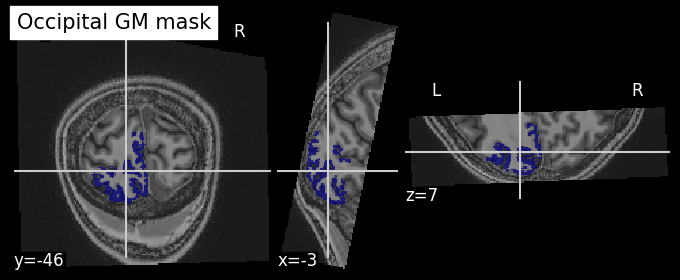

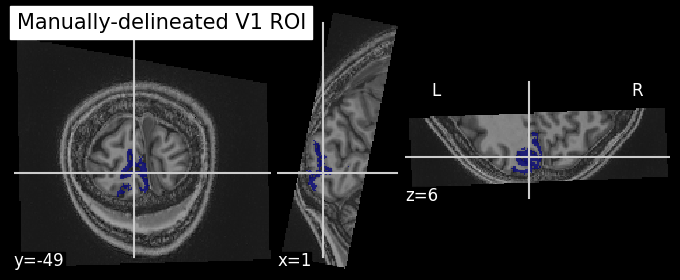

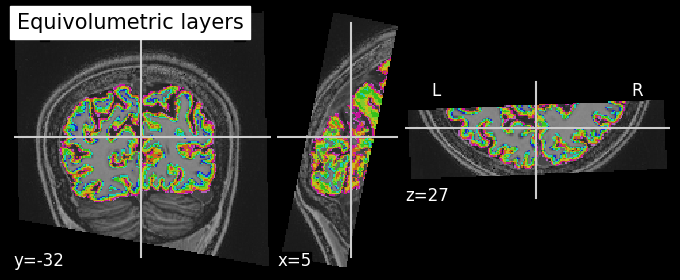

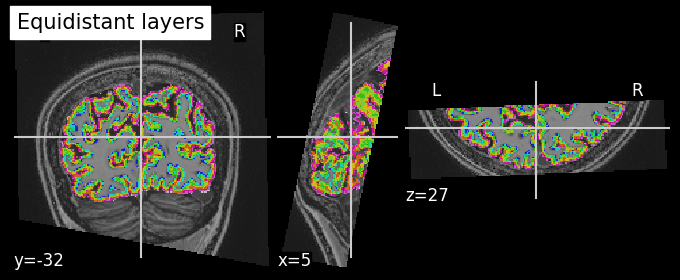

In [10]:
plot_roi(mask,UNI,title="Occipital GM mask")
plot_roi(V1,UNI,title="Manually-delineated V1 ROI")
plot_roi(lay_equivol,UNI,title="Equivolumetric layers")
plot_roi(lay_equidist,UNI,title="Equidistant layers")



# display = plotting.plot_anat(UNI)
# display.add_overlay(mask, cmap=plotting.cm.purple_green)
# display.add_overlay(V1, cmap=plotting.cm.purple_green)

# plotting.show()

In [11]:
masked_bar1 = bar_masker.fit_transform(bar1)
masked_bar2 = bar_masker.fit_transform(bar2)

masked_bar1 = np.rot90(masked_bar1)
masked_bar2 = np.rot90(masked_bar2)

np.shape(masked_bar1)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/mayajas/scratch/project-00-7t-pipeline-dev/output/func/sliceTimeCorr/_subject_id_sub-01/_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_124/atask-bar_run-01_roi_warp4D.nii')
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/mayajas/scratch/project-00-7t-pipeline-dev/output/func/sliceTimeCorr/_subject_id_sub-01/_sess_id_task-bar_run-02_sess_nr_1_sess_nvol_124/atask-bar_run-02_roi_warp4D.nii')
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


(19078, 120)

Mask mean functional and V1

In [12]:
masked_meanFunc = masker.fit_transform(meanFunc)
masked_meanFunc = np.squeeze(masked_meanFunc)

In [13]:
masked_V1 = masker.fit_transform(V1)
masked_V1 = np.squeeze(masked_V1)

In [14]:
masked_lay_equidist = masker.fit_transform(lay_equidist)
masked_lay_equidist = np.squeeze(masked_lay_equidist)

masked_lay_equivol = masker.fit_transform(lay_equivol)
masked_lay_equivol = np.squeeze(masked_lay_equivol)

Plot timecourses

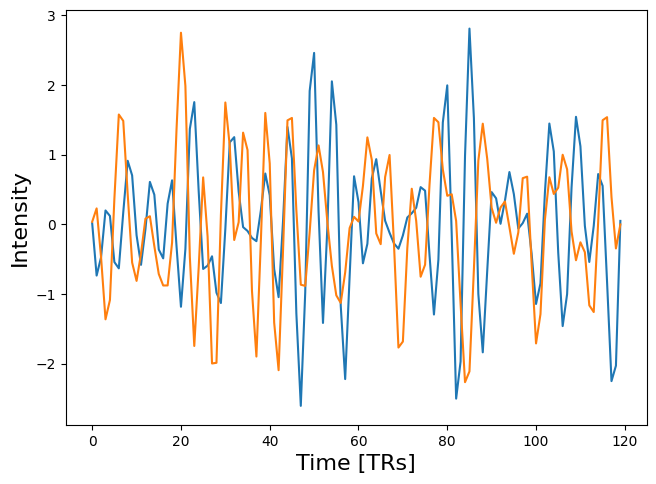

In [15]:
# And now plot a few of these
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(np.rot90(masked_bar1[:1, :]))
plt.plot(np.rot90(masked_bar2[:1, :]))
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

Average data from 2 sessions

In [16]:
bar_data = (masked_bar1 + masked_bar2)/2

Plot averaged data

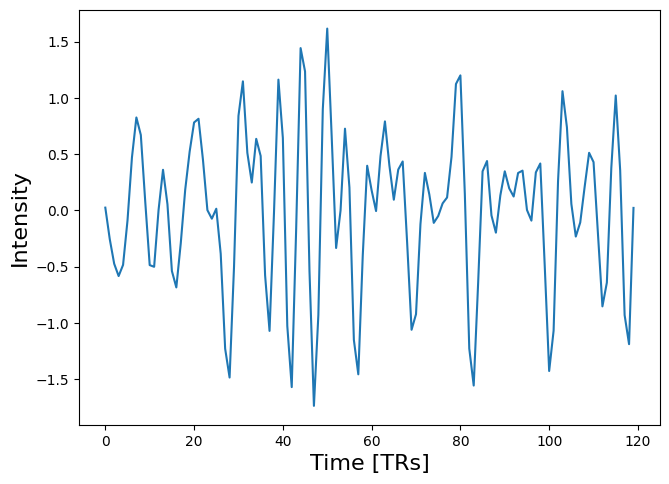

In [17]:
# And now plot a few of these
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(np.rot90(bar_data[:1, :]))
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

# fMRI data preprocessing: diagnostics


## Realignment parameter plots

In [31]:
prefix    = 'MAT_'
n_vol     = 120
n_run_bar = 2

x     = np.empty((len(subject_list),n_vol,n_run_bar))
y     = np.empty((len(subject_list),n_vol,n_run_bar))
z     = np.empty((len(subject_list),n_vol,n_run_bar))
x_rot = np.empty((len(subject_list),n_vol,n_run_bar))
y_rot = np.empty((len(subject_list),n_vol,n_run_bar))
z_rot = np.empty((len(subject_list),n_vol,n_run_bar))

s_id = 0
for sub_id in range(0,len(subject_list)):
    # within McFLIRT parameters
    mcflirt_bar1_dir = opj(proj_dir,'derivatives','wf_laminar_fMRI_func_pRF',
                          '_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_124',
                          '_subject_id_'+subject_list[sub_id],'mcflirtWithinSess',
                          'task-bar_run-01_roi_mcf.nii.mat')
    mcflirt_bar2_dir = opj(proj_dir,'derivatives','wf_laminar_fMRI_func_pRF',
                          '_sess_id_task-bar_run-02_sess_nr_1_sess_nvol_124',
                          '_subject_id_'+subject_list[sub_id],'mcflirtWithinSess',
                          'task-bar_run-02_roi_mcf.nii.mat')
    
    # initialize an empty list to store the filenames
    mcflirt_bar1_fn = []
    mcflirt_bar2_fn = []

    # use os.walk() to iterate through the directory and subdirectories
    for root, dirs, files in os.walk(mcflirt_bar1_dir):
        for file in files:
            if file.startswith(prefix):
                # create the full path of the file
                file_path = os.path.join(root, file)
                # append the file to the list
                mcflirt_bar1_fn.append(file_path)
    # use os.walk() to iterate through the directory and subdirectories
    for root, dirs, files in os.walk(mcflirt_bar2_dir):
        for file in files:
            if file.startswith(prefix):
                # create the full path of the file
                file_path = os.path.join(root, file)
                # append the file to the list
                mcflirt_bar2_fn.append(file_path)

    # Sort the list of filenames by the last three digits using a key function
    mcflirt_bar1_fn = sorted(mcflirt_bar1_fn, key=lambda x: int(x[-4:]))
    mcflirt_bar2_fn = sorted(mcflirt_bar2_fn, key=lambda x: int(x[-4:]))

    f_id = 0
    bar_run = 0
    for file in mcflirt_bar1_fn:
        avscale = fsl.AvScale()
        avscale.inputs.mat_file = file
        avscale.inputs.all_param=True
        res = avscale.run() 
        
        x[s_id,f_id,bar_run]     = res.outputs.translations[0]
        y[s_id,f_id,bar_run]     = res.outputs.translations[1]
        z[s_id,f_id,bar_run]     = res.outputs.translations[2]
        x_rot[s_id,f_id,bar_run] = math.degrees(res.outputs.rot_angles[0])
        y_rot[s_id,f_id,bar_run] = math.degrees(res.outputs.rot_angles[1])
        z_rot[s_id,f_id,bar_run] = math.degrees(res.outputs.rot_angles[2])
        
        f_id += 1
    
    f_id = 0
    bar_run = 1
    for file in mcflirt_bar1_fn:
        avscale = fsl.AvScale()
        avscale.inputs.mat_file = file
        avscale.inputs.all_param=True
        res = avscale.run() 
        
        x[s_id,f_id,bar_run]     = res.outputs.translations[0]
        y[s_id,f_id,bar_run]     = res.outputs.translations[1]
        z[s_id,f_id,bar_run]     = res.outputs.translations[2]
        x_rot[s_id,f_id,bar_run] = math.degrees(res.outputs.rot_angles[0])
        y_rot[s_id,f_id,bar_run] = math.degrees(res.outputs.rot_angles[1])
        z_rot[s_id,f_id,bar_run] = math.degrees(res.outputs.rot_angles[2])
        
        f_id += 1
        
    s_id += 1
    
translation_params = (x,y,z)
rotation_params = (x_rot,y_rot,z_rot)
    

230117-22:00:02,291 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.291611:Rotation & Translation Matrix:
230117-22:00:02,294 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.291611:1.000000 -0.000000 -0.000511 0.003153 
230117-22:00:02,295 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.291611:0.000000 1.000000 -0.000668 0.006658 
230117-22:00:02,295 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.291611:0.000511 0.000668 1.000000 -0.088982 
230117-22:00:02,297 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.291611:0.000000 0.000000 0.000000 1.000000 
230117-22:00:02,298 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.291611:
230117-22:00:02,299 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.291611:Rotation Angles (x,y,z) [rads] = -0.000668 0.000511 -0.000000 
230117-22:00:02,300 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.291611:
230117-22:00:02,301 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.291611:Translations (x,y,z) [mm] = 0.003153 0.00

230117-22:00:02,703 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.697078:Determinant = 1.000001
230117-22:00:02,703 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.697078:Left-Right orientation: preserved
230117-22:00:02,703 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.697078:
230117-22:00:02,705 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.705581:Forward half transform =
230117-22:00:02,705 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.705581:1.000000 0.000033 -0.000138 -0.000407 
230117-22:00:02,706 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.705581:-0.000033 1.000000 -0.000353 0.007841 
230117-22:00:02,706 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.705581:0.000139 0.000353 1.000000 -0.037221 
230117-22:00:02,706 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.705581:0.000000 0.000000 0.000000 1.000000 
230117-22:00:02,707 nipype.interface INFO:
	 stdout 2023-01-17T22:00:02.705581:
230117-22:00:02,707 nipype.interface INFO:
	 stdout 

230117-22:00:03,223 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.221475:1.000000 0.000130 0.000224 -0.011893 
230117-22:00:03,224 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.221475:-0.000130 1.000000 0.000854 -0.000934 
230117-22:00:03,225 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.221475:-0.000224 -0.000854 1.000000 0.087735 
230117-22:00:03,226 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.221475:0.000000 0.000000 0.000000 1.000000 
230117-22:00:03,228 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.221475:
230117-22:00:03,228 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.221475:Rotation Angles (x,y,z) [rads] = 0.000854 -0.000224 0.000130 
230117-22:00:03,229 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.221475:
230117-22:00:03,230 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.221475:Translations (x,y,z) [mm] = -0.011893 -0.000934 0.087735 
230117-22:00:03,231 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.221475:
230117-22:00:

230117-22:00:03,642 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.637288:Left-Right orientation: preserved
230117-22:00:03,643 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.637288:
230117-22:00:03,643 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.637288:Forward half transform =
230117-22:00:03,643 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.637288:1.000000 -0.000009 -0.000149 0.002908 
230117-22:00:03,644 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.637288:0.000009 1.000000 -0.000318 0.002582 
230117-22:00:03,644 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.637288:0.000148 0.000319 1.000000 -0.038756 
230117-22:00:03,644 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.637288:0.000000 0.000000 0.000000 1.000000 
230117-22:00:03,644 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.637288:
230117-22:00:03,645 nipype.interface INFO:
	 stdout 2023-01-17T22:00:03.637288:Backward half transform =
230117-22:00:03,645 nipype.interface INFO:
	 stdou

230117-22:00:04,239 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.236087:-0.000041 1.000000 0.000854 -0.002490 
230117-22:00:04,240 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.236087:-0.000240 -0.000854 1.000000 0.081751 
230117-22:00:04,241 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.236087:0.000000 0.000000 0.000000 1.000000 
230117-22:00:04,243 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.236087:
230117-22:00:04,244 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.236087:Rotation Angles (x,y,z) [rads] = 0.000854 -0.000240 0.000041 
230117-22:00:04,244 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.236087:
230117-22:00:04,245 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.236087:Translations (x,y,z) [mm] = 0.001008 -0.002490 0.081751 
230117-22:00:04,246 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.236087:
230117-22:00:04,247 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.236087:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-

230117-22:00:04,655 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.644825:
230117-22:00:04,657 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.657404:Forward half transform =
230117-22:00:04,658 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.657404:1.000000 -0.000019 0.000302 -0.000445 
230117-22:00:04,658 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.657404:0.000019 1.000000 0.000427 -0.005311 
230117-22:00:04,658 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.657404:-0.000301 -0.000427 1.000000 0.048523 
230117-22:00:04,659 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.657404:0.000000 0.000000 0.000000 1.000000 
230117-22:00:04,659 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.657404:
230117-22:00:04,659 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.657404:Backward half transform =
230117-22:00:04,660 nipype.interface INFO:
	 stdout 2023-01-17T22:00:04.657404:1.000000 0.000019 -0.000302 0.000460 
230117-22:00:04,661 nipype.interface INFO:
	 

230117-22:00:05,322 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.317901:0.000160 0.000488 1.000000 -0.071865 
230117-22:00:05,323 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.317901:0.000000 0.000000 0.000000 1.000000 
230117-22:00:05,323 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.317901:
230117-22:00:05,323 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.317901:Rotation Angles (x,y,z) [rads] = -0.000488 0.000160 0.000151 
230117-22:00:05,324 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.317901:
230117-22:00:05,324 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.317901:Translations (x,y,z) [mm] = -0.008374 0.035940 -0.071865 
230117-22:00:05,325 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.317901:
230117-22:00:05,325 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.317901:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:05,325 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.317901:
230117-22:00:05,325 nipype.interface INFO:
	 

230117-22:00:05,716 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.707903:Forward half transform =
230117-22:00:05,716 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.707903:1.000000 0.000025 0.000127 0.003608 
230117-22:00:05,716 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.707903:-0.000025 1.000000 0.000539 -0.001078 
230117-22:00:05,717 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.707903:-0.000127 -0.000538 1.000000 0.046097 
230117-22:00:05,717 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.707903:0.000000 0.000000 0.000000 1.000000 
230117-22:00:05,717 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.707903:
230117-22:00:05,719 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.719754:Backward half transform =
230117-22:00:05,720 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.719754:1.000000 -0.000025 -0.000127 -0.003602 
230117-22:00:05,721 nipype.interface INFO:
	 stdout 2023-01-17T22:00:05.719754:0.000025 1.000000 -0.000539 0.001103 
230117-

230117-22:00:06,264 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.262141:-0.000283 -0.000777 1.000000 0.074585 
230117-22:00:06,264 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.262141:0.000000 0.000000 0.000000 1.000000 
230117-22:00:06,264 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.262141:
230117-22:00:06,264 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.262141:Rotation Angles (x,y,z) [rads] = 0.000777 -0.000283 0.000175 
230117-22:00:06,266 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.262141:
230117-22:00:06,267 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.262141:Translations (x,y,z) [mm] = -0.009616 0.019228 0.074585 
230117-22:00:06,268 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.262141:
230117-22:00:06,269 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.262141:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:06,269 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.262141:
230117-22:00:06,270 nipype.interface INFO:
	 

230117-22:00:06,702 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.701983:Forward half transform =
230117-22:00:06,702 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.701983:1.000000 0.000065 -0.000178 0.000498 
230117-22:00:06,702 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.701983:-0.000065 1.000000 0.000355 0.008498 
230117-22:00:06,702 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.701983:0.000178 -0.000355 1.000000 0.015044 
230117-22:00:06,702 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.701983:0.000000 0.000000 0.000000 1.000000 
230117-22:00:06,703 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.701983:
230117-22:00:06,703 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.701983:Backward half transform =
230117-22:00:06,703 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.701983:1.000000 -0.000065 0.000178 -0.000500 
230117-22:00:06,703 nipype.interface INFO:
	 stdout 2023-01-17T22:00:06.701983:0.000065 1.000000 -0.000355 -0.008493 
230117-2

230117-22:00:07,267 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.262816:-0.000245 -0.001525 0.999999 0.119367 
230117-22:00:07,268 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.262816:0.000000 0.000000 0.000000 1.000000 
230117-22:00:07,269 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.262816:
230117-22:00:07,270 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.262816:Rotation Angles (x,y,z) [rads] = 0.001525 -0.000246 0.000344 
230117-22:00:07,271 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.262816:
230117-22:00:07,273 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.262816:Translations (x,y,z) [mm] = -0.017268 0.015181 0.119367 
230117-22:00:07,274 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.262816:
230117-22:00:07,275 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.262816:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:07,276 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.262816:
230117-22:00:07,277 nipype.interface INFO:
	 

230117-22:00:07,652 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.642933:Forward half transform =
230117-22:00:07,653 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.642933:1.000000 0.000176 0.000015 -0.007312 
230117-22:00:07,656 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.642933:-0.000176 1.000000 0.000751 0.014654 
230117-22:00:07,658 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.642933:-0.000015 -0.000750 1.000000 0.051369 
230117-22:00:07,659 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.642933:0.000000 0.000000 0.000000 1.000000 
230117-22:00:07,660 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.642933:
230117-22:00:07,660 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.642933:Backward half transform =
230117-22:00:07,661 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.642933:1.000000 -0.000176 -0.000015 0.007315 
230117-22:00:07,662 nipype.interface INFO:
	 stdout 2023-01-17T22:00:07.642933:0.000176 1.000000 -0.000751 -0.014614 
230117-

230117-22:00:08,253 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.248788:-0.000022 -0.001151 0.999999 0.065792 
230117-22:00:08,254 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.248788:0.000000 0.000000 0.000000 1.000000 
230117-22:00:08,254 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.248788:
230117-22:00:08,255 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.248788:Rotation Angles (x,y,z) [rads] = 0.001151 -0.000023 0.000436 
230117-22:00:08,256 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.248788:
230117-22:00:08,257 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.248788:Translations (x,y,z) [mm] = -0.020927 0.061939 0.065792 
230117-22:00:08,257 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.248788:
230117-22:00:08,257 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.248788:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:08,257 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.248788:
230117-22:00:08,258 nipype.interface INFO:
	 

230117-22:00:08,608 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.608052:Forward half transform =
230117-22:00:08,608 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.608052:1.000000 0.000170 0.000063 -0.007533 
230117-22:00:08,609 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.608052:-0.000169 1.000000 0.000775 0.024682 
230117-22:00:08,609 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.608052:-0.000063 -0.000775 1.000000 0.052382 
230117-22:00:08,609 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.608052:0.000000 0.000000 0.000000 1.000000 
230117-22:00:08,610 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.608052:
230117-22:00:08,610 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.608052:Backward half transform =
230117-22:00:08,610 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.608052:1.000000 -0.000170 -0.000063 0.007541 
230117-22:00:08,611 nipype.interface INFO:
	 stdout 2023-01-17T22:00:08.608052:0.000169 1.000000 -0.000775 -0.024640 
230117-

230117-22:00:09,482 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.477913:-0.000096 -0.001738 0.999999 0.118983 
230117-22:00:09,484 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.477913:0.000000 0.000000 0.000000 1.000000 
230117-22:00:09,485 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.477913:
230117-22:00:09,486 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.477913:Rotation Angles (x,y,z) [rads] = 0.001738 -0.000096 0.000217 
230117-22:00:09,487 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.477913:
230117-22:00:09,487 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.477913:Translations (x,y,z) [mm] = -0.005294 0.051111 0.118983 
230117-22:00:09,488 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.477913:
230117-22:00:09,489 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.477913:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:09,490 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.477913:
230117-22:00:09,490 nipype.interface INFO:
	 

230117-22:00:09,856 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.837088:Forward half transform =
230117-22:00:09,857 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.837088:1.000000 0.000171 0.000101 -0.008255 
230117-22:00:09,857 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.837088:-0.000171 0.999999 0.000874 0.031406 
230117-22:00:09,858 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.837088:-0.000102 -0.000874 0.999999 0.061633 
230117-22:00:09,858 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.837088:0.000000 0.000000 0.000000 1.000000 
230117-22:00:09,858 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.837088:
230117-22:00:09,859 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.837088:Backward half transform =
230117-22:00:09,859 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.837088:1.000000 -0.000171 -0.000101 0.008267 
230117-22:00:09,859 nipype.interface INFO:
	 stdout 2023-01-17T22:00:09.837088:0.000171 1.000000 -0.000874 -0.031351 
230117-

230117-22:00:10,363 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.358852:-0.000235 -0.001679 0.999999 0.112405 
230117-22:00:10,364 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.358852:0.000000 0.000000 0.000000 1.000000 
230117-22:00:10,365 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.358852:
230117-22:00:10,366 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.358852:Rotation Angles (x,y,z) [rads] = 0.001679 -0.000235 0.000268 
230117-22:00:10,366 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.358852:
230117-22:00:10,367 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.358852:Translations (x,y,z) [mm] = -0.011318 0.056245 0.112405 
230117-22:00:10,369 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.358852:
230117-22:00:10,370 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.358852:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:10,371 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.358852:
230117-22:00:10,371 nipype.interface INFO:
	 

230117-22:00:10,724 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.706034:Forward half transform =
230117-22:00:10,724 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.706034:1.000000 0.000158 0.000126 -0.007576 
230117-22:00:10,725 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.706034:-0.000157 0.999999 0.000890 0.034511 
230117-22:00:10,725 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.706034:-0.000127 -0.000890 0.999999 0.063534 
230117-22:00:10,725 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.706034:0.000000 0.000000 0.000000 1.000000 
230117-22:00:10,725 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.706034:
230117-22:00:10,726 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.706034:Backward half transform =
230117-22:00:10,726 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.706034:1.000000 -0.000158 -0.000126 0.007589 
230117-22:00:10,726 nipype.interface INFO:
	 stdout 2023-01-17T22:00:10.706034:0.000157 1.000000 -0.000890 -0.034453 
230117-

230117-22:00:11,230 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.228667:-0.000202 -0.001955 0.999998 0.130255 
230117-22:00:11,231 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.228667:0.000000 0.000000 0.000000 1.000000 
230117-22:00:11,231 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.228667:
230117-22:00:11,231 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.228667:Rotation Angles (x,y,z) [rads] = 0.001955 -0.000203 0.000329 
230117-22:00:11,232 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.228667:
230117-22:00:11,232 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.228667:Translations (x,y,z) [mm] = -0.010362 0.068539 0.130255 
230117-22:00:11,233 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.228667:
230117-22:00:11,233 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.228667:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:11,233 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.228667:
230117-22:00:11,233 nipype.interface INFO:
	 

230117-22:00:11,594 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.594251:Forward half transform =
230117-22:00:11,594 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.594251:1.000000 0.000167 0.000004 -0.007701 
230117-22:00:11,595 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.594251:-0.000167 0.999999 0.000926 0.026510 
230117-22:00:11,595 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.594251:-0.000004 -0.000926 0.999999 0.049897 
230117-22:00:11,595 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.594251:0.000000 0.000000 0.000000 1.000000 
230117-22:00:11,596 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.594251:
230117-22:00:11,596 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.594251:Backward half transform =
230117-22:00:11,596 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.594251:1.000000 -0.000167 -0.000004 0.007706 
230117-22:00:11,597 nipype.interface INFO:
	 stdout 2023-01-17T22:00:11.594251:0.000167 1.000000 -0.000926 -0.026462 
230117-

230117-22:00:12,118 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.114459:-0.000077 -0.002041 0.999998 0.117397 
230117-22:00:12,119 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.114459:0.000000 0.000000 0.000000 1.000000 
230117-22:00:12,120 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.114459:
230117-22:00:12,120 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.114459:Rotation Angles (x,y,z) [rads] = 0.002041 -0.000078 0.000330 
230117-22:00:12,121 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.114459:
230117-22:00:12,121 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.114459:Translations (x,y,z) [mm] = -0.016909 0.052375 0.117397 
230117-22:00:12,122 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.114459:
230117-22:00:12,122 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.114459:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:12,122 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.114459:
230117-22:00:12,123 nipype.interface INFO:
	 

230117-22:00:12,481 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.459221:Forward half transform =
230117-22:00:12,481 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.459221:1.000000 0.000165 0.000341 -0.009813 
230117-22:00:12,482 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.459221:-0.000166 0.999999 0.001116 0.032912 
230117-22:00:12,482 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.459221:-0.000342 -0.001115 0.999999 0.084235 
230117-22:00:12,482 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.459221:0.000000 0.000000 0.000000 1.000000 
230117-22:00:12,483 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.459221:
230117-22:00:12,484 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.484292:Backward half transform =
230117-22:00:12,484 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.484292:1.000000 -0.000166 -0.000341 0.009847 
230117-22:00:12,484 nipype.interface INFO:
	 stdout 2023-01-17T22:00:12.484292:0.000165 1.000000 -0.001116 -0.032816 
230117-

230117-22:00:13,6 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.001937:-0.000263 -0.001949 0.999998 0.105454 
230117-22:00:13,8 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.001937:0.000000 0.000000 0.000000 1.000000 
230117-22:00:13,10 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.001937:
230117-22:00:13,11 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.001937:Rotation Angles (x,y,z) [rads] = 0.001949 -0.000264 0.000378 
230117-22:00:13,12 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.001937:
230117-22:00:13,12 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.001937:Translations (x,y,z) [mm] = -0.015641 0.054788 0.105454 
230117-22:00:13,13 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.001937:
230117-22:00:13,14 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.001937:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:13,15 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.001937:
230117-22:00:13,16 nipype.interface INFO:
	 stdout 2023-

230117-22:00:13,386 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.386129:Forward half transform =
230117-22:00:13,386 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.386129:1.000000 0.000235 0.000068 -0.013686 
230117-22:00:13,386 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.386129:-0.000234 0.999999 0.000927 0.037392 
230117-22:00:13,387 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.386129:-0.000068 -0.000927 0.999999 0.045282 
230117-22:00:13,387 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.386129:0.000000 0.000000 0.000000 1.000000 
230117-22:00:13,387 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.386129:
230117-22:00:13,387 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.386129:Backward half transform =
230117-22:00:13,388 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.386129:1.000000 -0.000235 -0.000068 0.013698 
230117-22:00:13,388 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.386129:0.000234 1.000000 -0.000927 -0.037347 
230117-

230117-22:00:13,893 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.891452:-0.000150 -0.002018 0.999998 0.101367 
230117-22:00:13,893 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.891452:0.000000 0.000000 0.000000 1.000000 
230117-22:00:13,893 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.891452:
230117-22:00:13,894 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.891452:Rotation Angles (x,y,z) [rads] = 0.002018 -0.000151 0.000392 
230117-22:00:13,894 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.891452:
230117-22:00:13,894 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.891452:Translations (x,y,z) [mm] = -0.021619 0.066552 0.101367 
230117-22:00:13,894 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.891452:
230117-22:00:13,894 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.891452:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:13,895 nipype.interface INFO:
	 stdout 2023-01-17T22:00:13.891452:
230117-22:00:13,895 nipype.interface INFO:
	 

230117-22:00:14,264 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.264513:Forward half transform =
230117-22:00:14,266 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.264513:1.000000 0.000160 0.000035 -0.007495 
230117-22:00:14,266 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.264513:-0.000160 1.000000 0.000677 0.048025 
230117-22:00:14,266 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.264513:-0.000035 -0.000677 1.000000 0.024126 
230117-22:00:14,267 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.264513:0.000000 0.000000 0.000000 1.000000 
230117-22:00:14,267 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.264513:
230117-22:00:14,267 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.264513:Backward half transform =
230117-22:00:14,267 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.264513:1.000000 -0.000160 -0.000035 0.007503 
230117-22:00:14,267 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.264513:0.000160 1.000000 -0.000677 -0.048007 
230117-

230117-22:00:14,768 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.764053:-0.000189 -0.002386 0.999997 0.130510 
230117-22:00:14,769 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.764053:0.000000 0.000000 0.000000 1.000000 
230117-22:00:14,770 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.764053:
230117-22:00:14,771 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.764053:Rotation Angles (x,y,z) [rads] = 0.002386 -0.000190 0.000333 
230117-22:00:14,772 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.764053:
230117-22:00:14,773 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.764053:Translations (x,y,z) [mm] = -0.013119 0.059589 0.130510 
230117-22:00:14,774 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.764053:
230117-22:00:14,777 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.764053:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:14,778 nipype.interface INFO:
	 stdout 2023-01-17T22:00:14.764053:
230117-22:00:14,778 nipype.interface INFO:
	 

230117-22:00:15,136 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.136520:Forward half transform =
230117-22:00:15,136 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.136520:1.000000 0.000114 0.000112 -0.000271 
230117-22:00:15,137 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.136520:-0.000114 0.999999 0.001123 0.039277 
230117-22:00:15,137 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.136520:-0.000112 -0.001123 0.999999 0.064903 
230117-22:00:15,137 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.136520:0.000000 0.000000 0.000000 1.000000 
230117-22:00:15,137 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.136520:
230117-22:00:15,138 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.136520:Backward half transform =
230117-22:00:15,138 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.136520:1.000000 -0.000114 -0.000112 0.000283 
230117-22:00:15,138 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.136520:0.000114 1.000000 -0.001123 -0.039204 
230117-

230117-22:00:15,645 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.640254:-0.000261 -0.002688 0.999996 0.153565 
230117-22:00:15,646 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.640254:0.000000 0.000000 0.000000 1.000000 
230117-22:00:15,647 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.640254:
230117-22:00:15,648 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.640254:Rotation Angles (x,y,z) [rads] = 0.002688 -0.000262 0.000423 
230117-22:00:15,648 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.640254:
230117-22:00:15,649 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.640254:Translations (x,y,z) [mm] = -0.005972 0.092704 0.153565 
230117-22:00:15,650 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.640254:
230117-22:00:15,650 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.640254:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:15,651 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.640254:
230117-22:00:15,652 nipype.interface INFO:
	 

230117-22:00:16,1 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.986949:Forward half transform =
230117-22:00:16,1 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.986949:1.000000 0.000217 0.000250 -0.001700 
230117-22:00:16,2 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.986949:-0.000217 0.999999 0.001271 0.048569 
230117-22:00:16,2 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.986949:-0.000250 -0.001270 0.999999 0.082756 
230117-22:00:16,3 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.986949:0.000000 0.000000 0.000000 1.000000 
230117-22:00:16,3 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.986949:
230117-22:00:16,5 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.986949:Backward half transform =
230117-22:00:16,5 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.986949:1.000000 -0.000217 -0.000250 0.001731 
230117-22:00:16,6 nipype.interface INFO:
	 stdout 2023-01-17T22:00:15.986949:0.000217 0.999999 -0.001271 -0.048463 
230117-22:00:16,6 nipype.

230117-22:00:16,512 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.507464:-0.000271 -0.002823 0.999996 0.163729 
230117-22:00:16,512 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.507464:0.000000 0.000000 0.000000 1.000000 
230117-22:00:16,514 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.507464:
230117-22:00:16,515 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.507464:Rotation Angles (x,y,z) [rads] = 0.002823 -0.000273 0.000688 
230117-22:00:16,515 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.507464:
230117-22:00:16,516 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.507464:Translations (x,y,z) [mm] = -0.024066 0.126898 0.163729 
230117-22:00:16,517 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.507464:
230117-22:00:16,518 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.507464:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:16,518 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.507464:
230117-22:00:16,519 nipype.interface INFO:
	 

230117-22:00:16,866 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.847240:Forward half transform =
230117-22:00:16,867 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.847240:1.000000 0.000345 0.000065 -0.010953 
230117-22:00:16,867 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.847240:-0.000344 0.999999 0.001297 0.062055 
230117-22:00:16,868 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.847240:-0.000064 -0.001297 0.999999 0.071025 
230117-22:00:16,868 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.847240:0.000000 0.000000 0.000000 1.000000 
230117-22:00:16,869 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.847240:
230117-22:00:16,869 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.847240:Backward half transform =
230117-22:00:16,869 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.847240:1.000000 -0.000345 -0.000064 0.010979 
230117-22:00:16,869 nipype.interface INFO:
	 stdout 2023-01-17T22:00:16.847240:0.000344 0.999999 -0.001297 -0.061959 
230117-

230117-22:00:17,391 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.386742:-0.000483 -0.003087 0.999995 0.198284 
230117-22:00:17,392 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.386742:0.000000 0.000000 0.000000 1.000000 
230117-22:00:17,393 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.386742:
230117-22:00:17,394 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.386742:Rotation Angles (x,y,z) [rads] = 0.003087 -0.000486 0.000970 
230117-22:00:17,394 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.386742:
230117-22:00:17,396 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.386742:Translations (x,y,z) [mm] = -0.048713 0.157041 0.198284 
230117-22:00:17,397 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.386742:
230117-22:00:17,397 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.386742:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:17,397 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.386742:
230117-22:00:17,397 nipype.interface INFO:
	 

230117-22:00:17,780 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.764635:Forward half transform =
230117-22:00:17,780 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.764635:1.000000 0.000417 0.000388 -0.017593 
230117-22:00:17,781 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.764635:-0.000418 0.999999 0.001516 0.066323 
230117-22:00:17,781 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.764635:-0.000387 -0.001516 0.999999 0.100113 
230117-22:00:17,782 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.764635:0.000000 0.000000 0.000000 1.000000 
230117-22:00:17,782 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.764635:
230117-22:00:17,784 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.784659:Backward half transform =
230117-22:00:17,785 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.784659:1.000000 -0.000418 -0.000388 0.017660 
230117-22:00:17,785 nipype.interface INFO:
	 stdout 2023-01-17T22:00:17.784659:0.000417 0.999999 -0.001516 -0.066164 
230117-

230117-22:00:18,280 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.275699:-0.000517 -0.003103 0.999995 0.187845 
230117-22:00:18,280 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.275699:0.000000 0.000000 0.000000 1.000000 
230117-22:00:18,281 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.275699:
230117-22:00:18,282 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.275699:Rotation Angles (x,y,z) [rads] = 0.003103 -0.000519 0.000715 
230117-22:00:18,283 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.275699:
230117-22:00:18,283 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.275699:Translations (x,y,z) [mm] = -0.025825 0.140245 0.187845 
230117-22:00:18,284 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.275699:
230117-22:00:18,286 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.275699:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:18,286 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.275699:
230117-22:00:18,287 nipype.interface INFO:
	 

230117-22:00:18,644 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.644425:Forward half transform =
230117-22:00:18,644 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.644425:1.000000 0.000454 0.000391 -0.017043 
230117-22:00:18,645 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.644425:-0.000455 0.999998 0.001620 0.074717 
230117-22:00:18,645 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.644425:-0.000390 -0.001620 0.999998 0.110290 
230117-22:00:18,645 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.644425:0.000000 0.000000 0.000000 1.000000 
230117-22:00:18,645 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.644425:
230117-22:00:18,646 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.644425:Backward half transform =
230117-22:00:18,646 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.644425:1.000000 -0.000455 -0.000390 0.017120 
230117-22:00:18,646 nipype.interface INFO:
	 stdout 2023-01-17T22:00:18.644425:0.000454 0.999999 -0.001620 -0.074531 
230117-

230117-22:00:19,170 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.165734:-0.000369 -0.003101 0.999995 0.186138 
230117-22:00:19,172 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.165734:0.000000 0.000000 0.000000 1.000000 
230117-22:00:19,173 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.165734:
230117-22:00:19,174 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.165734:Rotation Angles (x,y,z) [rads] = 0.003101 -0.000372 0.001024 
230117-22:00:19,175 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.165734:
230117-22:00:19,176 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.165734:Translations (x,y,z) [mm] = -0.039851 0.161891 0.186138 
230117-22:00:19,176 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.165734:
230117-22:00:19,179 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.165734:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:19,179 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.165734:
230117-22:00:19,180 nipype.interface INFO:
	 

230117-22:00:19,537 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.518737:Forward half transform =
230117-22:00:19,538 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.518737:1.000000 0.000785 0.000214 -0.047856 
230117-22:00:19,538 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.518737:-0.000785 0.999999 0.001556 0.138653 
230117-22:00:19,538 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.518737:-0.000213 -0.001556 0.999999 0.102028 
230117-22:00:19,539 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.518737:0.000000 0.000000 0.000000 1.000000 
230117-22:00:19,539 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.518737:
230117-22:00:19,540 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.540971:Backward half transform =
230117-22:00:19,541 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.540971:1.000000 -0.000785 -0.000213 0.047987 
230117-22:00:19,541 nipype.interface INFO:
	 stdout 2023-01-17T22:00:19.540971:0.000785 0.999998 -0.001556 -0.138456 
230117-

230117-22:00:20,65 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.061499:-0.000618 -0.004240 0.999991 0.299556 
230117-22:00:20,66 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.061499:0.000000 0.000000 0.000000 1.000000 
230117-22:00:20,67 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.061499:
230117-22:00:20,68 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.061499:Rotation Angles (x,y,z) [rads] = 0.004239 -0.000627 0.002100 
230117-22:00:20,68 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.061499:
230117-22:00:20,71 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.061499:Translations (x,y,z) [mm] = -0.125968 0.422672 0.299556 
230117-22:00:20,71 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.061499:
230117-22:00:20,72 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.061499:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:20,73 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.061499:
230117-22:00:20,74 nipype.interface INFO:
	 stdout 202

230117-22:00:20,440 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.425006:Forward half transform =
230117-22:00:20,441 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.425006:0.999999 0.001511 0.000905 -0.093048 
230117-22:00:20,441 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.425006:-0.001515 0.999992 0.003797 0.305712 
230117-22:00:20,442 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.425006:-0.000899 -0.003799 0.999992 0.305125 
230117-22:00:20,443 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.425006:0.000000 0.000000 0.000000 1.000000 
230117-22:00:20,443 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.425006:
230117-22:00:20,446 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.446668:Backward half transform =
230117-22:00:20,446 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.446668:0.999998 -0.001515 -0.000899 0.093785 
230117-22:00:20,447 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.446668:0.001511 0.999991 -0.003799 -0.304410 
230117-

230117-22:00:20,955 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.951175:-0.001120 -0.007698 0.999970 0.574602 
230117-22:00:20,956 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.951175:0.000000 0.000000 0.000000 1.000000 
230117-22:00:20,957 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.951175:
230117-22:00:20,958 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.951175:Rotation Angles (x,y,z) [rads] = 0.007695 -0.001139 0.002403 
230117-22:00:20,959 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.951175:
230117-22:00:20,960 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.951175:Translations (x,y,z) [mm] = -0.142495 0.588661 0.574602 
230117-22:00:20,961 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.951175:
230117-22:00:20,962 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.951175:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:20,963 nipype.interface INFO:
	 stdout 2023-01-17T22:00:20.951175:
230117-22:00:20,963 nipype.interface INFO:
	 

230117-22:00:21,307 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.289130:Forward half transform =
230117-22:00:21,308 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.289130:0.999999 0.001325 0.000639 -0.074491 
230117-22:00:21,308 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.289130:-0.001327 0.999992 0.003807 0.346979 
230117-22:00:21,309 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.289130:-0.000634 -0.003809 0.999992 0.300228 
230117-22:00:21,309 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.289130:0.000000 0.000000 0.000000 1.000000 
230117-22:00:21,310 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.289130:
230117-22:00:21,310 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.289130:Backward half transform =
230117-22:00:21,311 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.289130:0.999999 -0.001327 -0.000634 0.075142 
230117-22:00:21,312 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.289130:0.001324 0.999992 -0.003808 -0.345735 
230117-

230117-22:00:21,823 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.818607:-0.001186 -0.008173 0.999966 0.620114 
230117-22:00:21,824 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.818607:0.000000 0.000000 0.000000 1.000000 
230117-22:00:21,824 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.818607:
230117-22:00:21,825 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.818607:Rotation Angles (x,y,z) [rads] = 0.008170 -0.001207 0.002512 
230117-22:00:21,826 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.818607:
230117-22:00:21,826 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.818607:Translations (x,y,z) [mm] = -0.137054 0.713266 0.620114 
230117-22:00:21,827 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.818607:
230117-22:00:21,828 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.818607:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:21,829 nipype.interface INFO:
	 stdout 2023-01-17T22:00:21.818607:
230117-22:00:21,830 nipype.interface INFO:
	 

230117-22:00:22,189 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.189652:Forward half transform =
230117-22:00:22,190 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.189652:0.999999 0.001479 0.000538 -0.084799 
230117-22:00:22,190 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.189652:-0.001481 0.999991 0.003831 0.351183 
230117-22:00:22,190 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.189652:-0.000533 -0.003832 0.999993 0.287782 
230117-22:00:22,190 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.189652:0.000000 0.000000 0.000000 1.000000 
230117-22:00:22,190 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.189652:
230117-22:00:22,191 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.189652:Backward half transform =
230117-22:00:22,191 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.189652:0.999999 -0.001481 -0.000532 0.085472 
230117-22:00:22,191 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.189652:0.001479 0.999992 -0.003832 -0.349952 
230117-

230117-22:00:22,828 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.823842:-0.001002 -0.007901 0.999968 0.601443 
230117-22:00:22,829 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.823842:0.000000 0.000000 0.000000 1.000000 
230117-22:00:22,830 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.823842:
230117-22:00:22,831 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.823842:Rotation Angles (x,y,z) [rads] = 0.007898 -0.001027 0.003188 
230117-22:00:22,832 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.823842:
230117-22:00:22,833 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.823842:Translations (x,y,z) [mm] = -0.190594 0.743669 0.601443 
230117-22:00:22,834 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.823842:
230117-22:00:22,835 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.823842:Scales (x,y,z) = 1.000001 1.000000 1.000000 
230117-22:00:22,835 nipype.interface INFO:
	 stdout 2023-01-17T22:00:22.823842:
230117-22:00:22,836 nipype.interface INFO:
	 

230117-22:00:23,218 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.200938:Forward half transform =
230117-22:00:23,219 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.200938:0.999999 0.001664 0.000423 -0.101877 
230117-22:00:23,219 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.200938:-0.001666 0.999991 0.003973 0.385690 
230117-22:00:23,219 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.200938:-0.000416 -0.003973 0.999992 0.294885 
230117-22:00:23,219 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.200938:0.000000 0.000000 0.000000 1.000000 
230117-22:00:23,220 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.200938:
230117-22:00:23,220 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.200938:Backward half transform =
230117-22:00:23,220 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.200938:0.999999 -0.001666 -0.000416 0.102642 
230117-22:00:23,221 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.200938:0.001665 0.999991 -0.003974 -0.384345 
230117-

230117-22:00:23,782 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.778134:-0.001048 -0.008393 0.999964 0.630479 
230117-22:00:23,783 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.778134:0.000000 0.000000 0.000000 1.000000 
230117-22:00:23,784 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.778134:
230117-22:00:23,785 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.778134:Rotation Angles (x,y,z) [rads] = 0.008389 -0.001080 0.003792 
230117-22:00:23,786 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.778134:
230117-22:00:23,787 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.778134:Translations (x,y,z) [mm] = -0.231699 0.798007 0.630479 
230117-22:00:23,788 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.778134:
230117-22:00:23,789 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.778134:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:23,790 nipype.interface INFO:
	 stdout 2023-01-17T22:00:23.778134:
230117-22:00:23,790 nipype.interface INFO:
	 

230117-22:00:24,168 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.150112:Forward half transform =
230117-22:00:24,168 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.150112:0.999998 0.001760 0.000483 -0.102000 
230117-22:00:24,169 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.150112:-0.001761 0.999989 0.004348 0.399334 
230117-22:00:24,170 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.150112:-0.000475 -0.004349 0.999991 0.324702 
230117-22:00:24,170 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.150112:0.000000 0.000000 0.000000 1.000000 
230117-22:00:24,171 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.150112:
230117-22:00:24,171 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.150112:Backward half transform =
230117-22:00:24,171 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.150112:0.999998 -0.001762 -0.000475 0.102858 
230117-22:00:24,171 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.150112:0.001759 0.999989 -0.004349 -0.397738 
230117-

230117-22:00:24,888 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.883485:0.000511 0.000668 1.000000 -0.088982 
230117-22:00:24,888 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.883485:0.000000 0.000000 0.000000 1.000000 
230117-22:00:24,889 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.883485:
230117-22:00:24,890 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.883485:Rotation Angles (x,y,z) [rads] = -0.000668 0.000511 -0.000000 
230117-22:00:24,891 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.883485:
230117-22:00:24,891 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.883485:Translations (x,y,z) [mm] = 0.003153 0.006658 -0.088982 
230117-22:00:24,892 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.883485:
230117-22:00:24,893 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.883485:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:24,894 nipype.interface INFO:
	 stdout 2023-01-17T22:00:24.883485:
230117-22:00:24,894 nipype.interface INFO:
	 

230117-22:00:25,311 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.311572:Forward half transform =
230117-22:00:25,311 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.311572:1.000000 0.000033 -0.000138 -0.000407 
230117-22:00:25,312 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.311572:-0.000033 1.000000 -0.000353 0.007841 
230117-22:00:25,312 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.311572:0.000139 0.000353 1.000000 -0.037221 
230117-22:00:25,313 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.311572:0.000000 0.000000 0.000000 1.000000 
230117-22:00:25,313 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.311572:
230117-22:00:25,314 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.311572:Backward half transform =
230117-22:00:25,314 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.311572:1.000000 -0.000033 0.000138 0.000413 
230117-22:00:25,315 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.311572:0.000033 1.000000 0.000353 -0.007828 
230117-2

230117-22:00:25,867 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.862921:-0.000224 -0.000854 1.000000 0.087735 
230117-22:00:25,868 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.862921:0.000000 0.000000 0.000000 1.000000 
230117-22:00:25,869 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.862921:
230117-22:00:25,870 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.862921:Rotation Angles (x,y,z) [rads] = 0.000854 -0.000224 0.000130 
230117-22:00:25,871 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.862921:
230117-22:00:25,872 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.862921:Translations (x,y,z) [mm] = -0.011893 -0.000934 0.087735 
230117-22:00:25,873 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.862921:
230117-22:00:25,873 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.862921:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:25,874 nipype.interface INFO:
	 stdout 2023-01-17T22:00:25.862921:
230117-22:00:25,875 nipype.interface INFO:
	

230117-22:00:26,260 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.260493:Forward half transform =
230117-22:00:26,260 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.260493:1.000000 -0.000009 -0.000149 0.002908 
230117-22:00:26,261 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.260493:0.000009 1.000000 -0.000318 0.002582 
230117-22:00:26,261 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.260493:0.000148 0.000319 1.000000 -0.038756 
230117-22:00:26,262 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.260493:0.000000 0.000000 0.000000 1.000000 
230117-22:00:26,262 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.260493:
230117-22:00:26,263 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.260493:Backward half transform =
230117-22:00:26,263 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.260493:1.000000 0.000009 0.000149 -0.002902 
230117-22:00:26,263 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.260493:-0.000009 1.000000 0.000318 -0.002569 
230117-2

230117-22:00:26,815 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.810804:-0.000240 -0.000854 1.000000 0.081751 
230117-22:00:26,816 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.810804:0.000000 0.000000 0.000000 1.000000 
230117-22:00:26,816 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.810804:
230117-22:00:26,817 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.810804:Rotation Angles (x,y,z) [rads] = 0.000854 -0.000240 0.000041 
230117-22:00:26,818 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.810804:
230117-22:00:26,819 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.810804:Translations (x,y,z) [mm] = 0.001008 -0.002490 0.081751 
230117-22:00:26,819 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.810804:
230117-22:00:26,820 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.810804:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:26,821 nipype.interface INFO:
	 stdout 2023-01-17T22:00:26.810804:
230117-22:00:26,821 nipype.interface INFO:
	 

230117-22:00:27,213 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.213273:Forward half transform =
230117-22:00:27,213 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.213273:1.000000 -0.000019 0.000302 -0.000445 
230117-22:00:27,214 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.213273:0.000019 1.000000 0.000427 -0.005311 
230117-22:00:27,215 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.213273:-0.000301 -0.000427 1.000000 0.048523 
230117-22:00:27,215 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.213273:0.000000 0.000000 0.000000 1.000000 
230117-22:00:27,216 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.213273:
230117-22:00:27,216 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.213273:Backward half transform =
230117-22:00:27,217 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.213273:1.000000 0.000019 -0.000302 0.000460 
230117-22:00:27,217 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.213273:-0.000019 1.000000 -0.000427 0.005332 
230117-

230117-22:00:27,765 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.761059:0.000160 0.000488 1.000000 -0.071865 
230117-22:00:27,765 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.761059:0.000000 0.000000 0.000000 1.000000 
230117-22:00:27,766 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.761059:
230117-22:00:27,766 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.761059:Rotation Angles (x,y,z) [rads] = -0.000488 0.000160 0.000151 
230117-22:00:27,766 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.761059:
230117-22:00:27,766 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.761059:Translations (x,y,z) [mm] = -0.008374 0.035940 -0.071865 
230117-22:00:27,767 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.761059:
230117-22:00:27,767 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.761059:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:27,767 nipype.interface INFO:
	 stdout 2023-01-17T22:00:27.761059:
230117-22:00:27,768 nipype.interface INFO:
	 

230117-22:00:28,166 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.166354:Forward half transform =
230117-22:00:28,166 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.166354:1.000000 0.000025 0.000127 0.003608 
230117-22:00:28,167 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.166354:-0.000025 1.000000 0.000539 -0.001078 
230117-22:00:28,167 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.166354:-0.000127 -0.000538 1.000000 0.046097 
230117-22:00:28,168 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.166354:0.000000 0.000000 0.000000 1.000000 
230117-22:00:28,168 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.166354:
230117-22:00:28,169 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.166354:Backward half transform =
230117-22:00:28,169 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.166354:1.000000 -0.000025 -0.000127 -0.003602 
230117-22:00:28,170 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.166354:0.000025 1.000000 -0.000539 0.001103 
230117-

230117-22:00:28,717 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.713473:-0.000283 -0.000777 1.000000 0.074585 
230117-22:00:28,718 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.713473:0.000000 0.000000 0.000000 1.000000 
230117-22:00:28,719 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.713473:
230117-22:00:28,720 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.713473:Rotation Angles (x,y,z) [rads] = 0.000777 -0.000283 0.000175 
230117-22:00:28,721 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.713473:
230117-22:00:28,721 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.713473:Translations (x,y,z) [mm] = -0.009616 0.019228 0.074585 
230117-22:00:28,722 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.713473:
230117-22:00:28,722 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.713473:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:28,723 nipype.interface INFO:
	 stdout 2023-01-17T22:00:28.713473:
230117-22:00:28,723 nipype.interface INFO:
	 

230117-22:00:29,114 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.092620:Forward half transform =
230117-22:00:29,117 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.092620:1.000000 0.000065 -0.000178 0.000498 
230117-22:00:29,118 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.092620:-0.000065 1.000000 0.000355 0.008498 
230117-22:00:29,118 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.092620:0.000178 -0.000355 1.000000 0.015044 
230117-22:00:29,119 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.092620:0.000000 0.000000 0.000000 1.000000 
230117-22:00:29,119 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.092620:
230117-22:00:29,120 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.120615:Backward half transform =
230117-22:00:29,120 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.120615:1.000000 -0.000065 0.000178 -0.000500 
230117-22:00:29,121 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.120615:0.000065 1.000000 -0.000355 -0.008493 
230117-2

230117-22:00:29,691 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.686477:-0.000245 -0.001525 0.999999 0.119367 
230117-22:00:29,692 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.686477:0.000000 0.000000 0.000000 1.000000 
230117-22:00:29,693 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.686477:
230117-22:00:29,693 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.686477:Rotation Angles (x,y,z) [rads] = 0.001525 -0.000246 0.000344 
230117-22:00:29,694 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.686477:
230117-22:00:29,696 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.686477:Translations (x,y,z) [mm] = -0.017268 0.015181 0.119367 
230117-22:00:29,697 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.686477:
230117-22:00:29,697 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.686477:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:29,698 nipype.interface INFO:
	 stdout 2023-01-17T22:00:29.686477:
230117-22:00:29,699 nipype.interface INFO:
	 

230117-22:00:30,92 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.073043:Forward half transform =
230117-22:00:30,93 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.073043:1.000000 0.000176 0.000015 -0.007312 
230117-22:00:30,93 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.073043:-0.000176 1.000000 0.000751 0.014654 
230117-22:00:30,94 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.073043:-0.000015 -0.000750 1.000000 0.051369 
230117-22:00:30,94 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.073043:0.000000 0.000000 0.000000 1.000000 
230117-22:00:30,94 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.073043:
230117-22:00:30,95 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.073043:Backward half transform =
230117-22:00:30,95 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.073043:1.000000 -0.000176 -0.000015 0.007315 
230117-22:00:30,95 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.073043:0.000176 1.000000 -0.000751 -0.014614 
230117-22:00:30,

230117-22:00:30,631 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.626375:-0.000022 -0.001151 0.999999 0.065792 
230117-22:00:30,632 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.626375:0.000000 0.000000 0.000000 1.000000 
230117-22:00:30,633 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.626375:
230117-22:00:30,634 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.626375:Rotation Angles (x,y,z) [rads] = 0.001151 -0.000023 0.000436 
230117-22:00:30,634 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.626375:
230117-22:00:30,635 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.626375:Translations (x,y,z) [mm] = -0.020927 0.061939 0.065792 
230117-22:00:30,636 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.626375:
230117-22:00:30,637 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.626375:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:30,637 nipype.interface INFO:
	 stdout 2023-01-17T22:00:30.626375:
230117-22:00:30,638 nipype.interface INFO:
	 

230117-22:00:31,17 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.002516:Forward half transform =
230117-22:00:31,17 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.002516:1.000000 0.000170 0.000063 -0.007533 
230117-22:00:31,17 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.002516:-0.000169 1.000000 0.000775 0.024682 
230117-22:00:31,17 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.002516:-0.000063 -0.000775 1.000000 0.052382 
230117-22:00:31,18 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.002516:0.000000 0.000000 0.000000 1.000000 
230117-22:00:31,18 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.002516:
230117-22:00:31,19 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.002516:Backward half transform =
230117-22:00:31,19 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.002516:1.000000 -0.000170 -0.000063 0.007541 
230117-22:00:31,20 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.002516:0.000169 1.000000 -0.000775 -0.024640 
230117-22:00:31,

230117-22:00:31,595 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.591059:-0.000096 -0.001738 0.999999 0.118983 
230117-22:00:31,596 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.591059:0.000000 0.000000 0.000000 1.000000 
230117-22:00:31,597 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.591059:
230117-22:00:31,597 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.591059:Rotation Angles (x,y,z) [rads] = 0.001738 -0.000096 0.000217 
230117-22:00:31,598 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.591059:
230117-22:00:31,599 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.591059:Translations (x,y,z) [mm] = -0.005294 0.051111 0.118983 
230117-22:00:31,601 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.591059:
230117-22:00:31,602 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.591059:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:31,603 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.591059:
230117-22:00:31,604 nipype.interface INFO:
	 

230117-22:00:31,984 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.966384:Forward half transform =
230117-22:00:31,984 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.966384:1.000000 0.000171 0.000101 -0.008255 
230117-22:00:31,985 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.966384:-0.000171 0.999999 0.000874 0.031406 
230117-22:00:31,985 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.966384:-0.000102 -0.000874 0.999999 0.061633 
230117-22:00:31,986 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.966384:0.000000 0.000000 0.000000 1.000000 
230117-22:00:31,986 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.966384:
230117-22:00:31,986 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.966384:Backward half transform =
230117-22:00:31,987 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.966384:1.000000 -0.000171 -0.000101 0.008267 
230117-22:00:31,987 nipype.interface INFO:
	 stdout 2023-01-17T22:00:31.966384:0.000171 1.000000 -0.000874 -0.031351 
230117-

230117-22:00:32,538 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.533421:-0.000235 -0.001679 0.999999 0.112405 
230117-22:00:32,539 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.533421:0.000000 0.000000 0.000000 1.000000 
230117-22:00:32,540 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.533421:
230117-22:00:32,541 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.533421:Rotation Angles (x,y,z) [rads] = 0.001679 -0.000235 0.000268 
230117-22:00:32,542 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.533421:
230117-22:00:32,543 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.533421:Translations (x,y,z) [mm] = -0.011318 0.056245 0.112405 
230117-22:00:32,544 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.533421:
230117-22:00:32,545 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.533421:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:32,546 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.533421:
230117-22:00:32,550 nipype.interface INFO:
	 

230117-22:00:32,933 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.914633:Forward half transform =
230117-22:00:32,933 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.914633:1.000000 0.000158 0.000126 -0.007576 
230117-22:00:32,933 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.914633:-0.000157 0.999999 0.000890 0.034511 
230117-22:00:32,934 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.914633:-0.000127 -0.000890 0.999999 0.063534 
230117-22:00:32,934 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.914633:0.000000 0.000000 0.000000 1.000000 
230117-22:00:32,934 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.914633:
230117-22:00:32,935 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.914633:Backward half transform =
230117-22:00:32,935 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.914633:1.000000 -0.000158 -0.000126 0.007589 
230117-22:00:32,936 nipype.interface INFO:
	 stdout 2023-01-17T22:00:32.914633:0.000157 1.000000 -0.000890 -0.034453 
230117-

230117-22:00:33,487 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.482562:-0.000202 -0.001955 0.999998 0.130255 
230117-22:00:33,488 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.482562:0.000000 0.000000 0.000000 1.000000 
230117-22:00:33,489 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.482562:
230117-22:00:33,490 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.482562:Rotation Angles (x,y,z) [rads] = 0.001955 -0.000203 0.000329 
230117-22:00:33,491 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.482562:
230117-22:00:33,492 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.482562:Translations (x,y,z) [mm] = -0.010362 0.068539 0.130255 
230117-22:00:33,493 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.482562:
230117-22:00:33,494 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.482562:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:33,494 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.482562:
230117-22:00:33,495 nipype.interface INFO:
	 

230117-22:00:33,879 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.862175:Forward half transform =
230117-22:00:33,879 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.862175:1.000000 0.000167 0.000004 -0.007701 
230117-22:00:33,879 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.862175:-0.000167 0.999999 0.000926 0.026510 
230117-22:00:33,880 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.862175:-0.000004 -0.000926 0.999999 0.049897 
230117-22:00:33,880 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.862175:0.000000 0.000000 0.000000 1.000000 
230117-22:00:33,880 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.862175:
230117-22:00:33,881 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.862175:Backward half transform =
230117-22:00:33,881 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.862175:1.000000 -0.000167 -0.000004 0.007706 
230117-22:00:33,881 nipype.interface INFO:
	 stdout 2023-01-17T22:00:33.862175:0.000167 1.000000 -0.000926 -0.026462 
230117-

230117-22:00:34,464 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.460887:-0.000077 -0.002041 0.999998 0.117397 
230117-22:00:34,464 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.460887:0.000000 0.000000 0.000000 1.000000 
230117-22:00:34,465 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.460887:
230117-22:00:34,466 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.460887:Rotation Angles (x,y,z) [rads] = 0.002041 -0.000078 0.000330 
230117-22:00:34,466 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.460887:
230117-22:00:34,467 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.460887:Translations (x,y,z) [mm] = -0.016909 0.052375 0.117397 
230117-22:00:34,467 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.460887:
230117-22:00:34,467 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.460887:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:34,467 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.460887:
230117-22:00:34,468 nipype.interface INFO:
	 

230117-22:00:34,846 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.846459:Forward half transform =
230117-22:00:34,846 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.846459:1.000000 0.000165 0.000341 -0.009813 
230117-22:00:34,847 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.846459:-0.000166 0.999999 0.001116 0.032912 
230117-22:00:34,848 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.846459:-0.000342 -0.001115 0.999999 0.084235 
230117-22:00:34,848 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.846459:0.000000 0.000000 0.000000 1.000000 
230117-22:00:34,848 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.846459:
230117-22:00:34,849 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.846459:Backward half transform =
230117-22:00:34,849 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.846459:1.000000 -0.000166 -0.000341 0.009847 
230117-22:00:34,849 nipype.interface INFO:
	 stdout 2023-01-17T22:00:34.846459:0.000165 1.000000 -0.001116 -0.032816 
230117-

230117-22:00:35,483 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.478988:-0.000263 -0.001949 0.999998 0.105454 
230117-22:00:35,484 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.478988:0.000000 0.000000 0.000000 1.000000 
230117-22:00:35,484 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.478988:
230117-22:00:35,485 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.478988:Rotation Angles (x,y,z) [rads] = 0.001949 -0.000264 0.000378 
230117-22:00:35,486 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.478988:
230117-22:00:35,487 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.478988:Translations (x,y,z) [mm] = -0.015641 0.054788 0.105454 
230117-22:00:35,488 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.478988:
230117-22:00:35,489 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.478988:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:35,490 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.478988:
230117-22:00:35,490 nipype.interface INFO:
	 

230117-22:00:35,864 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.864429:Forward half transform =
230117-22:00:35,864 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.864429:1.000000 0.000235 0.000068 -0.013686 
230117-22:00:35,865 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.864429:-0.000234 0.999999 0.000927 0.037392 
230117-22:00:35,866 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.864429:-0.000068 -0.000927 0.999999 0.045282 
230117-22:00:35,866 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.864429:0.000000 0.000000 0.000000 1.000000 
230117-22:00:35,866 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.864429:
230117-22:00:35,867 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.864429:Backward half transform =
230117-22:00:35,867 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.864429:1.000000 -0.000235 -0.000068 0.013698 
230117-22:00:35,868 nipype.interface INFO:
	 stdout 2023-01-17T22:00:35.864429:0.000234 1.000000 -0.000927 -0.037347 
230117-

230117-22:00:36,411 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.407450:-0.000150 -0.002018 0.999998 0.101367 
230117-22:00:36,413 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.407450:0.000000 0.000000 0.000000 1.000000 
230117-22:00:36,414 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.407450:
230117-22:00:36,415 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.407450:Rotation Angles (x,y,z) [rads] = 0.002018 -0.000151 0.000392 
230117-22:00:36,415 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.407450:
230117-22:00:36,416 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.407450:Translations (x,y,z) [mm] = -0.021619 0.066552 0.101367 
230117-22:00:36,417 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.407450:
230117-22:00:36,417 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.407450:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:36,418 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.407450:
230117-22:00:36,419 nipype.interface INFO:
	 

230117-22:00:36,818 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.800681:Forward half transform =
230117-22:00:36,819 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.800681:1.000000 0.000160 0.000035 -0.007495 
230117-22:00:36,819 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.800681:-0.000160 1.000000 0.000677 0.048025 
230117-22:00:36,819 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.800681:-0.000035 -0.000677 1.000000 0.024126 
230117-22:00:36,820 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.800681:0.000000 0.000000 0.000000 1.000000 
230117-22:00:36,822 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.800681:
230117-22:00:36,822 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.800681:Backward half transform =
230117-22:00:36,822 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.800681:1.000000 -0.000160 -0.000035 0.007503 
230117-22:00:36,822 nipype.interface INFO:
	 stdout 2023-01-17T22:00:36.800681:0.000160 1.000000 -0.000677 -0.048007 
230117-

230117-22:00:37,390 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.385921:-0.000189 -0.002386 0.999997 0.130510 
230117-22:00:37,391 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.385921:0.000000 0.000000 0.000000 1.000000 
230117-22:00:37,392 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.385921:
230117-22:00:37,393 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.385921:Rotation Angles (x,y,z) [rads] = 0.002386 -0.000190 0.000333 
230117-22:00:37,394 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.385921:
230117-22:00:37,394 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.385921:Translations (x,y,z) [mm] = -0.013119 0.059589 0.130510 
230117-22:00:37,395 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.385921:
230117-22:00:37,396 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.385921:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:37,396 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.385921:
230117-22:00:37,397 nipype.interface INFO:
	 

230117-22:00:37,776 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.776061:Forward half transform =
230117-22:00:37,776 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.776061:1.000000 0.000114 0.000112 -0.000271 
230117-22:00:37,776 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.776061:-0.000114 0.999999 0.001123 0.039277 
230117-22:00:37,776 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.776061:-0.000112 -0.001123 0.999999 0.064903 
230117-22:00:37,777 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.776061:0.000000 0.000000 0.000000 1.000000 
230117-22:00:37,777 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.776061:
230117-22:00:37,777 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.776061:Backward half transform =
230117-22:00:37,777 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.776061:1.000000 -0.000114 -0.000112 0.000283 
230117-22:00:37,778 nipype.interface INFO:
	 stdout 2023-01-17T22:00:37.776061:0.000114 1.000000 -0.001123 -0.039204 
230117-

230117-22:00:38,358 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.353407:-0.000261 -0.002688 0.999996 0.153565 
230117-22:00:38,359 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.353407:0.000000 0.000000 0.000000 1.000000 
230117-22:00:38,360 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.353407:
230117-22:00:38,361 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.353407:Rotation Angles (x,y,z) [rads] = 0.002688 -0.000262 0.000423 
230117-22:00:38,363 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.353407:
230117-22:00:38,364 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.353407:Translations (x,y,z) [mm] = -0.005972 0.092704 0.153565 
230117-22:00:38,365 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.353407:
230117-22:00:38,365 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.353407:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:38,366 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.353407:
230117-22:00:38,367 nipype.interface INFO:
	 

230117-22:00:38,754 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.735564:Forward half transform =
230117-22:00:38,755 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.735564:1.000000 0.000217 0.000250 -0.001700 
230117-22:00:38,757 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.735564:-0.000217 0.999999 0.001271 0.048569 
230117-22:00:38,757 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.735564:-0.000250 -0.001270 0.999999 0.082756 
230117-22:00:38,757 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.735564:0.000000 0.000000 0.000000 1.000000 
230117-22:00:38,758 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.735564:
230117-22:00:38,758 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.735564:Backward half transform =
230117-22:00:38,758 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.735564:1.000000 -0.000217 -0.000250 0.001731 
230117-22:00:38,758 nipype.interface INFO:
	 stdout 2023-01-17T22:00:38.735564:0.000217 0.999999 -0.001271 -0.048463 
230117-

230117-22:00:39,314 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.310399:-0.000271 -0.002823 0.999996 0.163729 
230117-22:00:39,315 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.310399:0.000000 0.000000 0.000000 1.000000 
230117-22:00:39,315 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.310399:
230117-22:00:39,317 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.310399:Rotation Angles (x,y,z) [rads] = 0.002823 -0.000273 0.000688 
230117-22:00:39,318 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.310399:
230117-22:00:39,319 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.310399:Translations (x,y,z) [mm] = -0.024066 0.126898 0.163729 
230117-22:00:39,320 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.310399:
230117-22:00:39,320 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.310399:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:39,321 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.310399:
230117-22:00:39,322 nipype.interface INFO:
	 

230117-22:00:39,789 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.771149:Forward half transform =
230117-22:00:39,789 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.771149:1.000000 0.000345 0.000065 -0.010953 
230117-22:00:39,789 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.771149:-0.000344 0.999999 0.001297 0.062055 
230117-22:00:39,790 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.771149:-0.000064 -0.001297 0.999999 0.071025 
230117-22:00:39,790 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.771149:0.000000 0.000000 0.000000 1.000000 
230117-22:00:39,790 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.771149:
230117-22:00:39,791 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.771149:Backward half transform =
230117-22:00:39,792 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.771149:1.000000 -0.000345 -0.000064 0.010979 
230117-22:00:39,792 nipype.interface INFO:
	 stdout 2023-01-17T22:00:39.771149:0.000344 0.999999 -0.001297 -0.061959 
230117-

230117-22:00:40,352 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.347893:-0.000483 -0.003087 0.999995 0.198284 
230117-22:00:40,353 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.347893:0.000000 0.000000 0.000000 1.000000 
230117-22:00:40,354 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.347893:
230117-22:00:40,355 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.347893:Rotation Angles (x,y,z) [rads] = 0.003087 -0.000486 0.000970 
230117-22:00:40,356 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.347893:
230117-22:00:40,358 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.347893:Translations (x,y,z) [mm] = -0.048713 0.157041 0.198284 
230117-22:00:40,359 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.347893:
230117-22:00:40,360 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.347893:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:40,361 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.347893:
230117-22:00:40,361 nipype.interface INFO:
	 

230117-22:00:40,764 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.743993:Forward half transform =
230117-22:00:40,764 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.743993:1.000000 0.000417 0.000388 -0.017593 
230117-22:00:40,765 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.743993:-0.000418 0.999999 0.001516 0.066323 
230117-22:00:40,765 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.743993:-0.000387 -0.001516 0.999999 0.100113 
230117-22:00:40,766 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.743993:0.000000 0.000000 0.000000 1.000000 
230117-22:00:40,766 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.743993:
230117-22:00:40,766 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.743993:Backward half transform =
230117-22:00:40,767 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.743993:1.000000 -0.000418 -0.000388 0.017660 
230117-22:00:40,767 nipype.interface INFO:
	 stdout 2023-01-17T22:00:40.743993:0.000417 0.999999 -0.001516 -0.066164 
230117-

230117-22:00:41,332 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.328466:-0.000517 -0.003103 0.999995 0.187845 
230117-22:00:41,333 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.328466:0.000000 0.000000 0.000000 1.000000 
230117-22:00:41,334 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.328466:
230117-22:00:41,335 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.328466:Rotation Angles (x,y,z) [rads] = 0.003103 -0.000519 0.000715 
230117-22:00:41,336 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.328466:
230117-22:00:41,337 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.328466:Translations (x,y,z) [mm] = -0.025825 0.140245 0.187845 
230117-22:00:41,337 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.328466:
230117-22:00:41,338 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.328466:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:41,339 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.328466:
230117-22:00:41,340 nipype.interface INFO:
	 

230117-22:00:41,744 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.728852:Forward half transform =
230117-22:00:41,745 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.728852:1.000000 0.000454 0.000391 -0.017043 
230117-22:00:41,746 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.728852:-0.000455 0.999998 0.001620 0.074717 
230117-22:00:41,746 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.728852:-0.000390 -0.001620 0.999998 0.110290 
230117-22:00:41,747 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.728852:0.000000 0.000000 0.000000 1.000000 
230117-22:00:41,747 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.728852:
230117-22:00:41,747 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.728852:Backward half transform =
230117-22:00:41,748 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.728852:1.000000 -0.000455 -0.000390 0.017120 
230117-22:00:41,748 nipype.interface INFO:
	 stdout 2023-01-17T22:00:41.728852:0.000454 0.999999 -0.001620 -0.074531 
230117-

230117-22:00:42,307 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.302375:-0.000369 -0.003101 0.999995 0.186138 
230117-22:00:42,308 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.302375:0.000000 0.000000 0.000000 1.000000 
230117-22:00:42,309 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.302375:
230117-22:00:42,310 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.302375:Rotation Angles (x,y,z) [rads] = 0.003101 -0.000372 0.001024 
230117-22:00:42,311 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.302375:
230117-22:00:42,312 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.302375:Translations (x,y,z) [mm] = -0.039851 0.161891 0.186138 
230117-22:00:42,313 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.302375:
230117-22:00:42,314 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.302375:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:42,315 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.302375:
230117-22:00:42,315 nipype.interface INFO:
	 

230117-22:00:42,706 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.706101:Forward half transform =
230117-22:00:42,706 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.706101:1.000000 0.000785 0.000214 -0.047856 
230117-22:00:42,707 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.706101:-0.000785 0.999999 0.001556 0.138653 
230117-22:00:42,707 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.706101:-0.000213 -0.001556 0.999999 0.102028 
230117-22:00:42,707 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.706101:0.000000 0.000000 0.000000 1.000000 
230117-22:00:42,707 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.706101:
230117-22:00:42,708 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.706101:Backward half transform =
230117-22:00:42,708 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.706101:1.000000 -0.000785 -0.000213 0.047987 
230117-22:00:42,708 nipype.interface INFO:
	 stdout 2023-01-17T22:00:42.706101:0.000785 0.999998 -0.001556 -0.138456 
230117-

230117-22:00:43,344 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.339971:-0.000618 -0.004240 0.999991 0.299556 
230117-22:00:43,344 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.339971:0.000000 0.000000 0.000000 1.000000 
230117-22:00:43,345 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.339971:
230117-22:00:43,346 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.339971:Rotation Angles (x,y,z) [rads] = 0.004239 -0.000627 0.002100 
230117-22:00:43,346 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.339971:
230117-22:00:43,347 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.339971:Translations (x,y,z) [mm] = -0.125968 0.422672 0.299556 
230117-22:00:43,348 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.339971:
230117-22:00:43,349 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.339971:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:43,349 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.339971:
230117-22:00:43,350 nipype.interface INFO:
	 

230117-22:00:43,731 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.713536:Forward half transform =
230117-22:00:43,732 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.713536:0.999999 0.001511 0.000905 -0.093048 
230117-22:00:43,732 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.713536:-0.001515 0.999992 0.003797 0.305712 
230117-22:00:43,733 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.713536:-0.000899 -0.003799 0.999992 0.305125 
230117-22:00:43,733 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.713536:0.000000 0.000000 0.000000 1.000000 
230117-22:00:43,733 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.713536:
230117-22:00:43,734 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.713536:Backward half transform =
230117-22:00:43,734 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.713536:0.999998 -0.001515 -0.000899 0.093785 
230117-22:00:43,734 nipype.interface INFO:
	 stdout 2023-01-17T22:00:43.713536:0.001511 0.999991 -0.003799 -0.304410 
230117-

230117-22:00:44,391 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.386731:-0.001120 -0.007698 0.999970 0.574602 
230117-22:00:44,392 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.386731:0.000000 0.000000 0.000000 1.000000 
230117-22:00:44,393 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.386731:
230117-22:00:44,394 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.386731:Rotation Angles (x,y,z) [rads] = 0.007695 -0.001139 0.002403 
230117-22:00:44,395 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.386731:
230117-22:00:44,395 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.386731:Translations (x,y,z) [mm] = -0.142495 0.588661 0.574602 
230117-22:00:44,396 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.386731:
230117-22:00:44,397 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.386731:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:44,397 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.386731:
230117-22:00:44,398 nipype.interface INFO:
	 

230117-22:00:44,775 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.758345:Forward half transform =
230117-22:00:44,775 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.758345:0.999999 0.001325 0.000639 -0.074491 
230117-22:00:44,776 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.758345:-0.001327 0.999992 0.003807 0.346979 
230117-22:00:44,776 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.758345:-0.000634 -0.003809 0.999992 0.300228 
230117-22:00:44,777 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.758345:0.000000 0.000000 0.000000 1.000000 
230117-22:00:44,777 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.758345:
230117-22:00:44,777 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.758345:Backward half transform =
230117-22:00:44,778 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.758345:0.999999 -0.001327 -0.000634 0.075142 
230117-22:00:44,778 nipype.interface INFO:
	 stdout 2023-01-17T22:00:44.758345:0.001324 0.999992 -0.003808 -0.345735 
230117-

230117-22:00:45,335 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.330680:-0.001186 -0.008173 0.999966 0.620114 
230117-22:00:45,335 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.330680:0.000000 0.000000 0.000000 1.000000 
230117-22:00:45,336 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.330680:
230117-22:00:45,337 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.330680:Rotation Angles (x,y,z) [rads] = 0.008170 -0.001207 0.002512 
230117-22:00:45,338 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.330680:
230117-22:00:45,339 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.330680:Translations (x,y,z) [mm] = -0.137054 0.713266 0.620114 
230117-22:00:45,340 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.330680:
230117-22:00:45,341 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.330680:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:45,341 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.330680:
230117-22:00:45,342 nipype.interface INFO:
	 

230117-22:00:45,711 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.711398:Forward half transform =
230117-22:00:45,711 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.711398:0.999999 0.001479 0.000538 -0.084799 
230117-22:00:45,712 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.711398:-0.001481 0.999991 0.003831 0.351183 
230117-22:00:45,712 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.711398:-0.000533 -0.003832 0.999993 0.287782 
230117-22:00:45,713 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.711398:0.000000 0.000000 0.000000 1.000000 
230117-22:00:45,713 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.711398:
230117-22:00:45,713 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.711398:Backward half transform =
230117-22:00:45,713 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.711398:0.999999 -0.001481 -0.000532 0.085472 
230117-22:00:45,714 nipype.interface INFO:
	 stdout 2023-01-17T22:00:45.711398:0.001479 0.999992 -0.003832 -0.349952 
230117-

230117-22:00:46,258 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.253842:-0.001002 -0.007901 0.999968 0.601443 
230117-22:00:46,259 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.253842:0.000000 0.000000 0.000000 1.000000 
230117-22:00:46,260 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.253842:
230117-22:00:46,261 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.253842:Rotation Angles (x,y,z) [rads] = 0.007898 -0.001027 0.003188 
230117-22:00:46,262 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.253842:
230117-22:00:46,263 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.253842:Translations (x,y,z) [mm] = -0.190594 0.743669 0.601443 
230117-22:00:46,264 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.253842:
230117-22:00:46,265 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.253842:Scales (x,y,z) = 1.000001 1.000000 1.000000 
230117-22:00:46,265 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.253842:
230117-22:00:46,266 nipype.interface INFO:
	 

230117-22:00:46,649 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.634173:Forward half transform =
230117-22:00:46,649 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.634173:0.999999 0.001664 0.000423 -0.101877 
230117-22:00:46,650 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.634173:-0.001666 0.999991 0.003973 0.385690 
230117-22:00:46,650 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.634173:-0.000416 -0.003973 0.999992 0.294885 
230117-22:00:46,650 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.634173:0.000000 0.000000 0.000000 1.000000 
230117-22:00:46,651 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.634173:
230117-22:00:46,651 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.634173:Backward half transform =
230117-22:00:46,651 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.634173:0.999999 -0.001666 -0.000416 0.102642 
230117-22:00:46,652 nipype.interface INFO:
	 stdout 2023-01-17T22:00:46.634173:0.001665 0.999991 -0.003974 -0.384345 
230117-

230117-22:00:47,207 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.202835:-0.001048 -0.008393 0.999964 0.630479 
230117-22:00:47,208 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.202835:0.000000 0.000000 0.000000 1.000000 
230117-22:00:47,210 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.202835:
230117-22:00:47,211 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.202835:Rotation Angles (x,y,z) [rads] = 0.008389 -0.001080 0.003792 
230117-22:00:47,211 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.202835:
230117-22:00:47,212 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.202835:Translations (x,y,z) [mm] = -0.231699 0.798007 0.630479 
230117-22:00:47,213 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.202835:
230117-22:00:47,215 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.202835:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:47,216 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.202835:
230117-22:00:47,216 nipype.interface INFO:
	 

230117-22:00:47,605 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.586844:Forward half transform =
230117-22:00:47,607 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.586844:0.999998 0.001760 0.000483 -0.102000 
230117-22:00:47,607 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.586844:-0.001761 0.999989 0.004348 0.399334 
230117-22:00:47,607 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.586844:-0.000475 -0.004349 0.999991 0.324702 
230117-22:00:47,608 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.586844:0.000000 0.000000 0.000000 1.000000 
230117-22:00:47,608 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.586844:
230117-22:00:47,608 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.586844:Backward half transform =
230117-22:00:47,609 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.586844:0.999998 -0.001762 -0.000475 0.102858 
230117-22:00:47,609 nipype.interface INFO:
	 stdout 2023-01-17T22:00:47.586844:0.001759 0.999989 -0.004349 -0.397738 
230117-

230117-22:00:48,395 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.391373:0.000000 0.000841 1.000000 -0.053521 
230117-22:00:48,397 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.391373:0.000000 0.000000 0.000000 1.000000 
230117-22:00:48,398 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.391373:
230117-22:00:48,398 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.391373:Rotation Angles (x,y,z) [rads] = -0.000841 -0.000000 -0.000084 
230117-22:00:48,399 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.391373:
230117-22:00:48,400 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.391373:Translations (x,y,z) [mm] = 0.005916 -0.005074 -0.053521 
230117-22:00:48,401 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.391373:
230117-22:00:48,402 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.391373:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:48,402 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.391373:
230117-22:00:48,403 nipype.interface INFO:


230117-22:00:48,770 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.754746:Forward half transform =
230117-22:00:48,772 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.754746:1.000000 0.000060 0.000125 -0.006313 
230117-22:00:48,773 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.754746:-0.000061 1.000000 -0.000344 0.007469 
230117-22:00:48,773 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.754746:-0.000125 0.000345 1.000000 -0.018753 
230117-22:00:48,773 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.754746:0.000000 0.000000 0.000000 1.000000 
230117-22:00:48,774 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.754746:
230117-22:00:48,774 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.754746:Backward half transform =
230117-22:00:48,774 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.754746:1.000000 -0.000060 -0.000125 0.006311 
230117-22:00:48,775 nipype.interface INFO:
	 stdout 2023-01-17T22:00:48.754746:0.000061 1.000000 0.000344 -0.007462 
230117-

230117-22:00:49,297 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.293218:-0.000572 0.001801 0.999998 -0.082807 
230117-22:00:49,298 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.293218:0.000000 0.000000 0.000000 1.000000 
230117-22:00:49,299 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.293218:
230117-22:00:49,300 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.293218:Rotation Angles (x,y,z) [rads] = -0.001801 -0.000571 0.000391 
230117-22:00:49,301 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.293218:
230117-22:00:49,301 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.293218:Translations (x,y,z) [mm] = -0.017572 0.064709 -0.082807 
230117-22:00:49,302 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.293218:
230117-22:00:49,303 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.293218:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:49,303 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.293218:
230117-22:00:49,304 nipype.interface INFO:


230117-22:00:49,670 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.660067:Forward half transform =
230117-22:00:49,670 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.660067:1.000000 0.000262 0.000343 -0.016974 
230117-22:00:49,670 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.660067:-0.000262 1.000000 -0.000738 0.023342 
230117-22:00:49,671 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.660067:-0.000343 0.000738 1.000000 -0.027207 
230117-22:00:49,671 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.660067:0.000000 0.000000 0.000000 1.000000 
230117-22:00:49,671 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.660067:
230117-22:00:49,671 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.660067:Backward half transform =
230117-22:00:49,672 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.660067:1.000000 -0.000262 -0.000343 0.016971 
230117-22:00:49,672 nipype.interface INFO:
	 stdout 2023-01-17T22:00:49.660067:0.000262 1.000000 0.000738 -0.023318 
230117-

230117-22:00:50,279 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.274198:-0.001097 0.001326 0.999999 -0.025714 
230117-22:00:50,280 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.274198:0.000000 0.000000 0.000000 1.000000 
230117-22:00:50,281 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.274198:
230117-22:00:50,282 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.274198:Rotation Angles (x,y,z) [rads] = -0.001326 -0.001097 0.000318 
230117-22:00:50,283 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.274198:
230117-22:00:50,284 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.274198:Translations (x,y,z) [mm] = -0.026078 0.009445 -0.025714 
230117-22:00:50,285 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.274198:
230117-22:00:50,286 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.274198:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:50,286 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.274198:
230117-22:00:50,287 nipype.interface INFO:


230117-22:00:50,640 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.632941:Forward half transform =
230117-22:00:50,640 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.632941:1.000000 0.000169 0.000375 -0.017587 
230117-22:00:50,641 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.632941:-0.000169 1.000000 -0.000684 0.008365 
230117-22:00:50,641 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.632941:-0.000375 0.000684 1.000000 -0.027525 
230117-22:00:50,641 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.632941:0.000000 0.000000 0.000000 1.000000 
230117-22:00:50,642 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.632941:
230117-22:00:50,642 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.642671:Backward half transform =
230117-22:00:50,642 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.642671:1.000000 -0.000169 -0.000375 0.017578 
230117-22:00:50,643 nipype.interface INFO:
	 stdout 2023-01-17T22:00:50.642671:0.000169 1.000000 0.000684 -0.008343 
230117-

230117-22:00:51,183 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.177963:-0.000728 0.002360 0.999997 -0.167116 
230117-22:00:51,184 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.177963:0.000000 0.000000 0.000000 1.000000 
230117-22:00:51,185 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.177963:
230117-22:00:51,186 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.177963:Rotation Angles (x,y,z) [rads] = -0.002361 -0.000725 0.001116 
230117-22:00:51,187 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.177963:
230117-22:00:51,188 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.177963:Translations (x,y,z) [mm] = -0.086828 0.066158 -0.167116 
230117-22:00:51,189 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.177963:
230117-22:00:51,190 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.177963:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:51,191 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.177963:
230117-22:00:51,192 nipype.interface INFO:


230117-22:00:51,539 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.539451:Forward half transform =
230117-22:00:51,539 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.539451:1.000000 0.000770 0.000404 -0.060514 
230117-22:00:51,540 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.539451:-0.000770 0.999998 -0.001779 0.041745 
230117-22:00:51,540 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.539451:-0.000405 0.001779 0.999998 -0.135954 
230117-22:00:51,541 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.539451:0.000000 0.000000 0.000000 1.000000 
230117-22:00:51,541 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.539451:
230117-22:00:51,541 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.539451:Backward half transform =
230117-22:00:51,541 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.539451:0.999999 -0.000769 -0.000405 0.060491 
230117-22:00:51,542 nipype.interface INFO:
	 stdout 2023-01-17T22:00:51.539451:0.000771 0.999998 0.001779 -0.041456 
230117-

230117-22:00:52,64 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.060264:-0.000810 0.003146 0.999995 -0.242978 
230117-22:00:52,66 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.060264:0.000000 0.000000 0.000000 1.000000 
230117-22:00:52,67 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.060264:
230117-22:00:52,68 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.060264:Rotation Angles (x,y,z) [rads] = -0.003147 -0.000805 0.001475 
230117-22:00:52,68 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.060264:
230117-22:00:52,69 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.060264:Translations (x,y,z) [mm] = -0.129423 0.065885 -0.242978 
230117-22:00:52,70 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.060264:
230117-22:00:52,71 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.060264:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:52,71 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.060264:
230117-22:00:52,72 nipype.interface INFO:
	 stdout 2

230117-22:00:52,420 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.406233:Forward half transform =
230117-22:00:52,421 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.406233:0.999999 0.000849 0.000508 -0.075331 
230117-22:00:52,422 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.406233:-0.000848 0.999998 -0.001637 0.053944 
230117-22:00:52,422 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.406233:-0.000509 0.001637 0.999999 -0.118435 
230117-22:00:52,422 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.406233:0.000000 0.000000 0.000000 1.000000 
230117-22:00:52,424 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.406233:
230117-22:00:52,424 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.406233:Backward half transform =
230117-22:00:52,424 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.406233:1.000000 -0.000848 -0.000510 0.075316 
230117-22:00:52,425 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.406233:0.000849 0.999998 0.001637 -0.053686 
230117-

230117-22:00:52,955 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.949895:-0.001304 0.003428 0.999993 -0.231411 
230117-22:00:52,956 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.949895:0.000000 0.000000 0.000000 1.000000 
230117-22:00:52,957 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.949895:
230117-22:00:52,958 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.949895:Rotation Angles (x,y,z) [rads] = -0.003430 -0.001298 0.001667 
230117-22:00:52,959 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.949895:
230117-22:00:52,960 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.949895:Translations (x,y,z) [mm] = -0.145854 0.114916 -0.231411 
230117-22:00:52,961 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.949895:
230117-22:00:52,961 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.949895:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:52,962 nipype.interface INFO:
	 stdout 2023-01-17T22:00:52.949895:
230117-22:00:52,963 nipype.interface INFO:


230117-22:00:53,317 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.317214:Forward half transform =
230117-22:00:53,317 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.317214:1.000000 0.000517 0.000328 -0.062529 
230117-22:00:53,318 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.317214:-0.000516 0.999999 -0.001374 -0.019541 
230117-22:00:53,318 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.317214:-0.000329 0.001374 0.999999 -0.099560 
230117-22:00:53,318 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.317214:0.000000 0.000000 0.000000 1.000000 
230117-22:00:53,319 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.317214:
230117-22:00:53,319 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.317214:Backward half transform =
230117-22:00:53,319 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.317214:1.000000 -0.000516 -0.000329 0.062486 
230117-22:00:53,320 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.317214:0.000517 0.999999 0.001374 0.019710 
230117-

230117-22:00:53,835 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.830536:-0.001763 0.002751 0.999995 -0.129775 
230117-22:00:53,836 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.830536:0.000000 0.000000 0.000000 1.000000 
230117-22:00:53,836 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.830536:
230117-22:00:53,838 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.830536:Rotation Angles (x,y,z) [rads] = -0.002754 -0.001759 0.001594 
230117-22:00:53,839 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.830536:
230117-22:00:53,839 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.830536:Translations (x,y,z) [mm] = -0.142895 0.086365 -0.129775 
230117-22:00:53,840 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.830536:
230117-22:00:53,841 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.830536:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:53,841 nipype.interface INFO:
	 stdout 2023-01-17T22:00:53.830536:
230117-22:00:53,841 nipype.interface INFO:


230117-22:00:54,209 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.189592:Forward half transform =
230117-22:00:54,209 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.189592:0.999999 0.000791 0.000851 -0.065435 
230117-22:00:54,210 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.189592:-0.000790 0.999998 -0.001499 0.052901 
230117-22:00:54,210 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.189592:-0.000852 0.001499 0.999998 -0.078034 
230117-22:00:54,211 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.189592:0.000000 0.000000 0.000000 1.000000 
230117-22:00:54,211 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.189592:
230117-22:00:54,211 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.189592:Backward half transform =
230117-22:00:54,211 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.189592:0.999999 -0.000790 -0.000852 0.065410 
230117-22:00:54,211 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.189592:0.000791 0.999999 0.001498 -0.052732 
230117-

230117-22:00:54,729 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.725992:-0.001733 0.003572 0.999992 -0.208276 
230117-22:00:54,729 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.725992:0.000000 0.000000 0.000000 1.000000 
230117-22:00:54,729 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.725992:
230117-22:00:54,729 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.725992:Rotation Angles (x,y,z) [rads] = -0.003575 -0.001726 0.001846 
230117-22:00:54,730 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.725992:
230117-22:00:54,730 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.725992:Translations (x,y,z) [mm] = -0.133214 0.159664 -0.208276 
230117-22:00:54,730 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.725992:
230117-22:00:54,731 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.725992:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:54,731 nipype.interface INFO:
	 stdout 2023-01-17T22:00:54.725992:
230117-22:00:54,731 nipype.interface INFO:


230117-22:00:55,90 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.090004:Forward half transform =
230117-22:00:55,90 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.090004:0.999999 0.001032 0.000637 -0.067899 
230117-22:00:55,91 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.090004:-0.001031 0.999997 -0.001962 0.097316 
230117-22:00:55,91 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.090004:-0.000639 0.001961 0.999998 -0.132881 
230117-22:00:55,91 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.090004:0.000000 0.000000 0.000000 1.000000 
230117-22:00:55,92 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.090004:
230117-22:00:55,92 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.090004:Backward half transform =
230117-22:00:55,93 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.090004:0.999999 -0.001031 -0.000639 0.067914 
230117-22:00:55,93 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.090004:0.001032 0.999998 0.001961 -0.096985 
230117-22:00:55,

230117-22:00:55,611 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.606486:-0.001571 0.003635 0.999992 -0.232377 
230117-22:00:55,611 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.606486:0.000000 0.000000 0.000000 1.000000 
230117-22:00:55,613 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.606486:
230117-22:00:55,614 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.606486:Rotation Angles (x,y,z) [rads] = -0.003639 -0.001562 0.002405 
230117-22:00:55,615 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.606486:
230117-22:00:55,615 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.606486:Translations (x,y,z) [mm] = -0.152257 0.208598 -0.232377 
230117-22:00:55,616 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.606486:
230117-22:00:55,617 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.606486:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:55,618 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.606486:
230117-22:00:55,619 nipype.interface INFO:


230117-22:00:55,978 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.978409:Forward half transform =
230117-22:00:55,978 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.978409:0.999999 0.001120 0.000744 -0.073256 
230117-22:00:55,979 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.978409:-0.001119 0.999998 -0.001968 0.081515 
230117-22:00:55,979 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.978409:-0.000746 0.001966 0.999998 -0.114320 
230117-22:00:55,979 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.978409:0.000000 0.000000 0.000000 1.000000 
230117-22:00:55,979 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.978409:
230117-22:00:55,980 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.978409:Backward half transform =
230117-22:00:55,980 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.978409:0.999999 -0.001119 -0.000746 0.073262 
230117-22:00:55,980 nipype.interface INFO:
	 stdout 2023-01-17T22:00:55.978409:0.001120 0.999997 0.001967 -0.081208 
230117-

230117-22:00:56,630 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.625775:-0.001290 0.004043 0.999991 -0.260719 
230117-22:00:56,631 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.625775:0.000000 0.000000 0.000000 1.000000 
230117-22:00:56,632 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.625775:
230117-22:00:56,633 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.625775:Rotation Angles (x,y,z) [rads] = -0.004046 -0.001280 0.002443 
230117-22:00:56,633 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.625775:
230117-22:00:56,634 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.625775:Translations (x,y,z) [mm] = -0.151637 0.166075 -0.260719 
230117-22:00:56,635 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.625775:
230117-22:00:56,636 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.625775:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:56,636 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.625775:
230117-22:00:56,637 nipype.interface INFO:


230117-22:00:57,3 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.983029:Forward half transform =
230117-22:00:57,4 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.983029:0.999999 0.001234 0.000548 -0.078666 
230117-22:00:57,4 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.983029:-0.001233 0.999998 -0.001753 0.082257 
230117-22:00:57,5 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.983029:-0.000550 0.001752 0.999998 -0.131354 
230117-22:00:57,5 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.983029:0.000000 0.000000 0.000000 1.000000 
230117-22:00:57,5 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.983029:
230117-22:00:57,6 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.983029:Backward half transform =
230117-22:00:57,6 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.983029:0.999999 -0.001233 -0.000550 0.078695 
230117-22:00:57,6 nipype.interface INFO:
	 stdout 2023-01-17T22:00:56.983029:0.001234 0.999998 0.001752 -0.081929 
230117-22:00:57,6 nipype.

230117-22:00:57,529 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.525494:-0.001612 0.004094 0.999990 -0.278271 
230117-22:00:57,530 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.525494:0.000000 0.000000 0.000000 1.000000 
230117-22:00:57,530 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.525494:
230117-22:00:57,531 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.525494:Rotation Angles (x,y,z) [rads] = -0.004099 -0.001600 0.002934 
230117-22:00:57,532 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.525494:
230117-22:00:57,533 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.525494:Translations (x,y,z) [mm] = -0.185878 0.247430 -0.278271 
230117-22:00:57,534 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.525494:
230117-22:00:57,535 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.525494:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:57,535 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.525494:
230117-22:00:57,536 nipype.interface INFO:


230117-22:00:57,903 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.903414:Forward half transform =
230117-22:00:57,903 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.903414:0.999999 0.001217 0.000603 -0.081943 
230117-22:00:57,904 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.903414:-0.001216 0.999997 -0.001991 0.080440 
230117-22:00:57,904 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.903414:-0.000606 0.001990 0.999998 -0.132449 
230117-22:00:57,904 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.903414:0.000000 0.000000 0.000000 1.000000 
230117-22:00:57,905 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.903414:
230117-22:00:57,905 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.903414:Backward half transform =
230117-22:00:57,905 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.903414:0.999999 -0.001216 -0.000606 0.081960 
230117-22:00:57,906 nipype.interface INFO:
	 stdout 2023-01-17T22:00:57.903414:0.001217 0.999997 0.001990 -0.080076 
230117-

230117-22:00:58,419 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.414590:-0.001773 0.004071 0.999990 -0.245155 
230117-22:00:58,420 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.414590:0.000000 0.000000 0.000000 1.000000 
230117-22:00:58,421 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.414590:
230117-22:00:58,422 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.414590:Rotation Angles (x,y,z) [rads] = -0.004076 -0.001760 0.003074 
230117-22:00:58,423 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.414590:
230117-22:00:58,424 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.414590:Translations (x,y,z) [mm] = -0.194886 0.259252 -0.245155 
230117-22:00:58,425 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.414590:
230117-22:00:58,425 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.414590:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:58,425 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.414590:
230117-22:00:58,425 nipype.interface INFO:


230117-22:00:58,786 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.786757:Forward half transform =
230117-22:00:58,787 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.786757:0.999998 0.001651 0.000712 -0.097420 
230117-22:00:58,787 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.786757:-0.001650 0.999996 -0.002339 0.152004 
230117-22:00:58,787 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.786757:-0.000716 0.002338 0.999997 -0.158704 
230117-22:00:58,788 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.786757:0.000000 0.000000 0.000000 1.000000 
230117-22:00:58,788 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.786757:
230117-22:00:58,788 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.786757:Backward half transform =
230117-22:00:58,789 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.786757:0.999999 -0.001650 -0.000716 0.097557 
230117-22:00:58,789 nipype.interface INFO:
	 stdout 2023-01-17T22:00:58.786757:0.001652 0.999996 0.002338 -0.151471 
230117-

230117-22:00:59,330 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.326007:-0.001544 0.004737 0.999988 -0.336743 
230117-22:00:59,331 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.326007:0.000000 0.000000 0.000000 1.000000 
230117-22:00:59,332 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.326007:
230117-22:00:59,334 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.326007:Rotation Angles (x,y,z) [rads] = -0.004743 -0.001526 0.003776 
230117-22:00:59,335 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.326007:
230117-22:00:59,336 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.326007:Translations (x,y,z) [mm] = -0.226940 0.316105 -0.336743 
230117-22:00:59,337 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.326007:
230117-22:00:59,338 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.326007:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:00:59,339 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.326007:
230117-22:00:59,340 nipype.interface INFO:


230117-22:00:59,710 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.710219:Forward half transform =
230117-22:00:59,710 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.710219:0.999998 0.001964 0.000909 -0.123798 
230117-22:00:59,710 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.710219:-0.001963 0.999996 -0.002300 0.173127 
230117-22:00:59,711 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.710219:-0.000913 0.002298 0.999997 -0.151278 
230117-22:00:59,711 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.710219:0.000000 0.000000 0.000000 1.000000 
230117-22:00:59,711 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.710219:
230117-22:00:59,711 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.710219:Backward half transform =
230117-22:00:59,712 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.710219:0.999997 -0.001962 -0.000913 0.123999 
230117-22:00:59,712 nipype.interface INFO:
	 stdout 2023-01-17T22:00:59.710219:0.001965 0.999995 0.002298 -0.172536 
230117-

230117-22:01:00,249 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.245456:-0.001766 0.004382 0.999989 -0.285801 
230117-22:01:00,250 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.245456:0.000000 0.000000 0.000000 1.000000 
230117-22:01:00,251 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.245456:
230117-22:01:00,251 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.245456:Rotation Angles (x,y,z) [rads] = -0.004388 -0.001751 0.003484 
230117-22:01:00,252 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.245456:
230117-22:01:00,253 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.245456:Translations (x,y,z) [mm] = -0.212557 0.287915 -0.285801 
230117-22:01:00,254 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.245456:
230117-22:01:00,254 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.245456:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:00,254 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.245456:
230117-22:01:00,254 nipype.interface INFO:


230117-22:01:00,653 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.653382:Forward half transform =
230117-22:01:00,653 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.653382:0.999998 0.001788 0.001014 -0.114197 
230117-22:01:00,654 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.653382:-0.001786 0.999996 -0.002219 0.153418 
230117-22:01:00,654 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.653382:-0.001018 0.002217 0.999997 -0.137960 
230117-22:01:00,654 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.653382:0.000000 0.000000 0.000000 1.000000 
230117-22:01:00,655 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.653382:
230117-22:01:00,655 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.653382:Backward half transform =
230117-22:01:00,655 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.653382:0.999998 -0.001786 -0.001018 0.114331 
230117-22:01:00,656 nipype.interface INFO:
	 stdout 2023-01-17T22:01:00.653382:0.001788 0.999996 0.002217 -0.152907 
230117-

230117-22:01:01,178 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.173853:-0.001842 0.004239 0.999989 -0.273599 
230117-22:01:01,179 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.173853:0.000000 0.000000 0.000000 1.000000 
230117-22:01:01,180 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.173853:
230117-22:01:01,181 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.173853:Rotation Angles (x,y,z) [rads] = -0.004246 -0.001826 0.003775 
230117-22:01:01,182 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.173853:
230117-22:01:01,184 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.173853:Translations (x,y,z) [mm] = -0.241266 0.307124 -0.273599 
230117-22:01:01,185 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.173853:
230117-22:01:01,186 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.173853:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:01,187 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.173853:
230117-22:01:01,187 nipype.interface INFO:


230117-22:01:01,538 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.522329:Forward half transform =
230117-22:01:01,538 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.522329:0.999998 0.001820 0.000710 -0.114446 
230117-22:01:01,538 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.522329:-0.001818 0.999995 -0.002463 0.150749 
230117-22:01:01,539 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.522329:-0.000714 0.002462 0.999997 -0.176474 
230117-22:01:01,539 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.522329:0.000000 0.000000 0.000000 1.000000 
230117-22:01:01,539 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.522329:
230117-22:01:01,539 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.522329:Backward half transform =
230117-22:01:01,539 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.522329:0.999998 -0.001818 -0.000714 0.114594 
230117-22:01:01,540 nipype.interface INFO:
	 stdout 2023-01-17T22:01:01.522329:0.001820 0.999995 0.002462 -0.150105 
230117-

230117-22:01:02,88 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.084181:-0.002153 0.004906 0.999986 -0.325075 
230117-22:01:02,89 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.084181:0.000000 0.000000 0.000000 1.000000 
230117-22:01:02,89 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.084181:
230117-22:01:02,90 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.084181:Rotation Angles (x,y,z) [rads] = -0.004915 -0.002133 0.004170 
230117-22:01:02,91 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.084181:
230117-22:01:02,92 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.084181:Translations (x,y,z) [mm] = -0.285726 0.364142 -0.325075 
230117-22:01:02,92 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.084181:
230117-22:01:02,93 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.084181:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:02,94 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.084181:
230117-22:01:02,94 nipype.interface INFO:
	 stdout 2

230117-22:01:02,450 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.450423:Forward half transform =
230117-22:01:02,450 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.450423:0.999997 0.002271 0.001068 -0.150002 
230117-22:01:02,451 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.450423:-0.002268 0.999995 -0.002456 0.204122 
230117-22:01:02,451 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.450423:-0.001074 0.002454 0.999997 -0.157710 
230117-22:01:02,452 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.450423:0.000000 0.000000 0.000000 1.000000 
230117-22:01:02,452 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.450423:
230117-22:01:02,452 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.450423:Backward half transform =
230117-22:01:02,453 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.450423:0.999997 -0.002269 -0.001074 0.150296 
230117-22:01:02,454 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.450423:0.002271 0.999994 0.002454 -0.203393 
230117-

230117-22:01:02,964 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.960177:-0.001693 0.005268 0.999985 -0.366617 
230117-22:01:02,965 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.960177:0.000000 0.000000 0.000000 1.000000 
230117-22:01:02,965 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.960177:
230117-22:01:02,966 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.960177:Rotation Angles (x,y,z) [rads] = -0.005276 -0.001668 0.004756 
230117-22:01:02,967 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.960177:
230117-22:01:02,968 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.960177:Translations (x,y,z) [mm] = -0.316266 0.377220 -0.366617 
230117-22:01:02,968 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.960177:
230117-22:01:02,969 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.960177:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:02,970 nipype.interface INFO:
	 stdout 2023-01-17T22:01:02.960177:
230117-22:01:02,971 nipype.interface INFO:


230117-22:01:03,325 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.325278:Forward half transform =
230117-22:01:03,325 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.325278:0.999996 0.002378 0.001101 -0.158046 
230117-22:01:03,325 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.325278:-0.002375 0.999994 -0.002379 0.194226 
230117-22:01:03,325 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.325278:-0.001107 0.002376 0.999996 -0.150830 
230117-22:01:03,326 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.325278:0.000000 0.000000 0.000000 1.000000 
230117-22:01:03,326 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.325278:
230117-22:01:03,326 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.325278:Backward half transform =
230117-22:01:03,326 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.325278:0.999997 -0.002375 -0.001107 0.158340 
230117-22:01:03,326 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.325278:0.002378 0.999995 0.002377 -0.193491 
230117-

230117-22:01:03,862 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.859019:-0.002408 0.005618 0.999981 -0.365700 
230117-22:01:03,863 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.859019:0.000000 0.000000 0.000000 1.000000 
230117-22:01:03,863 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.859019:
230117-22:01:03,864 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.859019:Rotation Angles (x,y,z) [rads] = -0.005630 -0.002379 0.005102 
230117-22:01:03,864 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.859019:
230117-22:01:03,866 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.859019:Translations (x,y,z) [mm] = -0.340441 0.487783 -0.365700 
230117-22:01:03,866 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.859019:
230117-22:01:03,867 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.859019:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:03,867 nipype.interface INFO:
	 stdout 2023-01-17T22:01:03.859019:
230117-22:01:03,868 nipype.interface INFO:


230117-22:01:04,223 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.204826:Forward half transform =
230117-22:01:04,224 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.204826:0.999995 0.003089 0.001071 -0.205577 
230117-22:01:04,224 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.204826:-0.003086 0.999991 -0.002987 0.293212 
230117-22:01:04,225 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.204826:-0.001080 0.002984 0.999995 -0.217282 
230117-22:01:04,225 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.204826:0.000000 0.000000 0.000000 1.000000 
230117-22:01:04,225 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.204826:
230117-22:01:04,228 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.228051:Backward half transform =
230117-22:01:04,228 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.228051:0.999994 -0.003086 -0.001080 0.206246 
230117-22:01:04,228 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.228051:0.003089 0.999991 0.002984 -0.291925 
230117-

230117-22:01:04,745 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.741199:-0.002405 0.006695 0.999975 -0.477761 
230117-22:01:04,746 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.741199:0.000000 0.000000 0.000000 1.000000 
230117-22:01:04,747 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.741199:
230117-22:01:04,748 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.741199:Rotation Angles (x,y,z) [rads] = -0.006711 -0.002361 0.006613 
230117-22:01:04,749 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.741199:
230117-22:01:04,750 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.741199:Translations (x,y,z) [mm] = -0.456441 0.612818 -0.477761 
230117-22:01:04,751 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.741199:
230117-22:01:04,754 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.741199:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:04,755 nipype.interface INFO:
	 stdout 2023-01-17T22:01:04.741199:
230117-22:01:04,756 nipype.interface INFO:


230117-22:01:05,106 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.106813:Forward half transform =
230117-22:01:05,107 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.106813:0.999994 0.003323 0.001123 -0.236416 
230117-22:01:05,107 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.106813:-0.003319 0.999987 -0.004030 0.275985 
230117-22:01:05,107 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.106813:-0.001137 0.004026 0.999991 -0.307179 
230117-22:01:05,108 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.106813:0.000000 0.000000 0.000000 1.000000 
230117-22:01:05,108 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.106813:
230117-22:01:05,108 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.106813:Backward half transform =
230117-22:01:05,109 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.106813:0.999994 -0.003319 -0.001137 0.236982 
230117-22:01:05,109 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.106813:0.003323 0.999986 0.004026 -0.273959 
230117-

230117-22:01:05,680 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.675782:-0.002032 0.010708 0.999941 -0.861847 
230117-22:01:05,681 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.675782:0.000000 0.000000 0.000000 1.000000 
230117-22:01:05,682 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.675782:
230117-22:01:05,682 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.675782:Rotation Angles (x,y,z) [rads] = -0.010721 -0.001964 0.006373 
230117-22:01:05,683 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.675782:
230117-22:01:05,684 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.675782:Translations (x,y,z) [mm] = -0.458985 0.545092 -0.861847 
230117-22:01:05,686 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.675782:
230117-22:01:05,687 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.675782:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:05,688 nipype.interface INFO:
	 stdout 2023-01-17T22:01:05.675782:
230117-22:01:05,688 nipype.interface INFO:


230117-22:01:06,54 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.054710:Forward half transform =
230117-22:01:06,55 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.054710:0.999992 0.003830 0.001367 -0.280307 
230117-22:01:06,55 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.054710:-0.003822 0.999975 -0.005987 0.282693 
230117-22:01:06,56 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.054710:-0.001390 0.005981 0.999981 -0.451565 
230117-22:01:06,56 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.054710:0.000000 0.000000 0.000000 1.000000 
230117-22:01:06,56 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.054710:
230117-22:01:06,57 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.054710:Backward half transform =
230117-22:01:06,57 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.054710:0.999992 -0.003822 -0.001390 0.280758 
230117-22:01:06,57 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.054710:0.003830 0.999975 0.005981 -0.278911 
230117-22:01:06,

230117-22:01:06,572 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.568094:-0.002734 0.012216 0.999922 -0.920671 
230117-22:01:06,573 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.568094:0.000000 0.000000 0.000000 1.000000 
230117-22:01:06,574 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.568094:
230117-22:01:06,574 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.568094:Rotation Angles (x,y,z) [rads] = -0.012237 -0.002640 0.007735 
230117-22:01:06,575 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.568094:
230117-22:01:06,576 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.568094:Translations (x,y,z) [mm] = -0.567789 0.596582 -0.920671 
230117-22:01:06,577 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.568094:
230117-22:01:06,579 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.568094:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:06,580 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.568094:
230117-22:01:06,580 nipype.interface INFO:


230117-22:01:06,932 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.932962:Forward half transform =
230117-22:01:06,933 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.932962:0.999994 0.003238 0.001240 -0.244140 
230117-22:01:06,933 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.932962:-0.003231 0.999978 -0.005732 0.216444 
230117-22:01:06,933 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.932962:-0.001259 0.005728 0.999983 -0.427385 
230117-22:01:06,933 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.932962:0.000000 0.000000 0.000000 1.000000 
230117-22:01:06,933 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.932962:
230117-22:01:06,934 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.932962:Backward half transform =
230117-22:01:06,934 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.932962:0.999994 -0.003231 -0.001259 0.244299 
230117-22:01:06,934 nipype.interface INFO:
	 stdout 2023-01-17T22:01:06.932962:0.003238 0.999979 0.005728 -0.213201 
230117-

230117-22:01:07,450 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.445899:-0.002057 0.010199 0.999946 -0.765330 
230117-22:01:07,451 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.445899:0.000000 0.000000 0.000000 1.000000 
230117-22:01:07,452 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.445899:
230117-22:01:07,453 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.445899:Rotation Angles (x,y,z) [rads] = -0.010209 -0.002006 0.005021 
230117-22:01:07,454 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.445899:
230117-22:01:07,455 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.445899:Translations (x,y,z) [mm] = -0.367081 0.315365 -0.765330 
230117-22:01:07,456 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.445899:
230117-22:01:07,457 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.445899:Scales (x,y,z) = 1.000000 1.000001 1.000000 
230117-22:01:07,458 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.445899:
230117-22:01:07,459 nipype.interface INFO:


230117-22:01:07,820 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.806024:Forward half transform =
230117-22:01:07,821 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.806024:0.999995 0.002668 0.001354 -0.194675 
230117-22:01:07,821 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.806024:-0.002661 0.999984 -0.004928 0.188640 
230117-22:01:07,822 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.806024:-0.001366 0.004924 0.999987 -0.336485 
230117-22:01:07,822 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.806024:0.000000 0.000000 0.000000 1.000000 
230117-22:01:07,823 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.806024:
230117-22:01:07,824 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.806024:Backward half transform =
230117-22:01:07,824 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.806024:0.999996 -0.002661 -0.001367 0.194716 
230117-22:01:07,824 nipype.interface INFO:
	 stdout 2023-01-17T22:01:07.806024:0.002668 0.999984 0.004924 -0.186461 
230117-

230117-22:01:08,410 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.406258:-0.002519 0.009316 0.999953 -0.643681 
230117-22:01:08,411 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.406258:0.000000 0.000000 0.000000 1.000000 
230117-22:01:08,412 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.406258:
230117-22:01:08,413 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.406258:Rotation Angles (x,y,z) [rads] = -0.009329 -0.002471 0.005198 
230117-22:01:08,414 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.406258:
230117-22:01:08,415 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.406258:Translations (x,y,z) [mm] = -0.385482 0.336674 -0.643681 
230117-22:01:08,416 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.406258:
230117-22:01:08,417 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.406258:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:08,418 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.406258:
230117-22:01:08,419 nipype.interface INFO:


230117-22:01:08,776 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.758342:Forward half transform =
230117-22:01:08,776 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.758342:0.999995 0.002881 0.001154 -0.210151 
230117-22:01:08,777 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.758342:-0.002876 0.999985 -0.004666 0.204536 
230117-22:01:08,777 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.758342:-0.001167 0.004663 0.999989 -0.327738 
230117-22:01:08,778 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.758342:0.000000 0.000000 0.000000 1.000000 
230117-22:01:08,780 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.758342:
230117-22:01:08,781 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.758342:Backward half transform =
230117-22:01:08,781 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.758342:0.999995 -0.002875 -0.001168 0.210356 
230117-22:01:08,781 nipype.interface INFO:
	 stdout 2023-01-17T22:01:08.758342:0.002881 0.999985 0.004663 -0.202399 
230117-

230117-22:01:09,335 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.330313:-0.002524 0.009135 0.999955 -0.632636 
230117-22:01:09,335 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.330313:0.000000 0.000000 0.000000 1.000000 
230117-22:01:09,336 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.330313:
230117-22:01:09,337 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.330313:Rotation Angles (x,y,z) [rads] = -0.009150 -0.002470 0.005902 
230117-22:01:09,338 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.330313:
230117-22:01:09,339 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.330313:Translations (x,y,z) [mm] = -0.435425 0.453115 -0.632636 
230117-22:01:09,340 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.330313:
230117-22:01:09,340 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.330313:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:09,341 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.330313:
230117-22:01:09,342 nipype.interface INFO:


230117-22:01:09,786 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.766517:Forward half transform =
230117-22:01:09,786 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.766517:0.999995 0.003060 0.001305 -0.222851 
230117-22:01:09,787 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.766517:-0.003054 0.999984 -0.004642 0.230003 
230117-22:01:09,787 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.766517:-0.001319 0.004638 0.999988 -0.318298 
230117-22:01:09,791 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.766517:0.000000 0.000000 0.000000 1.000000 
230117-22:01:09,792 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.766517:
230117-22:01:09,794 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.794039:Backward half transform =
230117-22:01:09,794 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.794039:0.999994 -0.003053 -0.001319 0.223132 
230117-22:01:09,794 nipype.interface INFO:
	 stdout 2023-01-17T22:01:09.794039:0.003060 0.999985 0.004638 -0.227842 
230117-

230117-22:01:10,359 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.355199:0.000000 0.000841 1.000000 -0.053521 
230117-22:01:10,360 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.355199:0.000000 0.000000 0.000000 1.000000 
230117-22:01:10,360 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.355199:
230117-22:01:10,361 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.355199:Rotation Angles (x,y,z) [rads] = -0.000841 -0.000000 -0.000084 
230117-22:01:10,362 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.355199:
230117-22:01:10,362 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.355199:Translations (x,y,z) [mm] = 0.005916 -0.005074 -0.053521 
230117-22:01:10,363 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.355199:
230117-22:01:10,363 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.355199:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:10,363 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.355199:
230117-22:01:10,364 nipype.interface INFO:


230117-22:01:10,749 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.749417:Forward half transform =
230117-22:01:10,749 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.749417:1.000000 0.000060 0.000125 -0.006313 
230117-22:01:10,750 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.749417:-0.000061 1.000000 -0.000344 0.007469 
230117-22:01:10,750 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.749417:-0.000125 0.000345 1.000000 -0.018753 
230117-22:01:10,750 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.749417:0.000000 0.000000 0.000000 1.000000 
230117-22:01:10,750 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.749417:
230117-22:01:10,751 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.749417:Backward half transform =
230117-22:01:10,751 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.749417:1.000000 -0.000060 -0.000125 0.006311 
230117-22:01:10,751 nipype.interface INFO:
	 stdout 2023-01-17T22:01:10.749417:0.000061 1.000000 0.000344 -0.007462 
230117-

230117-22:01:11,519 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.515307:-0.000572 0.001801 0.999998 -0.082807 
230117-22:01:11,520 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.515307:0.000000 0.000000 0.000000 1.000000 
230117-22:01:11,521 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.515307:
230117-22:01:11,522 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.515307:Rotation Angles (x,y,z) [rads] = -0.001801 -0.000571 0.000391 
230117-22:01:11,523 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.515307:
230117-22:01:11,524 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.515307:Translations (x,y,z) [mm] = -0.017572 0.064709 -0.082807 
230117-22:01:11,525 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.515307:
230117-22:01:11,526 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.515307:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:11,526 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.515307:
230117-22:01:11,527 nipype.interface INFO:


230117-22:01:11,937 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.917737:Forward half transform =
230117-22:01:11,937 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.917737:1.000000 0.000262 0.000343 -0.016974 
230117-22:01:11,938 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.917737:-0.000262 1.000000 -0.000738 0.023342 
230117-22:01:11,938 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.917737:-0.000343 0.000738 1.000000 -0.027207 
230117-22:01:11,938 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.917737:0.000000 0.000000 0.000000 1.000000 
230117-22:01:11,939 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.917737:
230117-22:01:11,940 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.917737:Backward half transform =
230117-22:01:11,941 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.917737:1.000000 -0.000262 -0.000343 0.016971 
230117-22:01:11,941 nipype.interface INFO:
	 stdout 2023-01-17T22:01:11.917737:0.000262 1.000000 0.000738 -0.023318 
230117-

230117-22:01:12,499 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.494456:-0.001097 0.001326 0.999999 -0.025714 
230117-22:01:12,500 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.494456:0.000000 0.000000 0.000000 1.000000 
230117-22:01:12,501 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.494456:
230117-22:01:12,502 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.494456:Rotation Angles (x,y,z) [rads] = -0.001326 -0.001097 0.000318 
230117-22:01:12,503 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.494456:
230117-22:01:12,503 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.494456:Translations (x,y,z) [mm] = -0.026078 0.009445 -0.025714 
230117-22:01:12,504 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.494456:
230117-22:01:12,505 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.494456:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:12,505 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.494456:
230117-22:01:12,506 nipype.interface INFO:


230117-22:01:12,881 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.865598:Forward half transform =
230117-22:01:12,881 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.865598:1.000000 0.000169 0.000375 -0.017587 
230117-22:01:12,882 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.865598:-0.000169 1.000000 -0.000684 0.008365 
230117-22:01:12,882 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.865598:-0.000375 0.000684 1.000000 -0.027525 
230117-22:01:12,883 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.865598:0.000000 0.000000 0.000000 1.000000 
230117-22:01:12,883 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.865598:
230117-22:01:12,884 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.865598:Backward half transform =
230117-22:01:12,884 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.865598:1.000000 -0.000169 -0.000375 0.017578 
230117-22:01:12,885 nipype.interface INFO:
	 stdout 2023-01-17T22:01:12.865598:0.000169 1.000000 0.000684 -0.008343 
230117-

230117-22:01:13,629 nipype.interface INFO:
	 stdout 2023-01-17T22:01:13.625249:-0.000728 0.002360 0.999997 -0.167116 
230117-22:01:13,630 nipype.interface INFO:
	 stdout 2023-01-17T22:01:13.625249:0.000000 0.000000 0.000000 1.000000 
230117-22:01:13,631 nipype.interface INFO:
	 stdout 2023-01-17T22:01:13.625249:
230117-22:01:13,631 nipype.interface INFO:
	 stdout 2023-01-17T22:01:13.625249:Rotation Angles (x,y,z) [rads] = -0.002361 -0.000725 0.001116 
230117-22:01:13,632 nipype.interface INFO:
	 stdout 2023-01-17T22:01:13.625249:
230117-22:01:13,633 nipype.interface INFO:
	 stdout 2023-01-17T22:01:13.625249:Translations (x,y,z) [mm] = -0.086828 0.066158 -0.167116 
230117-22:01:13,633 nipype.interface INFO:
	 stdout 2023-01-17T22:01:13.625249:
230117-22:01:13,633 nipype.interface INFO:
	 stdout 2023-01-17T22:01:13.625249:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:13,633 nipype.interface INFO:
	 stdout 2023-01-17T22:01:13.625249:
230117-22:01:13,634 nipype.interface INFO:


230117-22:01:14,17 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.017063:Forward half transform =
230117-22:01:14,17 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.017063:1.000000 0.000770 0.000404 -0.060514 
230117-22:01:14,17 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.017063:-0.000770 0.999998 -0.001779 0.041745 
230117-22:01:14,18 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.017063:-0.000405 0.001779 0.999998 -0.135954 
230117-22:01:14,18 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.017063:0.000000 0.000000 0.000000 1.000000 
230117-22:01:14,19 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.017063:
230117-22:01:14,19 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.017063:Backward half transform =
230117-22:01:14,19 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.017063:0.999999 -0.000769 -0.000405 0.060491 
230117-22:01:14,19 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.017063:0.000771 0.999998 0.001779 -0.041456 
230117-22:01:14,

230117-22:01:14,579 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.574820:-0.000810 0.003146 0.999995 -0.242978 
230117-22:01:14,580 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.574820:0.000000 0.000000 0.000000 1.000000 
230117-22:01:14,580 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.574820:
230117-22:01:14,581 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.574820:Rotation Angles (x,y,z) [rads] = -0.003147 -0.000805 0.001475 
230117-22:01:14,582 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.574820:
230117-22:01:14,583 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.574820:Translations (x,y,z) [mm] = -0.129423 0.065885 -0.242978 
230117-22:01:14,583 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.574820:
230117-22:01:14,584 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.574820:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:14,585 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.574820:
230117-22:01:14,585 nipype.interface INFO:


230117-22:01:14,985 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.985389:Forward half transform =
230117-22:01:14,985 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.985389:0.999999 0.000849 0.000508 -0.075331 
230117-22:01:14,986 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.985389:-0.000848 0.999998 -0.001637 0.053944 
230117-22:01:14,986 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.985389:-0.000509 0.001637 0.999999 -0.118435 
230117-22:01:14,986 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.985389:0.000000 0.000000 0.000000 1.000000 
230117-22:01:14,987 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.985389:
230117-22:01:14,987 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.985389:Backward half transform =
230117-22:01:14,987 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.985389:1.000000 -0.000848 -0.000510 0.075316 
230117-22:01:14,987 nipype.interface INFO:
	 stdout 2023-01-17T22:01:14.985389:0.000849 0.999998 0.001637 -0.053686 
230117-

230117-22:01:15,548 nipype.interface INFO:
	 stdout 2023-01-17T22:01:15.544195:-0.001304 0.003428 0.999993 -0.231411 
230117-22:01:15,549 nipype.interface INFO:
	 stdout 2023-01-17T22:01:15.544195:0.000000 0.000000 0.000000 1.000000 
230117-22:01:15,550 nipype.interface INFO:
	 stdout 2023-01-17T22:01:15.544195:
230117-22:01:15,550 nipype.interface INFO:
	 stdout 2023-01-17T22:01:15.544195:Rotation Angles (x,y,z) [rads] = -0.003430 -0.001298 0.001667 
230117-22:01:15,551 nipype.interface INFO:
	 stdout 2023-01-17T22:01:15.544195:
230117-22:01:15,552 nipype.interface INFO:
	 stdout 2023-01-17T22:01:15.544195:Translations (x,y,z) [mm] = -0.145854 0.114916 -0.231411 
230117-22:01:15,553 nipype.interface INFO:
	 stdout 2023-01-17T22:01:15.544195:
230117-22:01:15,553 nipype.interface INFO:
	 stdout 2023-01-17T22:01:15.544195:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:15,556 nipype.interface INFO:
	 stdout 2023-01-17T22:01:15.544195:
230117-22:01:15,556 nipype.interface INFO:


230117-22:01:16,16 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.016140:Forward half transform =
230117-22:01:16,16 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.016140:1.000000 0.000517 0.000328 -0.062529 
230117-22:01:16,17 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.016140:-0.000516 0.999999 -0.001374 -0.019541 
230117-22:01:16,17 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.016140:-0.000329 0.001374 0.999999 -0.099560 
230117-22:01:16,17 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.016140:0.000000 0.000000 0.000000 1.000000 
230117-22:01:16,18 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.016140:
230117-22:01:16,18 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.016140:Backward half transform =
230117-22:01:16,18 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.016140:1.000000 -0.000516 -0.000329 0.062486 
230117-22:01:16,19 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.016140:0.000517 0.999999 0.001374 0.019710 
230117-22:01:16,

230117-22:01:16,572 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.567310:-0.001763 0.002751 0.999995 -0.129775 
230117-22:01:16,573 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.567310:0.000000 0.000000 0.000000 1.000000 
230117-22:01:16,574 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.567310:
230117-22:01:16,575 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.567310:Rotation Angles (x,y,z) [rads] = -0.002754 -0.001759 0.001594 
230117-22:01:16,575 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.567310:
230117-22:01:16,576 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.567310:Translations (x,y,z) [mm] = -0.142895 0.086365 -0.129775 
230117-22:01:16,577 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.567310:
230117-22:01:16,577 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.567310:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:16,578 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.567310:
230117-22:01:16,579 nipype.interface INFO:


230117-22:01:16,963 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.948897:Forward half transform =
230117-22:01:16,963 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.948897:0.999999 0.000791 0.000851 -0.065435 
230117-22:01:16,964 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.948897:-0.000790 0.999998 -0.001499 0.052901 
230117-22:01:16,964 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.948897:-0.000852 0.001499 0.999998 -0.078034 
230117-22:01:16,965 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.948897:0.000000 0.000000 0.000000 1.000000 
230117-22:01:16,965 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.948897:
230117-22:01:16,966 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.948897:Backward half transform =
230117-22:01:16,966 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.948897:0.999999 -0.000790 -0.000852 0.065410 
230117-22:01:16,966 nipype.interface INFO:
	 stdout 2023-01-17T22:01:16.948897:0.000791 0.999999 0.001498 -0.052732 
230117-

230117-22:01:17,581 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.577039:-0.001733 0.003572 0.999992 -0.208276 
230117-22:01:17,583 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.577039:0.000000 0.000000 0.000000 1.000000 
230117-22:01:17,584 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.577039:
230117-22:01:17,584 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.577039:Rotation Angles (x,y,z) [rads] = -0.003575 -0.001726 0.001846 
230117-22:01:17,586 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.577039:
230117-22:01:17,587 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.577039:Translations (x,y,z) [mm] = -0.133214 0.159664 -0.208276 
230117-22:01:17,587 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.577039:
230117-22:01:17,588 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.577039:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:17,589 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.577039:
230117-22:01:17,593 nipype.interface INFO:


230117-22:01:17,965 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.965934:Forward half transform =
230117-22:01:17,966 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.965934:0.999999 0.001032 0.000637 -0.067899 
230117-22:01:17,966 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.965934:-0.001031 0.999997 -0.001962 0.097316 
230117-22:01:17,966 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.965934:-0.000639 0.001961 0.999998 -0.132881 
230117-22:01:17,967 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.965934:0.000000 0.000000 0.000000 1.000000 
230117-22:01:17,967 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.965934:
230117-22:01:17,968 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.965934:Backward half transform =
230117-22:01:17,968 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.965934:0.999999 -0.001031 -0.000639 0.067914 
230117-22:01:17,968 nipype.interface INFO:
	 stdout 2023-01-17T22:01:17.965934:0.001032 0.999998 0.001961 -0.096985 
230117-

230117-22:01:18,541 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.537002:-0.001571 0.003635 0.999992 -0.232377 
230117-22:01:18,543 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.537002:0.000000 0.000000 0.000000 1.000000 
230117-22:01:18,544 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.537002:
230117-22:01:18,545 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.537002:Rotation Angles (x,y,z) [rads] = -0.003639 -0.001562 0.002405 
230117-22:01:18,546 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.537002:
230117-22:01:18,546 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.537002:Translations (x,y,z) [mm] = -0.152257 0.208598 -0.232377 
230117-22:01:18,547 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.537002:
230117-22:01:18,548 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.537002:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:18,548 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.537002:
230117-22:01:18,549 nipype.interface INFO:


230117-22:01:18,946 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.927177:Forward half transform =
230117-22:01:18,946 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.927177:0.999999 0.001120 0.000744 -0.073256 
230117-22:01:18,947 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.927177:-0.001119 0.999998 -0.001968 0.081515 
230117-22:01:18,947 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.927177:-0.000746 0.001966 0.999998 -0.114320 
230117-22:01:18,948 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.927177:0.000000 0.000000 0.000000 1.000000 
230117-22:01:18,948 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.927177:
230117-22:01:18,948 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.927177:Backward half transform =
230117-22:01:18,948 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.927177:0.999999 -0.001119 -0.000746 0.073262 
230117-22:01:18,949 nipype.interface INFO:
	 stdout 2023-01-17T22:01:18.927177:0.001120 0.999997 0.001967 -0.081208 
230117-

230117-22:01:19,496 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.492224:-0.001290 0.004043 0.999991 -0.260719 
230117-22:01:19,497 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.492224:0.000000 0.000000 0.000000 1.000000 
230117-22:01:19,497 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.492224:
230117-22:01:19,498 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.492224:Rotation Angles (x,y,z) [rads] = -0.004046 -0.001280 0.002443 
230117-22:01:19,499 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.492224:
230117-22:01:19,499 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.492224:Translations (x,y,z) [mm] = -0.151637 0.166075 -0.260719 
230117-22:01:19,500 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.492224:
230117-22:01:19,501 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.492224:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:19,501 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.492224:
230117-22:01:19,502 nipype.interface INFO:


230117-22:01:19,896 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.896892:Forward half transform =
230117-22:01:19,897 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.896892:0.999999 0.001234 0.000548 -0.078666 
230117-22:01:19,898 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.896892:-0.001233 0.999998 -0.001753 0.082257 
230117-22:01:19,898 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.896892:-0.000550 0.001752 0.999998 -0.131354 
230117-22:01:19,899 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.896892:0.000000 0.000000 0.000000 1.000000 
230117-22:01:19,899 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.896892:
230117-22:01:19,899 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.896892:Backward half transform =
230117-22:01:19,900 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.896892:0.999999 -0.001233 -0.000550 0.078695 
230117-22:01:19,900 nipype.interface INFO:
	 stdout 2023-01-17T22:01:19.896892:0.001234 0.999998 0.001752 -0.081929 
230117-

230117-22:01:20,472 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.467645:-0.001612 0.004094 0.999990 -0.278271 
230117-22:01:20,472 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.467645:0.000000 0.000000 0.000000 1.000000 
230117-22:01:20,473 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.467645:
230117-22:01:20,474 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.467645:Rotation Angles (x,y,z) [rads] = -0.004099 -0.001600 0.002934 
230117-22:01:20,474 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.467645:
230117-22:01:20,475 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.467645:Translations (x,y,z) [mm] = -0.185878 0.247430 -0.278271 
230117-22:01:20,476 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.467645:
230117-22:01:20,476 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.467645:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:20,477 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.467645:
230117-22:01:20,478 nipype.interface INFO:


230117-22:01:20,868 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.849549:Forward half transform =
230117-22:01:20,868 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.849549:0.999999 0.001217 0.000603 -0.081943 
230117-22:01:20,869 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.849549:-0.001216 0.999997 -0.001991 0.080440 
230117-22:01:20,869 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.849549:-0.000606 0.001990 0.999998 -0.132449 
230117-22:01:20,869 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.849549:0.000000 0.000000 0.000000 1.000000 
230117-22:01:20,869 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.849549:
230117-22:01:20,870 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.870394:Backward half transform =
230117-22:01:20,870 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.870394:0.999999 -0.001216 -0.000606 0.081960 
230117-22:01:20,870 nipype.interface INFO:
	 stdout 2023-01-17T22:01:20.870394:0.001217 0.999997 0.001990 -0.080076 
230117-

230117-22:01:21,421 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.417472:-0.001773 0.004071 0.999990 -0.245155 
230117-22:01:21,422 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.417472:0.000000 0.000000 0.000000 1.000000 
230117-22:01:21,422 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.417472:
230117-22:01:21,423 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.417472:Rotation Angles (x,y,z) [rads] = -0.004076 -0.001760 0.003074 
230117-22:01:21,424 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.417472:
230117-22:01:21,425 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.417472:Translations (x,y,z) [mm] = -0.194886 0.259252 -0.245155 
230117-22:01:21,426 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.417472:
230117-22:01:21,430 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.417472:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:21,430 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.417472:
230117-22:01:21,431 nipype.interface INFO:


230117-22:01:21,813 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.813749:Forward half transform =
230117-22:01:21,816 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.813749:0.999998 0.001651 0.000712 -0.097420 
230117-22:01:21,817 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.813749:-0.001650 0.999996 -0.002339 0.152004 
230117-22:01:21,818 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.813749:-0.000716 0.002338 0.999997 -0.158704 
230117-22:01:21,818 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.813749:0.000000 0.000000 0.000000 1.000000 
230117-22:01:21,819 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.813749:
230117-22:01:21,819 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.813749:Backward half transform =
230117-22:01:21,819 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.813749:0.999999 -0.001650 -0.000716 0.097557 
230117-22:01:21,820 nipype.interface INFO:
	 stdout 2023-01-17T22:01:21.813749:0.001652 0.999996 0.002338 -0.151471 
230117-

230117-22:01:22,379 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.375306:-0.001544 0.004737 0.999988 -0.336743 
230117-22:01:22,380 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.375306:0.000000 0.000000 0.000000 1.000000 
230117-22:01:22,381 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.375306:
230117-22:01:22,381 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.375306:Rotation Angles (x,y,z) [rads] = -0.004743 -0.001526 0.003776 
230117-22:01:22,383 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.375306:
230117-22:01:22,384 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.375306:Translations (x,y,z) [mm] = -0.226940 0.316105 -0.336743 
230117-22:01:22,385 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.375306:
230117-22:01:22,385 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.375306:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:22,386 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.375306:
230117-22:01:22,387 nipype.interface INFO:


230117-22:01:22,773 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.754531:Forward half transform =
230117-22:01:22,773 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.754531:0.999998 0.001964 0.000909 -0.123798 
230117-22:01:22,773 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.754531:-0.001963 0.999996 -0.002300 0.173127 
230117-22:01:22,774 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.754531:-0.000913 0.002298 0.999997 -0.151278 
230117-22:01:22,774 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.754531:0.000000 0.000000 0.000000 1.000000 
230117-22:01:22,774 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.754531:
230117-22:01:22,775 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.754531:Backward half transform =
230117-22:01:22,775 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.754531:0.999997 -0.001962 -0.000913 0.123999 
230117-22:01:22,775 nipype.interface INFO:
	 stdout 2023-01-17T22:01:22.754531:0.001965 0.999995 0.002298 -0.172536 
230117-

230117-22:01:23,332 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.328533:-0.001766 0.004382 0.999989 -0.285801 
230117-22:01:23,333 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.328533:0.000000 0.000000 0.000000 1.000000 
230117-22:01:23,334 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.328533:
230117-22:01:23,334 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.328533:Rotation Angles (x,y,z) [rads] = -0.004388 -0.001751 0.003484 
230117-22:01:23,335 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.328533:
230117-22:01:23,336 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.328533:Translations (x,y,z) [mm] = -0.212557 0.287915 -0.285801 
230117-22:01:23,337 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.328533:
230117-22:01:23,337 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.328533:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:23,338 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.328533:
230117-22:01:23,339 nipype.interface INFO:


230117-22:01:23,742 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.722903:Forward half transform =
230117-22:01:23,742 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.722903:0.999998 0.001788 0.001014 -0.114197 
230117-22:01:23,744 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.722903:-0.001786 0.999996 -0.002219 0.153418 
230117-22:01:23,744 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.722903:-0.001018 0.002217 0.999997 -0.137960 
230117-22:01:23,744 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.722903:0.000000 0.000000 0.000000 1.000000 
230117-22:01:23,745 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.722903:
230117-22:01:23,745 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.722903:Backward half transform =
230117-22:01:23,745 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.722903:0.999998 -0.001786 -0.001018 0.114331 
230117-22:01:23,745 nipype.interface INFO:
	 stdout 2023-01-17T22:01:23.722903:0.001788 0.999996 0.002217 -0.152907 
230117-

230117-22:01:24,292 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.288469:-0.001842 0.004239 0.999989 -0.273599 
230117-22:01:24,293 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.288469:0.000000 0.000000 0.000000 1.000000 
230117-22:01:24,294 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.288469:
230117-22:01:24,295 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.288469:Rotation Angles (x,y,z) [rads] = -0.004246 -0.001826 0.003775 
230117-22:01:24,296 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.288469:
230117-22:01:24,296 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.288469:Translations (x,y,z) [mm] = -0.241266 0.307124 -0.273599 
230117-22:01:24,297 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.288469:
230117-22:01:24,297 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.288469:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:24,298 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.288469:
230117-22:01:24,298 nipype.interface INFO:


230117-22:01:24,698 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.698813:Forward half transform =
230117-22:01:24,699 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.698813:0.999998 0.001820 0.000710 -0.114446 
230117-22:01:24,699 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.698813:-0.001818 0.999995 -0.002463 0.150749 
230117-22:01:24,699 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.698813:-0.000714 0.002462 0.999997 -0.176474 
230117-22:01:24,700 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.698813:0.000000 0.000000 0.000000 1.000000 
230117-22:01:24,700 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.698813:
230117-22:01:24,701 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.698813:Backward half transform =
230117-22:01:24,701 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.698813:0.999998 -0.001818 -0.000714 0.114594 
230117-22:01:24,701 nipype.interface INFO:
	 stdout 2023-01-17T22:01:24.698813:0.001820 0.999995 0.002462 -0.150105 
230117-

230117-22:01:25,252 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.248001:-0.002153 0.004906 0.999986 -0.325075 
230117-22:01:25,253 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.248001:0.000000 0.000000 0.000000 1.000000 
230117-22:01:25,253 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.248001:
230117-22:01:25,255 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.248001:Rotation Angles (x,y,z) [rads] = -0.004915 -0.002133 0.004170 
230117-22:01:25,256 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.248001:
230117-22:01:25,257 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.248001:Translations (x,y,z) [mm] = -0.285726 0.364142 -0.325075 
230117-22:01:25,258 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.248001:
230117-22:01:25,259 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.248001:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:25,260 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.248001:
230117-22:01:25,260 nipype.interface INFO:


230117-22:01:25,638 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.638189:Forward half transform =
230117-22:01:25,638 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.638189:0.999997 0.002271 0.001068 -0.150002 
230117-22:01:25,638 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.638189:-0.002268 0.999995 -0.002456 0.204122 
230117-22:01:25,638 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.638189:-0.001074 0.002454 0.999997 -0.157710 
230117-22:01:25,639 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.638189:0.000000 0.000000 0.000000 1.000000 
230117-22:01:25,639 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.638189:
230117-22:01:25,639 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.638189:Backward half transform =
230117-22:01:25,639 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.638189:0.999997 -0.002269 -0.001074 0.150296 
230117-22:01:25,639 nipype.interface INFO:
	 stdout 2023-01-17T22:01:25.638189:0.002271 0.999994 0.002454 -0.203393 
230117-

230117-22:01:26,204 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.199635:-0.001693 0.005268 0.999985 -0.366617 
230117-22:01:26,205 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.199635:0.000000 0.000000 0.000000 1.000000 
230117-22:01:26,206 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.199635:
230117-22:01:26,207 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.199635:Rotation Angles (x,y,z) [rads] = -0.005276 -0.001668 0.004756 
230117-22:01:26,208 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.199635:
230117-22:01:26,209 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.199635:Translations (x,y,z) [mm] = -0.316266 0.377220 -0.366617 
230117-22:01:26,210 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.199635:
230117-22:01:26,211 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.199635:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:26,212 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.199635:
230117-22:01:26,213 nipype.interface INFO:


230117-22:01:26,612 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.612436:Forward half transform =
230117-22:01:26,612 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.612436:0.999996 0.002378 0.001101 -0.158046 
230117-22:01:26,613 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.612436:-0.002375 0.999994 -0.002379 0.194226 
230117-22:01:26,614 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.612436:-0.001107 0.002376 0.999996 -0.150830 
230117-22:01:26,614 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.612436:0.000000 0.000000 0.000000 1.000000 
230117-22:01:26,615 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.612436:
230117-22:01:26,615 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.612436:Backward half transform =
230117-22:01:26,616 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.612436:0.999997 -0.002375 -0.001107 0.158340 
230117-22:01:26,616 nipype.interface INFO:
	 stdout 2023-01-17T22:01:26.612436:0.002378 0.999995 0.002377 -0.193491 
230117-

230117-22:01:27,244 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.240779:-0.002408 0.005618 0.999981 -0.365700 
230117-22:01:27,245 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.240779:0.000000 0.000000 0.000000 1.000000 
230117-22:01:27,245 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.240779:
230117-22:01:27,246 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.240779:Rotation Angles (x,y,z) [rads] = -0.005630 -0.002379 0.005102 
230117-22:01:27,247 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.240779:
230117-22:01:27,247 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.240779:Translations (x,y,z) [mm] = -0.340441 0.487783 -0.365700 
230117-22:01:27,247 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.240779:
230117-22:01:27,247 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.240779:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:27,248 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.240779:
230117-22:01:27,248 nipype.interface INFO:


230117-22:01:27,642 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.642504:Forward half transform =
230117-22:01:27,643 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.642504:0.999995 0.003089 0.001071 -0.205577 
230117-22:01:27,643 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.642504:-0.003086 0.999991 -0.002987 0.293212 
230117-22:01:27,643 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.642504:-0.001080 0.002984 0.999995 -0.217282 
230117-22:01:27,644 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.642504:0.000000 0.000000 0.000000 1.000000 
230117-22:01:27,644 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.642504:
230117-22:01:27,644 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.642504:Backward half transform =
230117-22:01:27,645 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.642504:0.999994 -0.003086 -0.001080 0.206246 
230117-22:01:27,645 nipype.interface INFO:
	 stdout 2023-01-17T22:01:27.642504:0.003089 0.999991 0.002984 -0.291925 
230117-

230117-22:01:28,182 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.178172:-0.002405 0.006695 0.999975 -0.477761 
230117-22:01:28,183 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.178172:0.000000 0.000000 0.000000 1.000000 
230117-22:01:28,184 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.178172:
230117-22:01:28,185 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.178172:Rotation Angles (x,y,z) [rads] = -0.006711 -0.002361 0.006613 
230117-22:01:28,186 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.178172:
230117-22:01:28,187 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.178172:Translations (x,y,z) [mm] = -0.456441 0.612818 -0.477761 
230117-22:01:28,188 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.178172:
230117-22:01:28,189 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.178172:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:28,190 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.178172:
230117-22:01:28,191 nipype.interface INFO:


230117-22:01:28,563 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.549539:Forward half transform =
230117-22:01:28,564 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.549539:0.999994 0.003323 0.001123 -0.236416 
230117-22:01:28,564 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.549539:-0.003319 0.999987 -0.004030 0.275985 
230117-22:01:28,564 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.549539:-0.001137 0.004026 0.999991 -0.307179 
230117-22:01:28,565 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.549539:0.000000 0.000000 0.000000 1.000000 
230117-22:01:28,565 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.549539:
230117-22:01:28,565 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.549539:Backward half transform =
230117-22:01:28,566 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.549539:0.999994 -0.003319 -0.001137 0.236982 
230117-22:01:28,566 nipype.interface INFO:
	 stdout 2023-01-17T22:01:28.549539:0.003323 0.999986 0.004026 -0.273959 
230117-

230117-22:01:29,113 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.108297:-0.002032 0.010708 0.999941 -0.861847 
230117-22:01:29,114 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.108297:0.000000 0.000000 0.000000 1.000000 
230117-22:01:29,114 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.108297:
230117-22:01:29,116 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.108297:Rotation Angles (x,y,z) [rads] = -0.010721 -0.001964 0.006373 
230117-22:01:29,117 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.108297:
230117-22:01:29,118 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.108297:Translations (x,y,z) [mm] = -0.458985 0.545092 -0.861847 
230117-22:01:29,118 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.108297:
230117-22:01:29,119 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.108297:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:29,120 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.108297:
230117-22:01:29,121 nipype.interface INFO:


230117-22:01:29,517 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.517758:Forward half transform =
230117-22:01:29,518 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.517758:0.999992 0.003830 0.001367 -0.280307 
230117-22:01:29,518 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.517758:-0.003822 0.999975 -0.005987 0.282693 
230117-22:01:29,519 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.517758:-0.001390 0.005981 0.999981 -0.451565 
230117-22:01:29,519 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.517758:0.000000 0.000000 0.000000 1.000000 
230117-22:01:29,519 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.517758:
230117-22:01:29,520 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.517758:Backward half transform =
230117-22:01:29,520 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.517758:0.999992 -0.003822 -0.001390 0.280758 
230117-22:01:29,520 nipype.interface INFO:
	 stdout 2023-01-17T22:01:29.517758:0.003830 0.999975 0.005981 -0.278911 
230117-

230117-22:01:30,102 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.097763:-0.002734 0.012216 0.999922 -0.920671 
230117-22:01:30,103 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.097763:0.000000 0.000000 0.000000 1.000000 
230117-22:01:30,104 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.097763:
230117-22:01:30,104 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.097763:Rotation Angles (x,y,z) [rads] = -0.012237 -0.002640 0.007735 
230117-22:01:30,105 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.097763:
230117-22:01:30,108 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.097763:Translations (x,y,z) [mm] = -0.567789 0.596582 -0.920671 
230117-22:01:30,109 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.097763:
230117-22:01:30,110 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.097763:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:30,111 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.097763:
230117-22:01:30,112 nipype.interface INFO:


230117-22:01:30,486 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.486221:Forward half transform =
230117-22:01:30,487 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.486221:0.999994 0.003238 0.001240 -0.244140 
230117-22:01:30,488 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.486221:-0.003231 0.999978 -0.005732 0.216444 
230117-22:01:30,488 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.486221:-0.001259 0.005728 0.999983 -0.427385 
230117-22:01:30,489 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.486221:0.000000 0.000000 0.000000 1.000000 
230117-22:01:30,489 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.486221:
230117-22:01:30,489 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.486221:Backward half transform =
230117-22:01:30,490 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.486221:0.999994 -0.003231 -0.001259 0.244299 
230117-22:01:30,490 nipype.interface INFO:
	 stdout 2023-01-17T22:01:30.486221:0.003238 0.999979 0.005728 -0.213201 
230117-

230117-22:01:31,261 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.257400:-0.002057 0.010199 0.999946 -0.765330 
230117-22:01:31,262 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.257400:0.000000 0.000000 0.000000 1.000000 
230117-22:01:31,263 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.257400:
230117-22:01:31,264 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.257400:Rotation Angles (x,y,z) [rads] = -0.010209 -0.002006 0.005021 
230117-22:01:31,265 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.257400:
230117-22:01:31,266 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.257400:Translations (x,y,z) [mm] = -0.367081 0.315365 -0.765330 
230117-22:01:31,266 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.257400:
230117-22:01:31,267 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.257400:Scales (x,y,z) = 1.000000 1.000001 1.000000 
230117-22:01:31,268 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.257400:
230117-22:01:31,269 nipype.interface INFO:


230117-22:01:31,662 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.662325:Forward half transform =
230117-22:01:31,662 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.662325:0.999995 0.002668 0.001354 -0.194675 
230117-22:01:31,663 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.662325:-0.002661 0.999984 -0.004928 0.188640 
230117-22:01:31,663 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.662325:-0.001366 0.004924 0.999987 -0.336485 
230117-22:01:31,663 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.662325:0.000000 0.000000 0.000000 1.000000 
230117-22:01:31,663 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.662325:
230117-22:01:31,664 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.662325:Backward half transform =
230117-22:01:31,664 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.662325:0.999996 -0.002661 -0.001367 0.194716 
230117-22:01:31,665 nipype.interface INFO:
	 stdout 2023-01-17T22:01:31.662325:0.002668 0.999984 0.004924 -0.186461 
230117-

230117-22:01:32,236 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.231600:-0.002519 0.009316 0.999953 -0.643681 
230117-22:01:32,236 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.231600:0.000000 0.000000 0.000000 1.000000 
230117-22:01:32,237 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.231600:
230117-22:01:32,238 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.231600:Rotation Angles (x,y,z) [rads] = -0.009329 -0.002471 0.005198 
230117-22:01:32,239 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.231600:
230117-22:01:32,240 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.231600:Translations (x,y,z) [mm] = -0.385482 0.336674 -0.643681 
230117-22:01:32,241 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.231600:
230117-22:01:32,242 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.231600:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:32,243 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.231600:
230117-22:01:32,243 nipype.interface INFO:


230117-22:01:32,640 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.640141:Forward half transform =
230117-22:01:32,640 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.640141:0.999995 0.002881 0.001154 -0.210151 
230117-22:01:32,640 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.640141:-0.002876 0.999985 -0.004666 0.204536 
230117-22:01:32,640 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.640141:-0.001167 0.004663 0.999989 -0.327738 
230117-22:01:32,640 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.640141:0.000000 0.000000 0.000000 1.000000 
230117-22:01:32,641 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.640141:
230117-22:01:32,641 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.640141:Backward half transform =
230117-22:01:32,641 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.640141:0.999995 -0.002875 -0.001168 0.210356 
230117-22:01:32,641 nipype.interface INFO:
	 stdout 2023-01-17T22:01:32.640141:0.002881 0.999985 0.004663 -0.202399 
230117-

230117-22:01:33,189 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.184908:-0.002524 0.009135 0.999955 -0.632636 
230117-22:01:33,189 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.184908:0.000000 0.000000 0.000000 1.000000 
230117-22:01:33,190 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.184908:
230117-22:01:33,191 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.184908:Rotation Angles (x,y,z) [rads] = -0.009150 -0.002470 0.005902 
230117-22:01:33,191 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.184908:
230117-22:01:33,192 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.184908:Translations (x,y,z) [mm] = -0.435425 0.453115 -0.632636 
230117-22:01:33,193 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.184908:
230117-22:01:33,193 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.184908:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:33,193 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.184908:
230117-22:01:33,194 nipype.interface INFO:


230117-22:01:33,568 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.555619:Forward half transform =
230117-22:01:33,569 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.555619:0.999995 0.003060 0.001305 -0.222851 
230117-22:01:33,571 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.555619:-0.003054 0.999984 -0.004642 0.230003 
230117-22:01:33,572 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.555619:-0.001319 0.004638 0.999988 -0.318298 
230117-22:01:33,572 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.555619:0.000000 0.000000 0.000000 1.000000 
230117-22:01:33,573 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.555619:
230117-22:01:33,573 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.555619:Backward half transform =
230117-22:01:33,574 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.555619:0.999994 -0.003053 -0.001319 0.223132 
230117-22:01:33,574 nipype.interface INFO:
	 stdout 2023-01-17T22:01:33.555619:0.003060 0.999985 0.004638 -0.227842 
230117-

230117-22:01:34,322 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.318412:0.000040 -0.000706 1.000000 0.056575 
230117-22:01:34,323 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.318412:0.000000 0.000000 0.000000 1.000000 
230117-22:01:34,324 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.318412:
230117-22:01:34,324 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.318412:Rotation Angles (x,y,z) [rads] = 0.000706 0.000040 -0.000129 
230117-22:01:34,325 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.318412:
230117-22:01:34,325 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.318412:Translations (x,y,z) [mm] = 0.016726 -0.028791 0.056575 
230117-22:01:34,325 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.318412:
230117-22:01:34,326 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.318412:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:34,326 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.318412:
230117-22:01:34,326 nipype.interface INFO:
	 s

230117-22:01:34,706 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.688001:Forward half transform =
230117-22:01:34,707 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.688001:1.000000 -0.000029 0.000278 0.001424 
230117-22:01:34,707 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.688001:0.000029 1.000000 0.000443 -0.006006 
230117-22:01:34,707 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.688001:-0.000278 -0.000443 1.000000 0.054363 
230117-22:01:34,708 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.688001:0.000000 0.000000 0.000000 1.000000 
230117-22:01:34,709 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.688001:
230117-22:01:34,711 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.711826:Backward half transform =
230117-22:01:34,712 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.711826:1.000000 0.000029 -0.000278 -0.001409 
230117-22:01:34,712 nipype.interface INFO:
	 stdout 2023-01-17T22:01:34.711826:-0.000029 1.000000 -0.000443 0.006030 
230117-

230117-22:01:35,244 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.240470:-0.000901 -0.001646 0.999998 0.211921 
230117-22:01:35,245 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.240470:0.000000 0.000000 0.000000 1.000000 
230117-22:01:35,247 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.240470:
230117-22:01:35,248 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.240470:Rotation Angles (x,y,z) [rads] = 0.001646 -0.000901 0.000024 
230117-22:01:35,248 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.240470:
230117-22:01:35,249 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.240470:Translations (x,y,z) [mm] = -0.008686 -0.023986 0.211921 
230117-22:01:35,250 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.240470:
230117-22:01:35,251 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.240470:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:35,251 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.240470:
230117-22:01:35,252 nipype.interface INFO:
	

230117-22:01:35,620 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.601833:Forward half transform =
230117-22:01:35,620 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.601833:1.000000 -0.000264 -0.000551 0.027628 
230117-22:01:35,621 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.601833:0.000264 0.999999 -0.000958 -0.018882 
230117-22:01:35,621 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.601833:0.000551 0.000958 1.000000 -0.136751 
230117-22:01:35,622 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.601833:0.000000 0.000000 0.000000 1.000000 
230117-22:01:35,622 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.601833:
230117-22:01:35,623 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.623146:Backward half transform =
230117-22:01:35,623 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.623146:1.000000 0.000264 0.000551 -0.027548 
230117-22:01:35,623 nipype.interface INFO:
	 stdout 2023-01-17T22:01:35.623146:-0.000264 0.999999 0.000958 0.019020 
230117-2

230117-22:01:36,138 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.134090:0.000594 -0.000761 1.000000 -0.019909 
230117-22:01:36,139 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.134090:0.000000 0.000000 0.000000 1.000000 
230117-22:01:36,140 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.134090:
230117-22:01:36,141 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.134090:Rotation Angles (x,y,z) [rads] = 0.000761 0.000594 -0.000138 
230117-22:01:36,142 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.134090:
230117-22:01:36,144 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.134090:Translations (x,y,z) [mm] = 0.019249 -0.020240 -0.019909 
230117-22:01:36,145 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.134090:
230117-22:01:36,146 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.134090:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:36,147 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.134090:
230117-22:01:36,148 nipype.interface INFO:
	

230117-22:01:36,499 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.480225:Forward half transform =
230117-22:01:36,499 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.480225:1.000000 -0.000209 -0.000358 0.024996 
230117-22:01:36,500 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.480225:0.000209 1.000000 -0.000622 0.000667 
230117-22:01:36,500 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.480225:0.000357 0.000622 1.000000 -0.088944 
230117-22:01:36,501 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.480225:0.000000 0.000000 0.000000 1.000000 
230117-22:01:36,501 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.480225:
230117-22:01:36,502 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.480225:Backward half transform =
230117-22:01:36,502 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.480225:1.000000 0.000209 0.000358 -0.024964 
230117-22:01:36,502 nipype.interface INFO:
	 stdout 2023-01-17T22:01:36.480225:-0.000209 1.000000 0.000622 -0.000607 
230117-2

230117-22:01:37,36 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.031757:-0.000321 -0.001058 0.999999 0.101655 
230117-22:01:37,37 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.031757:0.000000 0.000000 0.000000 1.000000 
230117-22:01:37,38 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.031757:
230117-22:01:37,39 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.031757:Rotation Angles (x,y,z) [rads] = 0.001058 -0.000321 0.000011 
230117-22:01:37,40 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.031757:
230117-22:01:37,40 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.031757:Translations (x,y,z) [mm] = 0.004255 -0.005393 0.101655 
230117-22:01:37,41 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.031757:
230117-22:01:37,42 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.031757:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:37,43 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.031757:
230117-22:01:37,43 nipype.interface INFO:
	 stdout 202

230117-22:01:37,405 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.384739:Forward half transform =
230117-22:01:37,405 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.384739:1.000000 -0.000339 -0.000188 0.044043 
230117-22:01:37,405 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.384739:0.000340 1.000000 -0.000523 -0.064670 
230117-22:01:37,406 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.384739:0.000187 0.000523 1.000000 -0.101314 
230117-22:01:37,406 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.384739:0.000000 0.000000 0.000000 1.000000 
230117-22:01:37,406 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.384739:
230117-22:01:37,406 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.384739:Backward half transform =
230117-22:01:37,407 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.384739:1.000000 0.000339 0.000188 -0.044002 
230117-22:01:37,407 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.384739:-0.000340 1.000000 0.000523 0.064738 
230117-2

230117-22:01:37,937 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.932354:-0.000442 -0.002694 0.999996 0.503499 
230117-22:01:37,938 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.932354:0.000000 0.000000 0.000000 1.000000 
230117-22:01:37,939 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.932354:
230117-22:01:37,939 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.932354:Rotation Angles (x,y,z) [rads] = 0.002694 -0.000440 -0.000676 
230117-22:01:37,940 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.932354:
230117-22:01:37,941 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.932354:Translations (x,y,z) [mm] = -0.021970 0.051354 0.503499 
230117-22:01:37,942 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.932354:
230117-22:01:37,942 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.932354:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:37,943 nipype.interface INFO:
	 stdout 2023-01-17T22:01:37.932354:
230117-22:01:37,944 nipype.interface INFO:
	

230117-22:01:38,300 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.300055:Forward half transform =
230117-22:01:38,300 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.300055:1.000000 -0.000011 0.000467 -0.046086 
230117-22:01:38,300 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.300055:0.000010 0.999999 0.001512 0.065261 
230117-22:01:38,301 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.300055:-0.000467 -0.001512 0.999999 0.245685 
230117-22:01:38,301 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.300055:0.000000 0.000000 0.000000 1.000000 
230117-22:01:38,302 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.300055:
230117-22:01:38,302 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.300055:Backward half transform =
230117-22:01:38,302 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.300055:1.000000 0.000010 -0.000467 0.046200 
230117-22:01:38,303 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.300055:-0.000011 0.999999 -0.001512 -0.064890 
230117-

230117-22:01:38,845 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.840724:-0.001542 -0.005195 0.999985 0.646377 
230117-22:01:38,846 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.840724:0.000000 0.000000 0.000000 1.000000 
230117-22:01:38,847 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.840724:
230117-22:01:38,848 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.840724:Rotation Angles (x,y,z) [rads] = 0.005194 -0.001546 0.000839 
230117-22:01:38,849 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.840724:
230117-22:01:38,850 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.840724:Translations (x,y,z) [mm] = -0.190995 0.218945 0.646377 
230117-22:01:38,851 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.840724:
230117-22:01:38,854 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.840724:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:38,855 nipype.interface INFO:
	 stdout 2023-01-17T22:01:38.840724:
230117-22:01:38,856 nipype.interface INFO:
	 

230117-22:01:39,279 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.279880:Forward half transform =
230117-22:01:39,280 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.279880:1.000000 0.000783 0.000325 -0.087949 
230117-22:01:39,281 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.279880:-0.000785 0.999996 0.002583 0.132413 
230117-22:01:39,282 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.279880:-0.000323 -0.002583 0.999996 0.258527 
230117-22:01:39,282 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.279880:0.000000 0.000000 0.000000 1.000000 
230117-22:01:39,282 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.279880:
230117-22:01:39,282 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.279880:Backward half transform =
230117-22:01:39,283 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.279880:0.999999 -0.000784 -0.000323 0.088136 
230117-22:01:39,283 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.279880:0.000784 0.999997 -0.002583 -0.131676 
230117-

230117-22:01:39,818 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.815093:0.000198 -0.003649 0.999993 0.534474 
230117-22:01:39,818 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.815093:0.000000 0.000000 0.000000 1.000000 
230117-22:01:39,818 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.815093:
230117-22:01:39,818 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.815093:Rotation Angles (x,y,z) [rads] = 0.003649 0.000189 0.002449 
230117-22:01:39,818 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.815093:
230117-22:01:39,819 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.815093:Translations (x,y,z) [mm] = -0.278485 0.408583 0.534474 
230117-22:01:39,819 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.815093:
230117-22:01:39,819 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.815093:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:39,819 nipype.interface INFO:
	 stdout 2023-01-17T22:01:39.815093:
230117-22:01:39,820 nipype.interface INFO:
	 st

230117-22:01:40,163 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.153784:Forward half transform =
230117-22:01:40,164 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.153784:0.999999 0.001220 -0.000102 -0.154300 
230117-22:01:40,164 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.153784:-0.001220 0.999998 0.001766 0.248336 
230117-22:01:40,164 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.153784:0.000104 -0.001766 0.999999 0.217368 
230117-22:01:40,164 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.153784:0.000000 0.000000 0.000000 1.000000 
230117-22:01:40,164 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.153784:
230117-22:01:40,166 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.166012:Backward half transform =
230117-22:01:40,166 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.166012:0.999999 -0.001220 0.000104 0.154580 
230117-22:01:40,166 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.166012:0.001220 0.999998 -0.001766 -0.247763 
230117-2

230117-22:01:40,690 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.686081:-0.000064 -0.005980 0.999982 0.616711 
230117-22:01:40,692 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.686081:0.000000 0.000000 0.000000 1.000000 
230117-22:01:40,693 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.686081:
230117-22:01:40,693 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.686081:Rotation Angles (x,y,z) [rads] = 0.005980 -0.000082 0.002985 
230117-22:01:40,695 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.686081:
230117-22:01:40,696 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.686081:Translations (x,y,z) [mm] = -0.357214 0.588217 0.616711 
230117-22:01:40,697 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.686081:
230117-22:01:40,697 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.686081:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:40,698 nipype.interface INFO:
	 stdout 2023-01-17T22:01:40.686081:
230117-22:01:40,699 nipype.interface INFO:
	 

230117-22:01:41,55 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.037437:Forward half transform =
230117-22:01:41,55 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.037437:0.999999 0.001524 -0.000253 -0.185077 
230117-22:01:41,56 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.037437:-0.001523 0.999994 0.003043 0.350967 
230117-22:01:41,56 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.037437:0.000258 -0.003043 0.999995 0.278134 
230117-22:01:41,57 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.037437:0.000000 0.000000 0.000000 1.000000 
230117-22:01:41,57 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.037437:
230117-22:01:41,57 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.037437:Backward half transform =
230117-22:01:41,57 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.037437:0.999999 -0.001523 0.000257 0.185540 
230117-22:01:41,59 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.037437:0.001524 0.999994 -0.003043 -0.349836 
230117-22:01:41,5

230117-22:01:41,586 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.581469:0.000936 -0.004609 0.999989 0.474089 
230117-22:01:41,587 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.581469:0.000000 0.000000 0.000000 1.000000 
230117-22:01:41,588 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.581469:
230117-22:01:41,589 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.581469:Rotation Angles (x,y,z) [rads] = 0.004612 0.000919 0.003722 
230117-22:01:41,590 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.581469:
230117-22:01:41,591 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.581469:Translations (x,y,z) [mm] = -0.377880 0.756464 0.474089 
230117-22:01:41,592 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.581469:
230117-22:01:41,593 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.581469:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:41,594 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.581469:
230117-22:01:41,595 nipype.interface INFO:
	 st

230117-22:01:41,959 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.959752:Forward half transform =
230117-22:01:41,960 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.959752:0.999997 0.002227 -0.000588 -0.230691 
230117-22:01:41,960 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.959752:-0.002226 0.999995 0.002305 0.383125 
230117-22:01:41,961 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.959752:0.000592 -0.002304 0.999997 0.235915 
230117-22:01:41,962 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.959752:0.000000 0.000000 0.000000 1.000000 
230117-22:01:41,962 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.959752:
230117-22:01:41,962 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.959752:Backward half transform =
230117-22:01:41,963 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.959752:0.999998 -0.002225 0.000593 0.231403 
230117-22:01:41,963 nipype.interface INFO:
	 stdout 2023-01-17T22:01:41.959752:0.002227 0.999995 -0.002304 -0.382066 
230117-2

230117-22:01:42,490 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.486315:0.000753 -0.006169 0.999981 0.616216 
230117-22:01:42,491 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.486315:0.000000 0.000000 0.000000 1.000000 
230117-22:01:42,491 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.486315:
230117-22:01:42,493 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.486315:Rotation Angles (x,y,z) [rads] = 0.006172 0.000729 0.003850 
230117-22:01:42,494 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.486315:
230117-22:01:42,495 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.486315:Translations (x,y,z) [mm] = -0.442764 0.846603 0.616216 
230117-22:01:42,496 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.486315:
230117-22:01:42,496 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.486315:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:42,497 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.486315:
230117-22:01:42,498 nipype.interface INFO:
	 st

230117-22:01:42,856 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.856200:Forward half transform =
230117-22:01:42,856 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.856200:0.999998 0.001941 -0.000606 -0.226630 
230117-22:01:42,857 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.856200:-0.001939 0.999994 0.002872 0.406647 
230117-22:01:42,857 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.856200:0.000611 -0.002871 0.999996 0.266102 
230117-22:01:42,858 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.856200:0.000000 0.000000 0.000000 1.000000 
230117-22:01:42,858 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.856200:
230117-22:01:42,858 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.856200:Backward half transform =
230117-22:01:42,859 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.856200:0.999998 -0.001939 0.000611 0.227256 
230117-22:01:42,859 nipype.interface INFO:
	 stdout 2023-01-17T22:01:42.856200:0.001941 0.999994 -0.002871 -0.405440 
230117-2

230117-22:01:43,384 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.380229:0.001661 -0.007007 0.999974 0.580839 
230117-22:01:43,385 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.380229:0.000000 0.000000 0.000000 1.000000 
230117-22:01:43,386 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.380229:
230117-22:01:43,386 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.380229:Rotation Angles (x,y,z) [rads] = 0.007014 0.001633 0.004038 
230117-22:01:43,387 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.380229:
230117-22:01:43,389 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.380229:Translations (x,y,z) [mm] = -0.478715 0.833657 0.580839 
230117-22:01:43,390 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.380229:
230117-22:01:43,392 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.380229:Scales (x,y,z) = 0.999999 1.000000 1.000000 
230117-22:01:43,392 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.380229:
230117-22:01:43,393 nipype.interface INFO:
	 st

230117-22:01:43,757 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.739555:Forward half transform =
230117-22:01:43,758 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.739555:0.999999 0.001641 -0.000615 -0.187046 
230117-22:01:43,758 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.739555:-0.001639 0.999990 0.004194 0.415026 
230117-22:01:43,758 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.739555:0.000622 -0.004193 0.999991 0.325421 
230117-22:01:43,759 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.739555:0.000000 0.000000 0.000000 1.000000 
230117-22:01:43,760 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.739555:
230117-22:01:43,760 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.739555:Backward half transform =
230117-22:01:43,760 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.739555:0.999998 -0.001639 0.000622 0.187524 
230117-22:01:43,762 nipype.interface INFO:
	 stdout 2023-01-17T22:01:43.739555:0.001641 0.999990 -0.004193 -0.413350 
230117-2

230117-22:01:44,294 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.289459:0.001265 -0.007236 0.999973 0.566196 
230117-22:01:44,295 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.289459:0.000000 0.000000 0.000000 1.000000 
230117-22:01:44,296 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.289459:
230117-22:01:44,297 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.289459:Rotation Angles (x,y,z) [rads] = 0.007241 0.001235 0.004103 
230117-22:01:44,298 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.289459:
230117-22:01:44,299 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.289459:Translations (x,y,z) [mm] = -0.482004 0.846443 0.566196 
230117-22:01:44,300 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.289459:
230117-22:01:44,301 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.289459:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:44,302 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.289459:
230117-22:01:44,302 nipype.interface INFO:
	 st

230117-22:01:44,668 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.650909:Forward half transform =
230117-22:01:44,669 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.650909:0.999998 0.001899 -0.000542 -0.226518 
230117-22:01:44,669 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.650909:-0.001897 0.999990 0.004018 0.419093 
230117-22:01:44,670 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.650909:0.000549 -0.004017 0.999992 0.318291 
230117-22:01:44,670 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.650909:0.000000 0.000000 0.000000 1.000000 
230117-22:01:44,670 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.650909:
230117-22:01:44,671 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.671084:Backward half transform =
230117-22:01:44,671 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.671084:0.999998 -0.001897 0.000549 0.227138 
230117-22:01:44,671 nipype.interface INFO:
	 stdout 2023-01-17T22:01:44.671084:0.001899 0.999990 -0.004017 -0.417380 
230117-2

230117-22:01:45,168 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.163971:0.001250 -0.008252 0.999965 0.636396 
230117-22:01:45,169 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.163971:0.000000 0.000000 0.000000 1.000000 
230117-22:01:45,171 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.163971:
230117-22:01:45,172 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.163971:Rotation Angles (x,y,z) [rads] = 0.008258 0.001213 0.004507 
230117-22:01:45,175 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.163971:
230117-22:01:45,176 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.163971:Translations (x,y,z) [mm] = -0.503692 0.962535 0.636396 
230117-22:01:45,177 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.163971:
230117-22:01:45,178 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.163971:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:45,179 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.163971:
230117-22:01:45,179 nipype.interface INFO:
	 st

230117-22:01:45,525 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.525824:Forward half transform =
230117-22:01:45,526 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.525824:0.999998 0.001914 -0.000751 -0.212447 
230117-22:01:45,526 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.525824:-0.001911 0.999987 0.004625 0.482784 
230117-22:01:45,526 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.525824:0.000761 -0.004624 0.999989 0.334089 
230117-22:01:45,526 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.525824:0.000000 0.000000 0.000000 1.000000 
230117-22:01:45,526 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.525824:
230117-22:01:45,526 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.525824:Backward half transform =
230117-22:01:45,527 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.525824:0.999998 -0.001911 0.000760 0.213115 
230117-22:01:45,527 nipype.interface INFO:
	 stdout 2023-01-17T22:01:45.525824:0.001914 0.999987 -0.004623 -0.480827 
230117-2

230117-22:01:46,39 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.036081:0.001975 -0.009432 0.999954 0.614291 
230117-22:01:46,40 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.036081:0.000000 0.000000 0.000000 1.000000 
230117-22:01:46,41 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.036081:
230117-22:01:46,42 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.036081:Rotation Angles (x,y,z) [rads] = 0.009441 0.001935 0.004280 
230117-22:01:46,42 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.036081:
230117-22:01:46,43 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.036081:Translations (x,y,z) [mm] = -0.447485 1.034687 0.614291 
230117-22:01:46,44 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.036081:
230117-22:01:46,44 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.036081:Scales (x,y,z) = 1.000000 1.000000 0.999999 
230117-22:01:46,46 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.036081:
230117-22:01:46,47 nipype.interface INFO:
	 stdout 2023-

230117-22:01:46,399 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.399660:Forward half transform =
230117-22:01:46,400 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.399660:0.999997 0.002277 -0.000729 -0.188862 
230117-22:01:46,400 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.399660:-0.002274 0.999989 0.004056 0.471685 
230117-22:01:46,401 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.399660:0.000738 -0.004054 0.999991 0.279775 
230117-22:01:46,401 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.399660:0.000000 0.000000 0.000000 1.000000 
230117-22:01:46,401 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.399660:
230117-22:01:46,403 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.399660:Backward half transform =
230117-22:01:46,403 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.399660:0.999997 -0.002274 0.000738 0.189727 
230117-22:01:46,404 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.399660:0.002277 0.999989 -0.004055 -0.470115 
230117-2

230117-22:01:46,925 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.920921:0.000336 -0.007290 0.999973 0.551834 
230117-22:01:46,925 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.920921:0.000000 0.000000 0.000000 1.000000 
230117-22:01:46,926 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.920921:
230117-22:01:46,927 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.920921:Rotation Angles (x,y,z) [rads] = 0.007292 0.000300 0.004934 
230117-22:01:46,928 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.920921:
230117-22:01:46,931 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.920921:Translations (x,y,z) [mm] = -0.402168 0.903575 0.551834 
230117-22:01:46,932 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.920921:
230117-22:01:46,933 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.920921:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:46,934 nipype.interface INFO:
	 stdout 2023-01-17T22:01:46.920921:
230117-22:01:46,935 nipype.interface INFO:
	 st

230117-22:01:47,345 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.329076:Forward half transform =
230117-22:01:47,345 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.329076:0.999997 0.002405 -0.000147 -0.188518 
230117-22:01:47,346 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.329076:-0.002405 0.999992 0.003100 0.445778 
230117-22:01:47,346 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.329076:0.000155 -0.003100 0.999995 0.223844 
230117-22:01:47,346 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.329076:0.000000 0.000000 0.000000 1.000000 
230117-22:01:47,347 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.329076:
230117-22:01:47,349 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.349241:Backward half transform =
230117-22:01:47,349 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.349241:0.999997 -0.002404 0.000155 0.189554 
230117-22:01:47,350 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.349241:0.002405 0.999992 -0.003099 -0.444627 
230117-2

230117-22:01:47,947 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.941969:-0.000392 -0.006711 0.999977 0.552814 
230117-22:01:47,948 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.941969:0.000000 0.000000 0.000000 1.000000 
230117-22:01:47,949 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.941969:
230117-22:01:47,950 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.941969:Rotation Angles (x,y,z) [rads] = 0.006709 -0.000430 0.005598 
230117-22:01:47,951 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.941969:
230117-22:01:47,952 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.941969:Translations (x,y,z) [mm] = -0.444314 0.934136 0.552814 
230117-22:01:47,956 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.941969:
230117-22:01:47,957 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.941969:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:47,958 nipype.interface INFO:
	 stdout 2023-01-17T22:01:47.941969:
230117-22:01:47,958 nipype.interface INFO:
	 

230117-22:01:48,315 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.296803:Forward half transform =
230117-22:01:48,316 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.296803:0.999996 0.002823 0.000320 -0.221761 
230117-22:01:48,316 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.296803:-0.002825 0.999991 0.003280 0.447811 
230117-22:01:48,317 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.296803:-0.000311 -0.003281 0.999994 0.276447 
230117-22:01:48,317 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.296803:0.000000 0.000000 0.000000 1.000000 
230117-22:01:48,317 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.296803:
230117-22:01:48,318 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.296803:Backward half transform =
230117-22:01:48,318 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.296803:0.999996 -0.002824 -0.000311 0.223110 
230117-22:01:48,319 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.296803:0.002823 0.999990 -0.003281 -0.446274 
230117-

230117-22:01:48,818 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.813745:-0.000513 -0.006105 0.999981 0.512406 
230117-22:01:48,819 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.813745:0.000000 0.000000 0.000000 1.000000 
230117-22:01:48,820 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.813745:
230117-22:01:48,821 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.813745:Rotation Angles (x,y,z) [rads] = 0.006103 -0.000535 0.003596 
230117-22:01:48,822 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.813745:
230117-22:01:48,823 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.813745:Translations (x,y,z) [mm] = -0.263706 0.845114 0.512406 
230117-22:01:48,824 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.813745:
230117-22:01:48,825 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.813745:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:48,826 nipype.interface INFO:
	 stdout 2023-01-17T22:01:48.813745:
230117-22:01:48,826 nipype.interface INFO:
	 

230117-22:01:49,194 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.194331:Forward half transform =
230117-22:01:49,194 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.194331:0.999999 0.001232 0.000464 -0.094139 
230117-22:01:49,195 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.194331:-0.001233 0.999997 0.001852 0.189852 
230117-22:01:49,195 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.194331:-0.000462 -0.001852 0.999998 0.185285 
230117-22:01:49,196 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.194331:0.000000 0.000000 0.000000 1.000000 
230117-22:01:49,196 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.194331:
230117-22:01:49,196 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.194331:Backward half transform =
230117-22:01:49,197 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.194331:0.999999 -0.001233 -0.000462 0.094459 
230117-22:01:49,197 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.194331:0.001232 0.999998 -0.001852 -0.189392 
230117-

230117-22:01:49,714 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.709375:-0.001275 -0.004409 0.999989 0.435667 
230117-22:01:49,715 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.709375:0.000000 0.000000 0.000000 1.000000 
230117-22:01:49,716 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.709375:
230117-22:01:49,716 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.709375:Rotation Angles (x,y,z) [rads] = 0.004405 -0.001288 0.002892 
230117-22:01:49,717 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.709375:
230117-22:01:49,718 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.709375:Translations (x,y,z) [mm] = -0.212485 0.497750 0.435667 
230117-22:01:49,719 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.709375:
230117-22:01:49,720 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.709375:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:49,722 nipype.interface INFO:
	 stdout 2023-01-17T22:01:49.709375:
230117-22:01:49,723 nipype.interface INFO:
	 

230117-22:01:50,79 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.062581:Forward half transform =
230117-22:01:50,80 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.062581:0.999998 0.001909 0.000459 -0.135322 
230117-22:01:50,80 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.062581:-0.001910 0.999995 0.002629 0.298111 
230117-22:01:50,81 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.062581:-0.000455 -0.002630 0.999997 0.224311 
230117-22:01:50,83 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.062581:0.000000 0.000000 0.000000 1.000000 
230117-22:01:50,83 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.062581:
230117-22:01:50,84 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.062581:Backward half transform =
230117-22:01:50,84 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.062581:0.999998 -0.001910 -0.000454 0.135993 
230117-22:01:50,84 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.062581:0.001909 0.999995 -0.002630 -0.297261 
230117-22:01:50,

230117-22:01:50,595 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.590569:-0.001075 -0.005170 0.999986 0.467148 
230117-22:01:50,596 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.590569:0.000000 0.000000 0.000000 1.000000 
230117-22:01:50,597 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.590569:
230117-22:01:50,598 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.590569:Rotation Angles (x,y,z) [rads] = 0.005165 -0.001098 0.004469 
230117-22:01:50,598 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.590569:
230117-22:01:50,599 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.590569:Translations (x,y,z) [mm] = -0.310470 0.661930 0.467148 
230117-22:01:50,600 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.590569:
230117-22:01:50,601 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.590569:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:50,601 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.590569:
230117-22:01:50,601 nipype.interface INFO:
	 

230117-22:01:50,962 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.942432:Forward half transform =
230117-22:01:50,962 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.942432:0.999997 0.002182 0.000385 -0.145054 
230117-22:01:50,963 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.942432:-0.002183 0.999994 0.002711 0.338212 
230117-22:01:50,963 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.942432:-0.000378 -0.002713 0.999996 0.232362 
230117-22:01:50,964 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.942432:0.000000 0.000000 0.000000 1.000000 
230117-22:01:50,964 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.942432:
230117-22:01:50,965 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.942432:Backward half transform =
230117-22:01:50,965 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.942432:0.999998 -0.002183 -0.000379 0.145880 
230117-22:01:50,965 nipype.interface INFO:
	 stdout 2023-01-17T22:01:50.942432:0.002182 0.999994 -0.002712 -0.337263 
230117-

230117-22:01:51,482 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.477462:-0.001010 -0.005754 0.999983 0.503643 
230117-22:01:51,483 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.477462:0.000000 0.000000 0.000000 1.000000 
230117-22:01:51,484 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.477462:
230117-22:01:51,484 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.477462:Rotation Angles (x,y,z) [rads] = 0.005750 -0.001031 0.003599 
230117-22:01:51,485 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.477462:
230117-22:01:51,486 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.477462:Translations (x,y,z) [mm] = -0.240435 0.691461 0.503643 
230117-22:01:51,488 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.477462:
230117-22:01:51,489 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.477462:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:51,490 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.477462:
230117-22:01:51,491 nipype.interface INFO:
	 

230117-22:01:51,860 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.860275:Forward half transform =
230117-22:01:51,860 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.860275:0.999997 0.002179 0.000132 -0.141901 
230117-22:01:51,860 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.860275:-0.002179 0.999995 0.002519 0.371076 
230117-22:01:51,861 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.860275:-0.000127 -0.002519 0.999997 0.186915 
230117-22:01:51,861 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.860275:0.000000 0.000000 0.000000 1.000000 
230117-22:01:51,861 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.860275:
230117-22:01:51,862 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.860275:Backward half transform =
230117-22:01:51,862 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.860275:0.999998 -0.002179 -0.000127 0.142733 
230117-22:01:51,863 nipype.interface INFO:
	 stdout 2023-01-17T22:01:51.860275:0.002179 0.999994 -0.002519 -0.370294 
230117-

230117-22:01:52,361 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.357283:-0.000669 -0.006496 0.999979 0.520792 
230117-22:01:52,362 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.357283:0.000000 0.000000 0.000000 1.000000 
230117-22:01:52,362 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.357283:
230117-22:01:52,364 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.357283:Rotation Angles (x,y,z) [rads] = 0.006493 -0.000695 0.003949 
230117-22:01:52,365 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.357283:
230117-22:01:52,366 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.357283:Translations (x,y,z) [mm] = -0.244975 0.685409 0.520792 
230117-22:01:52,367 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.357283:
230117-22:01:52,368 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.357283:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:52,368 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.357283:
230117-22:01:52,369 nipype.interface INFO:
	 

230117-22:01:52,716 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.697188:Forward half transform =
230117-22:01:52,716 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.697188:0.999997 0.002214 0.000205 -0.135697 
230117-22:01:52,717 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.697188:-0.002215 0.999992 0.003431 0.353715 
230117-22:01:52,717 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.697188:-0.000197 -0.003431 0.999994 0.252229 
230117-22:01:52,717 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.697188:0.000000 0.000000 0.000000 1.000000 
230117-22:01:52,718 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.697188:
230117-22:01:52,718 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.697188:Backward half transform =
230117-22:01:52,718 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.697188:0.999998 -0.002215 -0.000198 0.136530 
230117-22:01:52,718 nipype.interface INFO:
	 stdout 2023-01-17T22:01:52.697188:0.002214 0.999991 -0.003431 -0.352546 
230117-

230117-22:01:53,234 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.230037:0.000737 -0.008292 0.999965 0.478852 
230117-22:01:53,235 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.230037:0.000000 0.000000 0.000000 1.000000 
230117-22:01:53,235 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.230037:
230117-22:01:53,236 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.230037:Rotation Angles (x,y,z) [rads] = 0.008295 0.000700 0.004519 
230117-22:01:53,237 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.230037:
230117-22:01:53,238 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.230037:Translations (x,y,z) [mm] = -0.259823 0.826374 0.478852 
230117-22:01:53,238 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.230037:
230117-22:01:53,239 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.230037:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:53,240 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.230037:
230117-22:01:53,241 nipype.interface INFO:
	 st

230117-22:01:53,611 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.595355:Forward half transform =
230117-22:01:53,611 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.595355:0.999998 0.002010 -0.000350 -0.102834 
230117-22:01:53,612 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.595355:-0.002008 0.999988 0.004501 0.438218 
230117-22:01:53,612 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.595355:0.000359 -0.004500 0.999990 0.284009 
230117-22:01:53,613 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.595355:0.000000 0.000000 0.000000 1.000000 
230117-22:01:53,614 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.595355:
230117-22:01:53,614 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.614461:Backward half transform =
230117-22:01:53,614 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.614461:0.999998 -0.002008 0.000359 0.103612 
230117-22:01:53,614 nipype.interface INFO:
	 stdout 2023-01-17T22:01:53.614461:0.002009 0.999988 -0.004500 -0.436728 
230117-2

230117-22:01:54,188 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.184608:0.000870 -0.011635 0.999932 0.714199 
230117-22:01:54,190 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.184608:0.000000 0.000000 0.000000 1.000000 
230117-22:01:54,191 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.184608:
230117-22:01:54,191 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.184608:Rotation Angles (x,y,z) [rads] = 0.011638 0.000828 0.003605 
230117-22:01:54,192 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.184608:
230117-22:01:54,193 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.184608:Translations (x,y,z) [mm] = -0.180940 0.937340 0.714199 
230117-22:01:54,194 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.184608:
230117-22:01:54,195 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.184608:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:54,196 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.184608:
230117-22:01:54,197 nipype.interface INFO:
	 st

230117-22:01:54,558 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.558104:Forward half transform =
230117-22:01:54,558 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.558104:0.999998 0.001557 -0.000707 -0.066185 
230117-22:01:54,558 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.558104:-0.001553 0.999980 0.006163 0.452168 
230117-22:01:54,559 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.558104:0.000716 -0.006161 0.999981 0.365784 
230117-22:01:54,559 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.558104:0.000000 0.000000 0.000000 1.000000 
230117-22:01:54,560 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.558104:
230117-22:01:54,560 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.558104:Backward half transform =
230117-22:01:54,560 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.558104:0.999999 -0.001552 0.000716 0.066625 
230117-22:01:54,560 nipype.interface INFO:
	 stdout 2023-01-17T22:01:54.558104:0.001557 0.999980 -0.006161 -0.449802 
230117-2

230117-22:01:55,173 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.169335:0.001494 -0.006715 0.999976 0.506652 
230117-22:01:55,174 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.169335:0.000000 0.000000 0.000000 1.000000 
230117-22:01:55,175 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.169335:
230117-22:01:55,176 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.169335:Rotation Angles (x,y,z) [rads] = 0.006719 0.001477 0.002533 
230117-22:01:55,177 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.169335:
230117-22:01:55,177 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.169335:Translations (x,y,z) [mm] = -0.174824 0.816392 0.506652 
230117-22:01:55,178 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.169335:
230117-22:01:55,178 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.169335:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:55,179 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.169335:
230117-22:01:55,180 nipype.interface INFO:
	 st

230117-22:01:55,597 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.579081:Forward half transform =
230117-22:01:55,598 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.579081:0.999999 0.001387 -0.000716 -0.077095 
230117-22:01:55,599 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.579081:-0.001386 0.999999 0.001059 0.352388 
230117-22:01:55,599 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.579081:0.000717 -0.001057 0.999999 0.069352 
230117-22:01:55,599 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.579081:0.000000 0.000000 0.000000 1.000000 
230117-22:01:55,600 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.579081:
230117-22:01:55,601 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.601336:Backward half transform =
230117-22:01:55,601 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.601336:0.999999 -0.001386 0.000717 0.077533 
230117-22:01:55,601 nipype.interface INFO:
	 stdout 2023-01-17T22:01:55.601336:0.001387 0.999998 -0.001058 -0.352207 
230117-2

230117-22:01:56,142 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.137750:0.000040 -0.000706 1.000000 0.056575 
230117-22:01:56,143 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.137750:0.000000 0.000000 0.000000 1.000000 
230117-22:01:56,144 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.137750:
230117-22:01:56,145 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.137750:Rotation Angles (x,y,z) [rads] = 0.000706 0.000040 -0.000129 
230117-22:01:56,145 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.137750:
230117-22:01:56,147 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.137750:Translations (x,y,z) [mm] = 0.016726 -0.028791 0.056575 
230117-22:01:56,148 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.137750:
230117-22:01:56,148 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.137750:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:56,149 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.137750:
230117-22:01:56,149 nipype.interface INFO:
	 s

230117-22:01:56,521 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.521213:Forward half transform =
230117-22:01:56,521 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.521213:1.000000 -0.000029 0.000278 0.001424 
230117-22:01:56,522 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.521213:0.000029 1.000000 0.000443 -0.006006 
230117-22:01:56,522 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.521213:-0.000278 -0.000443 1.000000 0.054363 
230117-22:01:56,523 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.521213:0.000000 0.000000 0.000000 1.000000 
230117-22:01:56,523 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.521213:
230117-22:01:56,523 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.521213:Backward half transform =
230117-22:01:56,524 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.521213:1.000000 0.000029 -0.000278 -0.001409 
230117-22:01:56,524 nipype.interface INFO:
	 stdout 2023-01-17T22:01:56.521213:-0.000029 1.000000 -0.000443 0.006030 
230117-

230117-22:01:57,84 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.079710:-0.000901 -0.001646 0.999998 0.211921 
230117-22:01:57,85 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.079710:0.000000 0.000000 0.000000 1.000000 
230117-22:01:57,86 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.079710:
230117-22:01:57,87 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.079710:Rotation Angles (x,y,z) [rads] = 0.001646 -0.000901 0.000024 
230117-22:01:57,88 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.079710:
230117-22:01:57,89 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.079710:Translations (x,y,z) [mm] = -0.008686 -0.023986 0.211921 
230117-22:01:57,89 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.079710:
230117-22:01:57,90 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.079710:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:57,91 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.079710:
230117-22:01:57,91 nipype.interface INFO:
	 stdout 20

230117-22:01:57,472 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.462371:Forward half transform =
230117-22:01:57,472 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.462371:1.000000 -0.000264 -0.000551 0.027628 
230117-22:01:57,473 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.462371:0.000264 0.999999 -0.000958 -0.018882 
230117-22:01:57,473 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.462371:0.000551 0.000958 1.000000 -0.136751 
230117-22:01:57,473 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.462371:0.000000 0.000000 0.000000 1.000000 
230117-22:01:57,473 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.462371:
230117-22:01:57,474 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.474449:Backward half transform =
230117-22:01:57,474 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.474449:1.000000 0.000264 0.000551 -0.027548 
230117-22:01:57,474 nipype.interface INFO:
	 stdout 2023-01-17T22:01:57.474449:-0.000264 0.999999 0.000958 0.019020 
230117-2

230117-22:01:58,17 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.013370:0.000594 -0.000761 1.000000 -0.019909 
230117-22:01:58,19 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.013370:0.000000 0.000000 0.000000 1.000000 
230117-22:01:58,20 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.013370:
230117-22:01:58,20 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.013370:Rotation Angles (x,y,z) [rads] = 0.000761 0.000594 -0.000138 
230117-22:01:58,21 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.013370:
230117-22:01:58,22 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.013370:Translations (x,y,z) [mm] = 0.019249 -0.020240 -0.019909 
230117-22:01:58,23 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.013370:
230117-22:01:58,23 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.013370:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:58,24 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.013370:
230117-22:01:58,25 nipype.interface INFO:
	 stdout 20

230117-22:01:58,424 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.424847:Forward half transform =
230117-22:01:58,425 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.424847:1.000000 -0.000209 -0.000358 0.024996 
230117-22:01:58,425 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.424847:0.000209 1.000000 -0.000622 0.000667 
230117-22:01:58,426 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.424847:0.000357 0.000622 1.000000 -0.088944 
230117-22:01:58,426 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.424847:0.000000 0.000000 0.000000 1.000000 
230117-22:01:58,426 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.424847:
230117-22:01:58,427 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.424847:Backward half transform =
230117-22:01:58,429 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.424847:1.000000 0.000209 0.000358 -0.024964 
230117-22:01:58,429 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.424847:-0.000209 1.000000 0.000622 -0.000607 
230117-2

230117-22:01:58,978 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.974366:-0.000321 -0.001058 0.999999 0.101655 
230117-22:01:58,979 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.974366:0.000000 0.000000 0.000000 1.000000 
230117-22:01:58,979 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.974366:
230117-22:01:58,980 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.974366:Rotation Angles (x,y,z) [rads] = 0.001058 -0.000321 0.000011 
230117-22:01:58,981 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.974366:
230117-22:01:58,983 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.974366:Translations (x,y,z) [mm] = 0.004255 -0.005393 0.101655 
230117-22:01:58,983 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.974366:
230117-22:01:58,984 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.974366:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:58,985 nipype.interface INFO:
	 stdout 2023-01-17T22:01:58.974366:
230117-22:01:58,986 nipype.interface INFO:
	 

230117-22:01:59,369 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.369889:Forward half transform =
230117-22:01:59,370 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.369889:1.000000 -0.000339 -0.000188 0.044043 
230117-22:01:59,370 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.369889:0.000340 1.000000 -0.000523 -0.064670 
230117-22:01:59,370 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.369889:0.000187 0.000523 1.000000 -0.101314 
230117-22:01:59,371 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.369889:0.000000 0.000000 0.000000 1.000000 
230117-22:01:59,371 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.369889:
230117-22:01:59,371 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.369889:Backward half transform =
230117-22:01:59,372 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.369889:1.000000 0.000339 0.000188 -0.044002 
230117-22:01:59,372 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.369889:-0.000340 1.000000 0.000523 0.064738 
230117-2

230117-22:01:59,917 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.913011:-0.000442 -0.002694 0.999996 0.503499 
230117-22:01:59,918 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.913011:0.000000 0.000000 0.000000 1.000000 
230117-22:01:59,919 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.913011:
230117-22:01:59,921 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.913011:Rotation Angles (x,y,z) [rads] = 0.002694 -0.000440 -0.000676 
230117-22:01:59,922 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.913011:
230117-22:01:59,923 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.913011:Translations (x,y,z) [mm] = -0.021970 0.051354 0.503499 
230117-22:01:59,923 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.913011:
230117-22:01:59,925 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.913011:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:01:59,925 nipype.interface INFO:
	 stdout 2023-01-17T22:01:59.913011:
230117-22:01:59,926 nipype.interface INFO:
	

230117-22:02:00,296 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.296492:Forward half transform =
230117-22:02:00,296 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.296492:1.000000 -0.000011 0.000467 -0.046086 
230117-22:02:00,296 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.296492:0.000010 0.999999 0.001512 0.065261 
230117-22:02:00,297 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.296492:-0.000467 -0.001512 0.999999 0.245685 
230117-22:02:00,297 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.296492:0.000000 0.000000 0.000000 1.000000 
230117-22:02:00,297 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.296492:
230117-22:02:00,297 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.296492:Backward half transform =
230117-22:02:00,298 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.296492:1.000000 0.000010 -0.000467 0.046200 
230117-22:02:00,298 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.296492:-0.000011 0.999999 -0.001512 -0.064890 
230117-

230117-22:02:00,836 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.832509:-0.001542 -0.005195 0.999985 0.646377 
230117-22:02:00,838 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.832509:0.000000 0.000000 0.000000 1.000000 
230117-22:02:00,838 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.832509:
230117-22:02:00,838 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.832509:Rotation Angles (x,y,z) [rads] = 0.005194 -0.001546 0.000839 
230117-22:02:00,839 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.832509:
230117-22:02:00,839 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.832509:Translations (x,y,z) [mm] = -0.190995 0.218945 0.646377 
230117-22:02:00,840 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.832509:
230117-22:02:00,840 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.832509:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:00,840 nipype.interface INFO:
	 stdout 2023-01-17T22:02:00.832509:
230117-22:02:00,841 nipype.interface INFO:
	 

230117-22:02:01,225 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.207549:Forward half transform =
230117-22:02:01,226 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.207549:1.000000 0.000783 0.000325 -0.087949 
230117-22:02:01,226 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.207549:-0.000785 0.999996 0.002583 0.132413 
230117-22:02:01,227 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.207549:-0.000323 -0.002583 0.999996 0.258527 
230117-22:02:01,227 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.207549:0.000000 0.000000 0.000000 1.000000 
230117-22:02:01,227 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.207549:
230117-22:02:01,228 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.207549:Backward half transform =
230117-22:02:01,228 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.207549:0.999999 -0.000784 -0.000323 0.088136 
230117-22:02:01,228 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.207549:0.000784 0.999997 -0.002583 -0.131676 
230117-

230117-22:02:01,772 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.766995:0.000198 -0.003649 0.999993 0.534474 
230117-22:02:01,773 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.766995:0.000000 0.000000 0.000000 1.000000 
230117-22:02:01,774 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.766995:
230117-22:02:01,775 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.766995:Rotation Angles (x,y,z) [rads] = 0.003649 0.000189 0.002449 
230117-22:02:01,776 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.766995:
230117-22:02:01,777 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.766995:Translations (x,y,z) [mm] = -0.278485 0.408583 0.534474 
230117-22:02:01,778 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.766995:
230117-22:02:01,779 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.766995:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:01,780 nipype.interface INFO:
	 stdout 2023-01-17T22:02:01.766995:
230117-22:02:01,781 nipype.interface INFO:
	 st

230117-22:02:02,163 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.147344:Forward half transform =
230117-22:02:02,164 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.147344:0.999999 0.001220 -0.000102 -0.154300 
230117-22:02:02,164 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.147344:-0.001220 0.999998 0.001766 0.248336 
230117-22:02:02,164 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.147344:0.000104 -0.001766 0.999999 0.217368 
230117-22:02:02,164 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.147344:0.000000 0.000000 0.000000 1.000000 
230117-22:02:02,165 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.147344:
230117-22:02:02,166 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.166930:Backward half transform =
230117-22:02:02,167 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.166930:0.999999 -0.001220 0.000104 0.154580 
230117-22:02:02,167 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.166930:0.001220 0.999998 -0.001766 -0.247763 
230117-2

230117-22:02:02,707 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.703225:-0.000064 -0.005980 0.999982 0.616711 
230117-22:02:02,708 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.703225:0.000000 0.000000 0.000000 1.000000 
230117-22:02:02,709 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.703225:
230117-22:02:02,710 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.703225:Rotation Angles (x,y,z) [rads] = 0.005980 -0.000082 0.002985 
230117-22:02:02,711 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.703225:
230117-22:02:02,713 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.703225:Translations (x,y,z) [mm] = -0.357214 0.588217 0.616711 
230117-22:02:02,714 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.703225:
230117-22:02:02,718 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.703225:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:02,719 nipype.interface INFO:
	 stdout 2023-01-17T22:02:02.703225:
230117-22:02:02,719 nipype.interface INFO:
	 

230117-22:02:03,104 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.104216:Forward half transform =
230117-22:02:03,104 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.104216:0.999999 0.001524 -0.000253 -0.185077 
230117-22:02:03,104 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.104216:-0.001523 0.999994 0.003043 0.350967 
230117-22:02:03,105 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.104216:0.000258 -0.003043 0.999995 0.278134 
230117-22:02:03,105 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.104216:0.000000 0.000000 0.000000 1.000000 
230117-22:02:03,105 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.104216:
230117-22:02:03,106 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.104216:Backward half transform =
230117-22:02:03,106 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.104216:0.999999 -0.001523 0.000257 0.185540 
230117-22:02:03,106 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.104216:0.001524 0.999994 -0.003043 -0.349836 
230117-2

230117-22:02:03,684 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.680175:0.000936 -0.004609 0.999989 0.474089 
230117-22:02:03,685 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.680175:0.000000 0.000000 0.000000 1.000000 
230117-22:02:03,685 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.680175:
230117-22:02:03,687 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.680175:Rotation Angles (x,y,z) [rads] = 0.004612 0.000919 0.003722 
230117-22:02:03,688 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.680175:
230117-22:02:03,688 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.680175:Translations (x,y,z) [mm] = -0.377880 0.756464 0.474089 
230117-22:02:03,689 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.680175:
230117-22:02:03,689 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.680175:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:03,689 nipype.interface INFO:
	 stdout 2023-01-17T22:02:03.680175:
230117-22:02:03,690 nipype.interface INFO:
	 st

230117-22:02:04,77 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.077066:Forward half transform =
230117-22:02:04,77 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.077066:0.999997 0.002227 -0.000588 -0.230691 
230117-22:02:04,78 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.077066:-0.002226 0.999995 0.002305 0.383125 
230117-22:02:04,78 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.077066:0.000592 -0.002304 0.999997 0.235915 
230117-22:02:04,79 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.077066:0.000000 0.000000 0.000000 1.000000 
230117-22:02:04,79 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.077066:
230117-22:02:04,79 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.077066:Backward half transform =
230117-22:02:04,80 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.077066:0.999998 -0.002225 0.000593 0.231403 
230117-22:02:04,80 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.077066:0.002227 0.999995 -0.002304 -0.382066 
230117-22:02:04,8

230117-22:02:04,666 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.662690:0.000753 -0.006169 0.999981 0.616216 
230117-22:02:04,667 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.662690:0.000000 0.000000 0.000000 1.000000 
230117-22:02:04,668 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.662690:
230117-22:02:04,668 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.662690:Rotation Angles (x,y,z) [rads] = 0.006172 0.000729 0.003850 
230117-22:02:04,669 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.662690:
230117-22:02:04,670 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.662690:Translations (x,y,z) [mm] = -0.442764 0.846603 0.616216 
230117-22:02:04,672 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.662690:
230117-22:02:04,673 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.662690:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:04,674 nipype.interface INFO:
	 stdout 2023-01-17T22:02:04.662690:
230117-22:02:04,674 nipype.interface INFO:
	 st

230117-22:02:05,53 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.053141:Forward half transform =
230117-22:02:05,53 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.053141:0.999998 0.001941 -0.000606 -0.226630 
230117-22:02:05,54 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.053141:-0.001939 0.999994 0.002872 0.406647 
230117-22:02:05,54 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.053141:0.000611 -0.002871 0.999996 0.266102 
230117-22:02:05,54 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.053141:0.000000 0.000000 0.000000 1.000000 
230117-22:02:05,54 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.053141:
230117-22:02:05,55 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.053141:Backward half transform =
230117-22:02:05,55 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.053141:0.999998 -0.001939 0.000611 0.227256 
230117-22:02:05,55 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.053141:0.001941 0.999994 -0.002871 -0.405440 
230117-22:02:05,5

230117-22:02:05,620 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.616083:0.001661 -0.007007 0.999974 0.580839 
230117-22:02:05,621 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.616083:0.000000 0.000000 0.000000 1.000000 
230117-22:02:05,622 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.616083:
230117-22:02:05,623 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.616083:Rotation Angles (x,y,z) [rads] = 0.007014 0.001633 0.004038 
230117-22:02:05,624 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.616083:
230117-22:02:05,625 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.616083:Translations (x,y,z) [mm] = -0.478715 0.833657 0.580839 
230117-22:02:05,626 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.616083:
230117-22:02:05,627 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.616083:Scales (x,y,z) = 0.999999 1.000000 1.000000 
230117-22:02:05,628 nipype.interface INFO:
	 stdout 2023-01-17T22:02:05.616083:
230117-22:02:05,629 nipype.interface INFO:
	 st

230117-22:02:06,30 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.013347:Forward half transform =
230117-22:02:06,30 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.013347:0.999999 0.001641 -0.000615 -0.187046 
230117-22:02:06,31 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.013347:-0.001639 0.999990 0.004194 0.415026 
230117-22:02:06,32 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.013347:0.000622 -0.004193 0.999991 0.325421 
230117-22:02:06,32 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.013347:0.000000 0.000000 0.000000 1.000000 
230117-22:02:06,33 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.013347:
230117-22:02:06,33 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.013347:Backward half transform =
230117-22:02:06,34 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.013347:0.999998 -0.001639 0.000622 0.187524 
230117-22:02:06,34 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.013347:0.001641 0.999990 -0.004193 -0.413350 
230117-22:02:06,3

230117-22:02:06,603 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.599507:0.001265 -0.007236 0.999973 0.566196 
230117-22:02:06,604 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.599507:0.000000 0.000000 0.000000 1.000000 
230117-22:02:06,605 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.599507:
230117-22:02:06,606 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.599507:Rotation Angles (x,y,z) [rads] = 0.007241 0.001235 0.004103 
230117-22:02:06,607 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.599507:
230117-22:02:06,608 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.599507:Translations (x,y,z) [mm] = -0.482004 0.846443 0.566196 
230117-22:02:06,608 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.599507:
230117-22:02:06,609 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.599507:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:06,610 nipype.interface INFO:
	 stdout 2023-01-17T22:02:06.599507:
230117-22:02:06,611 nipype.interface INFO:
	 st

230117-22:02:07,13 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.013375:Forward half transform =
230117-22:02:07,13 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.013375:0.999998 0.001899 -0.000542 -0.226518 
230117-22:02:07,13 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.013375:-0.001897 0.999990 0.004018 0.419093 
230117-22:02:07,14 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.013375:0.000549 -0.004017 0.999992 0.318291 
230117-22:02:07,14 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.013375:0.000000 0.000000 0.000000 1.000000 
230117-22:02:07,14 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.013375:
230117-22:02:07,14 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.013375:Backward half transform =
230117-22:02:07,14 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.013375:0.999998 -0.001897 0.000549 0.227138 
230117-22:02:07,15 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.013375:0.001899 0.999990 -0.004017 -0.417380 
230117-22:02:07,1

230117-22:02:07,555 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.551229:0.001250 -0.008252 0.999965 0.636396 
230117-22:02:07,557 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.551229:0.000000 0.000000 0.000000 1.000000 
230117-22:02:07,558 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.551229:
230117-22:02:07,558 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.551229:Rotation Angles (x,y,z) [rads] = 0.008258 0.001213 0.004507 
230117-22:02:07,559 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.551229:
230117-22:02:07,560 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.551229:Translations (x,y,z) [mm] = -0.503692 0.962535 0.636396 
230117-22:02:07,561 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.551229:
230117-22:02:07,561 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.551229:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:07,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.551229:
230117-22:02:07,563 nipype.interface INFO:
	 st

230117-22:02:07,967 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.945814:Forward half transform =
230117-22:02:07,968 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.945814:0.999998 0.001914 -0.000751 -0.212447 
230117-22:02:07,968 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.945814:-0.001911 0.999987 0.004625 0.482784 
230117-22:02:07,969 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.945814:0.000761 -0.004624 0.999989 0.334089 
230117-22:02:07,969 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.945814:0.000000 0.000000 0.000000 1.000000 
230117-22:02:07,969 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.945814:
230117-22:02:07,971 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.971332:Backward half transform =
230117-22:02:07,971 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.971332:0.999998 -0.001911 0.000760 0.213115 
230117-22:02:07,971 nipype.interface INFO:
	 stdout 2023-01-17T22:02:07.971332:0.001914 0.999987 -0.004623 -0.480827 
230117-2

230117-22:02:08,548 nipype.interface INFO:
	 stdout 2023-01-17T22:02:08.544781:0.001975 -0.009432 0.999954 0.614291 
230117-22:02:08,549 nipype.interface INFO:
	 stdout 2023-01-17T22:02:08.544781:0.000000 0.000000 0.000000 1.000000 
230117-22:02:08,549 nipype.interface INFO:
	 stdout 2023-01-17T22:02:08.544781:
230117-22:02:08,552 nipype.interface INFO:
	 stdout 2023-01-17T22:02:08.544781:Rotation Angles (x,y,z) [rads] = 0.009441 0.001935 0.004280 
230117-22:02:08,553 nipype.interface INFO:
	 stdout 2023-01-17T22:02:08.544781:
230117-22:02:08,553 nipype.interface INFO:
	 stdout 2023-01-17T22:02:08.544781:Translations (x,y,z) [mm] = -0.447485 1.034687 0.614291 
230117-22:02:08,555 nipype.interface INFO:
	 stdout 2023-01-17T22:02:08.544781:
230117-22:02:08,556 nipype.interface INFO:
	 stdout 2023-01-17T22:02:08.544781:Scales (x,y,z) = 1.000000 1.000000 0.999999 
230117-22:02:08,556 nipype.interface INFO:
	 stdout 2023-01-17T22:02:08.544781:
230117-22:02:08,557 nipype.interface INFO:
	 st

230117-22:02:09,17 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.017647:Forward half transform =
230117-22:02:09,19 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.017647:0.999997 0.002277 -0.000729 -0.188862 
230117-22:02:09,20 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.017647:-0.002274 0.999989 0.004056 0.471685 
230117-22:02:09,21 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.017647:0.000738 -0.004054 0.999991 0.279775 
230117-22:02:09,22 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.017647:0.000000 0.000000 0.000000 1.000000 
230117-22:02:09,22 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.017647:
230117-22:02:09,22 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.017647:Backward half transform =
230117-22:02:09,23 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.017647:0.999997 -0.002274 0.000738 0.189727 
230117-22:02:09,23 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.017647:0.002277 0.999989 -0.004055 -0.470115 
230117-22:02:09,2

230117-22:02:09,578 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.573935:0.000336 -0.007290 0.999973 0.551834 
230117-22:02:09,579 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.573935:0.000000 0.000000 0.000000 1.000000 
230117-22:02:09,580 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.573935:
230117-22:02:09,581 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.573935:Rotation Angles (x,y,z) [rads] = 0.007292 0.000300 0.004934 
230117-22:02:09,582 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.573935:
230117-22:02:09,583 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.573935:Translations (x,y,z) [mm] = -0.402168 0.903575 0.551834 
230117-22:02:09,584 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.573935:
230117-22:02:09,586 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.573935:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:09,586 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.573935:
230117-22:02:09,587 nipype.interface INFO:
	 st

230117-22:02:09,988 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.988547:Forward half transform =
230117-22:02:09,989 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.988547:0.999997 0.002405 -0.000147 -0.188518 
230117-22:02:09,989 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.988547:-0.002405 0.999992 0.003100 0.445778 
230117-22:02:09,989 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.988547:0.000155 -0.003100 0.999995 0.223844 
230117-22:02:09,990 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.988547:0.000000 0.000000 0.000000 1.000000 
230117-22:02:09,990 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.988547:
230117-22:02:09,991 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.988547:Backward half transform =
230117-22:02:09,991 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.988547:0.999997 -0.002404 0.000155 0.189554 
230117-22:02:09,991 nipype.interface INFO:
	 stdout 2023-01-17T22:02:09.988547:0.002405 0.999992 -0.003099 -0.444627 
230117-2

230117-22:02:10,543 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.539010:-0.000392 -0.006711 0.999977 0.552814 
230117-22:02:10,544 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.539010:0.000000 0.000000 0.000000 1.000000 
230117-22:02:10,545 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.539010:
230117-22:02:10,545 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.539010:Rotation Angles (x,y,z) [rads] = 0.006709 -0.000430 0.005598 
230117-22:02:10,546 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.539010:
230117-22:02:10,548 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.539010:Translations (x,y,z) [mm] = -0.444314 0.934136 0.552814 
230117-22:02:10,549 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.539010:
230117-22:02:10,550 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.539010:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:10,551 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.539010:
230117-22:02:10,551 nipype.interface INFO:
	 

230117-22:02:10,945 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.928973:Forward half transform =
230117-22:02:10,946 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.928973:0.999996 0.002823 0.000320 -0.221761 
230117-22:02:10,946 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.928973:-0.002825 0.999991 0.003280 0.447811 
230117-22:02:10,946 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.928973:-0.000311 -0.003281 0.999994 0.276447 
230117-22:02:10,947 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.928973:0.000000 0.000000 0.000000 1.000000 
230117-22:02:10,947 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.928973:
230117-22:02:10,951 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.950898:Backward half transform =
230117-22:02:10,952 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.950898:0.999996 -0.002824 -0.000311 0.223110 
230117-22:02:10,953 nipype.interface INFO:
	 stdout 2023-01-17T22:02:10.950898:0.002823 0.999990 -0.003281 -0.446274 
230117-

230117-22:02:11,502 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.498399:-0.000513 -0.006105 0.999981 0.512406 
230117-22:02:11,503 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.498399:0.000000 0.000000 0.000000 1.000000 
230117-22:02:11,503 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.498399:
230117-22:02:11,504 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.498399:Rotation Angles (x,y,z) [rads] = 0.006103 -0.000535 0.003596 
230117-22:02:11,505 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.498399:
230117-22:02:11,506 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.498399:Translations (x,y,z) [mm] = -0.263706 0.845114 0.512406 
230117-22:02:11,507 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.498399:
230117-22:02:11,508 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.498399:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:11,508 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.498399:
230117-22:02:11,509 nipype.interface INFO:
	 

230117-22:02:11,885 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.868657:Forward half transform =
230117-22:02:11,886 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.868657:0.999999 0.001232 0.000464 -0.094139 
230117-22:02:11,886 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.868657:-0.001233 0.999997 0.001852 0.189852 
230117-22:02:11,887 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.868657:-0.000462 -0.001852 0.999998 0.185285 
230117-22:02:11,887 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.868657:0.000000 0.000000 0.000000 1.000000 
230117-22:02:11,888 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.868657:
230117-22:02:11,888 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.868657:Backward half transform =
230117-22:02:11,888 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.868657:0.999999 -0.001233 -0.000462 0.094459 
230117-22:02:11,888 nipype.interface INFO:
	 stdout 2023-01-17T22:02:11.868657:0.001232 0.999998 -0.001852 -0.189392 
230117-

230117-22:02:12,425 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.420825:-0.001275 -0.004409 0.999989 0.435667 
230117-22:02:12,426 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.420825:0.000000 0.000000 0.000000 1.000000 
230117-22:02:12,427 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.420825:
230117-22:02:12,428 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.420825:Rotation Angles (x,y,z) [rads] = 0.004405 -0.001288 0.002892 
230117-22:02:12,429 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.420825:
230117-22:02:12,430 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.420825:Translations (x,y,z) [mm] = -0.212485 0.497750 0.435667 
230117-22:02:12,431 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.420825:
230117-22:02:12,432 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.420825:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:12,434 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.420825:
230117-22:02:12,434 nipype.interface INFO:
	 

230117-22:02:12,815 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.803169:Forward half transform =
230117-22:02:12,815 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.803169:0.999998 0.001909 0.000459 -0.135322 
230117-22:02:12,815 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.803169:-0.001910 0.999995 0.002629 0.298111 
230117-22:02:12,816 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.803169:-0.000455 -0.002630 0.999997 0.224311 
230117-22:02:12,816 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.803169:0.000000 0.000000 0.000000 1.000000 
230117-22:02:12,816 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.803169:
230117-22:02:12,816 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.803169:Backward half transform =
230117-22:02:12,816 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.803169:0.999998 -0.001910 -0.000454 0.135993 
230117-22:02:12,817 nipype.interface INFO:
	 stdout 2023-01-17T22:02:12.803169:0.001909 0.999995 -0.002630 -0.297261 
230117-

230117-22:02:13,354 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.350201:-0.001075 -0.005170 0.999986 0.467148 
230117-22:02:13,355 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.350201:0.000000 0.000000 0.000000 1.000000 
230117-22:02:13,356 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.350201:
230117-22:02:13,357 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.350201:Rotation Angles (x,y,z) [rads] = 0.005165 -0.001098 0.004469 
230117-22:02:13,358 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.350201:
230117-22:02:13,359 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.350201:Translations (x,y,z) [mm] = -0.310470 0.661930 0.467148 
230117-22:02:13,359 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.350201:
230117-22:02:13,360 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.350201:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:13,361 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.350201:
230117-22:02:13,361 nipype.interface INFO:
	 

230117-22:02:13,737 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.737519:Forward half transform =
230117-22:02:13,738 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.737519:0.999997 0.002182 0.000385 -0.145054 
230117-22:02:13,738 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.737519:-0.002183 0.999994 0.002711 0.338212 
230117-22:02:13,739 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.737519:-0.000378 -0.002713 0.999996 0.232362 
230117-22:02:13,739 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.737519:0.000000 0.000000 0.000000 1.000000 
230117-22:02:13,740 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.737519:
230117-22:02:13,740 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.737519:Backward half transform =
230117-22:02:13,740 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.737519:0.999998 -0.002183 -0.000379 0.145880 
230117-22:02:13,741 nipype.interface INFO:
	 stdout 2023-01-17T22:02:13.737519:0.002182 0.999994 -0.002712 -0.337263 
230117-

230117-22:02:14,300 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.295949:-0.001010 -0.005754 0.999983 0.503643 
230117-22:02:14,301 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.295949:0.000000 0.000000 0.000000 1.000000 
230117-22:02:14,302 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.295949:
230117-22:02:14,303 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.295949:Rotation Angles (x,y,z) [rads] = 0.005750 -0.001031 0.003599 
230117-22:02:14,303 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.295949:
230117-22:02:14,304 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.295949:Translations (x,y,z) [mm] = -0.240435 0.691461 0.503643 
230117-22:02:14,305 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.295949:
230117-22:02:14,305 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.295949:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:14,306 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.295949:
230117-22:02:14,309 nipype.interface INFO:
	 

230117-22:02:14,708 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.690861:Forward half transform =
230117-22:02:14,708 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.690861:0.999997 0.002179 0.000132 -0.141901 
230117-22:02:14,709 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.690861:-0.002179 0.999995 0.002519 0.371076 
230117-22:02:14,709 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.690861:-0.000127 -0.002519 0.999997 0.186915 
230117-22:02:14,709 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.690861:0.000000 0.000000 0.000000 1.000000 
230117-22:02:14,710 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.690861:
230117-22:02:14,710 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.690861:Backward half transform =
230117-22:02:14,710 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.690861:0.999998 -0.002179 -0.000127 0.142733 
230117-22:02:14,710 nipype.interface INFO:
	 stdout 2023-01-17T22:02:14.690861:0.002179 0.999994 -0.002519 -0.370294 
230117-

230117-22:02:15,270 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.265643:-0.000669 -0.006496 0.999979 0.520792 
230117-22:02:15,271 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.265643:0.000000 0.000000 0.000000 1.000000 
230117-22:02:15,272 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.265643:
230117-22:02:15,272 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.265643:Rotation Angles (x,y,z) [rads] = 0.006493 -0.000695 0.003949 
230117-22:02:15,273 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.265643:
230117-22:02:15,274 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.265643:Translations (x,y,z) [mm] = -0.244975 0.685409 0.520792 
230117-22:02:15,275 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.265643:
230117-22:02:15,277 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.265643:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:15,278 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.265643:
230117-22:02:15,279 nipype.interface INFO:
	 

230117-22:02:15,660 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.660522:Forward half transform =
230117-22:02:15,660 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.660522:0.999997 0.002214 0.000205 -0.135697 
230117-22:02:15,661 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.660522:-0.002215 0.999992 0.003431 0.353715 
230117-22:02:15,661 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.660522:-0.000197 -0.003431 0.999994 0.252229 
230117-22:02:15,661 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.660522:0.000000 0.000000 0.000000 1.000000 
230117-22:02:15,661 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.660522:
230117-22:02:15,661 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.660522:Backward half transform =
230117-22:02:15,662 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.660522:0.999998 -0.002215 -0.000198 0.136530 
230117-22:02:15,662 nipype.interface INFO:
	 stdout 2023-01-17T22:02:15.660522:0.002214 0.999991 -0.003431 -0.352546 
230117-

230117-22:02:16,191 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.190010:0.000737 -0.008292 0.999965 0.478852 
230117-22:02:16,192 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.190010:0.000000 0.000000 0.000000 1.000000 
230117-22:02:16,192 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.190010:
230117-22:02:16,192 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.190010:Rotation Angles (x,y,z) [rads] = 0.008295 0.000700 0.004519 
230117-22:02:16,193 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.190010:
230117-22:02:16,193 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.190010:Translations (x,y,z) [mm] = -0.259823 0.826374 0.478852 
230117-22:02:16,193 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.190010:
230117-22:02:16,193 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.190010:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:16,194 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.190010:
230117-22:02:16,194 nipype.interface INFO:
	 st

230117-22:02:16,583 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.563935:Forward half transform =
230117-22:02:16,584 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.563935:0.999998 0.002010 -0.000350 -0.102834 
230117-22:02:16,584 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.563935:-0.002008 0.999988 0.004501 0.438218 
230117-22:02:16,584 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.563935:0.000359 -0.004500 0.999990 0.284009 
230117-22:02:16,585 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.563935:0.000000 0.000000 0.000000 1.000000 
230117-22:02:16,586 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.563935:
230117-22:02:16,587 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.587900:Backward half transform =
230117-22:02:16,588 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.587900:0.999998 -0.002008 0.000359 0.103612 
230117-22:02:16,588 nipype.interface INFO:
	 stdout 2023-01-17T22:02:16.587900:0.002009 0.999988 -0.004500 -0.436728 
230117-2

230117-22:02:17,202 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.198908:0.000870 -0.011635 0.999932 0.714199 
230117-22:02:17,203 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.198908:0.000000 0.000000 0.000000 1.000000 
230117-22:02:17,204 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.198908:
230117-22:02:17,204 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.198908:Rotation Angles (x,y,z) [rads] = 0.011638 0.000828 0.003605 
230117-22:02:17,205 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.198908:
230117-22:02:17,206 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.198908:Translations (x,y,z) [mm] = -0.180940 0.937340 0.714199 
230117-22:02:17,206 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.198908:
230117-22:02:17,207 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.198908:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:17,208 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.198908:
230117-22:02:17,209 nipype.interface INFO:
	 st

230117-22:02:17,605 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.587481:Forward half transform =
230117-22:02:17,606 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.587481:0.999998 0.001557 -0.000707 -0.066185 
230117-22:02:17,606 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.587481:-0.001553 0.999980 0.006163 0.452168 
230117-22:02:17,606 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.587481:0.000716 -0.006161 0.999981 0.365784 
230117-22:02:17,607 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.587481:0.000000 0.000000 0.000000 1.000000 
230117-22:02:17,607 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.587481:
230117-22:02:17,608 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.587481:Backward half transform =
230117-22:02:17,608 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.587481:0.999999 -0.001552 0.000716 0.066625 
230117-22:02:17,609 nipype.interface INFO:
	 stdout 2023-01-17T22:02:17.587481:0.001557 0.999980 -0.006161 -0.449802 
230117-2

230117-22:02:18,164 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.159804:0.001494 -0.006715 0.999976 0.506652 
230117-22:02:18,165 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.159804:0.000000 0.000000 0.000000 1.000000 
230117-22:02:18,166 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.159804:
230117-22:02:18,167 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.159804:Rotation Angles (x,y,z) [rads] = 0.006719 0.001477 0.002533 
230117-22:02:18,168 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.159804:
230117-22:02:18,169 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.159804:Translations (x,y,z) [mm] = -0.174824 0.816392 0.506652 
230117-22:02:18,169 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.159804:
230117-22:02:18,170 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.159804:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:18,171 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.159804:
230117-22:02:18,171 nipype.interface INFO:
	 st

230117-22:02:18,561 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.542595:Forward half transform =
230117-22:02:18,561 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.542595:0.999999 0.001387 -0.000716 -0.077095 
230117-22:02:18,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.542595:-0.001386 0.999999 0.001059 0.352388 
230117-22:02:18,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.542595:0.000717 -0.001057 0.999999 0.069352 
230117-22:02:18,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.542595:0.000000 0.000000 0.000000 1.000000 
230117-22:02:18,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.542595:
230117-22:02:18,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.542595:Backward half transform =
230117-22:02:18,563 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.542595:0.999999 -0.001386 0.000717 0.077533 
230117-22:02:18,563 nipype.interface INFO:
	 stdout 2023-01-17T22:02:18.542595:0.001387 0.999998 -0.001058 -0.352207 
230117-2

230117-22:02:19,320 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.315918:0.000619 0.000427 1.000000 -0.077754 
230117-22:02:19,320 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.315918:0.000000 0.000000 0.000000 1.000000 
230117-22:02:19,321 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.315918:
230117-22:02:19,322 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.315918:Rotation Angles (x,y,z) [rads] = -0.000427 0.000619 0.000134 
230117-22:02:19,322 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.315918:
230117-22:02:19,323 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.315918:Translations (x,y,z) [mm] = -0.000469 0.024231 -0.077754 
230117-22:02:19,323 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.315918:
230117-22:02:19,323 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.315918:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:19,324 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.315918:
230117-22:02:19,324 nipype.interface INFO:
	 

230117-22:02:19,679 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.679792:Forward half transform =
230117-22:02:19,680 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.679792:1.000000 0.000055 -0.000269 0.001740 
230117-22:02:19,680 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.679792:-0.000054 1.000000 -0.000131 0.003641 
230117-22:02:19,680 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.679792:0.000269 0.000130 1.000000 -0.028591 
230117-22:02:19,680 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.679792:0.000000 0.000000 0.000000 1.000000 
230117-22:02:19,681 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.679792:
230117-22:02:19,681 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.679792:Backward half transform =
230117-22:02:19,681 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.679792:1.000000 -0.000055 0.000269 -0.001732 
230117-22:02:19,681 nipype.interface INFO:
	 stdout 2023-01-17T22:02:19.679792:0.000054 1.000000 0.000131 -0.003638 
230117-2

230117-22:02:20,189 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.184576:0.000114 -0.000081 1.000000 0.032916 
230117-22:02:20,190 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.184576:0.000000 0.000000 0.000000 1.000000 
230117-22:02:20,191 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.184576:
230117-22:02:20,192 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.184576:Rotation Angles (x,y,z) [rads] = 0.000081 0.000114 0.000443 
230117-22:02:20,193 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.184576:
230117-22:02:20,193 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.184576:Translations (x,y,z) [mm] = -0.052278 0.050914 0.032916 
230117-22:02:20,194 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.184576:
230117-22:02:20,195 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.184576:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:20,196 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.184576:
230117-22:02:20,197 nipype.interface INFO:
	 st

230117-22:02:20,617 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.600363:Forward half transform =
230117-22:02:20,620 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.600363:1.000000 0.000292 -0.000318 -0.039137 
230117-22:02:20,621 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.600363:-0.000291 1.000000 -0.000435 0.039696 
230117-22:02:20,621 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.600363:0.000318 0.000434 1.000000 -0.047884 
230117-22:02:20,621 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.600363:0.000000 0.000000 0.000000 1.000000 
230117-22:02:20,622 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.600363:
230117-22:02:20,622 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.600363:Backward half transform =
230117-22:02:20,623 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.600363:1.000000 -0.000292 0.000318 0.039164 
230117-22:02:20,623 nipype.interface INFO:
	 stdout 2023-01-17T22:02:20.600363:0.000291 1.000000 0.000435 -0.039664 
230117-2

230117-22:02:21,138 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.133856:0.000545 0.001093 0.999999 -0.110298 
230117-22:02:21,138 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.133856:0.000000 0.000000 0.000000 1.000000 
230117-22:02:21,139 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.133856:
230117-22:02:21,141 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.133856:Rotation Angles (x,y,z) [rads] = -0.001093 0.000546 0.000624 
230117-22:02:21,142 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.133856:
230117-22:02:21,144 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.133856:Translations (x,y,z) [mm] = -0.087253 0.059665 -0.110298 
230117-22:02:21,145 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.133856:
230117-22:02:21,145 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.133856:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:21,146 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.133856:
230117-22:02:21,147 nipype.interface INFO:
	 

230117-22:02:21,501 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.501699:Forward half transform =
230117-22:02:21,502 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.501699:1.000000 0.000355 -0.000504 -0.048401 
230117-22:02:21,502 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.501699:-0.000355 1.000000 -0.000557 0.033408 
230117-22:02:21,503 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.501699:0.000504 0.000557 1.000000 -0.079382 
230117-22:02:21,503 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.501699:0.000000 0.000000 0.000000 1.000000 
230117-22:02:21,504 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.501699:
230117-22:02:21,504 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.501699:Backward half transform =
230117-22:02:21,504 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.501699:1.000000 -0.000355 0.000504 0.048453 
230117-22:02:21,505 nipype.interface INFO:
	 stdout 2023-01-17T22:02:21.501699:0.000355 1.000000 0.000557 -0.033346 
230117-2

230117-22:02:22,18 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.013976:0.000316 0.000914 1.000000 -0.085487 
230117-22:02:22,19 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.013976:0.000000 0.000000 0.000000 1.000000 
230117-22:02:22,20 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.013976:
230117-22:02:22,22 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.013976:Rotation Angles (x,y,z) [rads] = -0.000914 0.000317 0.000705 
230117-22:02:22,23 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.013976:
230117-22:02:22,24 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.013976:Translations (x,y,z) [mm] = -0.099379 0.075081 -0.085487 
230117-22:02:22,24 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.013976:
230117-22:02:22,25 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.013976:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:22,26 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.013976:
230117-22:02:22,26 nipype.interface INFO:
	 stdout 202

230117-22:02:22,388 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.369482:Forward half transform =
230117-22:02:22,389 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.369482:1.000000 0.000444 -0.000010 -0.059633 
230117-22:02:22,389 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.369482:-0.000443 1.000000 -0.000485 0.040863 
230117-22:02:22,391 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.369482:0.000010 0.000484 1.000000 -0.030784 
230117-22:02:22,391 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.369482:0.000000 0.000000 0.000000 1.000000 
230117-22:02:22,392 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.369482:
230117-22:02:22,392 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.369482:Backward half transform =
230117-22:02:22,393 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.369482:1.000000 -0.000444 0.000010 0.059651 
230117-22:02:22,393 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.369482:0.000443 1.000000 0.000485 -0.040821 
230117-2

230117-22:02:22,914 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.908211:-0.000311 0.000389 1.000000 0.014486 
230117-22:02:22,915 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.908211:0.000000 0.000000 0.000000 1.000000 
230117-22:02:22,915 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.908211:
230117-22:02:22,916 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.908211:Rotation Angles (x,y,z) [rads] = -0.000389 -0.000311 0.000864 
230117-22:02:22,917 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.908211:
230117-22:02:22,917 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.908211:Translations (x,y,z) [mm] = -0.111472 0.099502 0.014486 
230117-22:02:22,918 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.908211:
230117-22:02:22,918 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.908211:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:22,918 nipype.interface INFO:
	 stdout 2023-01-17T22:02:22.908211:
230117-22:02:22,918 nipype.interface INFO:
	 

230117-22:02:23,271 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.271468:Forward half transform =
230117-22:02:23,271 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.271468:1.000000 0.000357 -0.000012 -0.052029 
230117-22:02:23,272 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.271468:-0.000357 1.000000 -0.000367 0.037845 
230117-22:02:23,272 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.271468:0.000012 0.000366 1.000000 -0.027436 
230117-22:02:23,272 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.271468:0.000000 0.000000 0.000000 1.000000 
230117-22:02:23,272 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.271468:
230117-22:02:23,273 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.271468:Backward half transform =
230117-22:02:23,273 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.271468:1.000000 -0.000357 0.000012 0.052043 
230117-22:02:23,273 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.271468:0.000357 1.000000 0.000367 -0.037817 
230117-2

230117-22:02:23,778 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.773927:0.001391 -0.003933 0.999991 0.210940 
230117-22:02:23,779 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.773927:0.000000 0.000000 0.000000 1.000000 
230117-22:02:23,780 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.773927:
230117-22:02:23,781 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.773927:Rotation Angles (x,y,z) [rads] = 0.003933 0.001390 0.000339 
230117-22:02:23,782 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.773927:
230117-22:02:23,783 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.773927:Translations (x,y,z) [mm] = -0.069633 0.071764 0.210940 
230117-22:02:23,784 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.773927:
230117-22:02:23,784 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.773927:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:23,785 nipype.interface INFO:
	 stdout 2023-01-17T22:02:23.773927:
230117-22:02:23,786 nipype.interface INFO:
	 st

230117-22:02:24,157 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.137188:Forward half transform =
230117-22:02:24,158 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.137188:1.000000 0.000374 -0.000102 -0.064225 
230117-22:02:24,158 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.137188:-0.000374 0.999999 0.000823 0.045107 
230117-22:02:24,158 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.137188:0.000102 -0.000823 1.000000 0.057440 
230117-22:02:24,159 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.137188:0.000000 0.000000 0.000000 1.000000 
230117-22:02:24,159 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.137188:
230117-22:02:24,159 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.137188:Backward half transform =
230117-22:02:24,160 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.137188:1.000000 -0.000374 0.000102 0.064236 
230117-22:02:24,160 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.137188:0.000374 1.000000 -0.000823 -0.045036 
230117-2

230117-22:02:24,671 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.666324:-0.000236 -0.000088 1.000000 0.052121 
230117-22:02:24,672 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.666324:0.000000 0.000000 0.000000 1.000000 
230117-22:02:24,673 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.666324:
230117-22:02:24,674 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.666324:Rotation Angles (x,y,z) [rads] = 0.000088 -0.000236 0.000737 
230117-22:02:24,675 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.666324:
230117-22:02:24,676 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.666324:Translations (x,y,z) [mm] = -0.128668 0.097369 0.052121 
230117-22:02:24,676 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.666324:
230117-22:02:24,677 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.666324:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:24,678 nipype.interface INFO:
	 stdout 2023-01-17T22:02:24.666324:
230117-22:02:24,678 nipype.interface INFO:
	 

230117-22:02:25,31 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.031200:Forward half transform =
230117-22:02:25,31 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.031200:1.000000 0.000382 0.000224 -0.062069 
230117-22:02:25,32 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.031200:-0.000382 1.000000 -0.000021 0.057727 
230117-22:02:25,32 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.031200:-0.000224 0.000022 1.000000 0.034065 
230117-22:02:25,33 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.031200:0.000000 0.000000 0.000000 1.000000 
230117-22:02:25,33 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.031200:
230117-22:02:25,33 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.031200:Backward half transform =
230117-22:02:25,34 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.031200:1.000000 -0.000382 -0.000224 0.062099 
230117-22:02:25,34 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.031200:0.000382 1.000000 0.000021 -0.057704 
230117-22:02:25,3

230117-22:02:25,599 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.594591:-0.000221 -0.000228 1.000000 0.061947 
230117-22:02:25,599 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.594591:0.000000 0.000000 0.000000 1.000000 
230117-22:02:25,600 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.594591:
230117-22:02:25,601 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.594591:Rotation Angles (x,y,z) [rads] = 0.000228 -0.000221 0.000952 
230117-22:02:25,601 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.594591:
230117-22:02:25,602 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.594591:Translations (x,y,z) [mm] = -0.143206 0.115205 0.061947 
230117-22:02:25,603 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.594591:
230117-22:02:25,603 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.594591:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:25,606 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.594591:
230117-22:02:25,606 nipype.interface INFO:
	 

230117-22:02:25,954 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.954568:Forward half transform =
230117-22:02:25,955 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.954568:1.000000 0.000490 -0.000216 -0.069759 
230117-22:02:25,955 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.954568:-0.000491 1.000000 0.000481 0.036841 
230117-22:02:25,955 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.954568:0.000216 -0.000481 1.000000 0.016459 
230117-22:02:25,956 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.954568:0.000000 0.000000 0.000000 1.000000 
230117-22:02:25,956 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.954568:
230117-22:02:25,957 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.954568:Backward half transform =
230117-22:02:25,957 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.954568:1.000000 -0.000490 0.000216 0.069773 
230117-22:02:25,957 nipype.interface INFO:
	 stdout 2023-01-17T22:02:25.954568:0.000491 1.000000 -0.000481 -0.036799 
230117-2

230117-22:02:26,452 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.447802:0.001008 0.000094 0.999999 -0.085043 
230117-22:02:26,452 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.447802:0.000000 0.000000 0.000000 1.000000 
230117-22:02:26,453 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.447802:
230117-22:02:26,454 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.447802:Rotation Angles (x,y,z) [rads] = -0.000093 0.001008 0.000584 
230117-22:02:26,454 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.447802:
230117-22:02:26,455 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.447802:Translations (x,y,z) [mm] = -0.085094 0.045000 -0.085043 
230117-22:02:26,456 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.447802:
230117-22:02:26,456 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.447802:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:26,457 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.447802:
230117-22:02:26,457 nipype.interface INFO:
	 

230117-22:02:26,795 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.782163:Forward half transform =
230117-22:02:26,796 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.782163:1.000000 0.000367 -0.000338 -0.038410 
230117-22:02:26,796 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.782163:-0.000367 1.000000 0.000487 0.011212 
230117-22:02:26,796 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.782163:0.000338 -0.000487 1.000000 -0.007712 
230117-22:02:26,796 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.782163:0.000000 0.000000 0.000000 1.000000 
230117-22:02:26,797 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.782163:
230117-22:02:26,797 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.797540:Backward half transform =
230117-22:02:26,797 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.797540:1.000000 -0.000367 0.000338 0.038417 
230117-22:02:26,797 nipype.interface INFO:
	 stdout 2023-01-17T22:02:26.797540:0.000367 1.000000 -0.000487 -0.011202 
230117-

230117-22:02:27,290 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.285411:0.000386 -0.000160 1.000000 -0.087352 
230117-22:02:27,291 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.285411:0.000000 0.000000 0.000000 1.000000 
230117-22:02:27,292 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.285411:
230117-22:02:27,293 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.285411:Rotation Angles (x,y,z) [rads] = 0.000160 0.000386 0.000867 
230117-22:02:27,295 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.285411:
230117-22:02:27,295 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.285411:Translations (x,y,z) [mm] = -0.091095 0.039844 -0.087352 
230117-22:02:27,296 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.285411:
230117-22:02:27,298 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.285411:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:27,299 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.285411:
230117-22:02:27,299 nipype.interface INFO:
	 

230117-22:02:27,647 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.646987:Forward half transform =
230117-22:02:27,647 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.646987:1.000000 0.000183 -0.000097 -0.030367 
230117-22:02:27,647 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.646987:-0.000183 1.000000 0.000202 -0.002260 
230117-22:02:27,648 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.646987:0.000096 -0.000203 1.000000 -0.035230 
230117-22:02:27,650 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.646987:0.000000 0.000000 0.000000 1.000000 
230117-22:02:27,650 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.646987:
230117-22:02:27,651 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.646987:Backward half transform =
230117-22:02:27,651 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.646987:1.000000 -0.000183 0.000097 0.030370 
230117-22:02:27,651 nipype.interface INFO:
	 stdout 2023-01-17T22:02:27.646987:0.000183 1.000000 -0.000202 0.002258 
230117-

230117-22:02:28,157 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.153284:0.000851 -0.009346 0.999956 0.802610 
230117-22:02:28,158 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.153284:0.000000 0.000000 0.000000 1.000000 
230117-22:02:28,159 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.153284:
230117-22:02:28,161 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.153284:Rotation Angles (x,y,z) [rads] = 0.009345 0.000859 -0.000847 
230117-22:02:28,162 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.153284:
230117-22:02:28,163 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.153284:Translations (x,y,z) [mm] = -0.016718 0.314719 0.802610 
230117-22:02:28,164 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.153284:
230117-22:02:28,165 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.153284:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:28,166 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.153284:
230117-22:02:28,166 nipype.interface INFO:
	 s

230117-22:02:28,520 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.520816:Forward half transform =
230117-22:02:28,521 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.520816:0.999999 0.001119 0.000696 -0.067764 
230117-22:02:28,521 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.520816:-0.001119 0.999999 0.000544 0.168325 
230117-22:02:28,521 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.520816:-0.000695 -0.000545 0.999999 0.154426 
230117-22:02:28,522 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.520816:0.000000 0.000000 0.000000 1.000000 
230117-22:02:28,522 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.520816:
230117-22:02:28,522 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.520816:Backward half transform =
230117-22:02:28,522 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.520816:0.999999 -0.001119 -0.000695 0.068060 
230117-22:02:28,522 nipype.interface INFO:
	 stdout 2023-01-17T22:02:28.520816:0.001119 0.999999 -0.000545 -0.168165 
230117-

230117-22:02:29,37 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.033494:-0.001990 0.000392 0.999998 0.161069 
230117-22:02:29,39 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.033494:0.000000 0.000000 0.000000 1.000000 
230117-22:02:29,39 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.033494:
230117-22:02:29,40 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.033494:Rotation Angles (x,y,z) [rads] = -0.000397 -0.001989 0.002458 
230117-22:02:29,41 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.033494:
230117-22:02:29,41 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.033494:Translations (x,y,z) [mm] = -0.134436 0.225664 0.161069 
230117-22:02:29,41 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.033494:
230117-22:02:29,41 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.033494:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:29,42 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.033494:
230117-22:02:29,42 nipype.interface INFO:
	 stdout 202

230117-22:02:29,388 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.374563:Forward half transform =
230117-22:02:29,388 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.374563:0.999998 0.001509 0.001356 -0.097979 
230117-22:02:29,389 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.374563:-0.001509 0.999999 -0.000221 0.135850 
230117-22:02:29,389 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.374563:-0.001356 0.000220 0.999999 0.093027 
230117-22:02:29,389 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.374563:0.000000 0.000000 0.000000 1.000000 
230117-22:02:29,389 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.374563:
230117-22:02:29,389 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.374563:Backward half transform =
230117-22:02:29,390 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.374563:0.999998 -0.001509 -0.001356 0.098310 
230117-22:02:29,390 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.374563:0.001509 0.999999 0.000219 -0.135723 
230117-2

230117-22:02:29,937 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.933260:-0.002307 -0.000581 0.999997 0.199589 
230117-22:02:29,938 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.933260:0.000000 0.000000 0.000000 1.000000 
230117-22:02:29,939 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.933260:
230117-22:02:29,939 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.933260:Rotation Angles (x,y,z) [rads] = 0.000575 -0.002309 0.002600 
230117-22:02:29,940 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.933260:
230117-22:02:29,941 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.933260:Translations (x,y,z) [mm] = -0.172327 0.251928 0.199589 
230117-22:02:29,941 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.933260:
230117-22:02:29,942 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.933260:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:29,942 nipype.interface INFO:
	 stdout 2023-01-17T22:02:29.933260:
230117-22:02:29,943 nipype.interface INFO:
	 

230117-22:02:30,317 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.317060:Forward half transform =
230117-22:02:30,317 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.317060:0.999998 0.001485 0.001112 -0.110951 
230117-22:02:30,317 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.317060:-0.001486 0.999999 0.000499 0.126215 
230117-22:02:30,318 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.317060:-0.001111 -0.000500 0.999999 0.098162 
230117-22:02:30,318 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.317060:0.000000 0.000000 0.000000 1.000000 
230117-22:02:30,318 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.317060:
230117-22:02:30,319 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.317060:Backward half transform =
230117-22:02:30,319 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.317060:0.999998 -0.001486 -0.001111 0.111248 
230117-22:02:30,320 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.317060:0.001485 0.999999 -0.000500 -0.126001 
230117-

230117-22:02:30,830 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.826028:-0.002592 -0.000818 0.999996 0.191921 
230117-22:02:30,831 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.826028:0.000000 0.000000 0.000000 1.000000 
230117-22:02:30,831 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.826028:
230117-22:02:30,832 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.826028:Rotation Angles (x,y,z) [rads] = 0.000812 -0.002594 0.002433 
230117-22:02:30,833 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.826028:
230117-22:02:30,834 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.826028:Translations (x,y,z) [mm] = -0.183375 0.217117 0.191921 
230117-22:02:30,834 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.826028:
230117-22:02:30,835 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.826028:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:30,835 nipype.interface INFO:
	 stdout 2023-01-17T22:02:30.826028:
230117-22:02:30,836 nipype.interface INFO:
	 

230117-22:02:31,279 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.269484:Forward half transform =
230117-22:02:31,279 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.269484:0.999998 0.001222 0.001433 -0.091006 
230117-22:02:31,280 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.269484:-0.001222 0.999999 0.000299 0.106375 
230117-22:02:31,281 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.269484:-0.001433 -0.000301 0.999999 0.095663 
230117-22:02:31,281 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.269484:0.000000 0.000000 0.000000 1.000000 
230117-22:02:31,281 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.269484:
230117-22:02:31,281 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.281961:Backward half transform =
230117-22:02:31,282 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.281961:0.999998 -0.001223 -0.001432 0.091273 
230117-22:02:31,282 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.281961:0.001222 0.999999 -0.000301 -0.106234 
230117-

230117-22:02:31,928 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.924026:-0.002497 -0.000850 0.999997 0.179050 
230117-22:02:31,929 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.924026:0.000000 0.000000 0.000000 1.000000 
230117-22:02:31,930 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.924026:
230117-22:02:31,931 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.924026:Rotation Angles (x,y,z) [rads] = 0.000843 -0.002499 0.002632 
230117-22:02:31,932 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.924026:
230117-22:02:31,932 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.924026:Translations (x,y,z) [mm] = -0.189185 0.230500 0.179050 
230117-22:02:31,933 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.924026:
230117-22:02:31,934 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.924026:Scales (x,y,z) = 1.000001 1.000000 1.000000 
230117-22:02:31,935 nipype.interface INFO:
	 stdout 2023-01-17T22:02:31.924026:
230117-22:02:31,936 nipype.interface INFO:
	 

230117-22:02:32,304 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.304417:Forward half transform =
230117-22:02:32,305 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.304417:0.999998 0.001418 0.001381 -0.100979 
230117-22:02:32,305 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.304417:-0.001418 0.999999 0.000308 0.114874 
230117-22:02:32,306 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.304417:-0.001381 -0.000310 0.999999 0.092735 
230117-22:02:32,306 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.304417:0.000000 0.000000 0.000000 1.000000 
230117-22:02:32,307 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.304417:
230117-22:02:32,307 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.304417:Backward half transform =
230117-22:02:32,307 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.304417:0.999998 -0.001419 -0.001381 0.101269 
230117-22:02:32,308 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.304417:0.001418 0.999999 -0.000310 -0.114702 
230117-

230117-22:02:32,827 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.822878:-0.003322 -0.000158 0.999994 0.189378 
230117-22:02:32,828 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.822878:0.000000 0.000000 0.000000 1.000000 
230117-22:02:32,829 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.822878:
230117-22:02:32,830 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.822878:Rotation Angles (x,y,z) [rads] = 0.000149 -0.003322 0.002598 
230117-22:02:32,831 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.822878:
230117-22:02:32,832 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.822878:Translations (x,y,z) [mm] = -0.199434 0.210163 0.189378 
230117-22:02:32,833 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.822878:
230117-22:02:32,834 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.822878:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:32,835 nipype.interface INFO:
	 stdout 2023-01-17T22:02:32.822878:
230117-22:02:32,835 nipype.interface INFO:
	 

230117-22:02:33,190 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.190069:0.999998 0.001202 0.001818 -0.099205 
230117-22:02:33,190 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.190069:-0.001202 0.999999 0.000279 0.098444 
230117-22:02:33,191 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.190069:-0.001818 -0.000281 0.999998 0.121235 
230117-22:02:33,191 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.190069:0.000000 0.000000 0.000000 1.000000 
230117-22:02:33,191 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.190069:
230117-22:02:33,192 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.190069:Backward half transform =
230117-22:02:33,192 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.190069:0.999997 -0.001202 -0.001817 0.099543 
230117-22:02:33,192 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.190069:0.001202 0.999999 -0.000281 -0.098291 
230117-22:02:33,192 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.190069:0.001818 0.000279 0.999998 -0.12

230117-22:02:33,699 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.694220:0.000000 0.000000 0.000000 1.000000 
230117-22:02:33,700 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.694220:
230117-22:02:33,702 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.694220:Rotation Angles (x,y,z) [rads] = 0.000790 -0.003571 0.002789 
230117-22:02:33,702 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.694220:
230117-22:02:33,703 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.694220:Translations (x,y,z) [mm] = -0.226563 0.244949 0.266843 
230117-22:02:33,704 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.694220:
230117-22:02:33,705 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.694220:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:33,705 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.694220:
230117-22:02:33,706 nipype.interface INFO:
	 stdout 2023-01-17T22:02:33.694220:Skews (xy,xz,yz) = -0.000000 -0.000000 -0.000000 
230117-22:02:33,706 nipype.interfa

230117-22:02:34,76 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.056167:0.999998 0.001231 0.001892 -0.106249 
230117-22:02:34,77 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.056167:-0.001232 0.999999 0.000334 0.113552 
230117-22:02:34,77 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.056167:-0.001892 -0.000336 0.999998 0.131226 
230117-22:02:34,78 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.056167:0.000000 0.000000 0.000000 1.000000 
230117-22:02:34,78 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.056167:
230117-22:02:34,80 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.080884:Backward half transform =
230117-22:02:34,81 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.080884:0.999997 -0.001232 -0.001891 0.106636 
230117-22:02:34,81 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.080884:0.001231 0.999999 -0.000336 -0.113377 
230117-22:02:34,81 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.080884:0.001892 0.000334 0.999998 -0.131063 
230

230117-22:02:34,579 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.577014:0.000000 0.000000 0.000000 1.000000 
230117-22:02:34,579 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.577014:
230117-22:02:34,580 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.577014:Rotation Angles (x,y,z) [rads] = 0.000955 -0.003642 0.002697 
230117-22:02:34,580 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.577014:
230117-22:02:34,580 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.577014:Translations (x,y,z) [mm] = -0.242163 0.183596 0.241651 
230117-22:02:34,581 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.577014:
230117-22:02:34,581 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.577014:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:34,581 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.577014:
230117-22:02:34,582 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.577014:Skews (xy,xz,yz) = 0.000000 0.000000 0.000001 
230117-22:02:34,582 nipype.interface 

230117-22:02:34,934 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.934031:0.999998 0.001490 0.001725 -0.136634 
230117-22:02:34,934 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.934031:-0.001491 0.999999 0.000395 0.096305 
230117-22:02:34,934 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.934031:-0.001725 -0.000397 0.999999 0.100233 
230117-22:02:34,935 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.934031:0.000000 0.000000 0.000000 1.000000 
230117-22:02:34,935 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.934031:
230117-22:02:34,935 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.934031:Backward half transform =
230117-22:02:34,935 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.934031:0.999997 -0.001491 -0.001725 0.136950 
230117-22:02:34,935 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.934031:0.001490 0.999999 -0.000397 -0.096062 
230117-22:02:34,936 nipype.interface INFO:
	 stdout 2023-01-17T22:02:34.934031:0.001725 0.000395 0.999998 -0.10

230117-22:02:35,468 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.462655:0.000000 0.000000 0.000000 1.000000 
230117-22:02:35,469 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.462655:
230117-22:02:35,470 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.462655:Rotation Angles (x,y,z) [rads] = 0.000597 -0.003689 0.002969 
230117-22:02:35,471 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.462655:
230117-22:02:35,471 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.462655:Translations (x,y,z) [mm] = -0.281168 0.199116 0.206902 
230117-22:02:35,472 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.462655:
230117-22:02:35,473 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.462655:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:35,474 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.462655:
230117-22:02:35,477 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.462655:Skews (xy,xz,yz) = 0.000000 0.000000 -0.000000 
230117-22:02:35,477 nipype.interface

230117-22:02:35,836 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.813621:0.999997 0.001534 0.002054 -0.148939 
230117-22:02:35,836 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.813621:-0.001535 0.999999 0.000254 0.112491 
230117-22:02:35,837 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.813621:-0.002053 -0.000256 0.999998 0.119202 
230117-22:02:35,837 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.813621:0.000000 0.000000 0.000000 1.000000 
230117-22:02:35,837 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.813621:
230117-22:02:35,838 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.838389:Backward half transform =
230117-22:02:35,838 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.838389:0.999997 -0.001534 -0.002053 0.149356 
230117-22:02:35,839 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.838389:0.001534 0.999999 -0.000257 -0.112231 
230117-22:02:35,839 nipype.interface INFO:
	 stdout 2023-01-17T22:02:35.838389:0.002054 0.000253 0.999998 -0.11

230117-22:02:36,359 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.353908:0.000000 0.000000 0.000000 1.000000 
230117-22:02:36,360 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.353908:
230117-22:02:36,361 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.353908:Rotation Angles (x,y,z) [rads] = -0.000052 -0.004108 0.003068 
230117-22:02:36,362 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.353908:
230117-22:02:36,363 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.353908:Translations (x,y,z) [mm] = -0.309748 0.201899 0.194766 
230117-22:02:36,364 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.353908:
230117-22:02:36,366 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.353908:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:36,366 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.353908:
230117-22:02:36,367 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.353908:Skews (xy,xz,yz) = -0.000000 -0.000001 -0.000000 
230117-22:02:36,368 nipype.interf

230117-22:02:36,724 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.723884:0.999997 0.001537 0.001847 -0.151610 
230117-22:02:36,724 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.723884:-0.001538 0.999999 0.000266 0.097239 
230117-22:02:36,724 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.723884:-0.001847 -0.000269 0.999998 0.101498 
230117-22:02:36,724 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.723884:0.000000 0.000000 0.000000 1.000000 
230117-22:02:36,725 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.723884:
230117-22:02:36,725 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.723884:Backward half transform =
230117-22:02:36,725 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.723884:0.999997 -0.001538 -0.001847 0.151946 
230117-22:02:36,725 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.723884:0.001537 0.999999 -0.000269 -0.096979 
230117-22:02:36,726 nipype.interface INFO:
	 stdout 2023-01-17T22:02:36.723884:0.001848 0.000266 0.999998 -0.10

230117-22:02:37,238 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.233055:0.000000 0.000000 0.000000 1.000000 
230117-22:02:37,239 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.233055:
230117-22:02:37,240 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.233055:Rotation Angles (x,y,z) [rads] = 0.000344 -0.003792 0.002990 
230117-22:02:37,241 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.233055:
230117-22:02:37,242 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.233055:Translations (x,y,z) [mm] = -0.293671 0.161524 0.188788 
230117-22:02:37,243 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.233055:
230117-22:02:37,244 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.233055:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:37,245 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.233055:
230117-22:02:37,245 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.233055:Skews (xy,xz,yz) = 0.000000 -0.000000 -0.000001 
230117-22:02:37,245 nipype.interfac

230117-22:02:37,616 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.616090:0.999996 0.001725 0.001980 -0.160605 
230117-22:02:37,616 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.616090:-0.001725 0.999998 -0.000052 0.116803 
230117-22:02:37,616 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.616090:-0.001980 0.000048 0.999998 0.093902 
230117-22:02:37,616 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.616090:0.000000 0.000000 0.000000 1.000000 
230117-22:02:37,617 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.616090:
230117-22:02:37,617 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.616090:Backward half transform =
230117-22:02:37,617 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.616090:0.999997 -0.001725 -0.001980 0.160992 
230117-22:02:37,617 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.616090:0.001725 0.999999 0.000048 -0.116530 
230117-22:02:37,618 nipype.interface INFO:
	 stdout 2023-01-17T22:02:37.616090:0.001980 -0.000052 0.999998 -0.09

230117-22:02:38,156 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.151044:0.000000 0.000000 0.000000 1.000000 
230117-22:02:38,157 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.151044:
230117-22:02:38,158 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.151044:Rotation Angles (x,y,z) [rads] = 0.000119 -0.004174 0.003251 
230117-22:02:38,158 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.151044:
230117-22:02:38,159 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.151044:Translations (x,y,z) [mm] = -0.312921 0.202656 0.203074 
230117-22:02:38,160 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.151044:
230117-22:02:38,160 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.151044:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:38,161 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.151044:
230117-22:02:38,161 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.151044:Skews (xy,xz,yz) = -0.000000 0.000001 -0.000000 
230117-22:02:38,161 nipype.interfac

230117-22:02:38,512 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.506342:0.999996 0.001560 0.002079 -0.149603 
230117-22:02:38,513 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.506342:-0.001560 0.999999 0.000177 0.092046 
230117-22:02:38,513 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.506342:-0.002079 -0.000180 0.999998 0.092590 
230117-22:02:38,513 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.506342:0.000000 0.000000 0.000000 1.000000 
230117-22:02:38,513 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.506342:
230117-22:02:38,513 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.506342:Backward half transform =
230117-22:02:38,514 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.506342:0.999997 -0.001561 -0.002079 0.149939 
230117-22:02:38,514 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.506342:0.001560 0.999999 -0.000180 -0.091795 
230117-22:02:38,514 nipype.interface INFO:
	 stdout 2023-01-17T22:02:38.506342:0.002079 0.000177 0.999998 -0.09

230117-22:02:39,36 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.030076:0.000000 0.000000 0.000000 1.000000 
230117-22:02:39,37 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.030076:
230117-22:02:39,38 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.030076:Rotation Angles (x,y,z) [rads] = -0.000188 -0.004305 0.003243 
230117-22:02:39,39 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.030076:
230117-22:02:39,40 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.030076:Translations (x,y,z) [mm] = -0.283292 0.191896 0.152642 
230117-22:02:39,41 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.030076:
230117-22:02:39,42 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.030076:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:39,43 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.030076:
230117-22:02:39,44 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.030076:Skews (xy,xz,yz) = 0.000000 -0.000000 -0.000000 
230117-22:02:39,44 nipype.interface INFO:
	

230117-22:02:39,413 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.395657:-0.001718 0.999998 0.000112 0.092542 
230117-22:02:39,413 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.395657:-0.002188 -0.000116 0.999997 0.089794 
230117-22:02:39,414 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.395657:0.000000 0.000000 0.000000 1.000000 
230117-22:02:39,414 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.395657:
230117-22:02:39,414 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.395657:Backward half transform =
230117-22:02:39,415 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.395657:0.999996 -0.001718 -0.002188 0.154328 
230117-22:02:39,415 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.395657:0.001718 0.999999 -0.000116 -0.092267 
230117-22:02:39,416 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.395657:0.002188 0.000112 0.999998 -0.089467 
230117-22:02:39,416 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.395657:0.000000 0.000000 0.000000 1.000

230117-22:02:39,928 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.921527:
230117-22:02:39,929 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.921527:Rotation Angles (x,y,z) [rads] = 0.000066 -0.004225 0.003606 
230117-22:02:39,930 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.921527:
230117-22:02:39,930 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.921527:Translations (x,y,z) [mm] = -0.332090 0.197496 0.157156 
230117-22:02:39,931 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.921527:
230117-22:02:39,932 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.921527:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:39,932 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.921527:
230117-22:02:39,933 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.921527:Skews (xy,xz,yz) = 0.000000 -0.000000 0.000000 
230117-22:02:39,934 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.921527:
230117-22:02:39,934 nipype.interface INFO:
	 stdout 2023-01-17T22:02:39.

230117-22:02:40,321 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.320381:-0.000323 0.999996 0.002825 0.064477 
230117-22:02:40,322 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.320381:-0.000157 -0.002825 0.999996 0.249384 
230117-22:02:40,322 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.320381:0.000000 0.000000 0.000000 1.000000 
230117-22:02:40,323 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.320381:
230117-22:02:40,323 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.320381:Backward half transform =
230117-22:02:40,323 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.320381:1.000000 -0.000324 -0.000157 0.040926 
230117-22:02:40,324 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.320381:0.000323 0.999996 -0.002825 -0.063759 
230117-22:02:40,324 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.320381:0.000158 0.002825 0.999996 -0.249559 
230117-22:02:40,324 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.320381:0.000000 0.000000 0.000000 1.000

230117-22:02:40,922 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.916733:
230117-22:02:40,922 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.916733:Rotation Angles (x,y,z) [rads] = -0.000427 0.000619 0.000134 
230117-22:02:40,923 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.916733:
230117-22:02:40,924 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.916733:Translations (x,y,z) [mm] = -0.000469 0.024231 -0.077754 
230117-22:02:40,925 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.916733:
230117-22:02:40,925 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.916733:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:40,926 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.916733:
230117-22:02:40,927 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.916733:Skews (xy,xz,yz) = -0.000001 0.000000 -0.000000 
230117-22:02:40,927 nipype.interface INFO:
	 stdout 2023-01-17T22:02:40.916733:
230117-22:02:40,928 nipype.interface INFO:
	 stdout 2023-01-17T22:02:4

230117-22:02:41,296 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.277087:-0.000054 1.000000 -0.000131 0.003641 
230117-22:02:41,296 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.277087:0.000269 0.000130 1.000000 -0.028591 
230117-22:02:41,297 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.277087:0.000000 0.000000 0.000000 1.000000 
230117-22:02:41,297 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.277087:
230117-22:02:41,297 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.277087:Backward half transform =
230117-22:02:41,298 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.277087:1.000000 -0.000055 0.000269 -0.001732 
230117-22:02:41,298 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.277087:0.000054 1.000000 0.000131 -0.003638 
230117-22:02:41,299 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.277087:-0.000269 -0.000130 1.000000 0.028592 
230117-22:02:41,300 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.277087:0.000000 0.000000 0.000000 1.000

230117-22:02:41,867 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.861295:
230117-22:02:41,867 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.861295:Rotation Angles (x,y,z) [rads] = 0.000081 0.000114 0.000443 
230117-22:02:41,868 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.861295:
230117-22:02:41,868 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.861295:Translations (x,y,z) [mm] = -0.052278 0.050914 0.032916 
230117-22:02:41,869 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.861295:
230117-22:02:41,869 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.861295:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:41,869 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.861295:
230117-22:02:41,869 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.861295:Skews (xy,xz,yz) = -0.000000 -0.000000 -0.000000 
230117-22:02:41,870 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41.861295:
230117-22:02:41,871 nipype.interface INFO:
	 stdout 2023-01-17T22:02:41

230117-22:02:42,248 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.247443:-0.000291 1.000000 -0.000435 0.039696 
230117-22:02:42,248 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.247443:0.000318 0.000434 1.000000 -0.047884 
230117-22:02:42,248 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.247443:0.000000 0.000000 0.000000 1.000000 
230117-22:02:42,249 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.247443:
230117-22:02:42,249 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.247443:Backward half transform =
230117-22:02:42,249 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.247443:1.000000 -0.000292 0.000318 0.039164 
230117-22:02:42,250 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.247443:0.000291 1.000000 0.000435 -0.039664 
230117-22:02:42,250 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.247443:-0.000318 -0.000434 1.000000 0.047889 
230117-22:02:42,250 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.247443:0.000000 0.000000 0.000000 1.0000

230117-22:02:42,808 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.802673:
230117-22:02:42,809 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.802673:Rotation Angles (x,y,z) [rads] = -0.001093 0.000546 0.000624 
230117-22:02:42,810 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.802673:
230117-22:02:42,811 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.802673:Translations (x,y,z) [mm] = -0.087253 0.059665 -0.110298 
230117-22:02:42,812 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.802673:
230117-22:02:42,813 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.802673:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:42,814 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.802673:
230117-22:02:42,815 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.802673:Skews (xy,xz,yz) = 0.000001 -0.000000 -0.000000 
230117-22:02:42,816 nipype.interface INFO:
	 stdout 2023-01-17T22:02:42.802673:
230117-22:02:42,816 nipype.interface INFO:
	 stdout 2023-01-17T22:02:4

230117-22:02:43,186 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.169034:0.000504 0.000557 1.000000 -0.079382 
230117-22:02:43,186 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.169034:0.000000 0.000000 0.000000 1.000000 
230117-22:02:43,187 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.169034:
230117-22:02:43,188 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.188664:Backward half transform =
230117-22:02:43,188 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.188664:1.000000 -0.000355 0.000504 0.048453 
230117-22:02:43,189 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.188664:0.000355 1.000000 0.000557 -0.033346 
230117-22:02:43,189 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.188664:-0.000504 -0.000557 1.000000 0.079376 
230117-22:02:43,189 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.188664:0.000000 0.000000 0.000000 1.000000 
230117-22:02:43,189 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.188664:
230117-22:02:43,348 nipype.interfa

230117-22:02:43,741 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.733950:Rotation Angles (x,y,z) [rads] = -0.000914 0.000317 0.000705 
230117-22:02:43,742 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.733950:
230117-22:02:43,743 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.733950:Translations (x,y,z) [mm] = -0.099379 0.075081 -0.085487 
230117-22:02:43,743 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.733950:
230117-22:02:43,744 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.733950:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:43,745 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.733950:
230117-22:02:43,746 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.733950:Skews (xy,xz,yz) = -0.000001 -0.000000 -0.000000 
230117-22:02:43,746 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.733950:
230117-22:02:43,747 nipype.interface INFO:
	 stdout 2023-01-17T22:02:43.733950:Average scaling = 1.000000
230117-22:02:43,748 nipype.interface INFO:


230117-22:02:44,120 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.120135:0.000010 0.000484 1.000000 -0.030784 
230117-22:02:44,120 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.120135:0.000000 0.000000 0.000000 1.000000 
230117-22:02:44,121 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.120135:
230117-22:02:44,121 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.120135:Backward half transform =
230117-22:02:44,121 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.120135:1.000000 -0.000444 0.000010 0.059651 
230117-22:02:44,121 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.120135:0.000443 1.000000 0.000485 -0.040821 
230117-22:02:44,121 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.120135:-0.000010 -0.000484 1.000000 0.030803 
230117-22:02:44,122 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.120135:0.000000 0.000000 0.000000 1.000000 
230117-22:02:44,122 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.120135:
230117-22:02:44,346 nipype.interfa

230117-22:02:44,735 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.728314:Rotation Angles (x,y,z) [rads] = -0.000389 -0.000311 0.000864 
230117-22:02:44,736 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.728314:
230117-22:02:44,737 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.728314:Translations (x,y,z) [mm] = -0.111472 0.099502 0.014486 
230117-22:02:44,737 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.728314:
230117-22:02:44,738 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.728314:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:44,739 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.728314:
230117-22:02:44,739 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.728314:Skews (xy,xz,yz) = -0.000000 0.000000 0.000000 
230117-22:02:44,740 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.728314:
230117-22:02:44,741 nipype.interface INFO:
	 stdout 2023-01-17T22:02:44.728314:Average scaling = 1.000000
230117-22:02:44,742 nipype.interface INFO:
	 

230117-22:02:45,123 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.108607:0.000012 0.000366 1.000000 -0.027436 
230117-22:02:45,123 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.108607:0.000000 0.000000 0.000000 1.000000 
230117-22:02:45,123 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.108607:
230117-22:02:45,124 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.124949:Backward half transform =
230117-22:02:45,125 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.124949:1.000000 -0.000357 0.000012 0.052043 
230117-22:02:45,125 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.124949:0.000357 1.000000 0.000367 -0.037817 
230117-22:02:45,125 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.124949:-0.000012 -0.000366 1.000000 0.027449 
230117-22:02:45,125 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.124949:0.000000 0.000000 0.000000 1.000000 
230117-22:02:45,126 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.124949:
230117-22:02:45,302 nipype.interfa

230117-22:02:45,690 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.683135:Rotation Angles (x,y,z) [rads] = 0.003933 0.001390 0.000339 
230117-22:02:45,690 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.683135:
230117-22:02:45,691 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.683135:Translations (x,y,z) [mm] = -0.069633 0.071764 0.210940 
230117-22:02:45,692 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.683135:
230117-22:02:45,692 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.683135:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:45,693 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.683135:
230117-22:02:45,693 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.683135:Skews (xy,xz,yz) = -0.000000 0.000001 -0.000000 
230117-22:02:45,694 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.683135:
230117-22:02:45,694 nipype.interface INFO:
	 stdout 2023-01-17T22:02:45.683135:Average scaling = 1.000000
230117-22:02:45,694 nipype.interface INFO:
	 s

230117-22:02:46,82 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.081399:0.000102 -0.000823 1.000000 0.057440 
230117-22:02:46,82 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.081399:0.000000 0.000000 0.000000 1.000000 
230117-22:02:46,83 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.081399:
230117-22:02:46,83 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.081399:Backward half transform =
230117-22:02:46,84 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.081399:1.000000 -0.000374 0.000102 0.064236 
230117-22:02:46,84 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.081399:0.000374 1.000000 -0.000823 -0.045036 
230117-22:02:46,84 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.081399:-0.000102 0.000823 0.999999 -0.057484 
230117-22:02:46,85 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.081399:0.000000 0.000000 0.000000 1.000000 
230117-22:02:46,85 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.081399:
230117-22:02:46,251 nipype.interface INFO:

230117-22:02:46,637 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.630482:Rotation Angles (x,y,z) [rads] = 0.000088 -0.000236 0.000737 
230117-22:02:46,638 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.630482:
230117-22:02:46,638 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.630482:Translations (x,y,z) [mm] = -0.128668 0.097369 0.052121 
230117-22:02:46,639 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.630482:
230117-22:02:46,639 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.630482:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:46,639 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.630482:
230117-22:02:46,639 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.630482:Skews (xy,xz,yz) = 0.000000 -0.000000 0.000000 
230117-22:02:46,640 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.630482:
230117-22:02:46,640 nipype.interface INFO:
	 stdout 2023-01-17T22:02:46.630482:Average scaling = 1.000000
230117-22:02:46,640 nipype.interface INFO:
	 s

230117-22:02:47,38 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.037773:-0.000224 0.000022 1.000000 0.034065 
230117-22:02:47,39 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.037773:0.000000 0.000000 0.000000 1.000000 
230117-22:02:47,39 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.037773:
230117-22:02:47,40 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.037773:Backward half transform =
230117-22:02:47,40 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.037773:1.000000 -0.000382 -0.000224 0.062099 
230117-22:02:47,40 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.037773:0.000382 1.000000 0.000021 -0.057704 
230117-22:02:47,40 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.037773:0.000224 -0.000022 1.000000 -0.034050 
230117-22:02:47,41 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.037773:0.000000 0.000000 0.000000 1.000000 
230117-22:02:47,41 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.037773:
230117-22:02:47,195 nipype.interface INFO:

230117-22:02:47,581 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.573808:Rotation Angles (x,y,z) [rads] = 0.000228 -0.000221 0.000952 
230117-22:02:47,583 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.573808:
230117-22:02:47,583 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.573808:Translations (x,y,z) [mm] = -0.143206 0.115205 0.061947 
230117-22:02:47,584 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.573808:
230117-22:02:47,585 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.573808:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:47,586 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.573808:
230117-22:02:47,587 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.573808:Skews (xy,xz,yz) = 0.000000 -0.000000 0.000000 
230117-22:02:47,587 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.573808:
230117-22:02:47,588 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.573808:Average scaling = 1.000000
230117-22:02:47,588 nipype.interface INFO:
	 s

230117-22:02:47,961 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.959830:0.000216 -0.000481 1.000000 0.016459 
230117-22:02:47,961 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.959830:0.000000 0.000000 0.000000 1.000000 
230117-22:02:47,961 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.959830:
230117-22:02:47,962 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.959830:Backward half transform =
230117-22:02:47,962 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.959830:1.000000 -0.000490 0.000216 0.069773 
230117-22:02:47,962 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.959830:0.000491 1.000000 -0.000481 -0.036799 
230117-22:02:47,963 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.959830:-0.000216 0.000481 1.000000 -0.016492 
230117-22:02:47,963 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.959830:0.000000 0.000000 0.000000 1.000000 
230117-22:02:47,963 nipype.interface INFO:
	 stdout 2023-01-17T22:02:47.959830:
230117-22:02:48,134 nipype.interf

230117-22:02:48,518 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.511256:Rotation Angles (x,y,z) [rads] = -0.000093 0.001008 0.000584 
230117-22:02:48,518 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.511256:
230117-22:02:48,520 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.511256:Translations (x,y,z) [mm] = -0.085094 0.045000 -0.085043 
230117-22:02:48,521 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.511256:
230117-22:02:48,525 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.511256:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:48,526 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.511256:
230117-22:02:48,527 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.511256:Skews (xy,xz,yz) = 0.000000 0.000000 0.000000 
230117-22:02:48,528 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.511256:
230117-22:02:48,528 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.511256:Average scaling = 1.000000
230117-22:02:48,530 nipype.interface INFO:
	 s

230117-22:02:48,906 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.905627:0.000338 -0.000487 1.000000 -0.007712 
230117-22:02:48,907 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.905627:0.000000 0.000000 0.000000 1.000000 
230117-22:02:48,907 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.905627:
230117-22:02:48,907 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.905627:Backward half transform =
230117-22:02:48,907 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.905627:1.000000 -0.000367 0.000338 0.038417 
230117-22:02:48,908 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.905627:0.000367 1.000000 -0.000487 -0.011202 
230117-22:02:48,908 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.905627:-0.000338 0.000487 1.000000 0.007693 
230117-22:02:48,908 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.905627:0.000000 0.000000 0.000000 1.000000 
230117-22:02:48,909 nipype.interface INFO:
	 stdout 2023-01-17T22:02:48.905627:
230117-22:02:49,63 nipype.interfa

230117-22:02:49,439 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:
230117-22:02:49,440 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:Translations (x,y,z) [mm] = -0.091095 0.039844 -0.087352 
230117-22:02:49,441 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:
230117-22:02:49,442 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:49,442 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:
230117-22:02:49,443 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:Skews (xy,xz,yz) = -0.000000 -0.000000 0.000001 
230117-22:02:49,444 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:
230117-22:02:49,445 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:Average scaling = 1.000000
230117-22:02:49,445 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:
230117-22:02:49,446 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.430959:Determinant = 1.000001
230

230117-22:02:49,814 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.813443:0.000000 0.000000 0.000000 1.000000 
230117-22:02:49,814 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.813443:
230117-22:02:49,814 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.813443:Backward half transform =
230117-22:02:49,814 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.813443:1.000000 -0.000183 0.000097 0.030370 
230117-22:02:49,815 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.813443:0.000183 1.000000 -0.000202 0.002258 
230117-22:02:49,815 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.813443:-0.000096 0.000203 1.000000 0.035228 
230117-22:02:49,815 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.813443:0.000000 0.000000 0.000000 1.000000 
230117-22:02:49,815 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.813443:
230117-22:02:49,981 nipype.interface INFO:
	 stdout 2023-01-17T22:02:49.981515:Rotation & Translation Matrix:
230117-22:02:49,984 nipype.interface INFO:

230117-22:02:50,392 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:
230117-22:02:50,393 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:Translations (x,y,z) [mm] = -0.016718 0.314719 0.802610 
230117-22:02:50,394 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:
230117-22:02:50,395 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:50,395 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:
230117-22:02:50,396 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:Skews (xy,xz,yz) = 0.000000 -0.000000 0.000001 
230117-22:02:50,397 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:
230117-22:02:50,397 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:Average scaling = 1.000000
230117-22:02:50,398 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:
230117-22:02:50,399 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.384585:Determinant = 1.000000
23011

230117-22:02:50,810 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.808788:0.000000 0.000000 0.000000 1.000000 
230117-22:02:50,810 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.808788:
230117-22:02:50,810 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.808788:Backward half transform =
230117-22:02:50,811 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.808788:0.999999 -0.001119 -0.000695 0.068060 
230117-22:02:50,811 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.808788:0.001119 0.999999 -0.000545 -0.168165 
230117-22:02:50,811 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.808788:0.000696 0.000544 1.000000 -0.154471 
230117-22:02:50,812 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.808788:0.000000 0.000000 0.000000 1.000000 
230117-22:02:50,812 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.808788:
230117-22:02:50,975 nipype.interface INFO:
	 stdout 2023-01-17T22:02:50.975279:Rotation & Translation Matrix:
230117-22:02:50,977 nipype.interface INF

230117-22:02:51,358 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:
230117-22:02:51,359 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:Translations (x,y,z) [mm] = -0.134436 0.225664 0.161069 
230117-22:02:51,359 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:
230117-22:02:51,360 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:51,361 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:
230117-22:02:51,362 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:Skews (xy,xz,yz) = 0.000000 -0.000000 -0.000000 
230117-22:02:51,362 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:
230117-22:02:51,365 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:Average scaling = 1.000000
230117-22:02:51,366 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:
230117-22:02:51,366 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.351158:Determinant = 1.000000
2301

230117-22:02:51,736 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.734889:0.000000 0.000000 0.000000 1.000000 
230117-22:02:51,737 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.734889:
230117-22:02:51,737 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.734889:Backward half transform =
230117-22:02:51,737 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.734889:0.999998 -0.001509 -0.001356 0.098310 
230117-22:02:51,738 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.734889:0.001509 0.999999 0.000219 -0.135723 
230117-22:02:51,738 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.734889:0.001356 -0.000222 0.999999 -0.092864 
230117-22:02:51,739 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.734889:0.000000 0.000000 0.000000 1.000000 
230117-22:02:51,739 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.734889:
230117-22:02:51,922 nipype.interface INFO:
	 stdout 2023-01-17T22:02:51.921916:Rotation & Translation Matrix:
230117-22:02:51,924 nipype.interface INF

230117-22:02:52,303 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:
230117-22:02:52,304 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:Translations (x,y,z) [mm] = -0.172327 0.251928 0.199589 
230117-22:02:52,305 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:
230117-22:02:52,306 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:52,307 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:
230117-22:02:52,308 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:Skews (xy,xz,yz) = 0.000000 -0.000001 0.000000 
230117-22:02:52,309 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:
230117-22:02:52,309 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:Average scaling = 1.000000
230117-22:02:52,312 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:
230117-22:02:52,313 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.295008:Determinant = 1.000000
23011

230117-22:02:52,694 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.693080:0.000000 0.000000 0.000000 1.000000 
230117-22:02:52,694 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.693080:
230117-22:02:52,695 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.693080:Backward half transform =
230117-22:02:52,695 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.693080:0.999998 -0.001486 -0.001111 0.111248 
230117-22:02:52,695 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.693080:0.001485 0.999999 -0.000500 -0.126001 
230117-22:02:52,695 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.693080:0.001112 0.000499 0.999999 -0.098101 
230117-22:02:52,696 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.693080:0.000000 0.000000 0.000000 1.000000 
230117-22:02:52,696 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.693080:
230117-22:02:52,866 nipype.interface INFO:
	 stdout 2023-01-17T22:02:52.866162:Rotation & Translation Matrix:
230117-22:02:52,868 nipype.interface INF

230117-22:02:53,265 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:
230117-22:02:53,266 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:Translations (x,y,z) [mm] = -0.183375 0.217117 0.191921 
230117-22:02:53,267 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:
230117-22:02:53,267 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:53,268 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:
230117-22:02:53,270 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:Skews (xy,xz,yz) = 0.000000 0.000000 -0.000001 
230117-22:02:53,271 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:
230117-22:02:53,271 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:Average scaling = 1.000000
230117-22:02:53,272 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:
230117-22:02:53,273 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.256791:Determinant = 1.000000
23011

230117-22:02:53,659 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.637521:0.000000 0.000000 0.000000 1.000000 
230117-22:02:53,660 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.637521:
230117-22:02:53,660 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.637521:Backward half transform =
230117-22:02:53,660 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.637521:0.999998 -0.001223 -0.001432 0.091273 
230117-22:02:53,661 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.637521:0.001222 0.999999 -0.000301 -0.106234 
230117-22:02:53,661 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.637521:0.001433 0.000299 0.999999 -0.095565 
230117-22:02:53,661 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.637521:0.000000 0.000000 0.000000 1.000000 
230117-22:02:53,662 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.637521:
230117-22:02:53,820 nipype.interface INFO:
	 stdout 2023-01-17T22:02:53.820112:Rotation & Translation Matrix:
230117-22:02:53,822 nipype.interface INF

230117-22:02:54,204 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:
230117-22:02:54,204 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:Translations (x,y,z) [mm] = -0.189185 0.230500 0.179050 
230117-22:02:54,205 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:
230117-22:02:54,206 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:Scales (x,y,z) = 1.000001 1.000000 1.000000 
230117-22:02:54,206 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:
230117-22:02:54,207 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:Skews (xy,xz,yz) = 0.000000 -0.000000 0.000001 
230117-22:02:54,208 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:
230117-22:02:54,209 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:Average scaling = 1.000000
230117-22:02:54,209 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:
230117-22:02:54,211 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.194510:Determinant = 1.000001
23011

230117-22:02:54,581 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.580273:0.000000 0.000000 0.000000 1.000000 
230117-22:02:54,582 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.580273:
230117-22:02:54,582 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.580273:Backward half transform =
230117-22:02:54,582 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.580273:0.999998 -0.001419 -0.001381 0.101269 
230117-22:02:54,582 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.580273:0.001418 0.999999 -0.000310 -0.114702 
230117-22:02:54,582 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.580273:0.001381 0.000308 0.999999 -0.092631 
230117-22:02:54,583 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.580273:0.000000 0.000000 0.000000 1.000000 
230117-22:02:54,583 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.580273:
230117-22:02:54,746 nipype.interface INFO:
	 stdout 2023-01-17T22:02:54.746046:Rotation & Translation Matrix:
230117-22:02:54,748 nipype.interface INF

230117-22:02:55,138 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:
230117-22:02:55,139 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:Translations (x,y,z) [mm] = -0.199434 0.210163 0.189378 
230117-22:02:55,140 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:
230117-22:02:55,141 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:55,141 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:
230117-22:02:55,142 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:Skews (xy,xz,yz) = -0.000000 0.000001 -0.000000 
230117-22:02:55,143 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:
230117-22:02:55,143 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:Average scaling = 1.000000
230117-22:02:55,144 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:
230117-22:02:55,147 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.131903:Determinant = 1.000001
2301

230117-22:02:55,561 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.559822:0.000000 0.000000 0.000000 1.000000 
230117-22:02:55,561 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.559822:
230117-22:02:55,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.559822:Backward half transform =
230117-22:02:55,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.559822:0.999997 -0.001202 -0.001817 0.099543 
230117-22:02:55,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.559822:0.001202 0.999999 -0.000281 -0.098291 
230117-22:02:55,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.559822:0.001818 0.000279 0.999998 -0.121082 
230117-22:02:55,562 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.559822:0.000000 0.000000 0.000000 1.000000 
230117-22:02:55,563 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.559822:
230117-22:02:55,733 nipype.interface INFO:
	 stdout 2023-01-17T22:02:55.732744:Rotation & Translation Matrix:
230117-22:02:55,735 nipype.interface INF

230117-22:02:56,115 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:
230117-22:02:56,116 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:Translations (x,y,z) [mm] = -0.226563 0.244949 0.266843 
230117-22:02:56,116 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:
230117-22:02:56,117 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:56,118 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:
230117-22:02:56,119 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:Skews (xy,xz,yz) = -0.000000 -0.000000 -0.000000 
230117-22:02:56,120 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:
230117-22:02:56,121 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:Average scaling = 1.000000
230117-22:02:56,121 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:
230117-22:02:56,122 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.107301:Determinant = 1.000000
230

230117-22:02:56,498 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.478138:0.000000 0.000000 0.000000 1.000000 
230117-22:02:56,498 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.478138:
230117-22:02:56,500 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.500937:Backward half transform =
230117-22:02:56,502 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.500937:0.999997 -0.001232 -0.001891 0.106636 
230117-22:02:56,502 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.500937:0.001231 0.999999 -0.000336 -0.113377 
230117-22:02:56,502 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.500937:0.001892 0.000334 0.999998 -0.131063 
230117-22:02:56,503 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.500937:0.000000 0.000000 0.000000 1.000000 
230117-22:02:56,503 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.500937:
230117-22:02:56,677 nipype.interface INFO:
	 stdout 2023-01-17T22:02:56.677291:Rotation & Translation Matrix:
230117-22:02:56,679 nipype.interface INF

230117-22:02:57,67 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:
230117-22:02:57,67 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:Translations (x,y,z) [mm] = -0.242163 0.183596 0.241651 
230117-22:02:57,68 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:
230117-22:02:57,69 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:57,71 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:
230117-22:02:57,72 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:Skews (xy,xz,yz) = 0.000000 0.000000 0.000001 
230117-22:02:57,73 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:
230117-22:02:57,74 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:Average scaling = 1.000000
230117-22:02:57,74 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:
230117-22:02:57,76 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.058843:Determinant = 1.000000
230117-22:02:57,

230117-22:02:57,447 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.445731:0.000000 0.000000 0.000000 1.000000 
230117-22:02:57,447 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.445731:
230117-22:02:57,448 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.445731:Backward half transform =
230117-22:02:57,448 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.445731:0.999997 -0.001491 -0.001725 0.136950 
230117-22:02:57,448 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.445731:0.001490 0.999999 -0.000397 -0.096062 
230117-22:02:57,449 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.445731:0.001725 0.000395 0.999998 -0.100035 
230117-22:02:57,449 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.445731:0.000000 0.000000 0.000000 1.000000 
230117-22:02:57,449 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.445731:
230117-22:02:57,615 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.615155:Rotation & Translation Matrix:
230117-22:02:57,617 nipype.interface INF

230117-22:02:58,5 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:
230117-22:02:58,6 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:Translations (x,y,z) [mm] = -0.281168 0.199116 0.206902 
230117-22:02:58,6 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:
230117-22:02:58,7 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:58,8 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:
230117-22:02:58,9 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:Skews (xy,xz,yz) = 0.000000 0.000000 -0.000000 
230117-22:02:58,10 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:
230117-22:02:58,10 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:Average scaling = 1.000000
230117-22:02:58,11 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:
230117-22:02:58,12 nipype.interface INFO:
	 stdout 2023-01-17T22:02:57.997871:Determinant = 1.000000
230117-22:02:58,12 ni

230117-22:02:58,385 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.384396:0.000000 0.000000 0.000000 1.000000 
230117-22:02:58,385 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.384396:
230117-22:02:58,385 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.384396:Backward half transform =
230117-22:02:58,385 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.384396:0.999997 -0.001534 -0.002053 0.149356 
230117-22:02:58,386 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.384396:0.001534 0.999999 -0.000257 -0.112231 
230117-22:02:58,386 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.384396:0.002054 0.000253 0.999998 -0.118924 
230117-22:02:58,386 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.384396:0.000000 0.000000 0.000000 1.000000 
230117-22:02:58,387 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.384396:
230117-22:02:58,571 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.570958:Rotation & Translation Matrix:
230117-22:02:58,573 nipype.interface INF

230117-22:02:58,949 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:
230117-22:02:58,949 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:Translations (x,y,z) [mm] = -0.309748 0.201899 0.194766 
230117-22:02:58,950 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:
230117-22:02:58,950 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:58,950 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:
230117-22:02:58,951 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:Skews (xy,xz,yz) = -0.000000 -0.000001 -0.000000 
230117-22:02:58,951 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:
230117-22:02:58,952 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:Average scaling = 1.000000
230117-22:02:58,952 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:
230117-22:02:58,952 nipype.interface INFO:
	 stdout 2023-01-17T22:02:58.946439:Determinant = 1.000000
230

230117-22:02:59,327 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.315532:0.000000 0.000000 0.000000 1.000000 
230117-22:02:59,327 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.315532:
230117-22:02:59,328 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.315532:Backward half transform =
230117-22:02:59,328 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.315532:0.999997 -0.001538 -0.001847 0.151946 
230117-22:02:59,328 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.315532:0.001537 0.999999 -0.000269 -0.096979 
230117-22:02:59,328 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.315532:0.001848 0.000266 0.999998 -0.101243 
230117-22:02:59,328 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.315532:0.000000 0.000000 0.000000 1.000000 
230117-22:02:59,328 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.315532:
230117-22:02:59,501 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.501356:Rotation & Translation Matrix:
230117-22:02:59,503 nipype.interface INF

230117-22:02:59,898 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:
230117-22:02:59,898 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:Translations (x,y,z) [mm] = -0.293671 0.161524 0.188788 
230117-22:02:59,899 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:
230117-22:02:59,900 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:02:59,901 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:
230117-22:02:59,901 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:Skews (xy,xz,yz) = 0.000000 -0.000000 -0.000001 
230117-22:02:59,902 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:
230117-22:02:59,902 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:Average scaling = 1.000000
230117-22:02:59,903 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:
230117-22:02:59,904 nipype.interface INFO:
	 stdout 2023-01-17T22:02:59.889406:Determinant = 0.999999
2301

230117-22:03:00,311 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.291034:0.000000 0.000000 0.000000 1.000000 
230117-22:03:00,312 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.291034:
230117-22:03:00,312 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.291034:Backward half transform =
230117-22:03:00,312 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.291034:0.999997 -0.001725 -0.001980 0.160992 
230117-22:03:00,313 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.291034:0.001725 0.999999 0.000048 -0.116530 
230117-22:03:00,313 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.291034:0.001980 -0.000052 0.999998 -0.093578 
230117-22:03:00,313 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.291034:0.000000 0.000000 0.000000 1.000000 
230117-22:03:00,313 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.291034:
230117-22:03:00,466 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.466775:Rotation & Translation Matrix:
230117-22:03:00,467 nipype.interface INF

230117-22:03:00,839 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:
230117-22:03:00,839 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:Translations (x,y,z) [mm] = -0.312921 0.202656 0.203074 
230117-22:03:00,841 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:
230117-22:03:00,842 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:03:00,843 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:
230117-22:03:00,844 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:Skews (xy,xz,yz) = -0.000000 0.000001 -0.000000 
230117-22:03:00,845 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:
230117-22:03:00,846 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:Average scaling = 1.000000
230117-22:03:00,846 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:
230117-22:03:00,847 nipype.interface INFO:
	 stdout 2023-01-17T22:03:00.831648:Determinant = 1.000000
2301

230117-22:03:01,254 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.234062:0.000000 0.000000 0.000000 1.000000 
230117-22:03:01,254 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.234062:
230117-22:03:01,255 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.255315:Backward half transform =
230117-22:03:01,255 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.255315:0.999997 -0.001561 -0.002079 0.149939 
230117-22:03:01,255 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.255315:0.001560 0.999999 -0.000180 -0.091795 
230117-22:03:01,256 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.255315:0.002079 0.000177 0.999998 -0.092296 
230117-22:03:01,256 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.255315:0.000000 0.000000 0.000000 1.000000 
230117-22:03:01,256 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.255315:
230117-22:03:01,425 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.425596:Rotation & Translation Matrix:
230117-22:03:01,428 nipype.interface INF

230117-22:03:01,805 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:
230117-22:03:01,808 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:Translations (x,y,z) [mm] = -0.283292 0.191896 0.152642 
230117-22:03:01,809 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:
230117-22:03:01,810 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:03:01,810 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:
230117-22:03:01,811 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:Skews (xy,xz,yz) = 0.000000 -0.000000 -0.000000 
230117-22:03:01,812 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:
230117-22:03:01,812 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:Average scaling = 1.000000
230117-22:03:01,813 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:
230117-22:03:01,813 nipype.interface INFO:
	 stdout 2023-01-17T22:03:01.795986:Determinant = 1.000001
2301

230117-22:03:02,225 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.224376:0.000000 0.000000 0.000000 1.000000 
230117-22:03:02,225 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.224376:
230117-22:03:02,226 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.224376:Backward half transform =
230117-22:03:02,226 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.224376:0.999996 -0.001718 -0.002188 0.154328 
230117-22:03:02,226 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.224376:0.001718 0.999999 -0.000116 -0.092267 
230117-22:03:02,227 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.224376:0.002188 0.000112 0.999998 -0.089467 
230117-22:03:02,227 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.224376:0.000000 0.000000 0.000000 1.000000 
230117-22:03:02,228 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.224376:
230117-22:03:02,396 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.395810:Rotation & Translation Matrix:
230117-22:03:02,398 nipype.interface INF

230117-22:03:02,776 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:
230117-22:03:02,776 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:Translations (x,y,z) [mm] = -0.332090 0.197496 0.157156 
230117-22:03:02,777 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:
230117-22:03:02,778 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:Scales (x,y,z) = 1.000000 1.000000 1.000000 
230117-22:03:02,778 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:
230117-22:03:02,779 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:Skews (xy,xz,yz) = 0.000000 -0.000000 0.000000 
230117-22:03:02,780 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:
230117-22:03:02,781 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:Average scaling = 1.000000
230117-22:03:02,782 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:
230117-22:03:02,782 nipype.interface INFO:
	 stdout 2023-01-17T22:03:02.768259:Determinant = 1.000001
23011

230117-22:03:03,165 nipype.interface INFO:
	 stdout 2023-01-17T22:03:03.145109:0.000000 0.000000 0.000000 1.000000 
230117-22:03:03,165 nipype.interface INFO:
	 stdout 2023-01-17T22:03:03.145109:
230117-22:03:03,166 nipype.interface INFO:
	 stdout 2023-01-17T22:03:03.166631:Backward half transform =
230117-22:03:03,166 nipype.interface INFO:
	 stdout 2023-01-17T22:03:03.166631:1.000000 -0.000324 -0.000157 0.040926 
230117-22:03:03,167 nipype.interface INFO:
	 stdout 2023-01-17T22:03:03.166631:0.000323 0.999996 -0.002825 -0.063759 
230117-22:03:03,167 nipype.interface INFO:
	 stdout 2023-01-17T22:03:03.166631:0.000158 0.002825 0.999996 -0.249559 
230117-22:03:03,167 nipype.interface INFO:
	 stdout 2023-01-17T22:03:03.166631:0.000000 0.000000 0.000000 1.000000 
230117-22:03:03,167 nipype.interface INFO:
	 stdout 2023-01-17T22:03:03.166631:
230117-22:03:03,334 nipype.interface INFO:
	 stdout 2023-01-17T22:03:03.334775:Rotation & Translation Matrix:
230117-22:03:03,337 nipype.interface INF

### Translations

<Figure size 640x480 with 0 Axes>

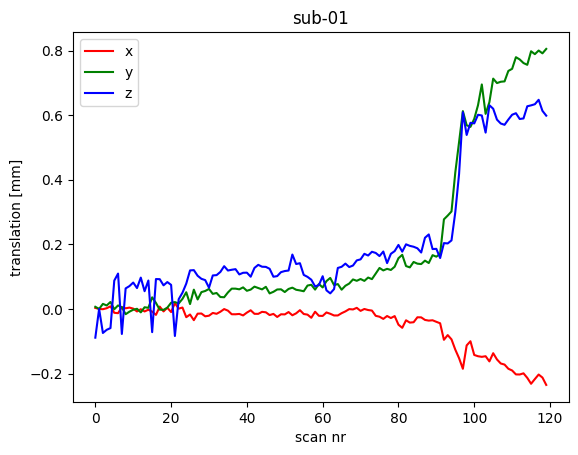

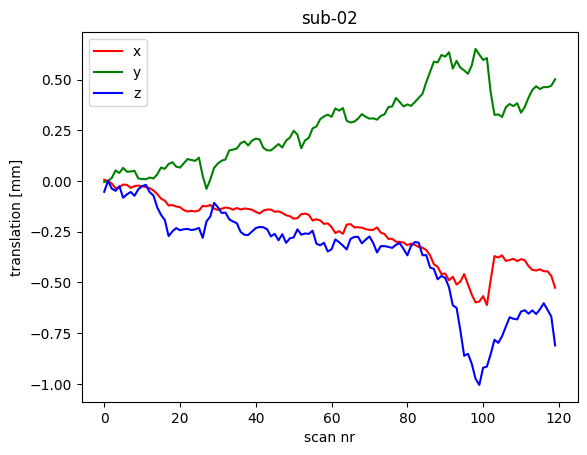

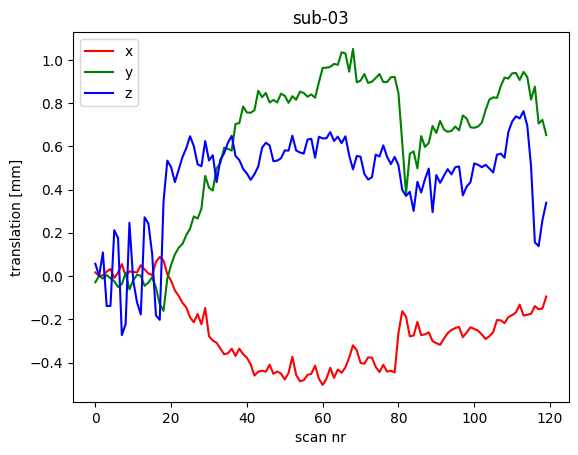

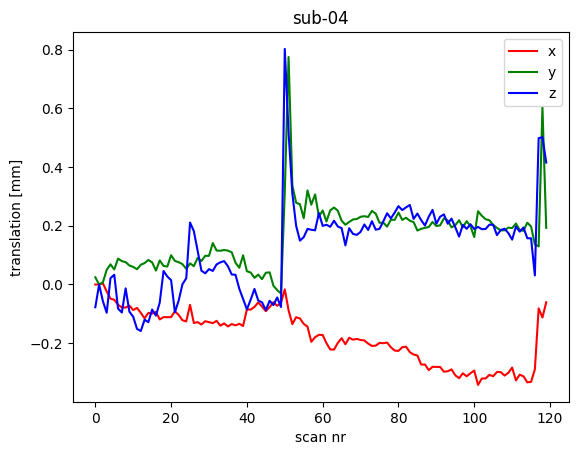

<Figure size 640x480 with 0 Axes>

In [37]:
vols = np.linspace(0, 119, 120)

sub_id = 0
plt.plot(vols, translation_params[0][sub_id,:,1], 'r-', label='x')
plt.plot(vols, translation_params[1][sub_id,:,1], 'g-', label='y')
plt.plot(vols, translation_params[2][sub_id,:,1], 'b-', label='z')
plt.ylabel('translation [mm]')
plt.xlabel('scan nr')
plt.title('sub-01')
plt.legend()
plt.figure()

sub_id = 1
plt.plot(vols, translation_params[0][sub_id,:,1], 'r-', label='x')
plt.plot(vols, translation_params[1][sub_id,:,1], 'g-', label='y')
plt.plot(vols, translation_params[2][sub_id,:,1], 'b-', label='z')
plt.title('sub-02')
plt.ylabel('translation [mm]')
plt.xlabel('scan nr')
plt.legend()
plt.figure()

sub_id = 2
plt.plot(vols, translation_params[0][sub_id,:,1], 'r-', label='x')
plt.plot(vols, translation_params[1][sub_id,:,1], 'g-', label='y')
plt.plot(vols, translation_params[2][sub_id,:,1], 'b-', label='z')
plt.title('sub-03')
plt.ylabel('translation [mm]')
plt.xlabel('scan nr')
plt.legend()
plt.figure()

sub_id = 3
plt.plot(vols, translation_params[0][sub_id,:,1], 'r-', label='x')
plt.plot(vols, translation_params[1][sub_id,:,1], 'g-', label='y')
plt.plot(vols, translation_params[2][sub_id,:,1], 'b-', label='z')
plt.title('sub-04')
plt.ylabel('translation [mm]')
plt.xlabel('scan nr')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

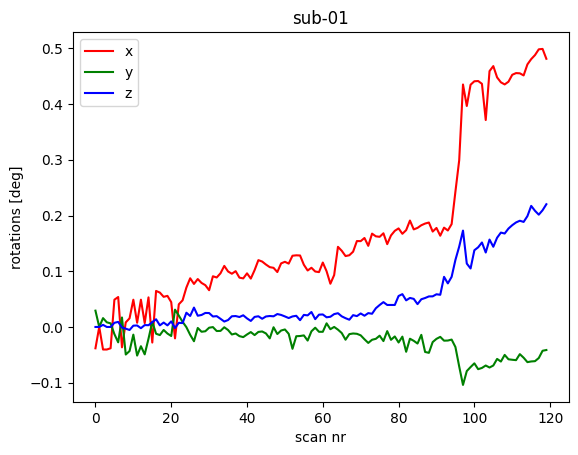

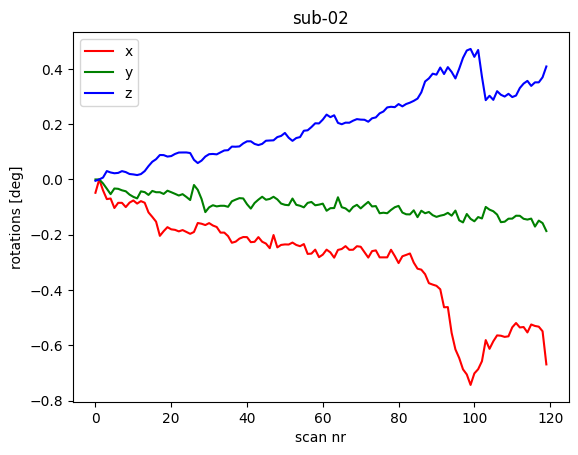

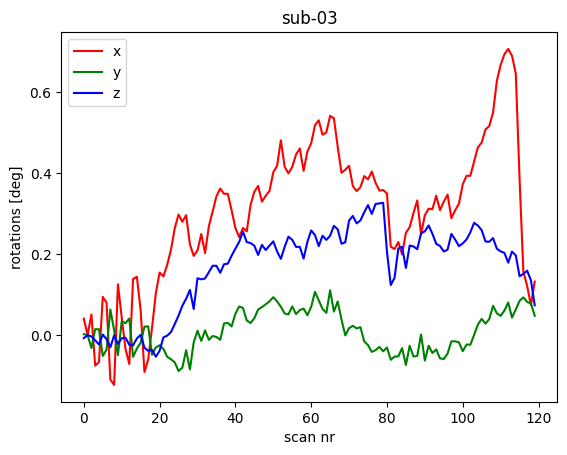

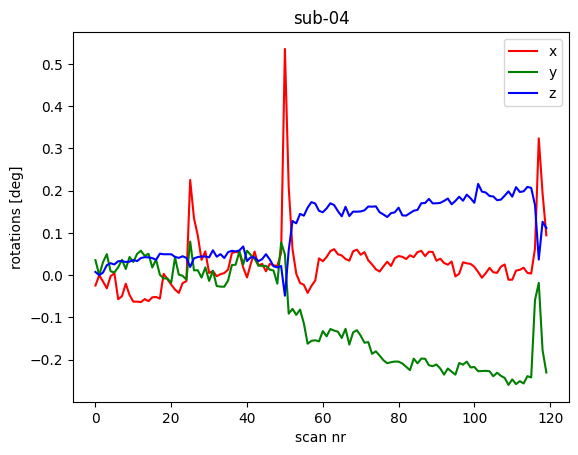

<Figure size 640x480 with 0 Axes>

In [36]:
vols = np.linspace(0, 119, 120)

sub_id = 0
plt.plot(vols, rotation_params[0][sub_id,:,1], 'r-', label='x')
plt.plot(vols, rotation_params[1][sub_id,:,1], 'g-', label='y')
plt.plot(vols, rotation_params[2][sub_id,:,1], 'b-', label='z')
plt.ylim()
plt.title('sub-01')
plt.ylabel('rotations [deg]')
plt.xlabel('scan nr')
plt.legend()
plt.figure()

sub_id = 1
plt.plot(vols, rotation_params[0][sub_id,:,1], 'r-', label='x')
plt.plot(vols, rotation_params[1][sub_id,:,1], 'g-', label='y')
plt.plot(vols, rotation_params[2][sub_id,:,1], 'b-', label='z')
plt.title('sub-02')
plt.ylabel('rotations [deg]')
plt.xlabel('scan nr')
plt.legend()
plt.figure()

sub_id = 2
plt.plot(vols, rotation_params[0][sub_id,:,1], 'r-', label='x')
plt.plot(vols, rotation_params[1][sub_id,:,1], 'g-', label='y')
plt.plot(vols, rotation_params[2][sub_id,:,1], 'b-', label='z')
plt.title('sub-03')
plt.ylabel('rotations [deg]')
plt.xlabel('scan nr')
plt.legend()
plt.figure()

sub_id = 3
plt.plot(vols, rotation_params[0][sub_id,:,1], 'r-', label='x')
plt.plot(vols, rotation_params[1][sub_id,:,1], 'g-', label='y')
plt.plot(vols, rotation_params[2][sub_id,:,1], 'b-', label='z')
plt.title('sub-04')
plt.ylabel('rotations [deg]')
plt.xlabel('scan nr')
plt.legend()
plt.figure()

## Temporal SNR

In [ ]:
simple_masked_bar1 = masker.fit_transform(bar1)
simple_masked_bar2 = masker.fit_transform(bar2)

simple_masked_bar1 = np.rot90(simple_masked_bar1)
simple_masked_bar2 = np.rot90(simple_masked_bar2)


#### "Raw" fMRI data (preprocessed but not filtered)

In [36]:
## Bar 1
# Calculate the mean signal intensity
mean_signal = np.mean(simple_masked_bar1, axis=1)

# Calculate the temporal standard deviation of the noise
std_noise = np.std(simple_masked_bar1, axis=1)

# Calculate the temporal SNR
tSNR_bar1_preproc = mean_signal / std_noise

## Bar 2
# Calculate the mean signal intensity
mean_signal = np.mean(simple_masked_bar2, axis=1)

# Calculate the temporal standard deviation of the noise
std_noise = np.std(simple_masked_bar2, axis=1)

# Calculate the temporal SNR
tSNR_bar2_preproc = mean_signal / std_noise

#### Detrended, demeaned,filtered fMRI data

In [45]:
## Bar 1
# Calculate the mean signal intensity
mean_signal = np.mean(masked_bar1, axis=1)

# Calculate the temporal standard deviation of the noise
std_noise = np.std(simple_masked_bar1, axis=1)

# Calculate the temporal SNR
tSNR_bar1_filt = mean_signal / std_noise

## Bar 2
# Calculate the mean signal intensity
mean_signal = np.mean(masked_bar2, axis=1)

# Calculate the temporal standard deviation of the noise
std_noise = np.std(simple_masked_bar2, axis=1)

# Calculate the temporal SNR
tSNR_bar2_filt = mean_signal / std_noise

<Figure size 640x480 with 0 Axes>

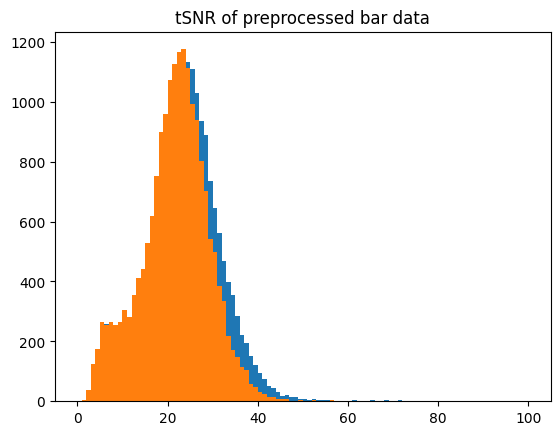

<Figure size 640x480 with 0 Axes>

In [52]:
plt.hist(tSNR_bar1_preproc, bins=100, range=[0,100]);
plt.hist(tSNR_bar2_preproc, bins=100, range=[0,100]);
plt.title('tSNR of preprocessed bar data')
plt.figure()

# plt.hist(tSNR_bar1_filt, bins=100, range=[0,1]);
# plt.hist(tSNR_bar2_filt, bins=100, range=[0,1]);
# plt.title('tSNR of filtered bar data')
# plt.figure()

Unmask and plot as overlay

In [49]:
unmasked_tSNR_bar1     = masker.inverse_transform(tSNR_bar1_preproc) 
unmasked_tSNR_bar2     = masker.inverse_transform(tSNR_bar2_preproc) 


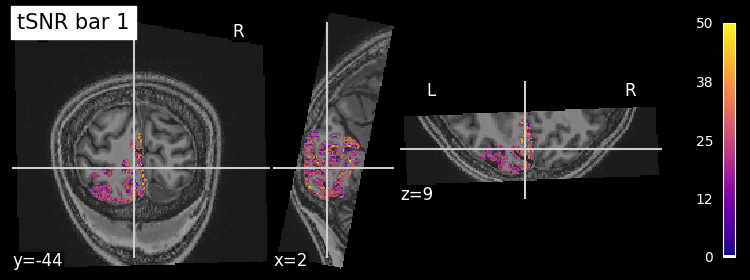

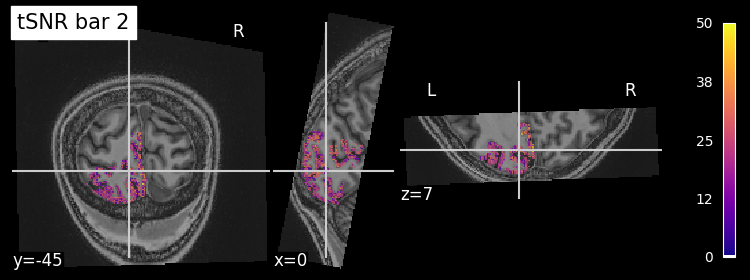

In [56]:
plot_roi(unmasked_tSNR_bar1,UNI,title="tSNR bar 1", colorbar=True, cmap = 'plasma', vmin=0, vmax=50)
plot_roi(unmasked_tSNR_bar2,UNI,title="tSNR bar 2", colorbar=True, cmap = 'plasma', vmin=0, vmax=50)

TODO: plot SNR as function of cortical depth

# pRF modeling: diagnostics and visualization
These have already been run on curta

In [32]:
f = open(pRF_param_fn,'rb')
x, y, sigma, total_rsq, polar, ecc = pickle.load(f)
f.close()

## Plot results

Extract parameters from iterative fit result

Use in case of wanting to edit rsq threshold of projected surfaces:

In [23]:
unmasked_x     = masker.inverse_transform(x) 
unmasked_y     = masker.inverse_transform(y) 
unmasked_sigma = masker.inverse_transform(sigma) 
unmasked_pol   = masker.inverse_transform(polar) 
unmasked_ecc   = masker.inverse_transform(ecc) 
unmasked_rsq   = masker.inverse_transform(total_rsq) 

unmasked_meanFunc     = masker.inverse_transform(masked_meanFunc) 


(array([ 67., 213., 300., 308., 361., 386., 405., 393., 465., 372., 420.,
        383., 387., 279., 336., 306., 272., 278., 212., 271., 252., 197.,
        231., 209., 180., 224., 194., 167., 206., 216., 154., 179., 216.,
        195., 152., 209., 220., 145., 149., 189., 200.,  81.,  75., 190.,
        162.,  29.,  19., 128., 207.,  11.,   9.,  40., 147.,  43.,   4.,
         15.,  53., 132.,  18.,   2.,  13.,  44.,  74.,  17.,   1.,   9.,
         20.,  77.,   8.,   3.,   8.,  15.,  65.,  10.,   5.,   0.,   7.,
         50.,   9.,   4.,   0.,   1.,   7.,  45.,   5.,   2.,   3.,   0.,
         13.,  63.,   5.,   3.,   4.,   3.,  30., 151.,   9.,   7.,   4.,
         25.]),
 array([0.        , 0.06497308, 0.12994617, 0.19491925, 0.25989234,
        0.32486542, 0.3898385 , 0.45481159, 0.51978467, 0.58475776,
        0.64973084, 0.71470392, 0.77967701, 0.84465009, 0.90962318,
        0.97459626, 1.03956934, 1.10454243, 1.16951551, 1.2344886 ,
        1.29946168, 1.36443476, 1.42940785, 1.

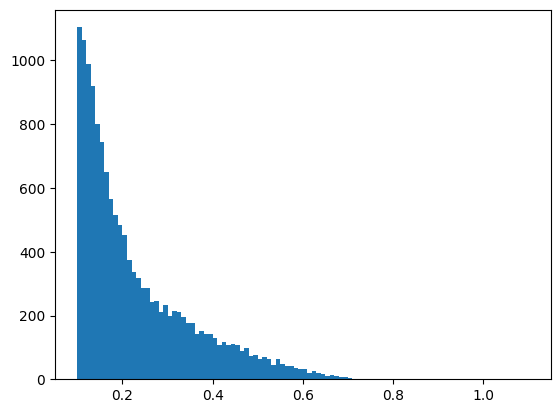

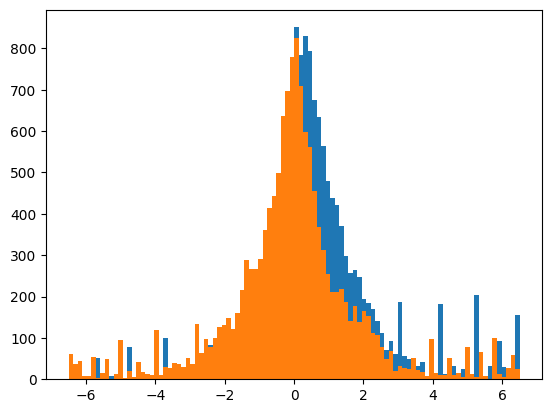

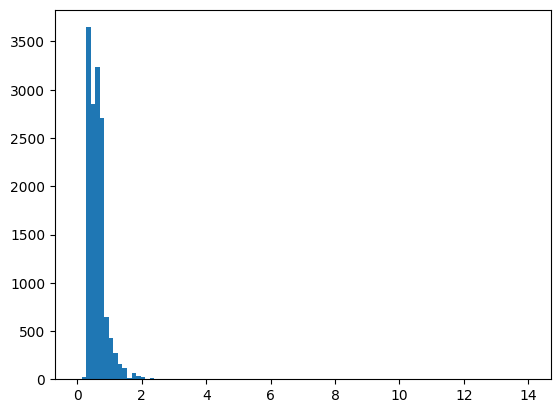

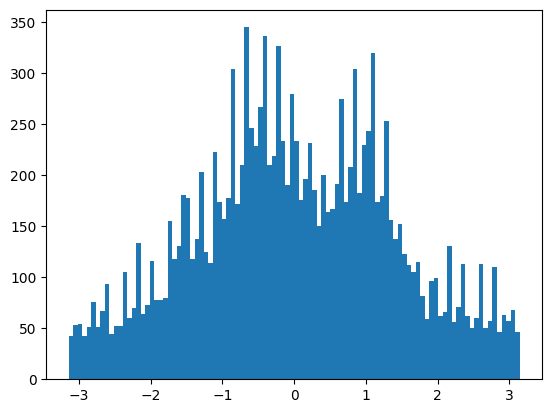

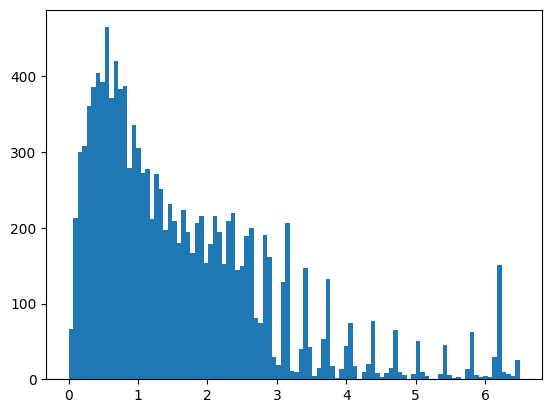

In [21]:
plt.hist(total_rsq, bins=100, range=[0.1,1.1]);
plt.figure()
plt.hist(x[total_rsq>0.1], bins=100, range=[-max_ecc_deg,max_ecc_deg]);
plt.hist(y[total_rsq>0.1], bins=100, range=[-max_ecc_deg,max_ecc_deg]);
plt.figure()
plt.hist(sigma[total_rsq>0.1],bins=100, range=[0,14])
plt.figure()
plt.hist(polar[total_rsq>0.1],bins=100, range=[-np.pi,np.pi])
plt.figure()
plt.hist(ecc[total_rsq>0.1],bins=100, range=[0,max_ecc_deg])
#plt.hist(gfS.iterative_search_params[:,2], bins=100, range=[0,20]);

#plt.stairs(counts, bins)

Visualize ecc

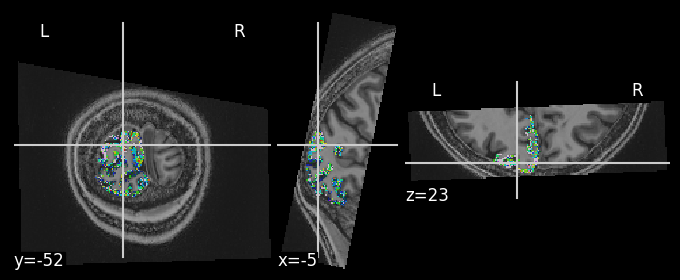

In [24]:
plot_roi(unmasked_ecc,UNI)

## PRF size plots

Load data

In [222]:
f = open(df_layers_fn,'rb')
df_equivol_per_ecc,df_equidist_per_ecc,df_equivol_per_depth,df_equidist_per_depth = pickle.load(f)
f.close()

In [223]:
df_equivol_per_ecc.head()

sub id hem  ecc                                           pRF size  \
0  sub-01  lh    2  [0.4987410316297359, 0.5161500476393547, 0.551...   
1  sub-01  lh    3  [0.4677871381595036, 0.5762771956402354, 0.577...   
2  sub-01  lh    4  [0.6478824542069708, 0.7191165476226953, 0.668...   
3  sub-01  lh    5  [0.9492415937366123, 0.6440269500599042, 0.713...   
4  sub-01  rh    2  [0.5875375300081681, 0.5675986102799586, 0.558...   

                                               depth  
0  [0.2, 0.30000000000000004, 0.4000000000000001,...  
1  [0.2, 0.30000000000000004, 0.4000000000000001,...  
2  [0.2, 0.30000000000000004, 0.4000000000000001,...  
3  [0.2, 0.30000000000000004, 0.4000000000000001,...  
4  [0.2, 0.30000000000000004, 0.4000000000000001,...

In [224]:
df_equidist_per_ecc.head()

sub id hem  ecc                                           pRF size  \
0  sub-01  lh    2  [0.5116753872473524, 0.5142155308717237, 0.542...   
1  sub-01  lh    3  [0.49944100791208246, 0.5868729134732202, 0.57...   
2  sub-01  lh    4  [0.6847025087280585, 0.5948421840662571, 0.770...   
3  sub-01  lh    5  [0.9479253956476252, 0.7044411287775396, 0.751...   
4  sub-01  rh    2  [0.5540479532185917, 0.56509132930686, 0.55429...   

                                               depth  
0  [0.2, 0.30000000000000004, 0.4000000000000001,...  
1  [0.2, 0.30000000000000004, 0.4000000000000001,...  
2  [0.2, 0.30000000000000004, 0.4000000000000001,...  
3  [0.2, 0.30000000000000004, 0.4000000000000001,...  
4  [0.2, 0.30000000000000004, 0.4000000000000001,...

In [225]:
df_equivol_per_depth.head()

sub id hem  depth                                           pRF size  \
0  sub-01  lh    0.2  [1.3590436025653505, 0.8227482046541554, 0.412...   
1  sub-01  lh    0.3  [0.5990288714810548, 0.4136226896178523, 0.407...   
2  sub-01  lh    0.4  [0.4104355983377144, 0.40509473521004824, 0.50...   
3  sub-01  lh    0.5  [0.6010898847311695, 0.40748629720250057, 0.41...   
4  sub-01  lh    0.6  [0.5773868091087919, 0.6000874293326045, 0.596...   

                                                 ecc  \
0  [1.919522362431736, 6.583066594319912, 0.83936...   
1  [5.788106118439211, 1.5019056121505634, 1.0467...   
2  [1.6635015990595432, 0.7804981448508602, 1.612...   
3  [0.3712806189152803, 0.8575873360303747, 1.505...   
4  [3.093186368254692, 1.1512256907819984, 1.0906...   

                                                 rsq  
0  [0.07894468789829745, 0.1014126782241278, 0.19...  
1  [0.053795419614565354, 0.068648623798795, 0.11...  
2  [0.1029914314157151, 0.09077278844254588, 0.20...  
3  [0.09866456285764835, 0.3905205493916952, 0.07...  
4  [0.15023208106880304, 0.1937825836635666, 0.25...

In [226]:
df_equidist_per_depth.head()

sub id hem  depth                                           pRF size  \
0  sub-01  lh    0.2  [0.40842250329902335, 0.6015337784381825, 0.50...   
1  sub-01  lh    0.3  [0.40879775673472446, 0.40902639369459337, 0.9...   
2  sub-01  lh    0.4  [0.5011564688381267, 0.5990288714810548, 1.376...   
3  sub-01  lh    0.5  [0.6014646792132888, 0.5946593509813104, 0.410...   
4  sub-01  lh    0.6  [0.6010898847311695, 0.5961908207537935, 0.407...   

                                                 ecc  \
0  [1.0331119139733775, 0.5473403446964902, 6.580...   
1  [0.5949831762437316, 3.40753105045825, 0.94632...   
2  [1.6125991757506744, 5.788106118439211, 4.3552...   
3  [0.8056578543929804, 0.24948805666888146, 1.66...   
4  [0.3712806189152803, 1.0906611227763197, 0.857...   

                                                 rsq  
0  [0.1217198861280534, 0.3908460990749416, 0.100...  
1  [0.16606093435466618, 0.17548806792289284, 0.1...  
2  [0.20359984956739519, 0.053795419614565354, 0....  
3  [0.10250775063657469, 0.1501495057793435, 0.10...  
4  [0.09866456285764835, 0.25955553961194033, 0.3...

### Equidistant layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Extract lh and rh sigma and ecc values at chosen rsq threshold

In [502]:
rsq_thresh = 0.3

Create a dataframe to save intercept and slope stats

In [520]:
subs = [['sub-01']*8,['sub-02']*8,['sub-03']*8,['sub-04']*8]
subs = list(itertools.chain(*subs))

depth = np.arange(0.2, 1.0, 0.1).tolist()
depths = depth*4

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


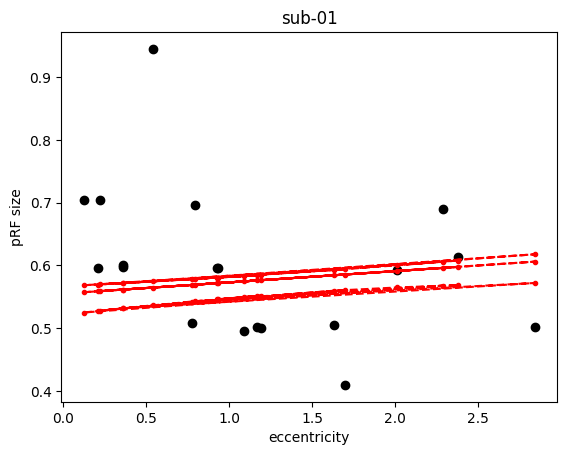

Intercept: 0.5548021297716703
t = 32.24, p = 0.00000
Slope: 0.01797455455252077
t = 2.12, p = 0.03398
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


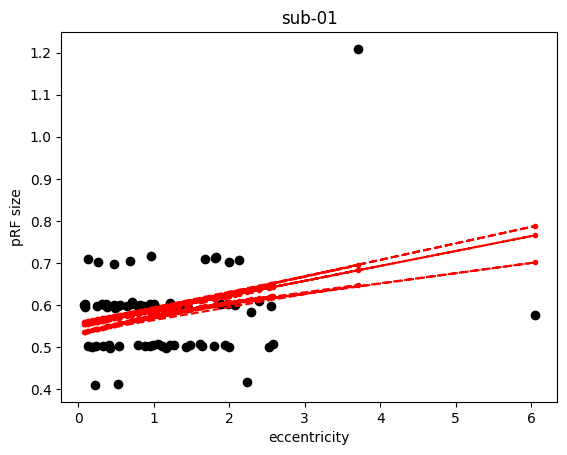

Intercept: 0.5511177023544808
t = 55.93, p = 0.00000
Slope: 0.03543522625217307
t = 5.34, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


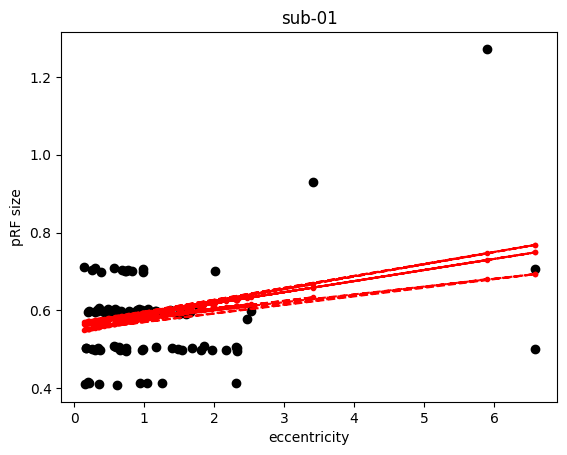

Intercept: 0.5613634810901782
t = 70.44, p = 0.00000
Slope: 0.028490144624876194
t = 5.50, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


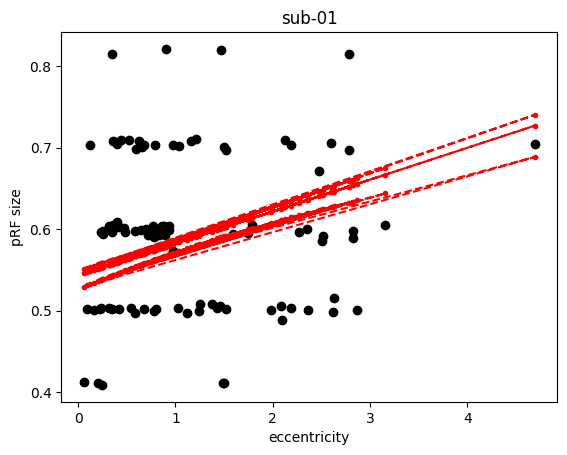

Intercept: 0.5433953568411016
t = 63.30, p = 0.00000
Slope: 0.03916802415309931
t = 7.17, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


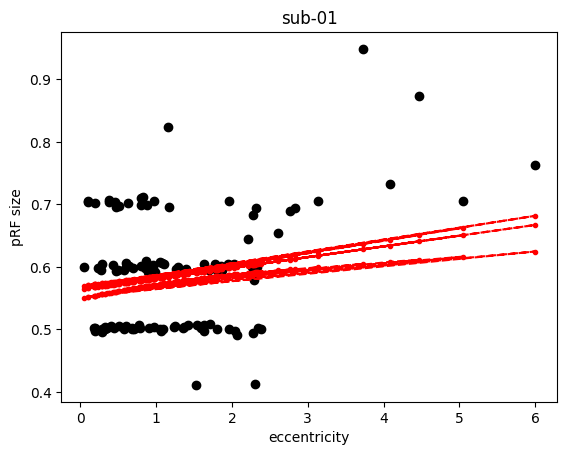

Intercept: 0.5642857462867544
t = 75.17, p = 0.00000
Slope: 0.017147683990626293
t = 3.80, p = 0.00015
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


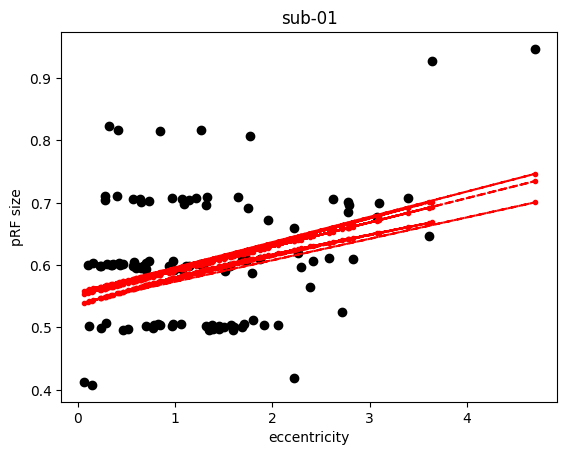

Intercept: 0.5516222116719384
t = 70.61, p = 0.00000
Slope: 0.03897161105332429
t = 8.12, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


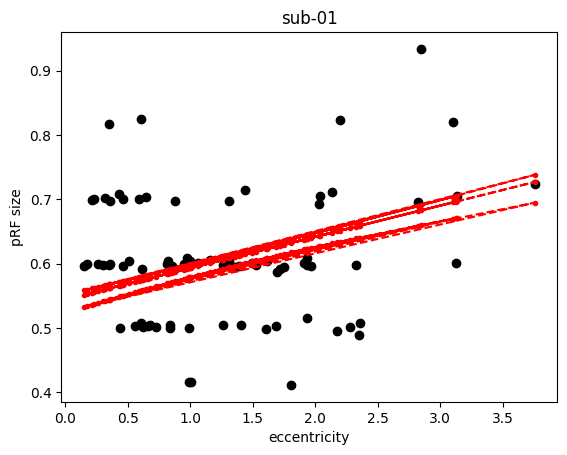

Intercept: 0.5447056000804682
t = 51.83, p = 0.00000
Slope: 0.04849541387793862
t = 7.99, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


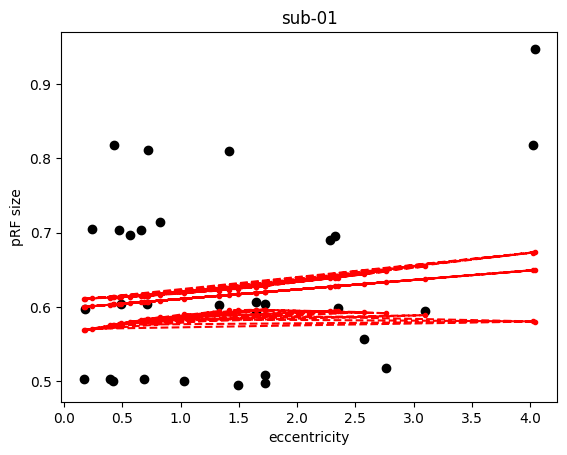

Intercept: 0.5981083337026665
t = 33.88, p = 0.00000
Slope: 0.012788429031279804
t = 1.07, p = 0.28249
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


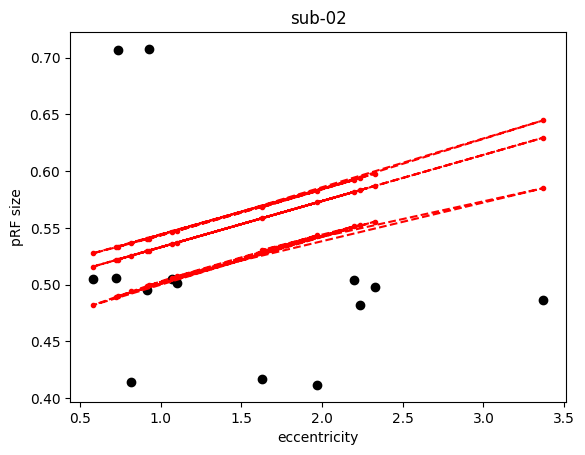

Intercept: 0.49231802694869053
t = 23.30, p = 0.00000
Slope: 0.04067605506621175
t = 4.13, p = 0.00004
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


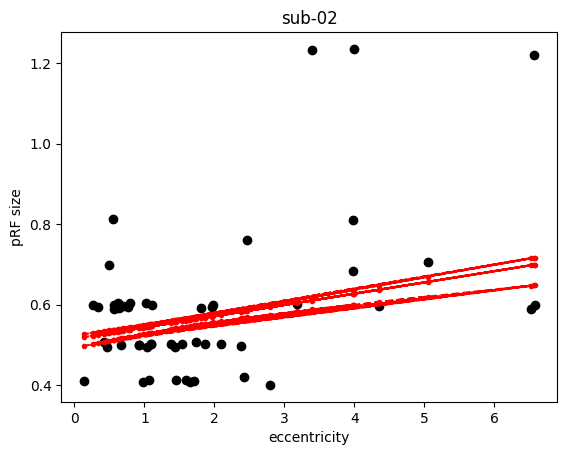

Intercept: 0.5154791301426586
t = 44.35, p = 0.00000
Slope: 0.027935978042764403
t = 5.43, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


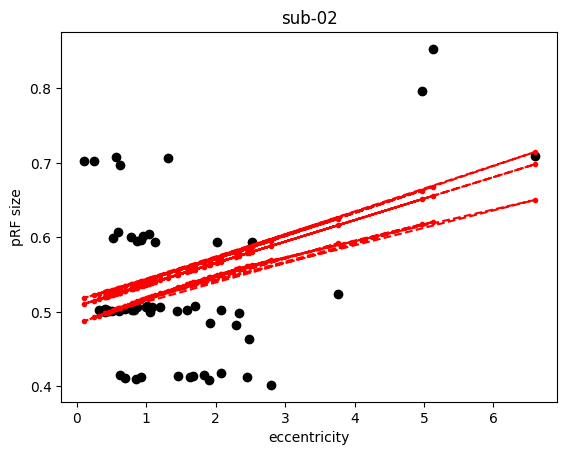

Intercept: 0.5079066701023535
t = 41.20, p = 0.00000
Slope: 0.02885242218493543
t = 5.92, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


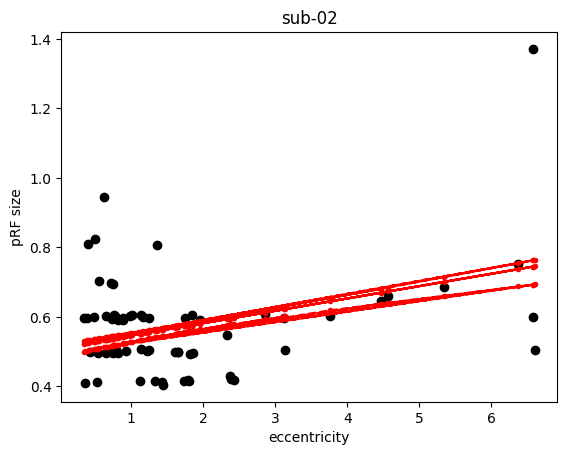

Intercept: 0.5106428858265573
t = 39.29, p = 0.00000
Slope: 0.03556931314015635
t = 6.63, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


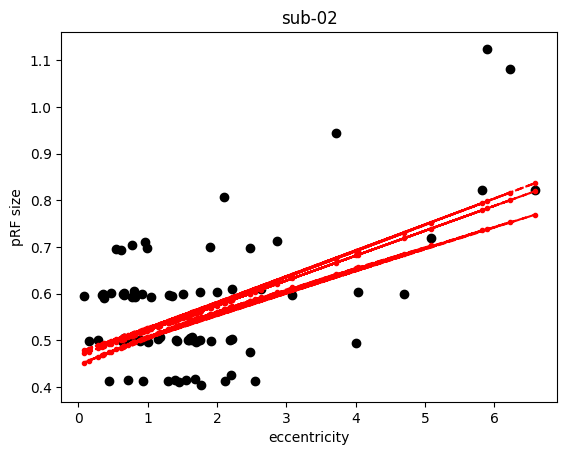

Intercept: 0.4674186067252477
t = 45.04, p = 0.00000
Slope: 0.05344411839417189
t = 10.63, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


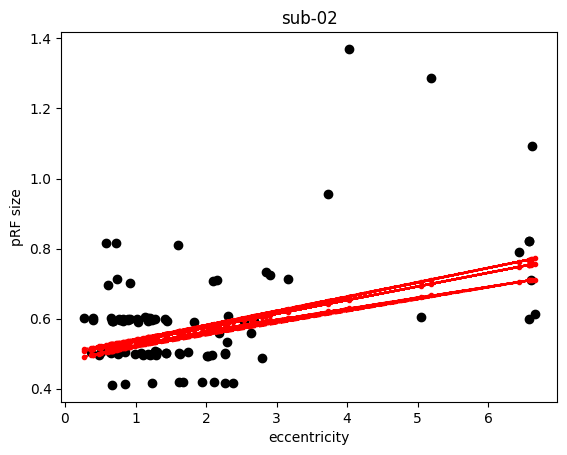

Intercept: 0.49670161535411345
t = 53.43, p = 0.00000
Slope: 0.03901611735508178
t = 8.79, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


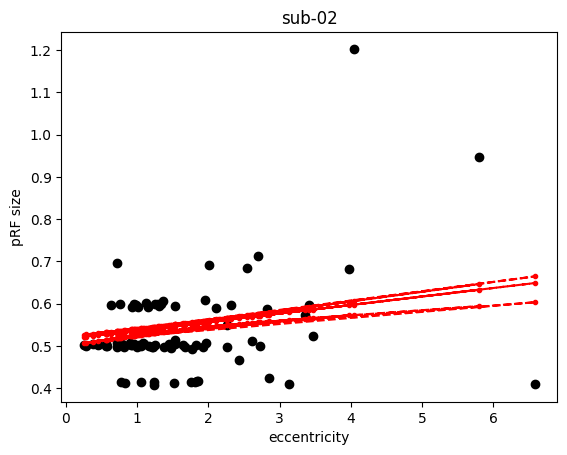

Intercept: 0.516665068760223
t = 60.24, p = 0.00000
Slope: 0.02011177246291438
t = 4.51, p = 0.00001
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


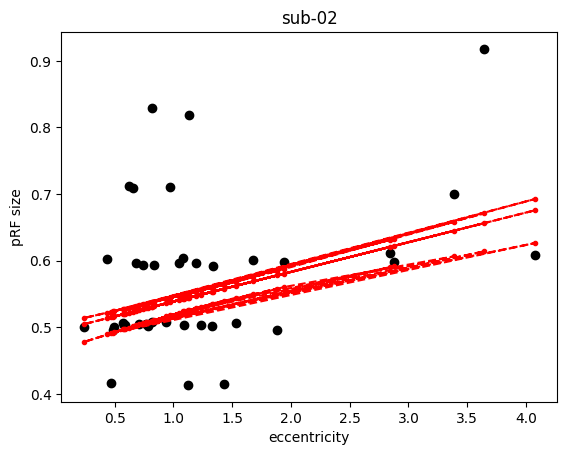

Intercept: 0.49395169286722646
t = 32.36, p = 0.00000
Slope: 0.04454978992819243
t = 5.10, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


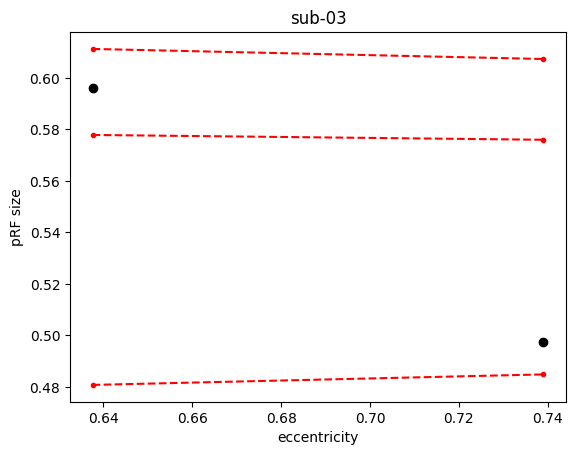

Intercept: 0.5895677590145307
t = 8.04, p = 0.00000
Slope: -0.018411763445605023
t = -0.38, p = 0.70216
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


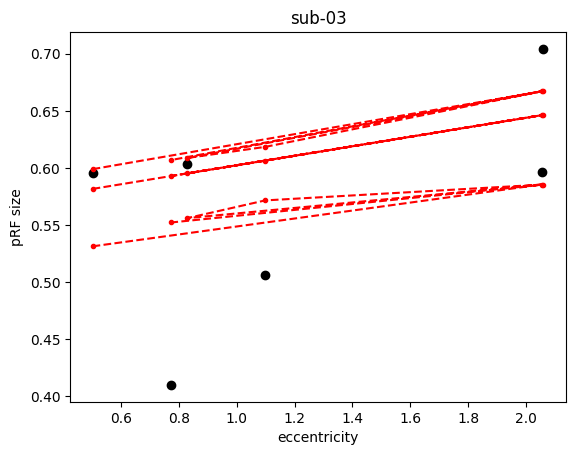

Intercept: 0.560781322588131
t = 15.06, p = 0.00000
Slope: 0.04156121067480076
t = 1.47, p = 0.14192
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


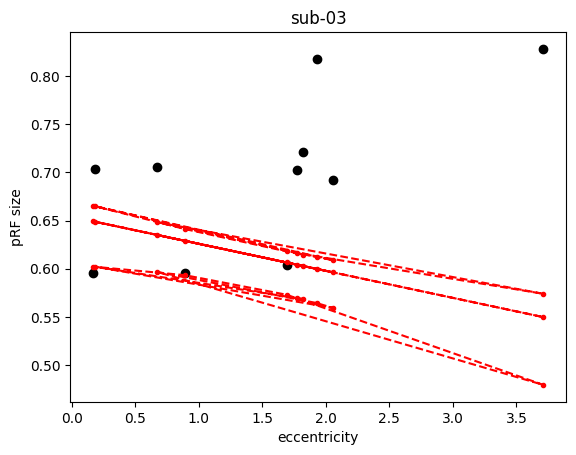

Intercept: 0.6538943345786442
t = 25.42, p = 0.00000
Slope: -0.02807166261405773
t = -2.03, p = 0.04264
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


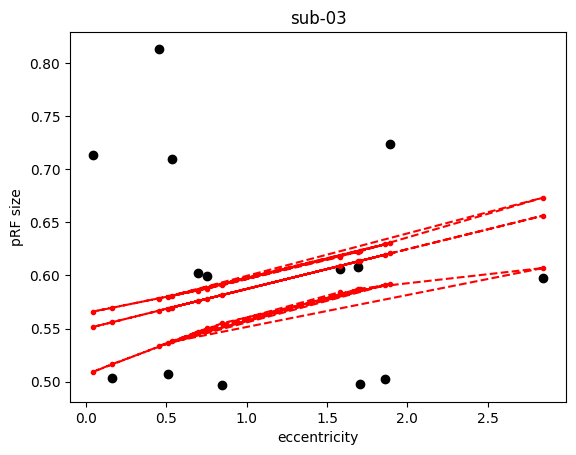

Intercept: 0.5498291940997087
t = 24.91, p = 0.00000
Slope: 0.03744572104220457
t = 2.61, p = 0.00895
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


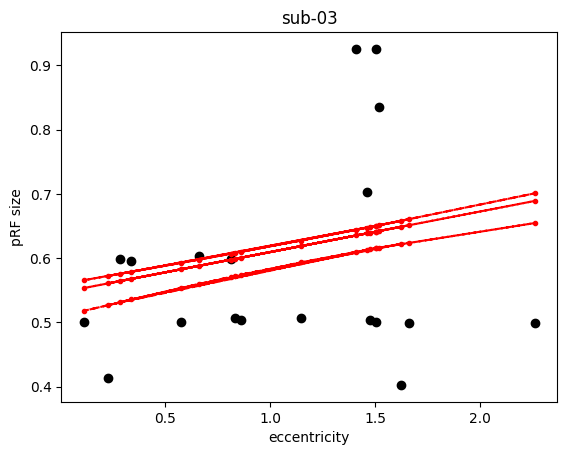

Intercept: 0.5462827450862454
t = 28.73, p = 0.00000
Slope: 0.0630965279883191
t = 5.46, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


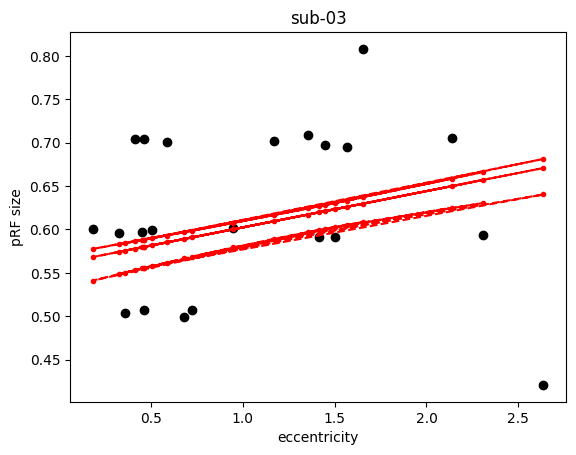

Intercept: 0.5604889910371474
t = 37.49, p = 0.00000
Slope: 0.0418579308810698
t = 4.91, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


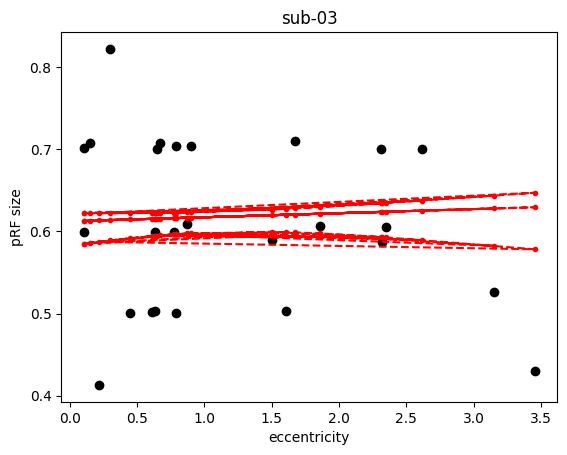

Intercept: 0.612320826690114
t = 41.01, p = 0.00000
Slope: 0.00496473503351926
t = 0.48, p = 0.63355
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


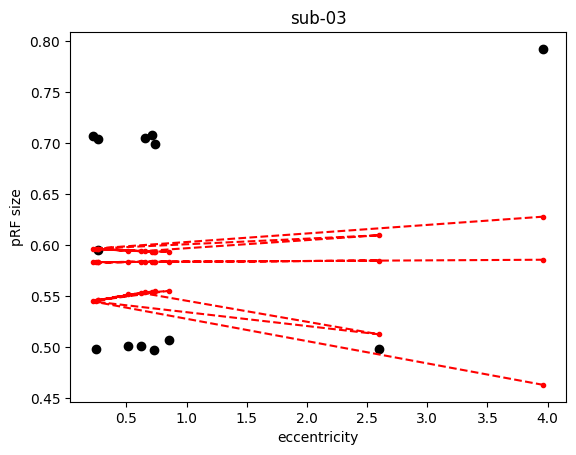

Intercept: 0.5830713823939866
t = 25.59, p = 0.00000
Slope: 0.0006422699161660467
t = 0.03, p = 0.97414
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


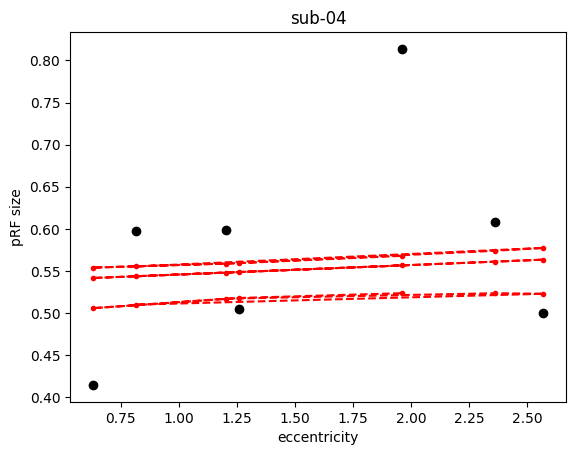

Intercept: 0.5345285729917649
t = 23.11, p = 0.00000
Slope: 0.011240428528816397
t = 0.94, p = 0.34653
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


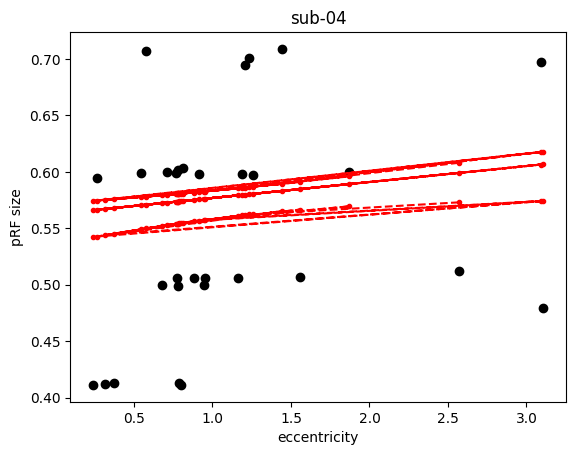

Intercept: 0.5627049773131904
t = 41.57, p = 0.00000
Slope: 0.014144460658688887
t = 1.84, p = 0.06567
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


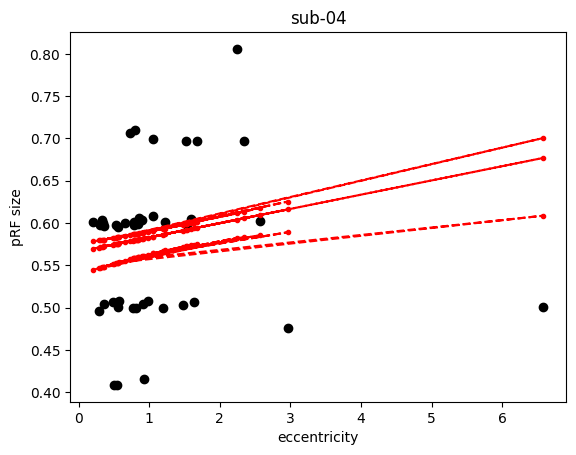

Intercept: 0.5662137761481121
t = 41.34, p = 0.00000
Slope: 0.01684726986812451
t = 2.57, p = 0.01017
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


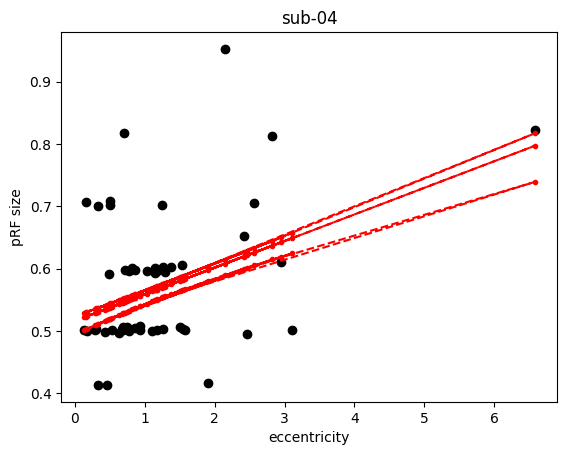

Intercept: 0.5159035291136641
t = 47.01, p = 0.00000
Slope: 0.042731193311119305
t = 7.81, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


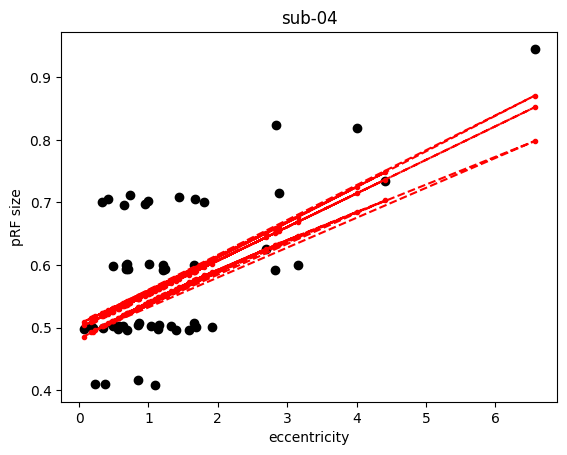

Intercept: 0.49974956569554196
t = 53.89, p = 0.00000
Slope: 0.053638966045526315
t = 10.46, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


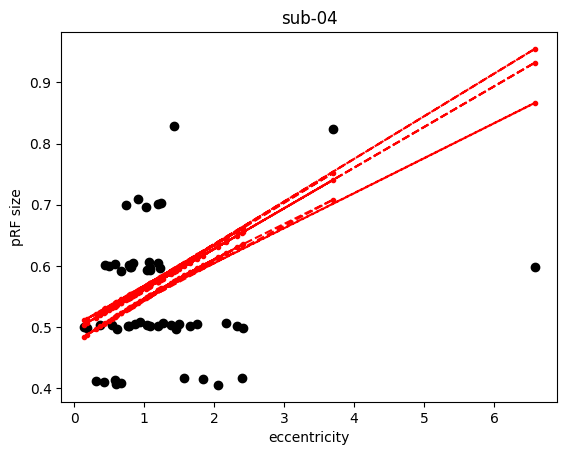

Intercept: 0.49484754751123183
t = 45.73, p = 0.00000
Slope: 0.0663948553467825
t = 10.73, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


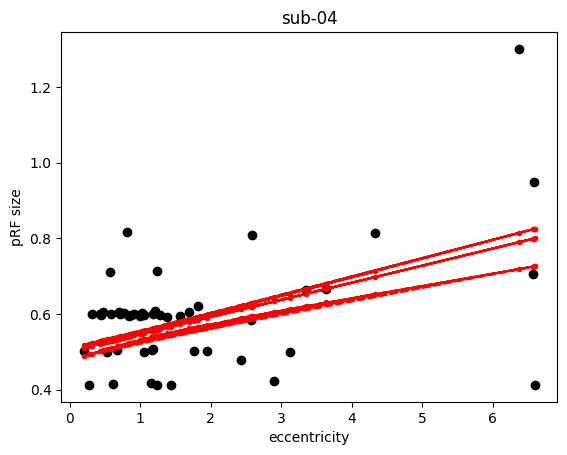

Intercept: 0.502019477205138
t = 41.09, p = 0.00000
Slope: 0.045168589281484296
t = 6.51, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


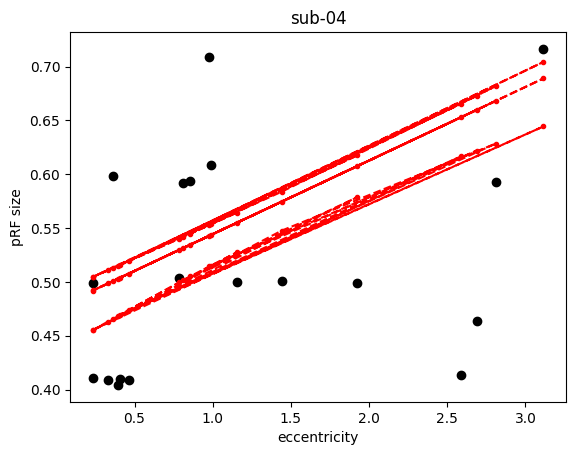

Intercept: 0.4760391595923479
t = 23.16, p = 0.00000
Slope: 0.06837607181183203
t = 6.37, p = 0.00000


In [521]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equidist_per_depth.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth['hem'] == 'lh') & 
                                    (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equidist_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equidist_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equidist_per_depth.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth['hem'] == 'rh') & 
                                    (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equidist_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equidist_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.2)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.atleast_2d(X_test[:,1]).T, y_test, 'ko')
        plt.plot(np.atleast_2d(X_test[:,1]).T, y_pred, 'r--.')
        plt.plot(np.atleast_2d(X_test[:,1]).T, quantiles['mean_ci_lower'].values, 'r--.')
        plt.plot(np.atleast_2d(X_test[:,1]).T, median['mean_ci_upper'].values, 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id])
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + 2*slope

    #     # print the quantiles
    #     print("95% quantiles:")
    #     print(quantiles.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

    #     # print the median
    #     print("Median:")
    #     print(median.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

        # save stats to df
        idx=df_pRFxecc_stats_equidist.loc[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_equidist.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        df_pRFxecc_stats_equidist.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])

        df_pRFxecc_stats_equidist.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        df_pRFxecc_stats_equidist.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])

        df_pRFxecc_stats_equidist.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        
    

    
    
    

TODO: eccentricity bins and take avg pRF size in each bin, compute linear regression to these points, bootstrapping

In [522]:
df_pRFxecc_stats_equidist.head()


sub id  depth  intercept     slope         intercept-stats  \
0  sub-01    0.2   0.554802  0.017975  t = 32.24, p = 0.00000   
1  sub-01    0.3   0.551118  0.035435  t = 55.93, p = 0.00000   
2  sub-01    0.4   0.561363  0.028490  t = 70.44, p = 0.00000   
3  sub-01    0.5   0.543395  0.039168  t = 63.30, p = 0.00000   
4  sub-01    0.6   0.564286  0.017148  t = 75.17, p = 0.00000   

             slope-stats  pRF@2deg  
0  t = 2.12, p = 0.03398  0.590751  
1  t = 5.34, p = 0.00000  0.621988  
2  t = 5.50, p = 0.00000  0.618344  
3  t = 7.17, p = 0.00000  0.621731  
4  t = 3.80, p = 0.00015  0.598581

#### Plot estimated pRF size at 2 deg

[-0.04794679  0.0931693   0.58407084]
R2 quadratic: 0.38640683856900926
R2 linear: 0.36582466047782536


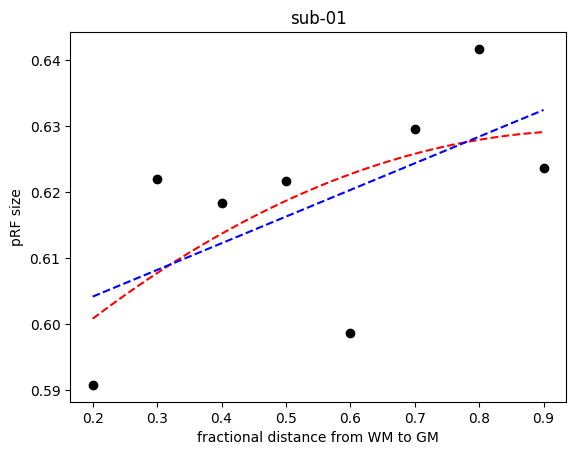

[ 0.01417363 -0.01401386  0.57535034]
R2 quadratic: 0.008850964312973053
R2 linear: 0.0020921232444931492


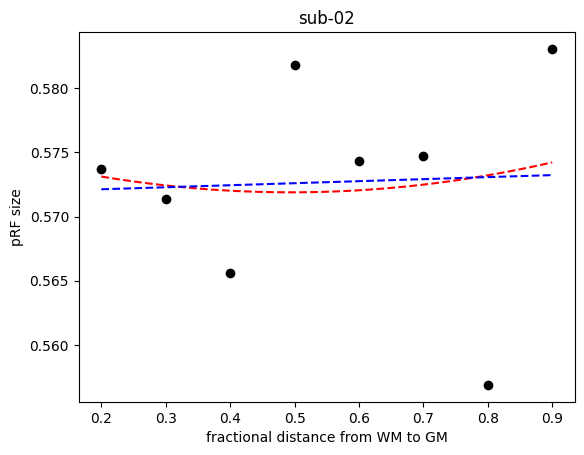

[-0.58690158  0.68132165  0.45142396]
R2 quadratic: 0.6206026200102264
R2 linear: 0.052626391384182236


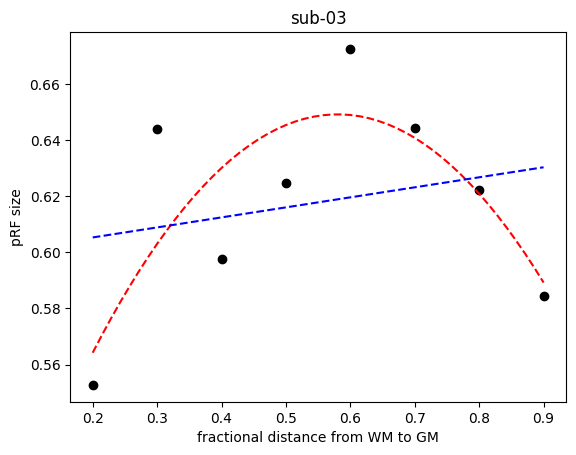

[-0.20990958  0.28877379  0.5143286 ]
R2 quadratic: 0.7274018629690158
R2 linear: 0.4766030062413982


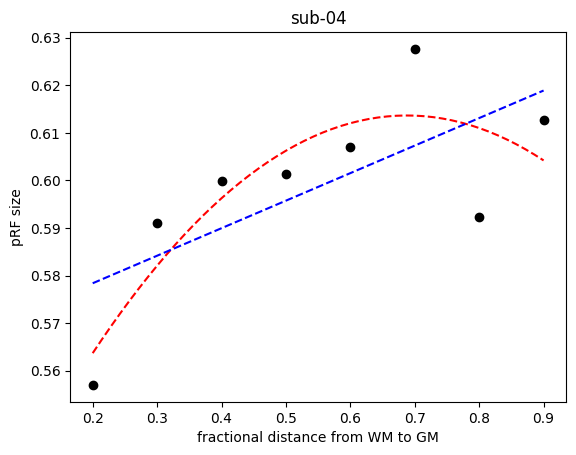

In [523]:
for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equidist.loc[idx,'pRF@2deg'].values
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    x = np.linspace(0.2, 0.9, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    plt.plot(depth,pRF_2deg,'ko')
    plt.plot(x,y_quadratic,'r--')
    plt.plot(x,y_linear,'b--')
    plt.xlabel('fractional distance from WM to GM')
    plt.ylabel('pRF size')
    plt.title(subject_list[sub_id])
    plt.show()
    
    
#     df_pRFxecc_stats_equidist.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

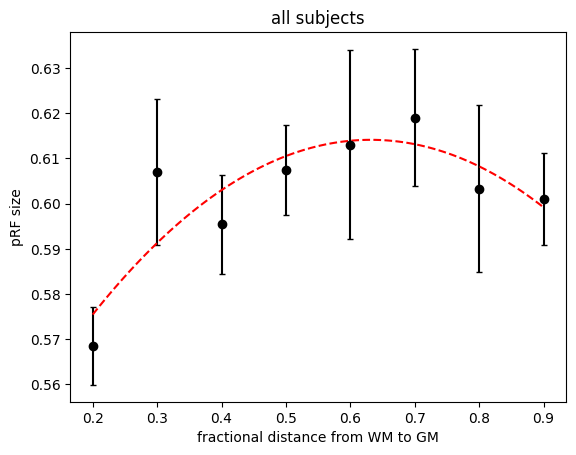

In [591]:
idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equidist.loc[idx,'depth'].values
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id])].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist.loc[idx,'pRF@2deg'].values

    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_equidist.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equidist.loc[:,'pRF@2deg'].values



# # Plot the line of best fit
# fig,ax = plt.subplots()
# # ax.scatter(depth, pRF_2deg[:,0], c='red', label='y_1')
# # ax.scatter(depth, pRF_2deg[:,1], c='green', label='y_2')
# # ax.scatter(depth, pRF_2deg[:,2], c='blue', label='y_3')
# # ax.scatter(depth, pRF_2deg[:,3], c='black', label='y_4')
# # ax.plot(X_plot, y_plot[:,0], c='red', label='Predictions for y_1')
# # ax.plot(X_plot, y_plot[:,1], c='green', label='Predictions for y_2')
# # ax.plot(X_plot, y_plot[:,2], c='blue', label='Predictions for y_3')
# # ax.plot(X_plot, y_plot[:,3], c='black', label='Predictions for y_4')
# # plt.xlabel("Independent variable")
# # plt.ylabel("Dependent variable")
# plt.legend()
# plt.show()

# plot the model
#plt.plot(depth,pRF_2deg.mean(axis=1),'ko')

plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)

plt.plot(X_plot,y_mean,'r--')
# plt.plot(x,y_linear,'b--')
plt.xlabel('fractional distance from WM to GM')
plt.ylabel('pRF size')
plt.title('all subjects')
plt.show()


In [588]:
stats.sem(pRF_2deg,axis=1)

array([0.00867044, 0.01610786, 0.01095302, 0.00999212, 0.02097234,
       0.01522334, 0.01850039, 0.01021776])

### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Extract lh and rh sigma and ecc values at chosen rsq threshold

In [507]:
rsq_thresh = 0.3

Create a dataframe to save intercept and slope stats

In [508]:
subs = [['sub-01']*8,['sub-02']*8,['sub-03']*8,['sub-04']*8]
subs = list(itertools.chain(*subs))

depth = np.arange(0.2, 1.0, 0.1).tolist()
depths = depth*4

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


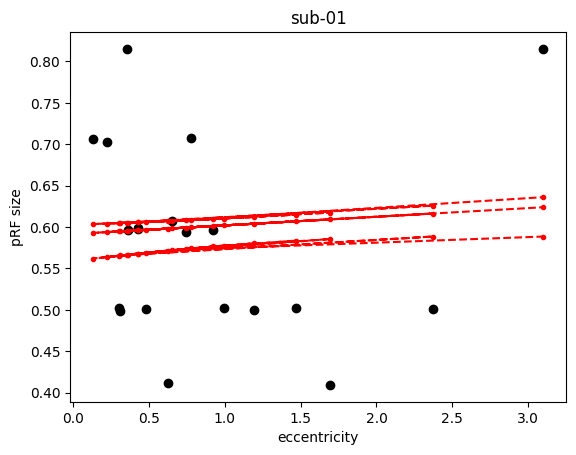

Intercept: 0.5915950212155223
t = 35.82, p = 0.00000
Slope: 0.010441087648819517
t = 1.29, p = 0.19600
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


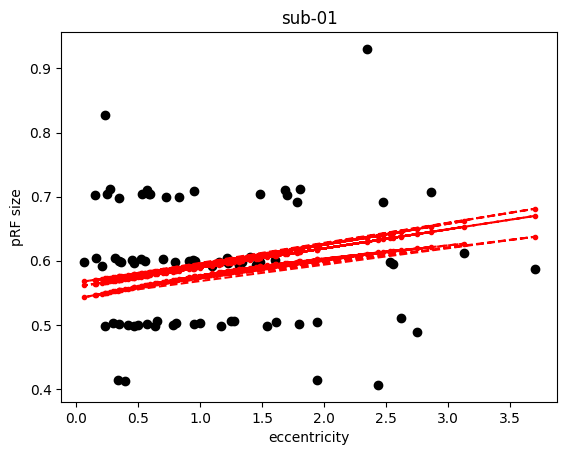

Intercept: 0.5595695289711952
t = 57.96, p = 0.00000
Slope: 0.02985420845273496
t = 4.84, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


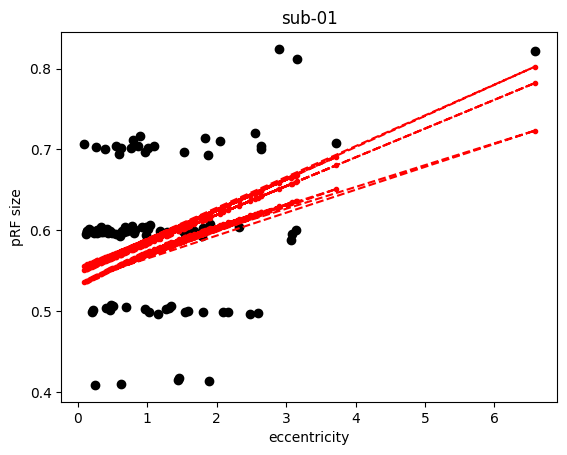

Intercept: 0.5479124250951202
t = 66.50, p = 0.00000
Slope: 0.035575757657036855
t = 6.53, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


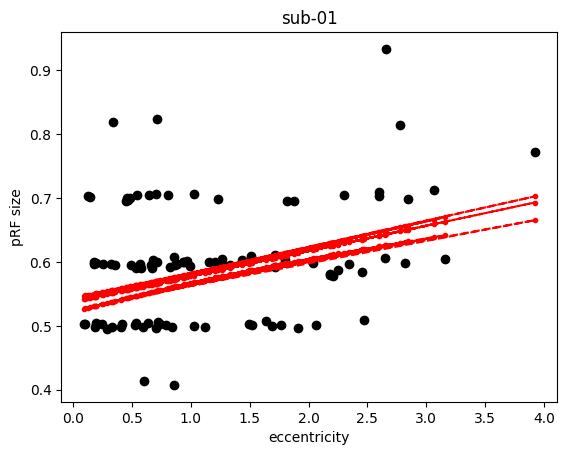

Intercept: 0.5382589828294736
t = 66.36, p = 0.00000
Slope: 0.039498309329048964
t = 7.95, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


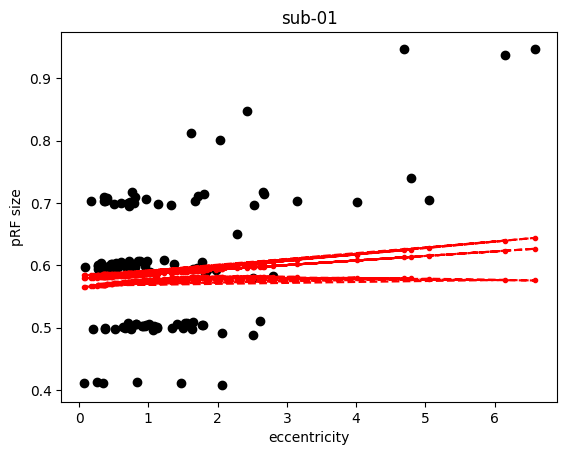

Intercept: 0.5786519021953993
t = 77.10, p = 0.00000
Slope: 0.007287819885946428
t = 1.52, p = 0.12737
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


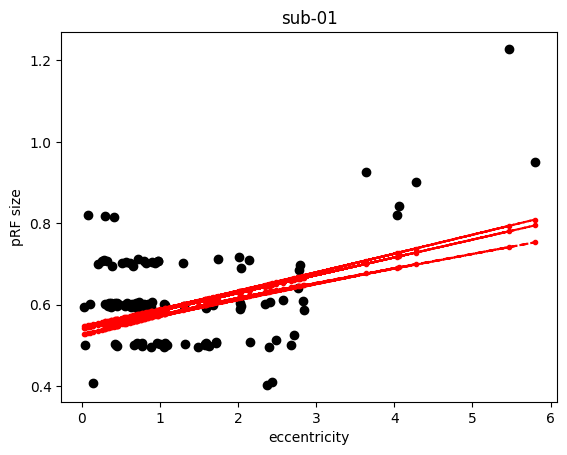

Intercept: 0.5412045987727294
t = 68.86, p = 0.00000
Slope: 0.043737080545257795
t = 9.53, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


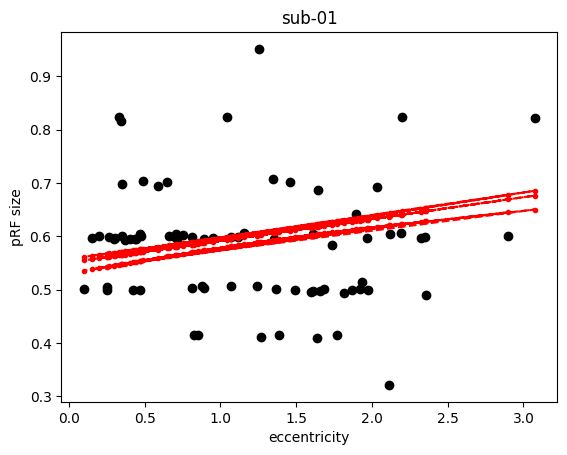

Intercept: 0.55084577195195
t = 52.60, p = 0.00000
Slope: 0.04081904035727604
t = 6.32, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


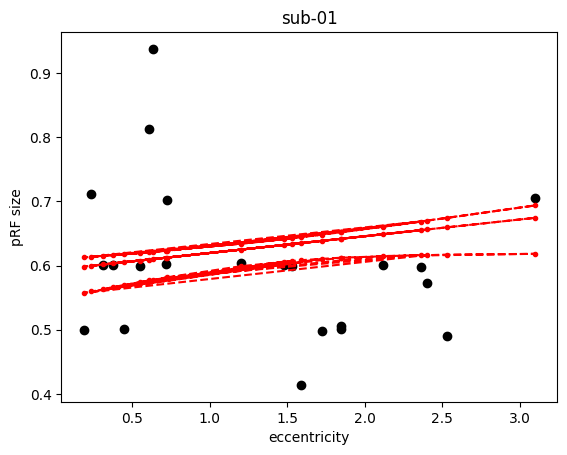

Intercept: 0.5936745016620542
t = 25.65, p = 0.00000
Slope: 0.026089819603853565
t = 1.81, p = 0.06986
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


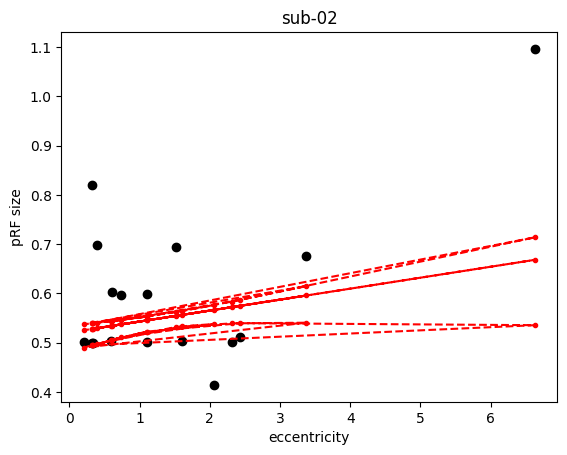

Intercept: 0.5208865963157272
t = 25.99, p = 0.00000
Slope: 0.022218494941659624
t = 1.77, p = 0.07681
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


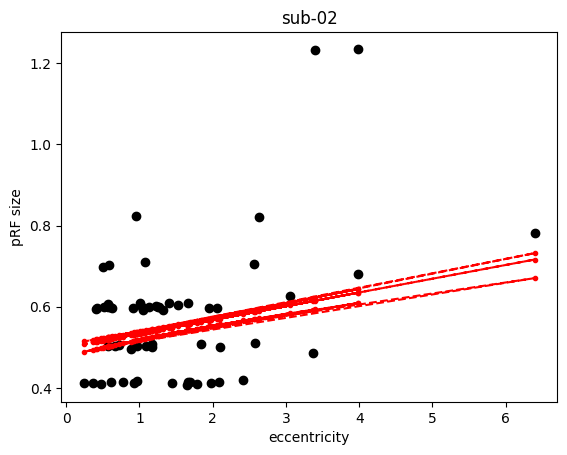

Intercept: 0.4996687158137199
t = 47.77, p = 0.00000
Slope: 0.03386399605003136
t = 7.22, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


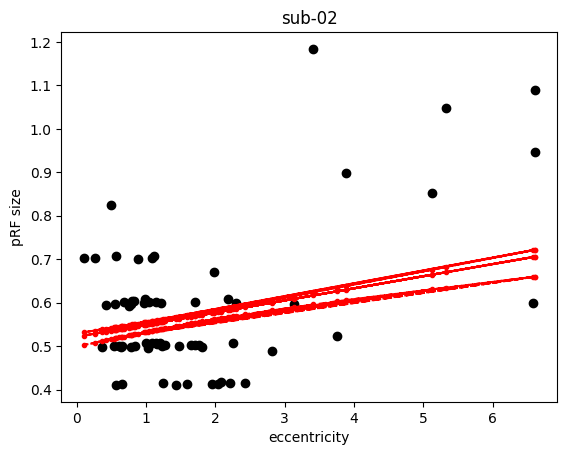

Intercept: 0.5217604023028504
t = 45.52, p = 0.00000
Slope: 0.027839736772098615
t = 5.98, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


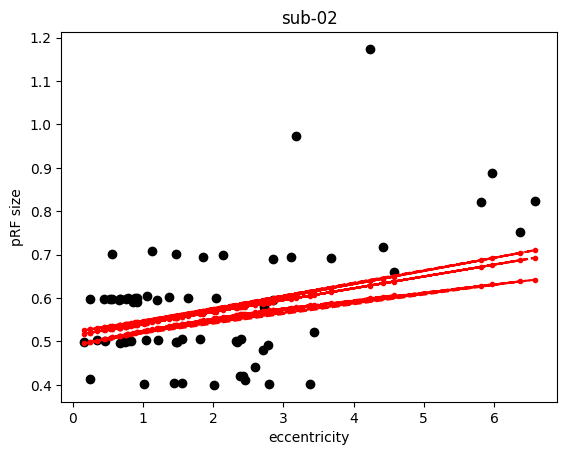

Intercept: 0.5135011361069542
t = 42.73, p = 0.00000
Slope: 0.027245343808355495
t = 5.29, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


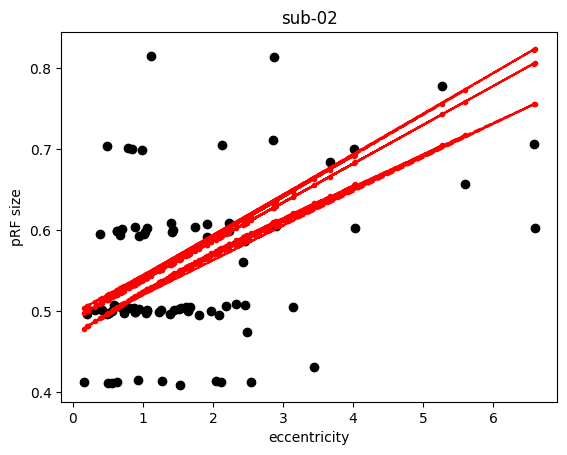

Intercept: 0.49024082554485526
t = 47.36, p = 0.00000
Slope: 0.04791448024388486
t = 9.62, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


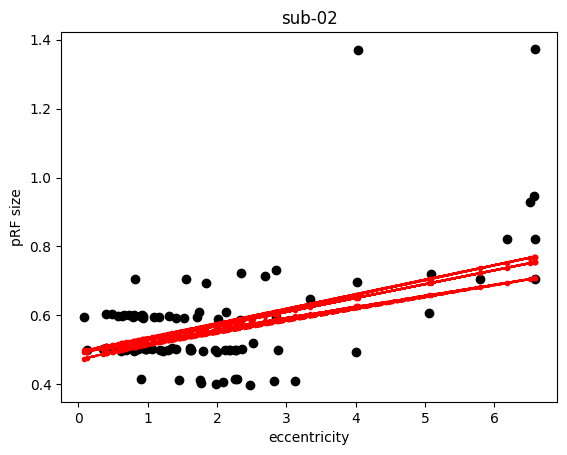

Intercept: 0.4889559348226168
t = 52.92, p = 0.00000
Slope: 0.040342528469306034
t = 8.70, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


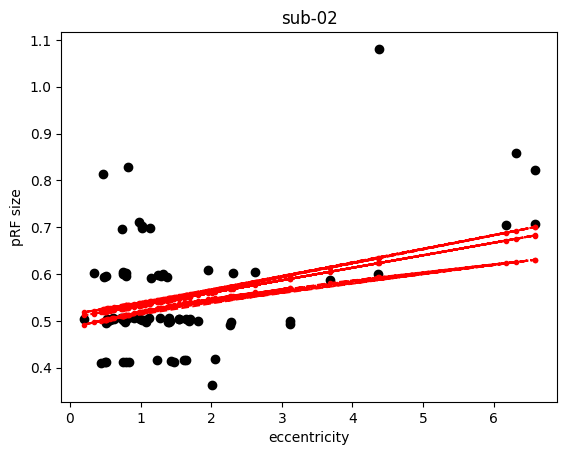

Intercept: 0.5066208880322738
t = 46.51, p = 0.00000
Slope: 0.026720909085608268
t = 5.09, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


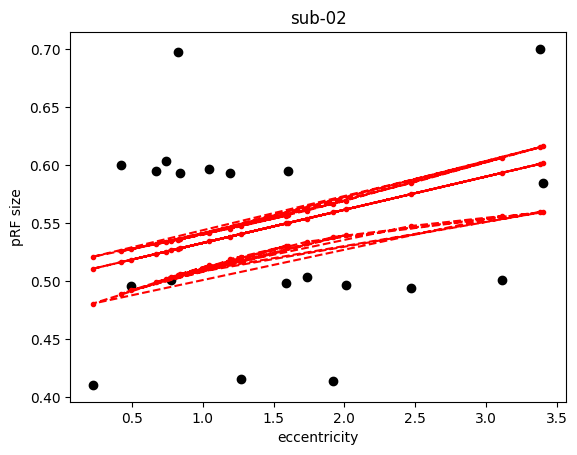

Intercept: 0.504402054460507
t = 29.57, p = 0.00000
Slope: 0.028617130086678245
t = 2.94, p = 0.00328
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


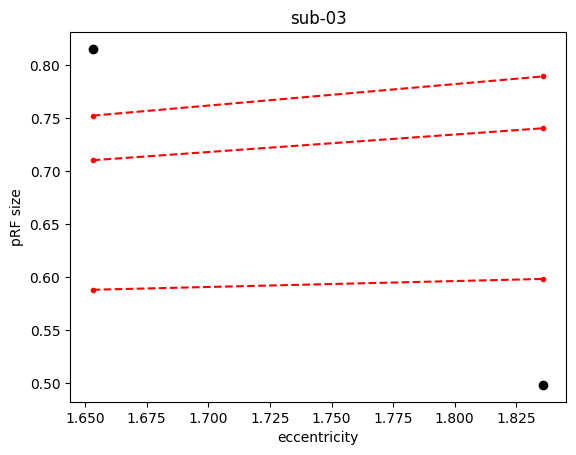

Intercept: 0.43790701116810216
t = 5.28, p = 0.00000
Slope: 0.16471303782069027
t = 2.31, p = 0.02062
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


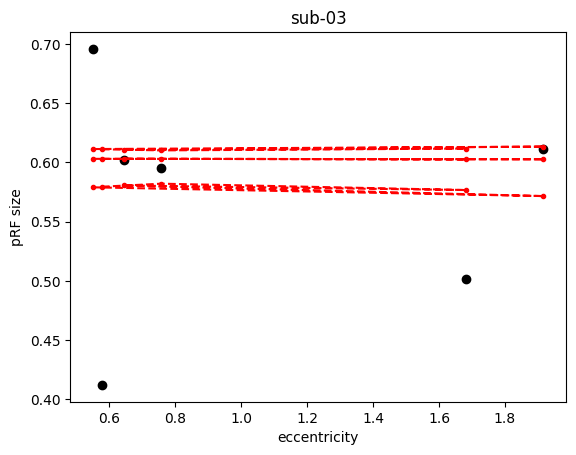

Intercept: 0.603179537508436
t = 32.89, p = 0.00000
Slope: -0.0002720907708207848
t = -0.02, p = 0.98520
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


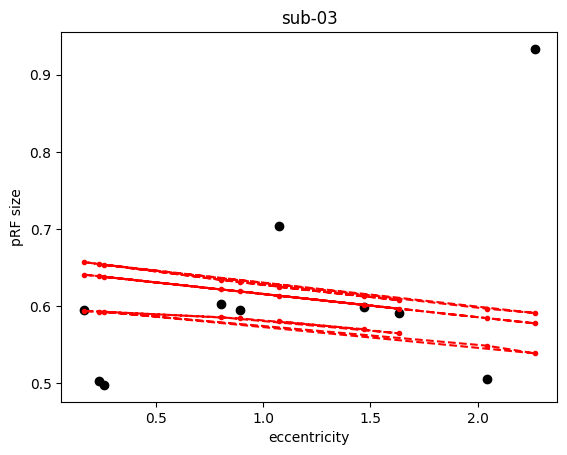

Intercept: 0.6459108145748294
t = 25.00, p = 0.00000
Slope: -0.030034579050242635
t = -2.14, p = 0.03253
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


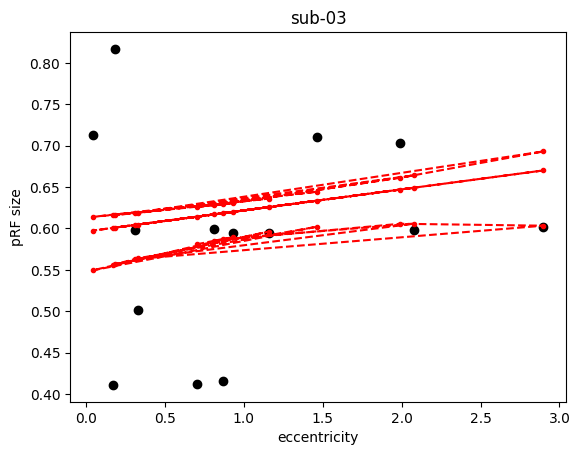

Intercept: 0.5963375897133654
t = 23.77, p = 0.00000
Slope: 0.025449503488534142
t = 1.46, p = 0.14427
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


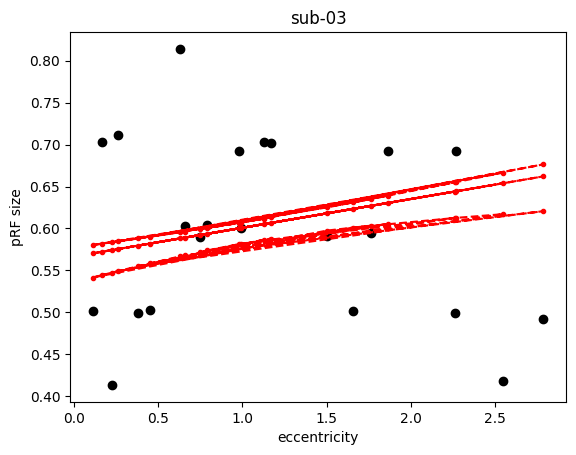

Intercept: 0.5664204192671134
t = 36.15, p = 0.00000
Slope: 0.03434301816597181
t = 3.05, p = 0.00232
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


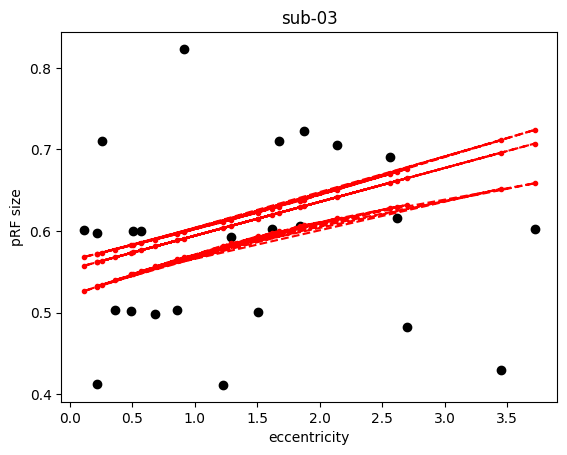

Intercept: 0.552746540981451
t = 33.18, p = 0.00000
Slope: 0.04147990482312783
t = 4.41, p = 0.00001
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


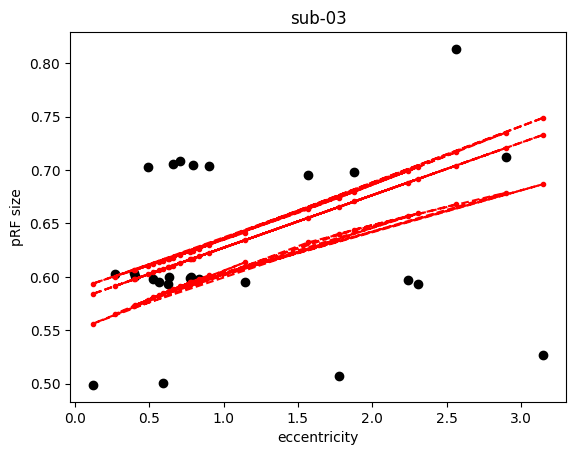

Intercept: 0.5780176637032091
t = 38.27, p = 0.00000
Slope: 0.049227356247019016
t = 4.86, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


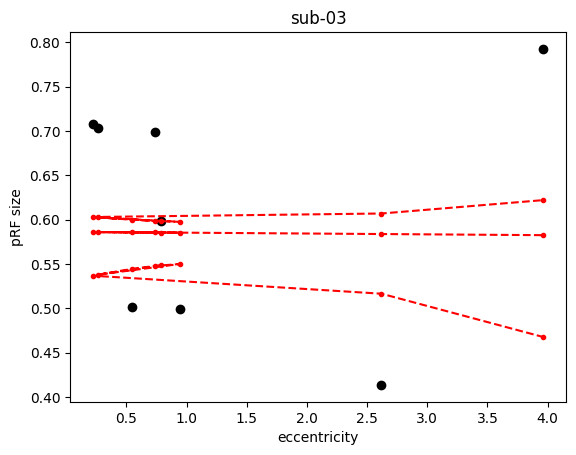

Intercept: 0.5863506013548982
t = 20.70, p = 0.00000
Slope: -0.000945263162590762
t = -0.05, p = 0.96167
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


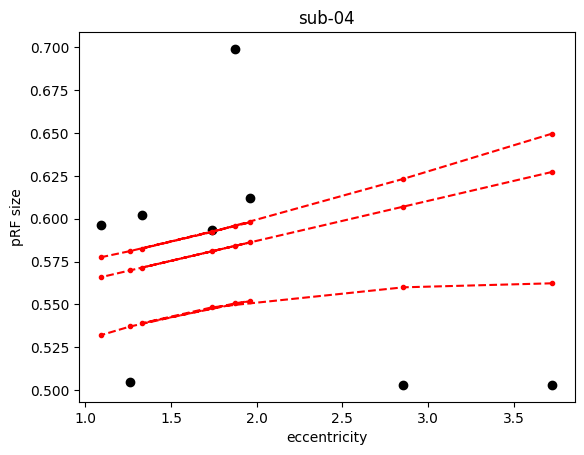

Intercept: 0.5404389461172898
t = 21.21, p = 0.00000
Slope: 0.02331343581717607
t = 1.80, p = 0.07224
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


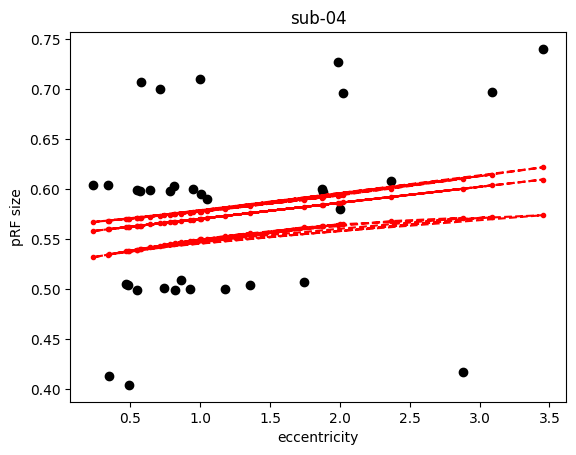

Intercept: 0.5543156784161134
t = 37.93, p = 0.00000
Slope: 0.01599730651152831
t = 2.16, p = 0.03113
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


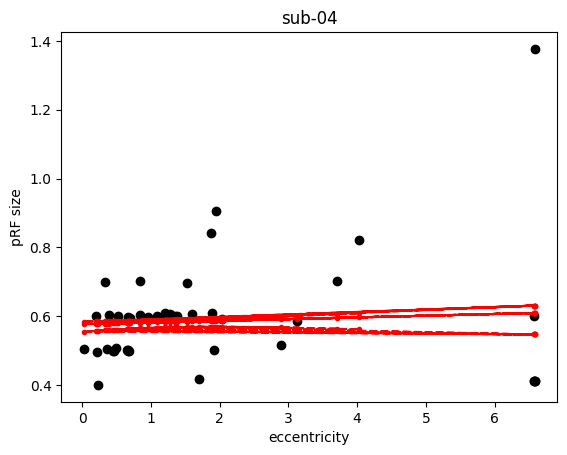

Intercept: 0.5765347095819868
t = 51.63, p = 0.00000
Slope: 0.00496065226350687
t = 0.84, p = 0.40215
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


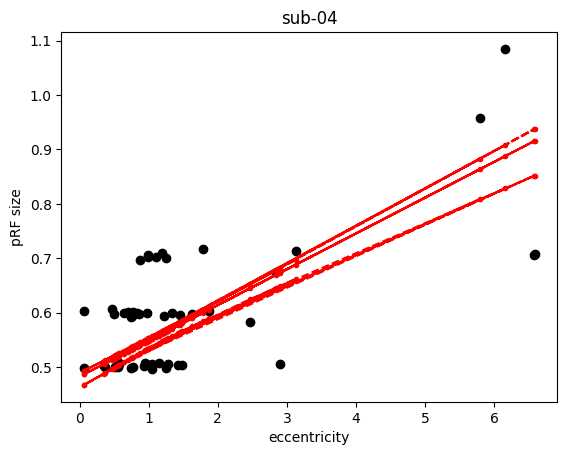

Intercept: 0.48271773690184944
t = 47.51, p = 0.00000
Slope: 0.06573999388149915
t = 11.09, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


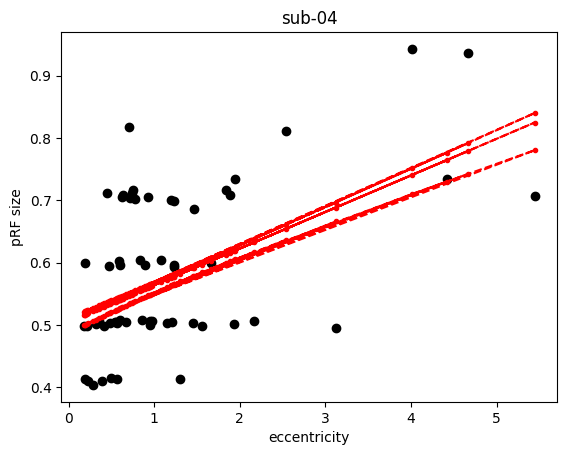

Intercept: 0.5051300731261104
t = 56.39, p = 0.00000
Slope: 0.058732742148766726
t = 11.20, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


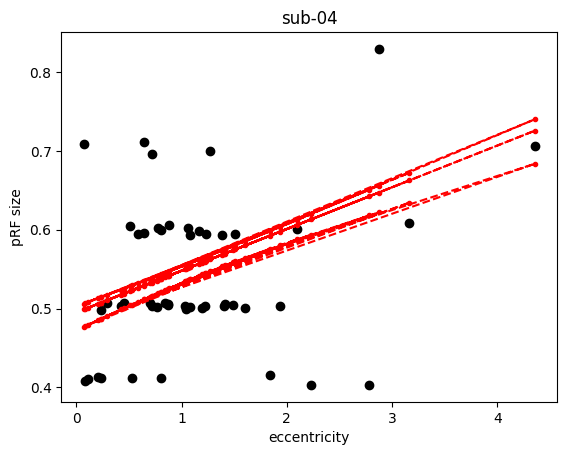

Intercept: 0.4949544555501805
t = 43.15, p = 0.00000
Slope: 0.052961872480509944
t = 8.08, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


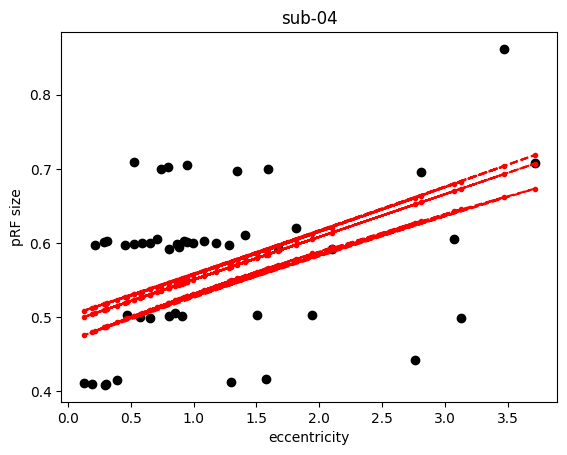

Intercept: 0.4929726909070442
t = 37.54, p = 0.00000
Slope: 0.05755933557546804
t = 8.96, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


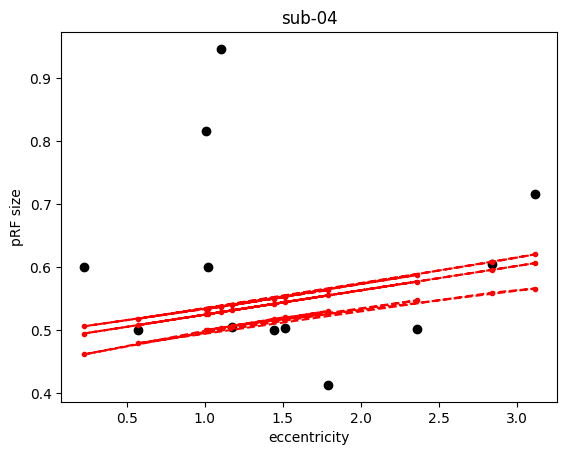

Intercept: 0.48597246521635074
t = 26.24, p = 0.00000
Slope: 0.03859531878557584
t = 3.94, p = 0.00008


In [519]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'lh') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'rh') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.2)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.atleast_2d(X_test[:,1]).T, y_test, 'ko')
        plt.plot(np.atleast_2d(X_test[:,1]).T, y_pred, 'r--.')
        plt.plot(np.atleast_2d(X_test[:,1]).T, quantiles['mean_ci_lower'].values, 'r--.')
        plt.plot(np.atleast_2d(X_test[:,1]).T, median['mean_ci_upper'].values, 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id])
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + 2*slope

    #     # print the quantiles
    #     print("95% quantiles:")
    #     print(quantiles.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

    #     # print the median
    #     print("Median:")
    #     print(median.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

        # save stats to df
        idx=df_pRFxecc_stats_equivol.loc[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_equivol.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        
    

    
    
    

In [510]:
df_pRFxecc_stats_equivol.head()


sub id  depth  intercept     slope         intercept-stats  \
0  sub-01    0.2   0.591374  0.008303  t = 36.35, p = 0.00000   
1  sub-01    0.3   0.561721  0.026361  t = 57.62, p = 0.00000   
2  sub-01    0.4   0.559810  0.024651  t = 70.90, p = 0.00000   
3  sub-01    0.5   0.539185  0.041085  t = 64.99, p = 0.00000   
4  sub-01    0.6   0.564886  0.018226  t = 73.96, p = 0.00000   

             slope-stats  pRF@2deg  
0  t = 0.84, p = 0.40220  0.607980  
1  t = 4.12, p = 0.00004  0.614443  
2  t = 4.53, p = 0.00001  0.609112  
3  t = 8.13, p = 0.00000  0.621355  
4  t = 3.89, p = 0.00010  0.601339

#### Plot estimated pRF size at 2 deg

[ 0.03810588 -0.00680272  0.60899698]
R2 quadratic: 0.5027046146509528
R2 linear: 0.4800888493847919


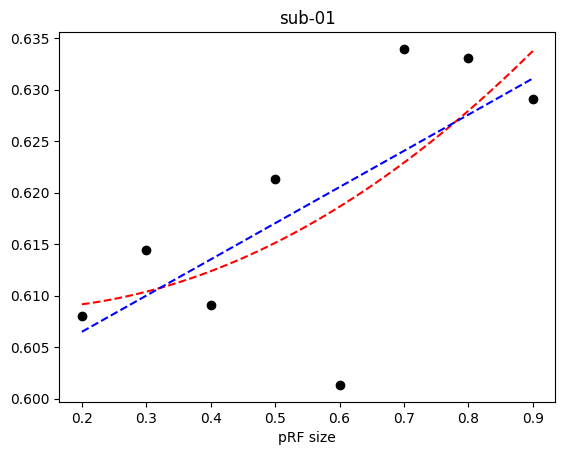

[-0.0923782   0.08536332  0.55778506]
R2 quadratic: 0.58431090950827
R2 linear: 0.254906645007302


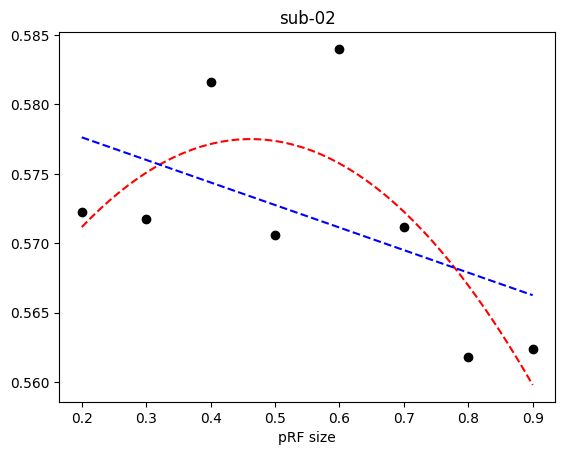

[ 0.25737506 -0.37163996  0.74096322]
R2 quadratic: 0.19500319129880028
R2 linear: 0.14573205318311722


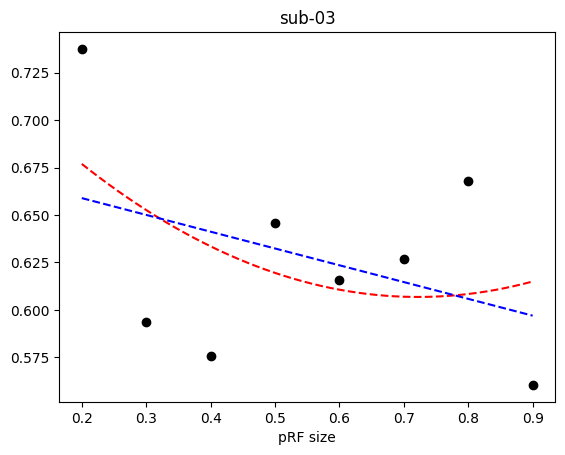

[-0.24364993  0.29495381  0.52216915]
R2 quadratic: 0.42562788101280224
R2 linear: 0.09962847767499816


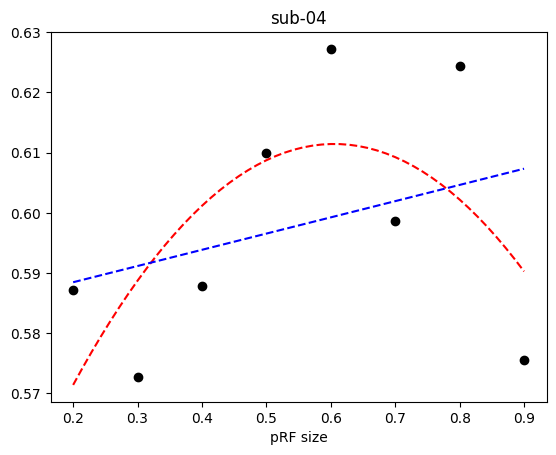

In [511]:
for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    x = np.linspace(0.2, 0.9, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    plt.plot(depth,pRF_2deg,'ko')
    plt.plot(x,y_quadratic,'r--')
    plt.plot(x,y_linear,'b--')
    plt.xlabel('fractional distance from WM to GM')
    plt.ylabel('pRF size')
    plt.title(subject_list[sub_id])
    plt.show()
    
    
#     df_pRFxecc_stats_equivol.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

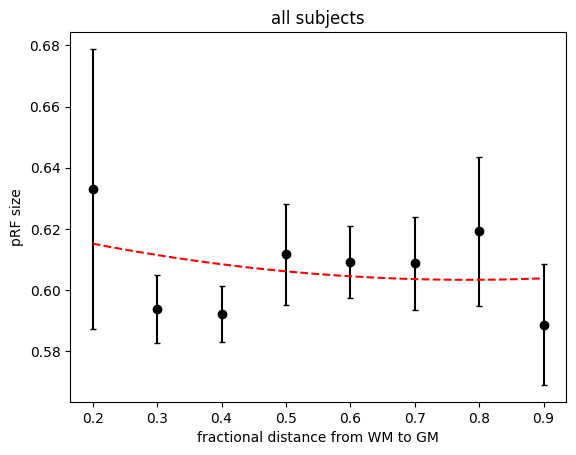

In [592]:
idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equivol.loc[idx,'depth'].values
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id])].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values

    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_equivol.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equivol.loc[:,'pRF@2deg'].values



# # Plot the line of best fit
# fig,ax = plt.subplots()
# # ax.scatter(depth, pRF_2deg[:,0], c='red', label='y_1')
# # ax.scatter(depth, pRF_2deg[:,1], c='green', label='y_2')
# # ax.scatter(depth, pRF_2deg[:,2], c='blue', label='y_3')
# # ax.scatter(depth, pRF_2deg[:,3], c='black', label='y_4')
# # ax.plot(X_plot, y_plot[:,0], c='red', label='Predictions for y_1')
# # ax.plot(X_plot, y_plot[:,1], c='green', label='Predictions for y_2')
# # ax.plot(X_plot, y_plot[:,2], c='blue', label='Predictions for y_3')
# # ax.plot(X_plot, y_plot[:,3], c='black', label='Predictions for y_4')
# # plt.xlabel("Independent variable")
# # plt.ylabel("Dependent variable")
# plt.legend()
# plt.show()

# plot the model
#plt.plot(depth,pRF_2deg.mean(axis=1),'ko')

plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)

plt.plot(X_plot,y_mean,'r--')
# plt.plot(x,y_linear,'b--')
plt.xlabel('fractional distance from WM to GM')
plt.ylabel('pRF size')
plt.title('all subjects')
plt.show()


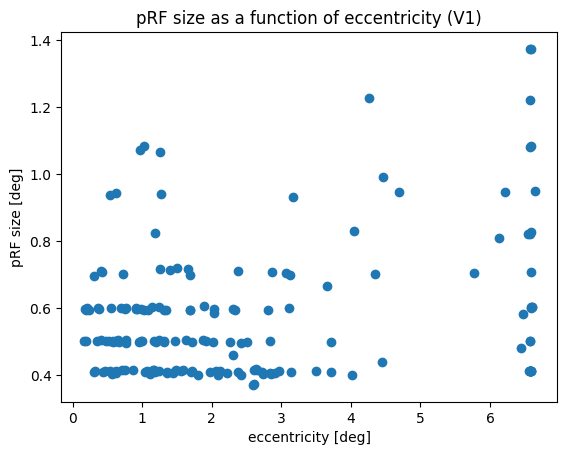

In [123]:
plt.scatter(ecc_depth_0, sigma_depth_0)

plt.title("pRF size as a function of eccentricity (V1)")
plt.xlabel('eccentricity [deg]')
plt.ylabel('pRF size [deg]')
#plt.legend(["deep","middle","superficial"])
plt.show()


In [208]:
depths = np.stack(df_equidist_per_ecc.loc[[0], 'depth'].to_numpy(), axis=0)
depths=list(itertools.chain(*depths))
depths

[0.2,
 0.30000000000000004,
 0.4000000000000001,
 0.5000000000000001,
 0.6000000000000001,
 0.7000000000000002,
 0.8000000000000003,
 0.9000000000000001]

Equidistant layering

In [209]:
# ecc 2
idx=df_equidist_per_ecc.loc[(df_equidist_per_ecc['ecc'] == 2)].index.tolist()
sigma_depth_2 = np.stack(df_equidist_per_ecc.loc[idx, 'pRF size'].to_numpy(), axis=0)
sigma_depth_2 = np.nanmean(sigma_depth_2,0).tolist()
sigma_depth_2

# ecc 3
idx=df_equidist_per_ecc.loc[(df_equidist_per_ecc['ecc'] == 3)].index.tolist()
sigma_depth_3 = np.stack(df_equidist_per_ecc.loc[idx, 'pRF size'].to_numpy(), axis=0)
sigma_depth_3 = np.nanmean(sigma_depth_3,0).tolist()

# ecc 4
idx=df_equidist_per_ecc.loc[(df_equidist_per_ecc['ecc'] == 4)].index.tolist()
sigma_depth_4 = np.stack(df_equidist_per_ecc.loc[idx, 'pRF size'].to_numpy(), axis=0)
sigma_depth_4 = np.nanmean(sigma_depth_4,0).tolist()

# ecc 5
idx=df_equidist_per_ecc.loc[(df_equidist_per_ecc['ecc'] == 5)].index.tolist()
sigma_depth_5 = np.stack(df_equidist_per_ecc.loc[idx, 'pRF size'].to_numpy(), axis=0)
sigma_depth_5 = np.nanmean(sigma_depth_5,0).tolist()


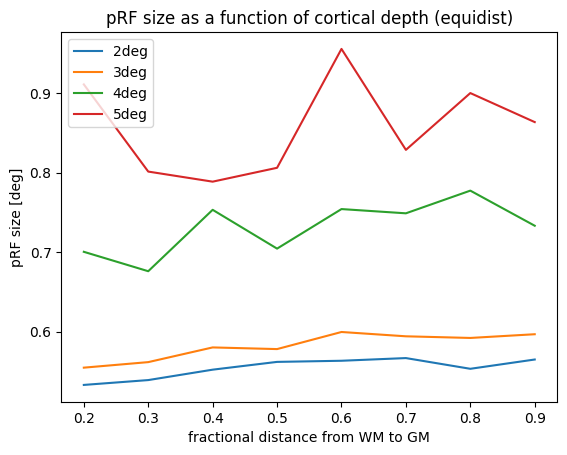

In [210]:
plt.title("pRF size as a function of cortical depth (equidist)")
plt.plot(depths,sigma_depth_2)
plt.plot(depths,sigma_depth_3)
plt.plot(depths,sigma_depth_4)
plt.plot(depths,sigma_depth_5)

plt.xlabel('fractional distance from WM to GM')
plt.ylabel('pRF size [deg]')
plt.legend(["2deg","3deg","4deg","5deg"])
plt.show()

Equivolumetric layering

In [216]:
# ecc 2
idx=df_equivol_per_ecc.loc[(df_equivol_per_ecc['ecc'] == 2)].index.tolist()
sigma_depth_2_all = np.stack(df_equivol_per_ecc.loc[idx, 'pRF size'].to_numpy(), axis=0)
sigma_depth_2 = np.nanmean(sigma_depth_2_all,0).tolist()
sigma_depth_2

# ecc 3
idx=df_equivol_per_ecc.loc[(df_equivol_per_ecc['ecc'] == 3)].index.tolist()
sigma_depth_3_all = np.stack(df_equivol_per_ecc.loc[idx, 'pRF size'].to_numpy(), axis=0)
sigma_depth_3 = np.nanmean(sigma_depth_3_all,0).tolist()

# ecc 4
idx=df_equivol_per_ecc.loc[(df_equivol_per_ecc['ecc'] == 4)].index.tolist()
sigma_depth_4_all = np.stack(df_equivol_per_ecc.loc[idx, 'pRF size'].to_numpy(), axis=0)
sigma_depth_4 = np.nanmean(sigma_depth_4_all,0).tolist()

# ecc 5
idx=df_equivol_per_ecc.loc[(df_equivol_per_ecc['ecc'] == 5)].index.tolist()
sigma_depth_5_all = np.stack(df_equivol_per_ecc.loc[idx, 'pRF size'].to_numpy(), axis=0)
sigma_depth_5 = np.nanmean(sigma_depth_5_all,0).tolist()


In [217]:
# sigma_depth_2_all.flatten().shape

In [218]:
# np.array([depths]*8).flatten().shape

In [219]:
# plt.scatter(np.array([depths]*8).flatten(),sigma_depth_2_all.flatten())
# plt.scatter(np.array([depths]*8).flatten(),sigma_depth_3_all.flatten())
# plt.scatter(np.array([depths]*8).flatten(),sigma_depth_4_all.flatten())
# plt.scatter(np.array([depths]*8).flatten(),sigma_depth_5_all.flatten())

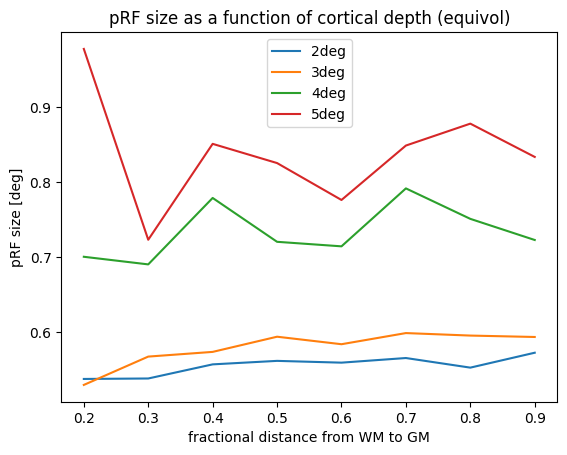

In [220]:
plt.title("pRF size as a function of cortical depth (equivol)")
plt.plot(depths,sigma_depth_2)
plt.plot(depths,sigma_depth_3)
plt.plot(depths,sigma_depth_4)
plt.plot(depths,sigma_depth_5)

plt.xlabel('fractional distance from WM to GM')
plt.ylabel('pRF size [deg]')
plt.legend(["2deg","3deg","4deg","5deg"])
plt.show()

### Fit U-shape to individual participants' pRF size vs cortical depth relationships

In [ ]:
for sub_id in range(0,len(subject_list)):
    

In [172]:
# equivol_param_fn = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params_equivol.pckl')
# equidist_param_fn = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params_equidist.pckl')

# f = open(equivol_param_fn, 'rb')
# pickle.dump([sigma_ecc_2,sigma_ecc_3,sigma_ecc_4,sigma_ecc_5], f)
# f.close()

In [64]:
rsq_thresh = 0.1

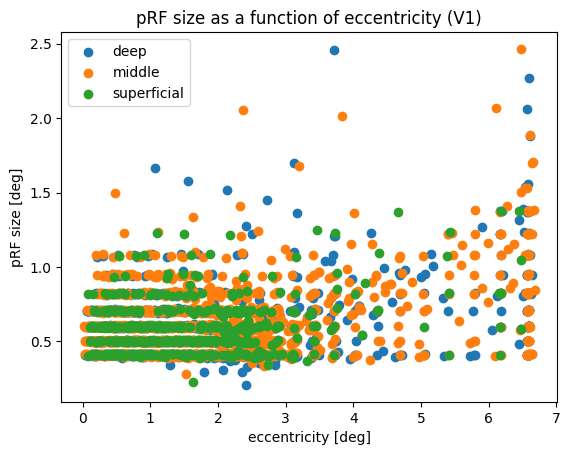

In [65]:
# deep
V1_ecc = ecc[(masked_V1==1) & (total_rsq>rsq_thresh) & ((masked_lay_equivol >= 1) & (masked_lay_equivol <= 4))]
V1_sigma = sigma[(masked_V1==1) & (total_rsq>rsq_thresh)  & ((masked_lay_equivol >= 1) & (masked_lay_equivol <= 4))]
plt.scatter(V1_ecc, V1_sigma)

# middle
V1_ecc = ecc[(masked_V1==1) & (total_rsq>rsq_thresh) & ((masked_lay_equivol >= 5) & (masked_lay_equivol <= 7))]
V1_sigma = sigma[(masked_V1==1) & (total_rsq>rsq_thresh)  & ((masked_lay_equivol >= 5) & (masked_lay_equivol <= 7))]
plt.scatter(V1_ecc, V1_sigma)

# superficial
V1_ecc = ecc[(masked_V1==1) & (total_rsq>rsq_thresh) & ((masked_lay_equivol >= 8) & (masked_lay_equivol <= 10)) & (ecc < max_ecc_deg)]
V1_sigma = sigma[(masked_V1==1) & (total_rsq>rsq_thresh)  & ((masked_lay_equivol >= 8) & (masked_lay_equivol <= 10)) & (ecc < max_ecc_deg)]
plt.scatter(V1_ecc, V1_sigma)

plt.title("pRF size as a function of eccentricity (V1)")
plt.xlabel('eccentricity [deg]')
plt.ylabel('pRF size [deg]')
plt.legend(["deep","middle","superficial"])
plt.show()

# V1_sigma = sigma[masked_V1==1 and total_rsq>0.2]

### Plot sigma across layers at different eccentricities

#### Equivolumetric layers

In [66]:
ecc_idx = (ecc >= 2.5) & (ecc < 3.5)
sigma_deep = sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & ((masked_lay_equivol >= 1) & (masked_lay_equivol <= 4))]
sigma_mid = sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & ((masked_lay_equivol >= 5) & (masked_lay_equivol <= 7))]
sigma_super = sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & ((masked_lay_equivol >= 8) & (masked_lay_equivol <= 10))]


In [71]:
sum(masked_lay_equivol == 10)

4

In [67]:
print("Deep: "+str(np.mean(sigma_deep)))
print("Middle: "+str(np.mean(sigma_mid)))
print("Superficial: "+str(np.mean(sigma_super)))


Deep: 0.5660794428640027
Middle: 0.5754862408346085
Superficial: 0.5506264154470965


In [32]:
sigma_depth_2 = []
sigma_depth_3 = []
sigma_depth_4 = []
sigma_depth_5 = []

for layer in range(2,np.size(np.unique(masked_lay_equivol))):
    ecc_idx = (ecc >= 1.5) & (ecc < 2.5)
    s_val=np.mean(sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & (masked_lay_equivol == layer)])
    #print("Layer " +str(layer)+": "+str(s_val))
    sigma_depth_2.append(s_val)
    
    ecc_idx = (ecc >= 2.5) & (ecc < 3.5)
    s_val=np.mean(sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & (masked_lay_equivol == layer)])
    #print("Layer " +str(layer)+": "+str(s_val))
    sigma_depth_3.append(s_val)
    
    ecc_idx = (ecc >= 3.5) & (ecc < 4.5)
    s_val=np.mean(sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & (masked_lay_equivol == layer)])
    #print("Layer " +str(layer)+": "+str(s_val))
    sigma_depth_4.append(s_val)
    
    ecc_idx = (ecc >= 4.5) & (ecc < 5.5)
    s_val=np.mean(sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & (masked_lay_equivol == layer)])
    #print("Layer " +str(layer)+": "+str(s_val))
    sigma_depth_5.append(s_val)

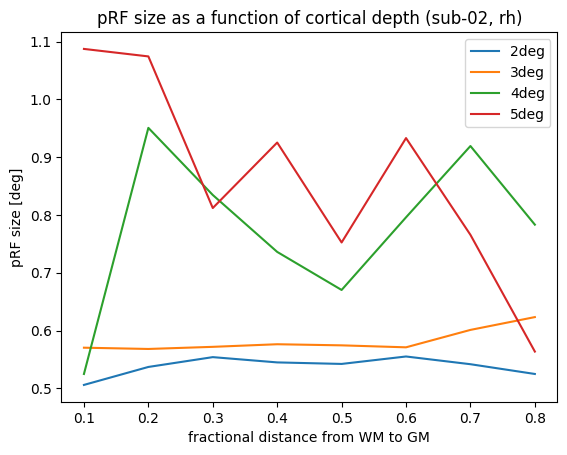

In [33]:
plt.title("pRF size as a function of cortical depth ("+subject_list[sub_id]+", "+hem_list[hem_id]+")")
plt.plot(np.arange(1, 9, 1)/10,sigma_depth_2)
plt.plot(np.arange(1, 9, 1)/10,sigma_depth_3)
plt.plot(np.arange(1, 9, 1)/10,sigma_depth_4)
plt.plot(np.arange(1, 9, 1)/10,sigma_depth_5)

plt.xlabel('fractional distance from WM to GM')
plt.ylabel('pRF size [deg]')
plt.legend(["2deg","3deg","4deg","5deg"])
plt.show()

In [34]:
f = open(equivol_param_fn, 'wb')
pickle.dump([sigma_depth_2,sigma_depth_3,sigma_depth_4,sigma_depth_5], f)

#### Equidistant layers

In [35]:
sigma_depth_2 = []
sigma_depth_3 = []
sigma_depth_4 = []
sigma_depth_5 = []

for layer in range(2,np.size(np.unique(masked_lay_equivol))):
    ecc_idx = (ecc >= 1.5) & (ecc < 2.5)
    s_val=np.mean(sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & (masked_lay_equidist == layer)])
    #print("Layer " +str(layer)+": "+str(s_val))
    sigma_depth_2.append(s_val)
    
    ecc_idx = (ecc >= 2.5) & (ecc < 3.5)
    s_val=np.mean(sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & (masked_lay_equidist == layer)])
    #print("Layer " +str(layer)+": "+str(s_val))
    sigma_depth_3.append(s_val)
    
    ecc_idx = (ecc >= 3.5) & (ecc < 4.5)
    s_val=np.mean(sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & (masked_lay_equidist == layer)])
    #print("Layer " +str(layer)+": "+str(s_val))
    sigma_depth_4.append(s_val)
    
    ecc_idx = (ecc >= 4.5) & (ecc < 5.5)
    s_val=np.mean(sigma[(ecc_idx) & (masked_V1==1) & (total_rsq>rsq_thresh)  & (masked_lay_equidist == layer)])
    #print("Layer " +str(layer)+": "+str(s_val))
    sigma_depth_5.append(s_val)

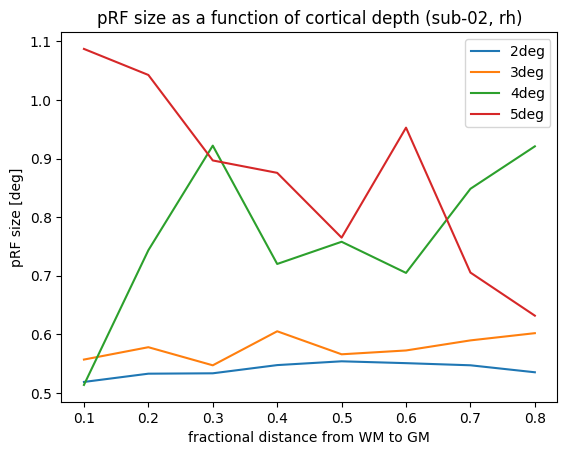

In [36]:
plt.title("pRF size as a function of cortical depth ("+subject_list[sub_id]+", "+hem_list[hem_id]+")")
plt.plot(cc,sigma_depth_2)
plt.plot(np.arange(1, 9, 1)/10,sigma_depth_3)
plt.plot(np.arange(1, 9, 1)/10,sigma_depth_4)
plt.plot(np.arange(1, 9, 1)/10,sigma_depth_5)

plt.xlabel('fractional distance from WM to GM')
plt.ylabel('pRF size [deg]')
plt.legend(["2deg","3deg","4deg","5deg"])
plt.show()